## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1476, 256)
Hypercube shape: (1476, 256, 145)


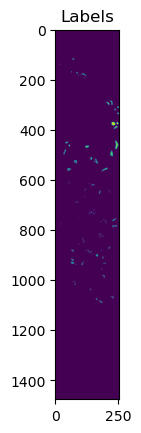

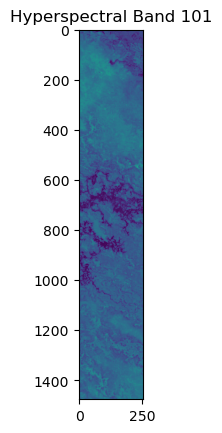

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Botswana_gt.mat'
data_files = 'Botswana.mat'
label_files = 'Botswana_gt'
hypercube_files = 'Botswana'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 3248
Extracted windows shape: (3248, 5, 5, 145)
Corresponding labels shape: (3248,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 270 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 101 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 251 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 215 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 269 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 269 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 259 samples
Shuffled class indices for class '7'
S


All datasets saved to the 'indices' folder.
(560, 5, 5, 145)
(70, 5, 5, 145)
(2618, 5, 5, 145)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 280
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (2598, 5, 5, 145)
Validation data shape: (650, 5, 5, 145)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

145


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/41], Loss: 0.2217, PSNR: -8.0795


Epoch [1/50] Training Loss: 0.2135, PSNR: -8.7496
	[Val]   Batch [1/11] Loss: 0.2046, PSNR: -6.1453
	[Val]   Batch [10/11] Loss: 0.2047, PSNR: -8.3838
Epoch [1/50] Validation Loss: 0.2046, PSNR: -8.0761

LOG: Epoch [2/50]
	 Training Batch [1/41], Loss: 0.1984, PSNR: -6.0115


Epoch [2/50] Training Loss: 0.1916, PSNR: -8.2480
	[Val]   Batch [1/11] Loss: 0.1800, PSNR: -5.5908
	[Val]   Batch [10/11] Loss: 0.1801, PSNR: -7.8287
Epoch [2/50] Validation Loss: 0.1799, PSNR: -7.5190

LOG: Epoch [3/50]
	 Training Batch [1/41], Loss: 0.1781, PSNR: -5.5435


Epoch [3/50] Training Loss: 0.1705, PSNR: -7.8563
	[Val]   Batch [1/11] Loss: 0.1557, PSNR: -4.9597
	[Val]   Batch [10/11] Loss: 0.1559, PSNR: -7.2009
Epoch [3/50] Validation Loss: 0.1557, PSNR: -6.8909

LOG: Epoch [4/50]
	 Training Batch [1/41], Loss: 0.1583, PSNR: -5.0309


Epoch [4/50] Training Loss: 0.1501, PSNR: -7.3222
	[Val]   Batch [1/11] Loss: 0.1343, PSNR: -4.3173
	[Val]   Batch [10/11] Loss: 0.1344, PSNR: -6.5556
Epoch [4/50] Validation Loss: 0.1343, PSNR: -6.2493

LOG: Epoch [5/50]
	 Training Batch [1/41], Loss: 0.1385, PSNR: -4.4531


Epoch [5/50] Training Loss: 0.1308, PSNR: -6.6594
	[Val]   Batch [1/11] Loss: 0.1168, PSNR: -3.7103
	[Val]   Batch [10/11] Loss: 0.1167, PSNR: -5.9450
Epoch [5/50] Validation Loss: 0.1167, PSNR: -5.6397

LOG: Epoch [6/50]
	 Training Batch [1/41], Loss: 0.1177, PSNR: -6.6866


Epoch [6/50] Training Loss: 0.1131, PSNR: -6.1416
	[Val]   Batch [1/11] Loss: 0.0998, PSNR: -3.0273
	[Val]   Batch [10/11] Loss: 0.0998, PSNR: -5.2629
Epoch [6/50] Validation Loss: 0.0997, PSNR: -4.9563

LOG: Epoch [7/50]
	 Training Batch [1/41], Loss: 0.1044, PSNR: -7.8218


Epoch [7/50] Training Loss: 0.0972, PSNR: -5.2792
	[Val]   Batch [1/11] Loss: 0.0854, PSNR: -2.3501
	[Val]   Batch [10/11] Loss: 0.0854, PSNR: -4.5881
Epoch [7/50] Validation Loss: 0.0854, PSNR: -4.2813

LOG: Epoch [8/50]
	 Training Batch [1/41], Loss: 0.0891, PSNR: -6.2614


Epoch [8/50] Training Loss: 0.0835, PSNR: -4.6884
	[Val]   Batch [1/11] Loss: 0.0743, PSNR: -1.7447
	[Val]   Batch [10/11] Loss: 0.0743, PSNR: -3.9820
Epoch [8/50] Validation Loss: 0.0743, PSNR: -3.6764

LOG: Epoch [9/50]
	 Training Batch [1/41], Loss: 0.0750, PSNR: -3.3688


Epoch [9/50] Training Loss: 0.0719, PSNR: -4.1385
	[Val]   Batch [1/11] Loss: 0.0649, PSNR: -1.1588
	[Val]   Batch [10/11] Loss: 0.0649, PSNR: -3.3963
Epoch [9/50] Validation Loss: 0.0649, PSNR: -3.0905

LOG: Epoch [10/50]
	 Training Batch [1/41], Loss: 0.0656, PSNR: -5.4267


Epoch [10/50] Training Loss: 0.0621, PSNR: -3.3714
	[Val]   Batch [1/11] Loss: 0.0568, PSNR: -0.5781
	[Val]   Batch [10/11] Loss: 0.0568, PSNR: -2.8150
Epoch [10/50] Validation Loss: 0.0568, PSNR: -2.5094

LOG: Epoch [11/50]
	 Training Batch [1/41], Loss: 0.0568, PSNR: -2.1615


Epoch [11/50] Training Loss: 0.0540, PSNR: -2.8328
	[Val]   Batch [1/11] Loss: 0.0498, PSNR: -0.0090
	[Val]   Batch [10/11] Loss: 0.0498, PSNR: -2.2445
Epoch [11/50] Validation Loss: 0.0498, PSNR: -1.9405

LOG: Epoch [12/50]
	 Training Batch [1/41], Loss: 0.0485, PSNR: 0.1043


Epoch [12/50] Training Loss: 0.0473, PSNR: -2.3781
	[Val]   Batch [1/11] Loss: 0.0439, PSNR: 0.5407
	[Val]   Batch [10/11] Loss: 0.0439, PSNR: -1.6944
Epoch [12/50] Validation Loss: 0.0439, PSNR: -1.3901

LOG: Epoch [13/50]
	 Training Batch [1/41], Loss: 0.0433, PSNR: -3.6246


Epoch [13/50] Training Loss: 0.0417, PSNR: -1.7645
	[Val]   Batch [1/11] Loss: 0.0397, PSNR: 0.9737
	[Val]   Batch [10/11] Loss: 0.0397, PSNR: -1.2603
Epoch [13/50] Validation Loss: 0.0397, PSNR: -0.9558

LOG: Epoch [14/50]
	 Training Batch [1/41], Loss: 0.0385, PSNR: -0.8219


Epoch [14/50] Training Loss: 0.0370, PSNR: -1.0896
	[Val]   Batch [1/11] Loss: 0.0349, PSNR: 1.5291
	[Val]   Batch [10/11] Loss: 0.0349, PSNR: -0.7059
Epoch [14/50] Validation Loss: 0.0349, PSNR: -0.4002

LOG: Epoch [15/50]
	 Training Batch [1/41], Loss: 0.0341, PSNR: 0.0473


Epoch [15/50] Training Loss: 0.0330, PSNR: -0.7726
	[Val]   Batch [1/11] Loss: 0.0314, PSNR: 1.9999
	[Val]   Batch [10/11] Loss: 0.0313, PSNR: -0.2352
Epoch [15/50] Validation Loss: 0.0313, PSNR: 0.0703

LOG: Epoch [16/50]
	 Training Batch [1/41], Loss: 0.0301, PSNR: -0.2457


Epoch [16/50] Training Loss: 0.0297, PSNR: -0.2406
	[Val]   Batch [1/11] Loss: 0.0284, PSNR: 2.4282
	[Val]   Batch [10/11] Loss: 0.0284, PSNR: 0.1938
Epoch [16/50] Validation Loss: 0.0284, PSNR: 0.4991

LOG: Epoch [17/50]
	 Training Batch [1/41], Loss: 0.0279, PSNR: 2.5021


Epoch [17/50] Training Loss: 0.0269, PSNR: 0.0871
	[Val]   Batch [1/11] Loss: 0.0260, PSNR: 2.8170
	[Val]   Batch [10/11] Loss: 0.0260, PSNR: 0.5834
Epoch [17/50] Validation Loss: 0.0260, PSNR: 0.8881

LOG: Epoch [18/50]
	 Training Batch [1/41], Loss: 0.0252, PSNR: -0.4767


Epoch [18/50] Training Loss: 0.0245, PSNR: 0.5904
	[Val]   Batch [1/11] Loss: 0.0236, PSNR: 3.2333
	[Val]   Batch [10/11] Loss: 0.0236, PSNR: 0.9993
Epoch [18/50] Validation Loss: 0.0236, PSNR: 1.3052

LOG: Epoch [19/50]
	 Training Batch [1/41], Loss: 0.0232, PSNR: 0.3725


Epoch [19/50] Training Loss: 0.0223, PSNR: 0.8305
	[Val]   Batch [1/11] Loss: 0.0218, PSNR: 3.5699
	[Val]   Batch [10/11] Loss: 0.0218, PSNR: 1.3358
Epoch [19/50] Validation Loss: 0.0218, PSNR: 1.6418

LOG: Epoch [20/50]
	 Training Batch [1/41], Loss: 0.0207, PSNR: 0.8685


Epoch [20/50] Training Loss: 0.0205, PSNR: 1.1485
	[Val]   Batch [1/11] Loss: 0.0199, PSNR: 3.9655
	[Val]   Batch [10/11] Loss: 0.0199, PSNR: 1.7306
Epoch [20/50] Validation Loss: 0.0199, PSNR: 2.0378

LOG: Epoch [21/50]
	 Training Batch [1/41], Loss: 0.0192, PSNR: 2.5530


Epoch [21/50] Training Loss: 0.0189, PSNR: 1.6008
	[Val]   Batch [1/11] Loss: 0.0184, PSNR: 4.3089
	[Val]   Batch [10/11] Loss: 0.0184, PSNR: 2.0744
Epoch [21/50] Validation Loss: 0.0184, PSNR: 2.3817

LOG: Epoch [22/50]
	 Training Batch [1/41], Loss: 0.0181, PSNR: 2.4394


Epoch [22/50] Training Loss: 0.0174, PSNR: 2.1183
	[Val]   Batch [1/11] Loss: 0.0171, PSNR: 4.6388
	[Val]   Batch [10/11] Loss: 0.0171, PSNR: 2.4055
Epoch [22/50] Validation Loss: 0.0171, PSNR: 2.7117

LOG: Epoch [23/50]
	 Training Batch [1/41], Loss: 0.0163, PSNR: 2.9111


Epoch [23/50] Training Loss: 0.0161, PSNR: 2.3308
	[Val]   Batch [1/11] Loss: 0.0159, PSNR: 4.9608
	[Val]   Batch [10/11] Loss: 0.0158, PSNR: 2.7274
Epoch [23/50] Validation Loss: 0.0158, PSNR: 3.0338

LOG: Epoch [24/50]
	 Training Batch [1/41], Loss: 0.0151, PSNR: 2.2273


Epoch [24/50] Training Loss: 0.0150, PSNR: 2.7179
	[Val]   Batch [1/11] Loss: 0.0148, PSNR: 5.2614
	[Val]   Batch [10/11] Loss: 0.0148, PSNR: 3.0280
Epoch [24/50] Validation Loss: 0.0148, PSNR: 3.3349

LOG: Epoch [25/50]
	 Training Batch [1/41], Loss: 0.0140, PSNR: 2.0760


Epoch [25/50] Training Loss: 0.0139, PSNR: 3.0569
	[Val]   Batch [1/11] Loss: 0.0138, PSNR: 5.5564
	[Val]   Batch [10/11] Loss: 0.0138, PSNR: 3.3230
Epoch [25/50] Validation Loss: 0.0138, PSNR: 3.6301

LOG: Epoch [26/50]
	 Training Batch [1/41], Loss: 0.0135, PSNR: 1.0060


Epoch [26/50] Training Loss: 0.0130, PSNR: 3.1903
	[Val]   Batch [1/11] Loss: 0.0129, PSNR: 5.8551
	[Val]   Batch [10/11] Loss: 0.0129, PSNR: 3.6222
Epoch [26/50] Validation Loss: 0.0129, PSNR: 3.9287

LOG: Epoch [27/50]
	 Training Batch [1/41], Loss: 0.0127, PSNR: 2.9867


Epoch [27/50] Training Loss: 0.0122, PSNR: 3.6432
	[Val]   Batch [1/11] Loss: 0.0121, PSNR: 6.1334
	[Val]   Batch [10/11] Loss: 0.0121, PSNR: 3.9005
Epoch [27/50] Validation Loss: 0.0121, PSNR: 4.2075

LOG: Epoch [28/50]
	 Training Batch [1/41], Loss: 0.0116, PSNR: 2.7204


Epoch [28/50] Training Loss: 0.0114, PSNR: 3.9776
	[Val]   Batch [1/11] Loss: 0.0114, PSNR: 6.3959
	[Val]   Batch [10/11] Loss: 0.0114, PSNR: 4.1622
Epoch [28/50] Validation Loss: 0.0114, PSNR: 4.4707

LOG: Epoch [29/50]
	 Training Batch [1/41], Loss: 0.0109, PSNR: 6.5807


Epoch [29/50] Training Loss: 0.0107, PSNR: 4.1416
	[Val]   Batch [1/11] Loss: 0.0107, PSNR: 6.6744
	[Val]   Batch [10/11] Loss: 0.0107, PSNR: 4.4409
Epoch [29/50] Validation Loss: 0.0107, PSNR: 4.7490

LOG: Epoch [30/50]
	 Training Batch [1/41], Loss: 0.0104, PSNR: 6.8127


Epoch [30/50] Training Loss: 0.0101, PSNR: 4.3936
	[Val]   Batch [1/11] Loss: 0.0101, PSNR: 6.9375
	[Val]   Batch [10/11] Loss: 0.0101, PSNR: 4.7037
Epoch [30/50] Validation Loss: 0.0100, PSNR: 5.0120

LOG: Epoch [31/50]
	 Training Batch [1/41], Loss: 0.0100, PSNR: 6.9683


Epoch [31/50] Training Loss: 0.0095, PSNR: 4.6918
	[Val]   Batch [1/11] Loss: 0.0095, PSNR: 7.1649
	[Val]   Batch [10/11] Loss: 0.0095, PSNR: 4.9312
Epoch [31/50] Validation Loss: 0.0095, PSNR: 5.2397

LOG: Epoch [32/50]
	 Training Batch [1/41], Loss: 0.0094, PSNR: 5.9359


Epoch [32/50] Training Loss: 0.0090, PSNR: 5.0627
	[Val]   Batch [1/11] Loss: 0.0090, PSNR: 7.3988
	[Val]   Batch [10/11] Loss: 0.0090, PSNR: 5.1666
Epoch [32/50] Validation Loss: 0.0090, PSNR: 5.4735

LOG: Epoch [33/50]
	 Training Batch [1/41], Loss: 0.0085, PSNR: 5.7187


Epoch [33/50] Training Loss: 0.0085, PSNR: 5.2366
	[Val]   Batch [1/11] Loss: 0.0085, PSNR: 7.6688
	[Val]   Batch [10/11] Loss: 0.0085, PSNR: 5.4360
Epoch [33/50] Validation Loss: 0.0085, PSNR: 5.7435

LOG: Epoch [34/50]
	 Training Batch [1/41], Loss: 0.0081, PSNR: 5.0153


Epoch [34/50] Training Loss: 0.0080, PSNR: 5.4633
	[Val]   Batch [1/11] Loss: 0.0081, PSNR: 7.9023
	[Val]   Batch [10/11] Loss: 0.0081, PSNR: 5.6690
Epoch [34/50] Validation Loss: 0.0080, PSNR: 5.9773

LOG: Epoch [35/50]
	 Training Batch [1/41], Loss: 0.0078, PSNR: 6.0931


Epoch [35/50] Training Loss: 0.0076, PSNR: 5.5760
	[Val]   Batch [1/11] Loss: 0.0077, PSNR: 8.1241
	[Val]   Batch [10/11] Loss: 0.0076, PSNR: 5.8915
Epoch [35/50] Validation Loss: 0.0076, PSNR: 6.1997

LOG: Epoch [36/50]
	 Training Batch [1/41], Loss: 0.0072, PSNR: 7.0459


Epoch [36/50] Training Loss: 0.0072, PSNR: 5.8067
	[Val]   Batch [1/11] Loss: 0.0073, PSNR: 8.3294
	[Val]   Batch [10/11] Loss: 0.0073, PSNR: 6.0973
Epoch [36/50] Validation Loss: 0.0073, PSNR: 6.4051

LOG: Epoch [37/50]
	 Training Batch [1/41], Loss: 0.0071, PSNR: 6.2328


Epoch [37/50] Training Loss: 0.0069, PSNR: 5.8350
	[Val]   Batch [1/11] Loss: 0.0069, PSNR: 8.5604
	[Val]   Batch [10/11] Loss: 0.0069, PSNR: 6.3271
Epoch [37/50] Validation Loss: 0.0069, PSNR: 6.6362

LOG: Epoch [38/50]
	 Training Batch [1/41], Loss: 0.0067, PSNR: 5.7368


Epoch [38/50] Training Loss: 0.0066, PSNR: 6.3753
	[Val]   Batch [1/11] Loss: 0.0066, PSNR: 8.7786
	[Val]   Batch [10/11] Loss: 0.0066, PSNR: 6.5450
Epoch [38/50] Validation Loss: 0.0066, PSNR: 6.8547

LOG: Epoch [39/50]
	 Training Batch [1/41], Loss: 0.0064, PSNR: 6.9508


Epoch [39/50] Training Loss: 0.0062, PSNR: 6.6504
	[Val]   Batch [1/11] Loss: 0.0063, PSNR: 8.9945
	[Val]   Batch [10/11] Loss: 0.0063, PSNR: 6.7609
Epoch [39/50] Validation Loss: 0.0063, PSNR: 7.0708

LOG: Epoch [40/50]
	 Training Batch [1/41], Loss: 0.0062, PSNR: 6.1234


Epoch [40/50] Training Loss: 0.0060, PSNR: 6.7888
	[Val]   Batch [1/11] Loss: 0.0060, PSNR: 9.1805
	[Val]   Batch [10/11] Loss: 0.0060, PSNR: 6.9474
Epoch [40/50] Validation Loss: 0.0060, PSNR: 7.2570

LOG: Epoch [41/50]
	 Training Batch [1/41], Loss: 0.0058, PSNR: 4.9527


Epoch [41/50] Training Loss: 0.0057, PSNR: 7.0485
	[Val]   Batch [1/11] Loss: 0.0057, PSNR: 9.3761
	[Val]   Batch [10/11] Loss: 0.0057, PSNR: 7.1438
Epoch [41/50] Validation Loss: 0.0057, PSNR: 7.4529

LOG: Epoch [42/50]
	 Training Batch [1/41], Loss: 0.0058, PSNR: 9.3101


Epoch [42/50] Training Loss: 0.0054, PSNR: 7.0597
	[Val]   Batch [1/11] Loss: 0.0055, PSNR: 9.5682
	[Val]   Batch [10/11] Loss: 0.0055, PSNR: 7.3357
Epoch [42/50] Validation Loss: 0.0055, PSNR: 7.6453

LOG: Epoch [43/50]
	 Training Batch [1/41], Loss: 0.0052, PSNR: 5.8478


Epoch [43/50] Training Loss: 0.0052, PSNR: 7.3605
	[Val]   Batch [1/11] Loss: 0.0053, PSNR: 9.7541
	[Val]   Batch [10/11] Loss: 0.0053, PSNR: 7.5216
Epoch [43/50] Validation Loss: 0.0052, PSNR: 7.8314

LOG: Epoch [44/50]
	 Training Batch [1/41], Loss: 0.0051, PSNR: 6.5079


Epoch [44/50] Training Loss: 0.0050, PSNR: 7.6902
	[Val]   Batch [1/11] Loss: 0.0051, PSNR: 9.9180
	[Val]   Batch [10/11] Loss: 0.0051, PSNR: 7.6853
Epoch [44/50] Validation Loss: 0.0051, PSNR: 7.9956

LOG: Epoch [45/50]
	 Training Batch [1/41], Loss: 0.0049, PSNR: 8.5063


Epoch [45/50] Training Loss: 0.0048, PSNR: 7.8328
	[Val]   Batch [1/11] Loss: 0.0048, PSNR: 10.1307
	[Val]   Batch [10/11] Loss: 0.0048, PSNR: 7.8983
Epoch [45/50] Validation Loss: 0.0048, PSNR: 8.2089

LOG: Epoch [46/50]
	 Training Batch [1/41], Loss: 0.0047, PSNR: 10.2052


Epoch [46/50] Training Loss: 0.0046, PSNR: 7.6066
	[Val]   Batch [1/11] Loss: 0.0046, PSNR: 10.3077
	[Val]   Batch [10/11] Loss: 0.0046, PSNR: 8.0756
Epoch [46/50] Validation Loss: 0.0046, PSNR: 8.3855

LOG: Epoch [47/50]
	 Training Batch [1/41], Loss: 0.0043, PSNR: 7.1604


Epoch [47/50] Training Loss: 0.0044, PSNR: 7.9242
	[Val]   Batch [1/11] Loss: 0.0045, PSNR: 10.4656
	[Val]   Batch [10/11] Loss: 0.0045, PSNR: 8.2330
Epoch [47/50] Validation Loss: 0.0045, PSNR: 8.5438

LOG: Epoch [48/50]
	 Training Batch [1/41], Loss: 0.0045, PSNR: 8.8915


Epoch [48/50] Training Loss: 0.0043, PSNR: 8.3262
	[Val]   Batch [1/11] Loss: 0.0043, PSNR: 10.6381
	[Val]   Batch [10/11] Loss: 0.0043, PSNR: 8.4059
Epoch [48/50] Validation Loss: 0.0043, PSNR: 8.7170

LOG: Epoch [49/50]
	 Training Batch [1/41], Loss: 0.0041, PSNR: 8.8977


Epoch [49/50] Training Loss: 0.0041, PSNR: 8.3091
	[Val]   Batch [1/11] Loss: 0.0041, PSNR: 10.7914
	[Val]   Batch [10/11] Loss: 0.0041, PSNR: 8.5595
Epoch [49/50] Validation Loss: 0.0041, PSNR: 8.8701

LOG: Epoch [50/50]
	 Training Batch [1/41], Loss: 0.0039, PSNR: 8.0839


Epoch [50/50] Training Loss: 0.0040, PSNR: 8.4508
	[Val]   Batch [1/11] Loss: 0.0040, PSNR: 10.9376
	[Val]   Batch [10/11] Loss: 0.0040, PSNR: 8.7058
Epoch [50/50] Validation Loss: 0.0040, PSNR: 9.0164


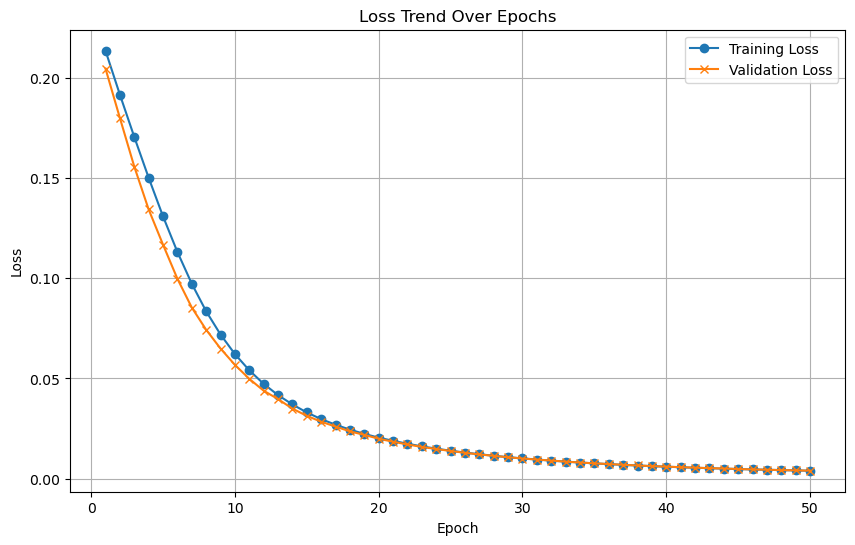

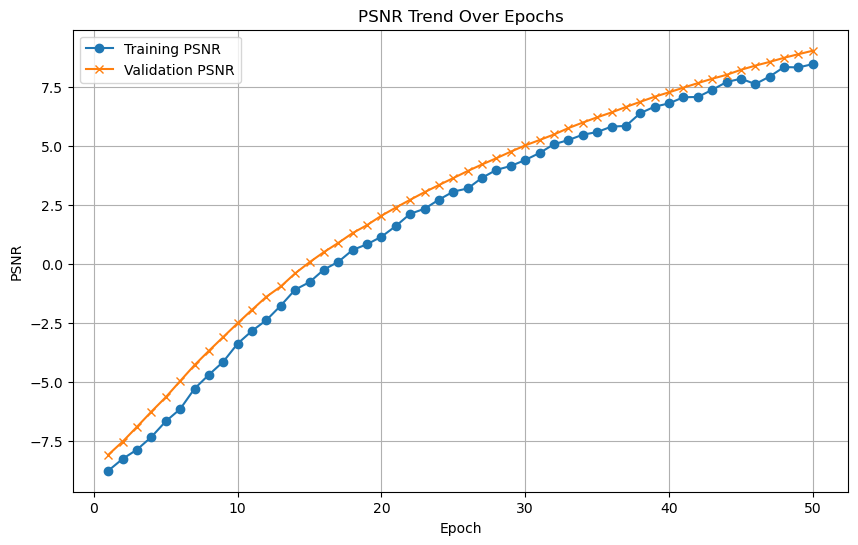

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/2 for train dataset.
    Processed batch 2/2 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/11 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training


Epoch [1/1000] completed, Average Training Loss: 2.6763
    Validation Batch [1/1], Loss: 2.6453
Validation Loss: 2.6453, Validation Accuracy: 7.14%
Validation loss improved from inf to 2.6453. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5928
    Validation Batch [1/1], Loss: 2.6453
Validation Loss: 2.6453, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5449
    Validation Batch [1/1], Loss: 2.6453
Validation Loss: 2.6453, Validation Accuracy: 7.14%
Validation loss improved from 2.6453 to 2.6453. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5126
    Validation Batch [1/1], Loss: 2.6451
Validation Loss: 2.6451, Validation Accuracy: 7.14%
Validation loss improved from 2.6453 to 2.6451. Saving model...

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Trai

    Validation Batch [1/1], Loss: 2.6442
Validation Loss: 2.6442, Validation Accuracy: 7.14%
Validation loss improved from 2.6443 to 2.6442. Saving model...

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 2.3676
    Validation Batch [1/1], Loss: 2.6441
Validation Loss: 2.6441, Validation Accuracy: 7.14%
Validation loss improved from 2.6442 to 2.6441. Saving model...

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.3529
    Validation Batch [1/1], Loss: 2.6442
Validation Loss: 2.6442, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 2.3308
    Validation Batch [1/1], Loss: 2.6441
Validation Loss: 2.6441, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [13/1000] - Training


Epoch [13/1000] completed, Average Training Loss: 2.3070
    Validation Batch [1/1], Loss: 2.6440
Validation Loss: 2.6440, Validation Accuracy: 7.14%
Validation loss improved from 2.6441 to 2.6440. Saving model...

LOG: Epoch [14/1000] - Training
Epoch [14/1000] completed, Average Training Loss: 2.2956
    Validation Batch [1/1], Loss: 2.6442
Validation Loss: 2.6442, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [15/1000] - Training
Epoch [15/1000] completed, Average Training Loss: 2.2745
    Validation Batch [1/1], Loss: 2.6442
Validation Loss: 2.6442, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [16/1000] - Training
Epoch [16/1000] completed, Average Training Loss: 2.2512
    Validation Batch [1/1], Loss: 2.6441
Validation Loss: 2.6441, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [17/1000] - Training
Epoch [17/1000] completed, Average Training Loss: 2.2366


Epoch [22/1000] completed, Average Training Loss: 2.1488
    Validation Batch [1/1], Loss: 2.6302
Validation Loss: 2.6302, Validation Accuracy: 14.29%
Validation loss improved from 2.6345 to 2.6302. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.1219
    Validation Batch [1/1], Loss: 2.6245
Validation Loss: 2.6245, Validation Accuracy: 14.29%
Validation loss improved from 2.6302 to 2.6245. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.1147
    Validation Batch [1/1], Loss: 2.6181
Validation Loss: 2.6181, Validation Accuracy: 14.29%
Validation loss improved from 2.6245 to 2.6181. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.0994
    Validation Batch [1/1], Loss: 2.6101
Validation Loss: 2.6101, Validation Accuracy: 14.29%
Validation loss improved from 2.6181 to 2.6101. Saving model...

LOG: Epoch [26/1000] - Training


Epoch [26/1000] completed, Average Training Loss: 2.0888
    Validation Batch [1/1], Loss: 2.6000
Validation Loss: 2.6000, Validation Accuracy: 14.29%
Validation loss improved from 2.6101 to 2.6000. Saving model...

LOG: Epoch [27/1000] - Training
Epoch [27/1000] completed, Average Training Loss: 2.0571
    Validation Batch [1/1], Loss: 2.5861
Validation Loss: 2.5861, Validation Accuracy: 14.29%
Validation loss improved from 2.6000 to 2.5861. Saving model...

LOG: Epoch [28/1000] - Training
Epoch [28/1000] completed, Average Training Loss: 2.0463
    Validation Batch [1/1], Loss: 2.5715
Validation Loss: 2.5715, Validation Accuracy: 14.29%
Validation loss improved from 2.5861 to 2.5715. Saving model...

LOG: Epoch [29/1000] - Training
Epoch [29/1000] completed, Average Training Loss: 2.0207
    Validation Batch [1/1], Loss: 2.5529
Validation Loss: 2.5529, Validation Accuracy: 14.29%
Validation loss improved from 2.5715 to 2.5529. Saving model...

LOG: Epoch [30/1000] - Training
Epoch [3

    Validation Batch [1/1], Loss: 2.3551
Validation Loss: 2.3551, Validation Accuracy: 28.57%
Validation loss improved from 2.3942 to 2.3551. Saving model...

LOG: Epoch [36/1000] - Training
Epoch [36/1000] completed, Average Training Loss: 1.8912
    Validation Batch [1/1], Loss: 2.3083
Validation Loss: 2.3083, Validation Accuracy: 34.29%
Validation loss improved from 2.3551 to 2.3083. Saving model...

LOG: Epoch [37/1000] - Training
Epoch [37/1000] completed, Average Training Loss: 1.8899
    Validation Batch [1/1], Loss: 2.2636
Validation Loss: 2.2636, Validation Accuracy: 42.86%
Validation loss improved from 2.3083 to 2.2636. Saving model...

LOG: Epoch [38/1000] - Training
Epoch [38/1000] completed, Average Training Loss: 1.8607
    Validation Batch [1/1], Loss: 2.2237
Validation Loss: 2.2237, Validation Accuracy: 47.14%
Validation loss improved from 2.2636 to 2.2237. Saving model...

LOG: Epoch [39/1000] - Training


Epoch [39/1000] completed, Average Training Loss: 1.8486
    Validation Batch [1/1], Loss: 2.1600
Validation Loss: 2.1600, Validation Accuracy: 65.71%
Validation loss improved from 2.2237 to 2.1600. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 1.8143
    Validation Batch [1/1], Loss: 2.1127
Validation Loss: 2.1127, Validation Accuracy: 67.14%
Validation loss improved from 2.1600 to 2.1127. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 1.7987
    Validation Batch [1/1], Loss: 2.0643
Validation Loss: 2.0643, Validation Accuracy: 65.71%
Validation loss improved from 2.1127 to 2.0643. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 1.7815
    Validation Batch [1/1], Loss: 1.9980
Validation Loss: 1.9980, Validation Accuracy: 74.29%
Validation loss improved from 2.0643 to 1.9980. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [4

Epoch [49/1000] completed, Average Training Loss: 1.6481
    Validation Batch [1/1], Loss: 1.7423
Validation Loss: 1.7423, Validation Accuracy: 87.14%
Validation loss improved from 1.7779 to 1.7423. Saving model...

LOG: Epoch [50/1000] - Training
Epoch [50/1000] completed, Average Training Loss: 1.6434
    Validation Batch [1/1], Loss: 1.7062
Validation Loss: 1.7062, Validation Accuracy: 92.86%
Validation loss improved from 1.7423 to 1.7062. Saving model...

LOG: Epoch [51/1000] - Training
Epoch [51/1000] completed, Average Training Loss: 1.6007
    Validation Batch [1/1], Loss: 1.6779
Validation Loss: 1.6779, Validation Accuracy: 91.43%
Validation loss improved from 1.7062 to 1.6779. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [52/1000] completed, Average Training Loss: 1.6153
    Validation Batch [1/1], Loss: 1.6549
Validation Loss: 1.6549, Validation Accuracy: 95.71%
Validation loss improved from 1.6779 to 1.6549. Saving model...

LOG: Epoch [53/1000] - Training


Epoch [53/1000] completed, Average Training Loss: 1.5575
    Validation Batch [1/1], Loss: 1.6425
Validation Loss: 1.6425, Validation Accuracy: 91.43%
Validation loss improved from 1.6549 to 1.6425. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 1.5473
    Validation Batch [1/1], Loss: 1.5876
Validation Loss: 1.5876, Validation Accuracy: 97.14%
Validation loss improved from 1.6425 to 1.5876. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [55/1000] completed, Average Training Loss: 1.5360
    Validation Batch [1/1], Loss: 1.5857
Validation Loss: 1.5857, Validation Accuracy: 95.71%
Validation loss improved from 1.5876 to 1.5857. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 1.4934
    Validation Batch [1/1], Loss: 1.5602
Validation Loss: 1.5602, Validation Accuracy: 97.14%
Validation loss improved from 1.5857 to 1.5602. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [5

Epoch [62/1000] completed, Average Training Loss: 1.3904
    Validation Batch [1/1], Loss: 1.4446
Validation Loss: 1.4446, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 1.3803
    Validation Batch [1/1], Loss: 1.3605
Validation Loss: 1.3605, Validation Accuracy: 97.14%
Validation loss improved from 1.4300 to 1.3605. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 1.3607
    Validation Batch [1/1], Loss: 1.3517
Validation Loss: 1.3517, Validation Accuracy: 100.00%
Validation loss improved from 1.3605 to 1.3517. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [65/1000] completed, Average Training Loss: 1.3374
    Validation Batch [1/1], Loss: 1.3380
Validation Loss: 1.3380, Validation Accuracy: 100.00%
Validation loss improved from 1.3517 to 1.3380. Saving model...

LOG: Epoch [66/1000] - Training


Epoch [66/1000] completed, Average Training Loss: 1.3028
    Validation Batch [1/1], Loss: 1.3064
Validation Loss: 1.3064, Validation Accuracy: 100.00%
Validation loss improved from 1.3380 to 1.3064. Saving model...

LOG: Epoch [67/1000] - Training
Epoch [67/1000] completed, Average Training Loss: 1.2868
    Validation Batch [1/1], Loss: 1.2938
Validation Loss: 1.2938, Validation Accuracy: 100.00%
Validation loss improved from 1.3064 to 1.2938. Saving model...

LOG: Epoch [68/1000] - Training
Epoch [68/1000] completed, Average Training Loss: 1.2899
    Validation Batch [1/1], Loss: 1.2706
Validation Loss: 1.2706, Validation Accuracy: 100.00%
Validation loss improved from 1.2938 to 1.2706. Saving model...

LOG: Epoch [69/1000] - Training
Epoch [69/1000] completed, Average Training Loss: 1.2556
    Validation Batch [1/1], Loss: 1.2377
Validation Loss: 1.2377, Validation Accuracy: 100.00%
Validation loss improved from 1.2706 to 1.2377. Saving model...

LOG: Epoch [70/1000] - Training
Epoc

    Validation Batch [1/1], Loss: 1.1477
Validation Loss: 1.1477, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [77/1000] - Training
Epoch [77/1000] completed, Average Training Loss: 1.1115
    Validation Batch [1/1], Loss: 1.0562
Validation Loss: 1.0562, Validation Accuracy: 98.57%
Validation loss improved from 1.1298 to 1.0562. Saving model...

LOG: Epoch [78/1000] - Training
Epoch [78/1000] completed, Average Training Loss: 1.0972
    Validation Batch [1/1], Loss: 1.0596
Validation Loss: 1.0596, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [79/1000] - Training


Epoch [79/1000] completed, Average Training Loss: 1.0778
    Validation Batch [1/1], Loss: 1.0670
Validation Loss: 1.0670, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [80/1000] - Training
Epoch [80/1000] completed, Average Training Loss: 1.0626
    Validation Batch [1/1], Loss: 1.0413
Validation Loss: 1.0413, Validation Accuracy: 100.00%
Validation loss improved from 1.0562 to 1.0413. Saving model...

LOG: Epoch [81/1000] - Training
Epoch [81/1000] completed, Average Training Loss: 1.0424
    Validation Batch [1/1], Loss: 1.0023
Validation Loss: 1.0023, Validation Accuracy: 100.00%
Validation loss improved from 1.0413 to 1.0023. Saving model...

LOG: Epoch [82/1000] - Training
Epoch [82/1000] completed, Average Training Loss: 1.0067
    Validation Batch [1/1], Loss: 0.9973
Validation Loss: 0.9973, Validation Accuracy: 100.00%
Validation loss improved from 1.0023 to 0.9973. Saving model...

LOG: Epoch [83/1000] - Training
Epoch [83/1000] com

    Validation Batch [1/1], Loss: 0.8504
Validation Loss: 0.8504, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [90/1000] - Training
Epoch [90/1000] completed, Average Training Loss: 0.9116
    Validation Batch [1/1], Loss: 0.8239
Validation Loss: 0.8239, Validation Accuracy: 100.00%
Validation loss improved from 0.8497 to 0.8239. Saving model...

LOG: Epoch [91/1000] - Training
Epoch [91/1000] completed, Average Training Loss: 0.8577
    Validation Batch [1/1], Loss: 0.8043
Validation Loss: 0.8043, Validation Accuracy: 98.57%
Validation loss improved from 0.8239 to 0.8043. Saving model...

LOG: Epoch [92/1000] - Training


Epoch [92/1000] completed, Average Training Loss: 0.8438
    Validation Batch [1/1], Loss: 0.7982
Validation Loss: 0.7982, Validation Accuracy: 100.00%
Validation loss improved from 0.8043 to 0.7982. Saving model...

LOG: Epoch [93/1000] - Training
Epoch [93/1000] completed, Average Training Loss: 0.8329
    Validation Batch [1/1], Loss: 0.7756
Validation Loss: 0.7756, Validation Accuracy: 100.00%
Validation loss improved from 0.7982 to 0.7756. Saving model...

LOG: Epoch [94/1000] - Training
Epoch [94/1000] completed, Average Training Loss: 0.8221
    Validation Batch [1/1], Loss: 0.7819
Validation Loss: 0.7819, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [95/1000] - Training
Epoch [95/1000] completed, Average Training Loss: 0.8081
    Validation Batch [1/1], Loss: 0.7748
Validation Loss: 0.7748, Validation Accuracy: 100.00%
Validation loss improved from 0.7756 to 0.7748. Saving model...

LOG: Epoch [96/1000] - Training
Epoch [96/1000] com

Epoch [103/1000] completed, Average Training Loss: 0.7177
    Validation Batch [1/1], Loss: 0.6462
Validation Loss: 0.6462, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [104/1000] - Training
Epoch [104/1000] completed, Average Training Loss: 0.6967
    Validation Batch [1/1], Loss: 0.6073
Validation Loss: 0.6073, Validation Accuracy: 100.00%
Validation loss improved from 0.6427 to 0.6073. Saving model...

LOG: Epoch [105/1000] - Training
Epoch [105/1000] completed, Average Training Loss: 0.6941
    Validation Batch [1/1], Loss: 0.6341
Validation Loss: 0.6341, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [106/1000] - Training


Epoch [106/1000] completed, Average Training Loss: 0.6805
    Validation Batch [1/1], Loss: 0.5997
Validation Loss: 0.5997, Validation Accuracy: 100.00%
Validation loss improved from 0.6073 to 0.5997. Saving model...

LOG: Epoch [107/1000] - Training
Epoch [107/1000] completed, Average Training Loss: 0.6496
    Validation Batch [1/1], Loss: 0.5728
Validation Loss: 0.5728, Validation Accuracy: 100.00%
Validation loss improved from 0.5997 to 0.5728. Saving model...

LOG: Epoch [108/1000] - Training
Epoch [108/1000] completed, Average Training Loss: 0.6575
    Validation Batch [1/1], Loss: 0.5619
Validation Loss: 0.5619, Validation Accuracy: 100.00%
Validation loss improved from 0.5728 to 0.5619. Saving model...

LOG: Epoch [109/1000] - Training
Epoch [109/1000] completed, Average Training Loss: 0.6126
    Validation Batch [1/1], Loss: 0.5550
Validation Loss: 0.5550, Validation Accuracy: 98.57%
Validation loss improved from 0.5619 to 0.5550. Saving model...

LOG: Epoch [110/1000] - Traini

Epoch [116/1000] completed, Average Training Loss: 0.5694
    Validation Batch [1/1], Loss: 0.4872
Validation Loss: 0.4872, Validation Accuracy: 100.00%
Validation loss improved from 0.4922 to 0.4872. Saving model...

LOG: Epoch [117/1000] - Training
Epoch [117/1000] completed, Average Training Loss: 0.5282
    Validation Batch [1/1], Loss: 0.4960
Validation Loss: 0.4960, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [118/1000] - Training
Epoch [118/1000] completed, Average Training Loss: 0.5366
    Validation Batch [1/1], Loss: 0.4819
Validation Loss: 0.4819, Validation Accuracy: 100.00%
Validation loss improved from 0.4872 to 0.4819. Saving model...

LOG: Epoch [119/1000] - Training
Epoch [119/1000] completed, Average Training Loss: 0.5262
    Validation Batch [1/1], Loss: 0.4658
Validation Loss: 0.4658, Validation Accuracy: 100.00%
Validation loss improved from 0.4819 to 0.4658. Saving model...

LOG: Epoch [120/1000] - Training
Epoch [120/

    Validation Batch [1/1], Loss: 0.4468
Validation Loss: 0.4468, Validation Accuracy: 100.00%
Validation loss improved from 0.4658 to 0.4468. Saving model...

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 0.5173
    Validation Batch [1/1], Loss: 0.4405
Validation Loss: 0.4405, Validation Accuracy: 100.00%
Validation loss improved from 0.4468 to 0.4405. Saving model...

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 0.4944
    Validation Batch [1/1], Loss: 0.4007
Validation Loss: 0.4007, Validation Accuracy: 100.00%
Validation loss improved from 0.4405 to 0.4007. Saving model...

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 0.4933
    Validation Batch [1/1], Loss: 0.4434
Validation Loss: 0.4434, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 0.4699
    Validati

Epoch [130/1000] completed, Average Training Loss: 0.4259
    Validation Batch [1/1], Loss: 0.3477
Validation Loss: 0.3477, Validation Accuracy: 100.00%
Validation loss improved from 0.3651 to 0.3477. Saving model...

LOG: Epoch [131/1000] - Training
Epoch [131/1000] completed, Average Training Loss: 0.4427
    Validation Batch [1/1], Loss: 0.3840
Validation Loss: 0.3840, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [132/1000] - Training
Epoch [132/1000] completed, Average Training Loss: 0.3987
    Validation Batch [1/1], Loss: 0.3179
Validation Loss: 0.3179, Validation Accuracy: 100.00%
Validation loss improved from 0.3477 to 0.3179. Saving model...

LOG: Epoch [133/1000] - Training
Epoch [133/1000] completed, Average Training Loss: 0.4150
    Validation Batch [1/1], Loss: 0.3107
Validation Loss: 0.3107, Validation Accuracy: 100.00%
Validation loss improved from 0.3179 to 0.3107. Saving model...

LOG: Epoch [134/1000] - Training


Epoch [134/1000] completed, Average Training Loss: 0.3812
    Validation Batch [1/1], Loss: 0.3308
Validation Loss: 0.3308, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [135/1000] - Training
Epoch [135/1000] completed, Average Training Loss: 0.3935
    Validation Batch [1/1], Loss: 0.3416
Validation Loss: 0.3416, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [136/1000] - Training
Epoch [136/1000] completed, Average Training Loss: 0.4042
    Validation Batch [1/1], Loss: 0.3302
Validation Loss: 0.3302, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [137/1000] - Training
Epoch [137/1000] completed, Average Training Loss: 0.3810
    Validation Batch [1/1], Loss: 0.2979
Validation Loss: 0.2979, Validation Accuracy: 100.00%
Validation loss improved from 0.3107 to 0.2979. Saving model...

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Train

Epoch [144/1000] completed, Average Training Loss: 0.3244
    Validation Batch [1/1], Loss: 0.2564
Validation Loss: 0.2564, Validation Accuracy: 100.00%
Validation loss improved from 0.2572 to 0.2564. Saving model...

LOG: Epoch [145/1000] - Training
Epoch [145/1000] completed, Average Training Loss: 0.3277
    Validation Batch [1/1], Loss: 0.2598
Validation Loss: 0.2598, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [146/1000] - Training
Epoch [146/1000] completed, Average Training Loss: 0.3250
    Validation Batch [1/1], Loss: 0.2443
Validation Loss: 0.2443, Validation Accuracy: 100.00%
Validation loss improved from 0.2564 to 0.2443. Saving model...

LOG: Epoch [147/1000] - Training
Epoch [147/1000] completed, Average Training Loss: 0.3272


    Validation Batch [1/1], Loss: 0.2320
Validation Loss: 0.2320, Validation Accuracy: 100.00%
Validation loss improved from 0.2443 to 0.2320. Saving model...

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 0.3057
    Validation Batch [1/1], Loss: 0.2359
Validation Loss: 0.2359, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Average Training Loss: 0.3112
    Validation Batch [1/1], Loss: 0.2361
Validation Loss: 0.2361, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [150/1000] - Training
Epoch [150/1000] completed, Average Training Loss: 0.2932
    Validation Batch [1/1], Loss: 0.2339
Validation Loss: 0.2339, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Average Training Loss: 0.3142
    Validation Batch [1/1], Loss: 0.2305


    Validation Batch [1/1], Loss: 0.2077
Validation Loss: 0.2077, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [158/1000] - Training
Epoch [158/1000] completed, Average Training Loss: 0.2621
    Validation Batch [1/1], Loss: 0.1984
Validation Loss: 0.1984, Validation Accuracy: 100.00%
Validation loss improved from 0.2034 to 0.1984. Saving model...

LOG: Epoch [159/1000] - Training
Epoch [159/1000] completed, Average Training Loss: 0.2658
    Validation Batch [1/1], Loss: 0.1855
Validation Loss: 0.1855, Validation Accuracy: 100.00%
Validation loss improved from 0.1984 to 0.1855. Saving model...

LOG: Epoch [160/1000] - Training
Epoch [160/1000] completed, Average Training Loss: 0.2663
    Validation Batch [1/1], Loss: 0.1759
Validation Loss: 0.1759, Validation Accuracy: 100.00%
Validation loss improved from 0.1855 to 0.1759. Saving model...

LOG: Epoch [161/1000] - Training


Epoch [161/1000] completed, Average Training Loss: 0.2535
    Validation Batch [1/1], Loss: 0.1922
Validation Loss: 0.1922, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [162/1000] - Training
Epoch [162/1000] completed, Average Training Loss: 0.2431
    Validation Batch [1/1], Loss: 0.1892
Validation Loss: 0.1892, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [163/1000] - Training
Epoch [163/1000] completed, Average Training Loss: 0.2561
    Validation Batch [1/1], Loss: 0.1890
Validation Loss: 0.1890, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [164/1000] - Training
Epoch [164/1000] completed, Average Training Loss: 0.2350
    Validation Batch [1/1], Loss: 0.1881
Validation Loss: 0.1881, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [165/1000] - Training
Epoch [165/1000] completed, Average Training Loss: 0.235

Epoch [171/1000] completed, Average Training Loss: 0.2211
    Validation Batch [1/1], Loss: 0.1605
Validation Loss: 0.1605, Validation Accuracy: 100.00%
Validation loss improved from 0.1724 to 0.1605. Saving model...

LOG: Epoch [172/1000] - Training
Epoch [172/1000] completed, Average Training Loss: 0.2122
    Validation Batch [1/1], Loss: 0.2014
Validation Loss: 0.2014, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [173/1000] - Training
Epoch [173/1000] completed, Average Training Loss: 0.2127
    Validation Batch [1/1], Loss: 0.1571
Validation Loss: 0.1571, Validation Accuracy: 100.00%
Validation loss improved from 0.1605 to 0.1571. Saving model...

LOG: Epoch [174/1000] - Training


Epoch [174/1000] completed, Average Training Loss: 0.2160
    Validation Batch [1/1], Loss: 0.1576
Validation Loss: 0.1576, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [175/1000] - Training
Epoch [175/1000] completed, Average Training Loss: 0.2108
    Validation Batch [1/1], Loss: 0.1625
Validation Loss: 0.1625, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [176/1000] - Training
Epoch [176/1000] completed, Average Training Loss: 0.2086
    Validation Batch [1/1], Loss: 0.1482
Validation Loss: 0.1482, Validation Accuracy: 100.00%
Validation loss improved from 0.1571 to 0.1482. Saving model...

LOG: Epoch [177/1000] - Training
Epoch [177/1000] completed, Average Training Loss: 0.1972
    Validation Batch [1/1], Loss: 0.1578
Validation Loss: 0.1578, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Average Train

Epoch [184/1000] completed, Average Training Loss: 0.1851
    Validation Batch [1/1], Loss: 0.1917
Validation Loss: 0.1917, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [185/1000] - Training
Epoch [185/1000] completed, Average Training Loss: 0.1738
    Validation Batch [1/1], Loss: 0.1470
Validation Loss: 0.1470, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [186/1000] - Training
Epoch [186/1000] completed, Average Training Loss: 0.1860
    Validation Batch [1/1], Loss: 0.1102
Validation Loss: 0.1102, Validation Accuracy: 100.00%
Validation loss improved from 0.1267 to 0.1102. Saving model...

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 0.1731
    Validation Batch [1/1], Loss: 0.1175
Validation Loss: 0.1175, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [188/1000] - Training


Epoch [188/1000] completed, Average Training Loss: 0.1617
    Validation Batch [1/1], Loss: 0.1098
Validation Loss: 0.1098, Validation Accuracy: 100.00%
Validation loss improved from 0.1102 to 0.1098. Saving model...

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 0.1669
    Validation Batch [1/1], Loss: 0.1372
Validation Loss: 0.1372, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training Loss: 0.1645
    Validation Batch [1/1], Loss: 0.1241
Validation Loss: 0.1241, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [191/1000] - Training
Epoch [191/1000] completed, Average Training Loss: 0.1605
    Validation Batch [1/1], Loss: 0.1107
Validation Loss: 0.1107, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [192/1000] - Training
Epoch [192/1000] completed, Average Traini

    Validation Batch [1/1], Loss: 0.0910
Validation Loss: 0.0910, Validation Accuracy: 100.00%
Validation loss improved from 0.0971 to 0.0910. Saving model...

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Average Training Loss: 0.1571
    Validation Batch [1/1], Loss: 0.0880
Validation Loss: 0.0880, Validation Accuracy: 100.00%
Validation loss improved from 0.0910 to 0.0880. Saving model...

LOG: Epoch [200/1000] - Training
Epoch [200/1000] completed, Average Training Loss: 0.1454
    Validation Batch [1/1], Loss: 0.0883
Validation Loss: 0.0883, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [201/1000] - Training
Epoch [201/1000] completed, Average Training Loss: 0.1395
    Validation Batch [1/1], Loss: 0.0916
Validation Loss: 0.0916, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [202/1000] - Training
Epoch [202/1000] completed, Average Training Loss: 0.1362
    Validation Batch [1/1]

Epoch [203/1000] completed, Average Training Loss: 0.1462
    Validation Batch [1/1], Loss: 0.0985
Validation Loss: 0.0985, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [204/1000] - Training
Epoch [204/1000] completed, Average Training Loss: 0.1439
    Validation Batch [1/1], Loss: 0.1113
Validation Loss: 0.1113, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [205/1000] - Training
Epoch [205/1000] completed, Average Training Loss: 0.1355
    Validation Batch [1/1], Loss: 0.0969
Validation Loss: 0.0969, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [206/1000] - Training


Epoch [206/1000] completed, Average Training Loss: 0.1309
    Validation Batch [1/1], Loss: 0.0880
Validation Loss: 0.0880, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [207/1000] - Training
Epoch [207/1000] completed, Average Training Loss: 0.1245
    Validation Batch [1/1], Loss: 0.1050
Validation Loss: 0.1050, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [208/1000] - Training
Epoch [208/1000] completed, Average Training Loss: 0.1277
    Validation Batch [1/1], Loss: 0.0900
Validation Loss: 0.0900, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [209/1000] - Training
Epoch [209/1000] completed, Average Training Loss: 0.1345
    Validation Batch [1/1], Loss: 0.0956
Validation Loss: 0.0956, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [210/1000] - Training


Epoch [210/1000] completed, Average Training Loss: 0.1271
    Validation Batch [1/1], Loss: 0.0976
Validation Loss: 0.0976, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 0.1366
    Validation Batch [1/1], Loss: 0.0817
Validation Loss: 0.0817, Validation Accuracy: 100.00%
Validation loss improved from 0.0880 to 0.0817. Saving model...

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training Loss: 0.1282
    Validation Batch [1/1], Loss: 0.0944
Validation Loss: 0.0944, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 0.1358
    Validation Batch [1/1], Loss: 0.0973
Validation Loss: 0.0973, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [214/1000] - Training
Epoch [214/1000] completed, Average Trai

    Validation Batch [1/1], Loss: 0.0791
Validation Loss: 0.0791, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [220/1000] - Training
Epoch [220/1000] completed, Average Training Loss: 0.1154
    Validation Batch [1/1], Loss: 0.0820
Validation Loss: 0.0820, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [221/1000] - Training
Epoch [221/1000] completed, Average Training Loss: 0.1088
    Validation Batch [1/1], Loss: 0.0717
Validation Loss: 0.0717, Validation Accuracy: 100.00%
Validation loss improved from 0.0752 to 0.0717. Saving model...

LOG: Epoch [222/1000] - Training
Epoch [222/1000] completed, Average Training Loss: 0.1178
    Validation Batch [1/1], Loss: 0.0851
Validation Loss: 0.0851, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [223/1000] - Training
Epoch [223/1000] completed, Average Training Loss: 0.1143
    Validation Batch [1/1], Loss: 0.0672


Epoch [224/1000] completed, Average Training Loss: 0.1117
    Validation Batch [1/1], Loss: 0.0691
Validation Loss: 0.0691, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [225/1000] - Training
Epoch [225/1000] completed, Average Training Loss: 0.1120
    Validation Batch [1/1], Loss: 0.0682
Validation Loss: 0.0682, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [226/1000] - Training
Epoch [226/1000] completed, Average Training Loss: 0.1131
    Validation Batch [1/1], Loss: 0.0688
Validation Loss: 0.0688, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [227/1000] - Training
Epoch [227/1000] completed, Average Training Loss: 0.1048
    Validation Batch [1/1], Loss: 0.0628
Validation Loss: 0.0628, Validation Accuracy: 100.00%
Validation loss improved from 0.0672 to 0.0628. Saving model...

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Average Train

Epoch [233/1000] completed, Average Training Loss: 0.0970
    Validation Batch [1/1], Loss: 0.0701
Validation Loss: 0.0701, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [234/1000] - Training
Epoch [234/1000] completed, Average Training Loss: 0.0975
    Validation Batch [1/1], Loss: 0.0909
Validation Loss: 0.0909, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [235/1000] - Training
Epoch [235/1000] completed, Average Training Loss: 0.0939
    Validation Batch [1/1], Loss: 0.0783
Validation Loss: 0.0783, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [236/1000] - Training
Epoch [236/1000] completed, Average Training Loss: 0.0936
    Validation Batch [1/1], Loss: 0.0757
Validation Loss: 0.0757, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [237/1000] - Training
Epoch [237/1000] completed, Average Training Loss: 0.0934

    Validation Batch [1/1], Loss: 0.0766
Validation Loss: 0.0766, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [238/1000] - Training
Epoch [238/1000] completed, Average Training Loss: 0.0982
    Validation Batch [1/1], Loss: 0.1272
Validation Loss: 0.1272, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [239/1000] - Training
Epoch [239/1000] completed, Average Training Loss: 0.0981
    Validation Batch [1/1], Loss: 0.0688
Validation Loss: 0.0688, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [240/1000] - Training
Epoch [240/1000] completed, Average Training Loss: 0.0856
    Validation Batch [1/1], Loss: 0.0647
Validation Loss: 0.0647, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [241/1000] - Training
Epoch [241/1000] completed, Average Training Loss: 0.0876
    Validation Batch [1/1], Loss: 0.0654
Validation Los

Epoch [246/1000] completed, Average Training Loss: 0.0881
    Validation Batch [1/1], Loss: 0.1060
Validation Loss: 0.1060, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [247/1000] - Training
Epoch [247/1000] completed, Average Training Loss: 0.0926
    Validation Batch [1/1], Loss: 0.0543
Validation Loss: 0.0543, Validation Accuracy: 100.00%
Validation loss improved from 0.0558 to 0.0543. Saving model...

LOG: Epoch [248/1000] - Training
Epoch [248/1000] completed, Average Training Loss: 0.0924
    Validation Batch [1/1], Loss: 0.1070
Validation Loss: 0.1070, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [249/1000] - Training
Epoch [249/1000] completed, Average Training Loss: 0.0833
    Validation Batch [1/1], Loss: 0.0579
Validation Loss: 0.0579, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Trainin

Epoch [251/1000] completed, Average Training Loss: 0.0838
    Validation Batch [1/1], Loss: 0.0548
Validation Loss: 0.0548, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [252/1000] - Training
Epoch [252/1000] completed, Average Training Loss: 0.0834
    Validation Batch [1/1], Loss: 0.0495
Validation Loss: 0.0495, Validation Accuracy: 100.00%
Validation loss improved from 0.0543 to 0.0495. Saving model...

LOG: Epoch [253/1000] - Training
Epoch [253/1000] completed, Average Training Loss: 0.0871
    Validation Batch [1/1], Loss: 0.0639
Validation Loss: 0.0639, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [254/1000] - Training
Epoch [254/1000] completed, Average Training Loss: 0.0829
    Validation Batch [1/1], Loss: 0.0731
Validation Loss: 0.0731, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [255/1000] - Training
Epoch [255/1000] completed, Average Train

Epoch [259/1000] completed, Average Training Loss: 0.0832
    Validation Batch [1/1], Loss: 0.0517
Validation Loss: 0.0517, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.0811
    Validation Batch [1/1], Loss: 0.0722
Validation Loss: 0.0722, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Average Training Loss: 0.0687
    Validation Batch [1/1], Loss: 0.0744
Validation Loss: 0.0744, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [262/1000] - Training
Epoch [262/1000] completed, Average Training Loss: 0.0803
    Validation Batch [1/1], Loss: 0.0409
Validation Loss: 0.0409, Validation Accuracy: 100.00%
Validation loss improved from 0.0457 to 0.0409. Saving model...

LOG: Epoch [263/1000] - Training
Epoch [263/1000] completed, Average Traini

Epoch [264/1000] completed, Average Training Loss: 0.0703
    Validation Batch [1/1], Loss: 0.0558
Validation Loss: 0.0558, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [265/1000] - Training
Epoch [265/1000] completed, Average Training Loss: 0.0757
    Validation Batch [1/1], Loss: 0.0395
Validation Loss: 0.0395, Validation Accuracy: 100.00%
Validation loss improved from 0.0409 to 0.0395. Saving model...

LOG: Epoch [266/1000] - Training
Epoch [266/1000] completed, Average Training Loss: 0.0656
    Validation Batch [1/1], Loss: 0.0910
Validation Loss: 0.0910, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [267/1000] - Training
Epoch [267/1000] completed, Average Training Loss: 0.0711
    Validation Batch [1/1], Loss: 0.0381
Validation Loss: 0.0381, Validation Accuracy: 100.00%
Validation loss improved from 0.0395 to 0.0381. Saving model...

LOG: Epoch [268/1000] - Training
Epoch [268/1000] completed,

    Validation Batch [1/1], Loss: 0.0404
Validation Loss: 0.0404, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [273/1000] - Training
Epoch [273/1000] completed, Average Training Loss: 0.0712
    Validation Batch [1/1], Loss: 0.0394
Validation Loss: 0.0394, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [274/1000] - Training
Epoch [274/1000] completed, Average Training Loss: 0.0654
    Validation Batch [1/1], Loss: 0.0630
Validation Loss: 0.0630, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [275/1000] - Training
Epoch [275/1000] completed, Average Training Loss: 0.0661
    Validation Batch [1/1], Loss: 0.0602
Validation Loss: 0.0602, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [276/1000] - Training
Epoch [276/1000] completed, Average Training Loss: 0.0609
    Validation Batch [1/1], Loss: 0.0410
Validation Loss: 

Epoch [277/1000] completed, Average Training Loss: 0.0653
    Validation Batch [1/1], Loss: 0.0367
Validation Loss: 0.0367, Validation Accuracy: 100.00%
Validation loss improved from 0.0381 to 0.0367. Saving model...

LOG: Epoch [278/1000] - Training
Epoch [278/1000] completed, Average Training Loss: 0.0664
    Validation Batch [1/1], Loss: 0.0420
Validation Loss: 0.0420, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.0668
    Validation Batch [1/1], Loss: 0.0504
Validation Loss: 0.0504, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.0688
    Validation Batch [1/1], Loss: 0.0537
Validation Loss: 0.0537, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Traini

Epoch [285/1000] completed, Average Training Loss: 0.0555
    Validation Batch [1/1], Loss: 0.0379
Validation Loss: 0.0379, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [286/1000] - Training
Epoch [286/1000] completed, Average Training Loss: 0.0590
    Validation Batch [1/1], Loss: 0.0435
Validation Loss: 0.0435, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [287/1000] - Training
Epoch [287/1000] completed, Average Training Loss: 0.0547
    Validation Batch [1/1], Loss: 0.0568
Validation Loss: 0.0568, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [288/1000] - Training
Epoch [288/1000] completed, Average Training Loss: 0.0584
    Validation Batch [1/1], Loss: 0.0392
Validation Loss: 0.0392, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [289/1000] - Training
Epoch [289/1000] completed, Average Training Loss: 0.062

Epoch [292/1000] completed, Average Training Loss: 0.0518
    Validation Batch [1/1], Loss: 0.0374
Validation Loss: 0.0374, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [293/1000] - Training
Epoch [293/1000] completed, Average Training Loss: 0.0541
    Validation Batch [1/1], Loss: 0.0324
Validation Loss: 0.0324, Validation Accuracy: 100.00%
Validation loss improved from 0.0357 to 0.0324. Saving model...

LOG: Epoch [294/1000] - Training
Epoch [294/1000] completed, Average Training Loss: 0.0515
    Validation Batch [1/1], Loss: 0.0543
Validation Loss: 0.0543, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [295/1000] - Training
Epoch [295/1000] completed, Average Training Loss: 0.0581
    Validation Batch [1/1], Loss: 0.0388
Validation Loss: 0.0388, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [296/1000] - Training
Epoch [296/1000] completed, Average Train

Epoch [299/1000] completed, Average Training Loss: 0.0508
    Validation Batch [1/1], Loss: 0.0580
Validation Loss: 0.0580, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [300/1000] - Training
Epoch [300/1000] completed, Average Training Loss: 0.0565
    Validation Batch [1/1], Loss: 0.0280
Validation Loss: 0.0280, Validation Accuracy: 100.00%
Validation loss improved from 0.0296 to 0.0280. Saving model...

LOG: Epoch [301/1000] - Training
Epoch [301/1000] completed, Average Training Loss: 0.0515
    Validation Batch [1/1], Loss: 0.0300
Validation Loss: 0.0300, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.0526
    Validation Batch [1/1], Loss: 0.0324
Validation Loss: 0.0324, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Train

    Validation Batch [1/1], Loss: 0.0344
Validation Loss: 0.0344, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.0420
    Validation Batch [1/1], Loss: 0.0283
Validation Loss: 0.0283, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [306/1000] - Training
Epoch [306/1000] completed, Average Training Loss: 0.0514
    Validation Batch [1/1], Loss: 0.0263
Validation Loss: 0.0263, Validation Accuracy: 100.00%
Validation loss improved from 0.0280 to 0.0263. Saving model...

LOG: Epoch [307/1000] - Training
Epoch [307/1000] completed, Average Training Loss: 0.0473
    Validation Batch [1/1], Loss: 0.0275
Validation Loss: 0.0275, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.0510
    Validation Batch [1/1], Loss: 0.0267


Epoch [313/1000] completed, Average Training Loss: 0.0432
    Validation Batch [1/1], Loss: 0.0270
Validation Loss: 0.0270, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.0517
    Validation Batch [1/1], Loss: 0.0273
Validation Loss: 0.0273, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.0441
    Validation Batch [1/1], Loss: 0.0238
Validation Loss: 0.0238, Validation Accuracy: 100.00%
Validation loss improved from 0.0263 to 0.0238. Saving model...

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.0458
    Validation Batch [1/1], Loss: 0.0263
Validation Loss: 0.0263, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [317/1000] - Training
Epoch [317/1000] completed, Average Train

Epoch [318/1000] completed, Average Training Loss: 0.0499
    Validation Batch [1/1], Loss: 0.0402
Validation Loss: 0.0402, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [319/1000] - Training
Epoch [319/1000] completed, Average Training Loss: 0.0465
    Validation Batch [1/1], Loss: 0.0413
Validation Loss: 0.0413, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [320/1000] - Training
Epoch [320/1000] completed, Average Training Loss: 0.0433
    Validation Batch [1/1], Loss: 0.0390
Validation Loss: 0.0390, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [321/1000] - Training
Epoch [321/1000] completed, Average Training Loss: 0.0441
    Validation Batch [1/1], Loss: 0.0376
Validation Loss: 0.0376, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [322/1000] - Training
Epoch [322/1000] completed, Average Training Loss: 0.044

Epoch [327/1000] completed, Average Training Loss: 0.0424
    Validation Batch [1/1], Loss: 0.0358
Validation Loss: 0.0358, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [328/1000] - Training
Epoch [328/1000] completed, Average Training Loss: 0.0449
    Validation Batch [1/1], Loss: 0.1451
Validation Loss: 0.1451, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [329/1000] - Training
Epoch [329/1000] completed, Average Training Loss: 0.0426
    Validation Batch [1/1], Loss: 0.0439
Validation Loss: 0.0439, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [330/1000] - Training
Epoch [330/1000] completed, Average Training Loss: 0.0420
    Validation Batch [1/1], Loss: 0.1744
Validation Loss: 0.1744, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [331/1000] - Training


Epoch [331/1000] completed, Average Training Loss: 0.0427
    Validation Batch [1/1], Loss: 0.1808
Validation Loss: 0.1808, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.0444
    Validation Batch [1/1], Loss: 0.0306
Validation Loss: 0.0306, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training Loss: 0.0445
    Validation Batch [1/1], Loss: 0.0444
Validation Loss: 0.0444, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.0419
    Validation Batch [1/1], Loss: 0.0359
Validation Loss: 0.0359, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [335/1000] - Training
Epoch [335/1000] completed, Average Training Loss: 0.03

Epoch [341/1000] completed, Average Training Loss: 0.0384
    Validation Batch [1/1], Loss: 0.1180
Validation Loss: 0.1180, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Training Loss: 0.0426
    Validation Batch [1/1], Loss: 0.0208
Validation Loss: 0.0208, Validation Accuracy: 100.00%
Validation loss improved from 0.0211 to 0.0208. Saving model...

LOG: Epoch [343/1000] - Training
Epoch [343/1000] completed, Average Training Loss: 0.0386
    Validation Batch [1/1], Loss: 0.0222
Validation Loss: 0.0222, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [344/1000] - Training


Epoch [344/1000] completed, Average Training Loss: 0.0361
    Validation Batch [1/1], Loss: 0.0258
Validation Loss: 0.0258, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [345/1000] - Training
Epoch [345/1000] completed, Average Training Loss: 0.0368
    Validation Batch [1/1], Loss: 0.0216
Validation Loss: 0.0216, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [346/1000] - Training
Epoch [346/1000] completed, Average Training Loss: 0.0401
    Validation Batch [1/1], Loss: 0.0220
Validation Loss: 0.0220, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [347/1000] - Training
Epoch [347/1000] completed, Average Training Loss: 0.0374
    Validation Batch [1/1], Loss: 0.0480
Validation Loss: 0.0480, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [348/1000] - Training
Epoch [348/1000] completed, Average Training Loss: 0.0344

Epoch [355/1000] completed, Average Training Loss: 0.0345
    Validation Batch [1/1], Loss: 0.0183
Validation Loss: 0.0183, Validation Accuracy: 100.00%
Validation loss improved from 0.0208 to 0.0183. Saving model...

LOG: Epoch [356/1000] - Training
Epoch [356/1000] completed, Average Training Loss: 0.0369
    Validation Batch [1/1], Loss: 0.0203
Validation Loss: 0.0203, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [357/1000] - Training
Epoch [357/1000] completed, Average Training Loss: 0.0345


    Validation Batch [1/1], Loss: 0.0198
Validation Loss: 0.0198, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [358/1000] - Training
Epoch [358/1000] completed, Average Training Loss: 0.0332
    Validation Batch [1/1], Loss: 0.0361
Validation Loss: 0.0361, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [359/1000] - Training
Epoch [359/1000] completed, Average Training Loss: 0.0314
    Validation Batch [1/1], Loss: 0.0426
Validation Loss: 0.0426, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [360/1000] - Training
Epoch [360/1000] completed, Average Training Loss: 0.0387
    Validation Batch [1/1], Loss: 0.0231
Validation Loss: 0.0231, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [361/1000] - Training
Epoch [361/1000] completed, Average Training Loss: 0.0390
    Validation Batch [1/1], Loss: 0.1128
Validation Loss: 

Epoch [369/1000] completed, Average Training Loss: 0.0334


    Validation Batch [1/1], Loss: 0.0199
Validation Loss: 0.0199, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [370/1000] - Training
Epoch [370/1000] completed, Average Training Loss: 0.0339
    Validation Batch [1/1], Loss: 0.0235
Validation Loss: 0.0235, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [371/1000] - Training
Epoch [371/1000] completed, Average Training Loss: 0.0315
    Validation Batch [1/1], Loss: 0.0225
Validation Loss: 0.0225, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [372/1000] - Training
Epoch [372/1000] completed, Average Training Loss: 0.0372
    Validation Batch [1/1], Loss: 0.0193
Validation Loss: 0.0193, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [373/1000] - Training
Epoch [373/1000] completed, Average Training Loss: 0.0299
    Validation Batch [1/1], Loss: 0.0185
Validation Loss

Epoch [383/1000] completed, Average Training Loss: 0.0310
    Validation Batch [1/1], Loss: 0.0193
Validation Loss: 0.0193, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [384/1000] - Training
Epoch [384/1000] completed, Average Training Loss: 0.0318
    Validation Batch [1/1], Loss: 0.0157
Validation Loss: 0.0157, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [385/1000] - Training
Epoch [385/1000] completed, Average Training Loss: 0.0319
    Validation Batch [1/1], Loss: 0.0254
Validation Loss: 0.0254, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [386/1000] - Training
Epoch [386/1000] completed, Average Training Loss: 0.0265
    Validation Batch [1/1], Loss: 0.0359
Validation Loss: 0.0359, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [387/1000] - Training
Epoch [387/1000] completed, Average Training Loss: 0.025

Epoch [397/1000] completed, Average Training Loss: 0.0300
    Validation Batch [1/1], Loss: 0.0267
Validation Loss: 0.0267, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [398/1000] - Training
Epoch [398/1000] completed, Average Training Loss: 0.0254
    Validation Batch [1/1], Loss: 0.0182
Validation Loss: 0.0182, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.0254
    Validation Batch [1/1], Loss: 0.0130
Validation Loss: 0.0130, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.0297
    Validation Batch [1/1], Loss: 0.0170
Validation Loss: 0.0170, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.0275

Epoch [410/1000] completed, Average Training Loss: 0.0242
    Validation Batch [1/1], Loss: 0.0152
Validation Loss: 0.0152, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [411/1000] - Training
Epoch [411/1000] completed, Average Training Loss: 0.0259
    Validation Batch [1/1], Loss: 0.0164
Validation Loss: 0.0164, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [412/1000] - Training
Epoch [412/1000] completed, Average Training Loss: 0.0242
    Validation Batch [1/1], Loss: 0.0205
Validation Loss: 0.0205, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [413/1000] - Training
Epoch [413/1000] completed, Average Training Loss: 0.0288
    Validation Batch [1/1], Loss: 0.0125
Validation Loss: 0.0125, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [414/1000] - Training
Epoch [414/1000] completed, Average Training Loss: 0.024

Epoch [424/1000] completed, Average Training Loss: 0.0236
    Validation Batch [1/1], Loss: 0.0151
Validation Loss: 0.0151, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.0247
    Validation Batch [1/1], Loss: 0.0099
Validation Loss: 0.0099, Validation Accuracy: 100.00%
Validation loss improved from 0.0102 to 0.0099. Saving model...

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.0264
    Validation Batch [1/1], Loss: 0.0350
Validation Loss: 0.0350, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [427/1000] - Training
Epoch [427/1000] completed, Average Training Loss: 0.0223
    Validation Batch [1/1], Loss: 0.0683
Validation Loss: 0.0683, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [428/1000] - Training
Epoch [428/1000] completed, Average Trainin

Epoch [437/1000] completed, Average Training Loss: 0.0216
    Validation Batch [1/1], Loss: 0.0123
Validation Loss: 0.0123, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [438/1000] - Training
Epoch [438/1000] completed, Average Training Loss: 0.0246
    Validation Batch [1/1], Loss: 0.0095
Validation Loss: 0.0095, Validation Accuracy: 100.00%
Validation loss improved from 0.0099 to 0.0095. Saving model...

LOG: Epoch [439/1000] - Training
Epoch [439/1000] completed, Average Training Loss: 0.0230
    Validation Batch [1/1], Loss: 0.0173
Validation Loss: 0.0173, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [440/1000] - Training
Epoch [440/1000] completed, Average Training Loss: 0.0217
    Validation Batch [1/1], Loss: 0.0417
Validation Loss: 0.0417, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [441/1000] - Training
Epoch [441/1000] completed, Average Train

Epoch [450/1000] completed, Average Training Loss: 0.0200
    Validation Batch [1/1], Loss: 0.0275
Validation Loss: 0.0275, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [451/1000] - Training
Epoch [451/1000] completed, Average Training Loss: 0.0198
    Validation Batch [1/1], Loss: 0.0230
Validation Loss: 0.0230, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [452/1000] - Training
Epoch [452/1000] completed, Average Training Loss: 0.0249
    Validation Batch [1/1], Loss: 0.0088
Validation Loss: 0.0088, Validation Accuracy: 100.00%
Validation loss improved from 0.0095 to 0.0088. Saving model...

LOG: Epoch [453/1000] - Training
Epoch [453/1000] completed, Average Training Loss: 0.0223
    Validation Batch [1/1], Loss: 0.0089
Validation Loss: 0.0089, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [454/1000] - Training
Epoch [454/1000] completed, Average Train

Epoch [463/1000] completed, Average Training Loss: 0.0245
    Validation Batch [1/1], Loss: 0.0135
Validation Loss: 0.0135, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [464/1000] - Training
Epoch [464/1000] completed, Average Training Loss: 0.0197
    Validation Batch [1/1], Loss: 0.0105
Validation Loss: 0.0105, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [465/1000] - Training
Epoch [465/1000] completed, Average Training Loss: 0.0183
    Validation Batch [1/1], Loss: 0.0085
Validation Loss: 0.0085, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [466/1000] - Training
Epoch [466/1000] completed, Average Training Loss: 0.0195
    Validation Batch [1/1], Loss: 0.0108
Validation Loss: 0.0108, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [467/1000] - Training
Epoch [467/1000] completed, Average Training Loss: 0.

Epoch [477/1000] completed, Average Training Loss: 0.0204
    Validation Batch [1/1], Loss: 0.0095
Validation Loss: 0.0095, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [478/1000] - Training
Epoch [478/1000] completed, Average Training Loss: 0.0182
    Validation Batch [1/1], Loss: 0.0079
Validation Loss: 0.0079, Validation Accuracy: 100.00%
Validation loss improved from 0.0082 to 0.0079. Saving model...

LOG: Epoch [479/1000] - Training
Epoch [479/1000] completed, Average Training Loss: 0.0174
    Validation Batch [1/1], Loss: 0.0094
Validation Loss: 0.0094, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [480/1000] - Training
Epoch [480/1000] completed, Average Training Loss: 0.0166
    Validation Batch [1/1], Loss: 0.0084
Validation Loss: 0.0084, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [481/1000] - Training
Epoch [481/1000] completed, Average Trai

Epoch [490/1000] completed, Average Training Loss: 0.0165
    Validation Batch [1/1], Loss: 0.0072
Validation Loss: 0.0072, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [491/1000] - Training
Epoch [491/1000] completed, Average Training Loss: 0.0166
    Validation Batch [1/1], Loss: 0.0144
Validation Loss: 0.0144, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [492/1000] - Training
Epoch [492/1000] completed, Average Training Loss: 0.0169
    Validation Batch [1/1], Loss: 0.0213
Validation Loss: 0.0213, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.0154
    Validation Batch [1/1], Loss: 0.0251
Validation Loss: 0.0251, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.0159


Epoch [504/1000] completed, Average Training Loss: 0.0156
    Validation Batch [1/1], Loss: 0.0172
Validation Loss: 0.0172, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [505/1000] - Training
Epoch [505/1000] completed, Average Training Loss: 0.0171
    Validation Batch [1/1], Loss: 0.0100
Validation Loss: 0.0100, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [506/1000] - Training
Epoch [506/1000] completed, Average Training Loss: 0.0133
    Validation Batch [1/1], Loss: 0.0089
Validation Loss: 0.0089, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [507/1000] - Training
Epoch [507/1000] completed, Average Training Loss: 0.0162
    Validation Batch [1/1], Loss: 0.0153
Validation Loss: 0.0153, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [508/1000] - Training
Epoch [508/1000] completed, Average Training Loss: 0

Epoch [517/1000] completed, Average Training Loss: 0.0125
    Validation Batch [1/1], Loss: 0.0142
Validation Loss: 0.0142, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [518/1000] - Training
Epoch [518/1000] completed, Average Training Loss: 0.0174
    Validation Batch [1/1], Loss: 0.0096
Validation Loss: 0.0096, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [519/1000] - Training
Epoch [519/1000] completed, Average Training Loss: 0.0141
    Validation Batch [1/1], Loss: 0.0081
Validation Loss: 0.0081, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [520/1000] - Training
Epoch [520/1000] completed, Average Training Loss: 0.0149
    Validation Batch [1/1], Loss: 0.0073
Validation Loss: 0.0073, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [521/1000] - Training
Epoch [521/1000] completed, Average Training Loss: 0.015

Epoch [531/1000] completed, Average Training Loss: 0.0160
    Validation Batch [1/1], Loss: 0.0119
Validation Loss: 0.0119, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [532/1000] - Training
Epoch [532/1000] completed, Average Training Loss: 0.0162
    Validation Batch [1/1], Loss: 0.0326
Validation Loss: 0.0326, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [533/1000] - Training
Epoch [533/1000] completed, Average Training Loss: 0.0192
    Validation Batch [1/1], Loss: 0.0336
Validation Loss: 0.0336, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [534/1000] - Training
Epoch [534/1000] completed, Average Training Loss: 0.0153
    Validation Batch [1/1], Loss: 0.0241
Validation Loss: 0.0241, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [535/1000] - Training
Epoch [535/1000] completed, Average Training Loss: 0.0116
 

Epoch [544/1000] completed, Average Training Loss: 0.0135
    Validation Batch [1/1], Loss: 0.0132
Validation Loss: 0.0132, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [545/1000] - Training
Epoch [545/1000] completed, Average Training Loss: 0.0142
    Validation Batch [1/1], Loss: 0.0118
Validation Loss: 0.0118, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [546/1000] - Training
Epoch [546/1000] completed, Average Training Loss: 0.0111
    Validation Batch [1/1], Loss: 0.0143
Validation Loss: 0.0143, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [547/1000] - Training
Epoch [547/1000] completed, Average Training Loss: 0.0124
    Validation Batch [1/1], Loss: 0.0064
Validation Loss: 0.0064, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [548/1000] - Training
Epoch [548/1000] completed, Average Training Loss: 0

Epoch [558/1000] completed, Average Training Loss: 0.0132
    Validation Batch [1/1], Loss: 0.0099
Validation Loss: 0.0099, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [559/1000] - Training
Epoch [559/1000] completed, Average Training Loss: 0.0132
    Validation Batch [1/1], Loss: 0.0073
Validation Loss: 0.0073, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [560/1000] - Training
Epoch [560/1000] completed, Average Training Loss: 0.0122
    Validation Batch [1/1], Loss: 0.0100
Validation Loss: 0.0100, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [561/1000] - Training
Epoch [561/1000] completed, Average Training Loss: 0.0136
    Validation Batch [1/1], Loss: 0.0055
Validation Loss: 0.0055, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [562/1000] - Training
Epoch [562/1000] completed, Average Training Loss: 0

Epoch [572/1000] completed, Average Training Loss: 0.0107
    Validation Batch [1/1], Loss: 0.0053
Validation Loss: 0.0053, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [573/1000] - Training
Epoch [573/1000] completed, Average Training Loss: 0.0118
    Validation Batch [1/1], Loss: 0.0062
Validation Loss: 0.0062, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [574/1000] - Training
Epoch [574/1000] completed, Average Training Loss: 0.0129
    Validation Batch [1/1], Loss: 0.0071
Validation Loss: 0.0071, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [575/1000] - Training
Epoch [575/1000] completed, Average Training Loss: 0.0126
    Validation Batch [1/1], Loss: 0.0085
Validation Loss: 0.0085, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [576/1000] - Training
Epoch [576/1000] completed, Average Training Loss: 0

    Validation Batch [1/1], Loss: 0.0069
Validation Loss: 0.0069, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [586/1000] - Training
Epoch [586/1000] completed, Average Training Loss: 0.0166
    Validation Batch [1/1], Loss: 0.0070
Validation Loss: 0.0070, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [587/1000] - Training
Epoch [587/1000] completed, Average Training Loss: 0.0112
    Validation Batch [1/1], Loss: 0.0069
Validation Loss: 0.0069, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [588/1000] - Training
Epoch [588/1000] completed, Average Training Loss: 0.0131
    Validation Batch [1/1], Loss: 0.0056
Validation Loss: 0.0056, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [589/1000] - Training
Epoch [589/1000] completed, Average Training Loss: 0.0137
    Validation Batch [1/1], Loss: 0.0126
Validation 

    Validation Batch [1/1], Loss: 0.0088
Validation Loss: 0.0088, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [599/1000] - Training
Epoch [599/1000] completed, Average Training Loss: 0.0111
    Validation Batch [1/1], Loss: 0.0064
Validation Loss: 0.0064, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [600/1000] - Training
Epoch [600/1000] completed, Average Training Loss: 0.0118
    Validation Batch [1/1], Loss: 0.0269
Validation Loss: 0.0269, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [601/1000] - Training
Epoch [601/1000] completed, Average Training Loss: 0.0119
    Validation Batch [1/1], Loss: 0.1120
Validation Loss: 0.1120, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [602/1000] - Training
Epoch [602/1000] completed, Average Training Loss: 0.0124
    Validation Batch [1/1], Loss: 0.0314
Validation L

Epoch [612/1000] completed, Average Training Loss: 0.0118
    Validation Batch [1/1], Loss: 0.0060
Validation Loss: 0.0060, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [613/1000] - Training
Epoch [613/1000] completed, Average Training Loss: 0.0127
    Validation Batch [1/1], Loss: 0.0051
Validation Loss: 0.0051, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [614/1000] - Training
Epoch [614/1000] completed, Average Training Loss: 0.0124
    Validation Batch [1/1], Loss: 0.0056
Validation Loss: 0.0056, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [615/1000] - Training
Epoch [615/1000] completed, Average Training Loss: 0.0124
    Validation Batch [1/1], Loss: 0.0093
Validation Loss: 0.0093, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [616/1000] - Training
Epoch [616/1000] completed, Average Training Loss: 0.0

Epoch [625/1000] completed, Average Training Loss: 0.0107
    Validation Batch [1/1], Loss: 0.0082
Validation Loss: 0.0082, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [626/1000] - Training
Epoch [626/1000] completed, Average Training Loss: 0.0096
    Validation Batch [1/1], Loss: 0.0127
Validation Loss: 0.0127, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [627/1000] - Training
Epoch [627/1000] completed, Average Training Loss: 0.0102
    Validation Batch [1/1], Loss: 0.0047
Validation Loss: 0.0047, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [628/1000] - Training
Epoch [628/1000] completed, Average Training Loss: 0.0124
    Validation Batch [1/1], Loss: 0.0147
Validation Loss: 0.0147, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [629/1000] - Training
Epoch [629/1000] completed, Average Training Loss: 0.010

Epoch [639/1000] completed, Average Training Loss: 0.0093
    Validation Batch [1/1], Loss: 0.0046
Validation Loss: 0.0046, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [640/1000] - Training
Epoch [640/1000] completed, Average Training Loss: 0.0118
    Validation Batch [1/1], Loss: 0.0147
Validation Loss: 0.0147, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [641/1000] - Training
Epoch [641/1000] completed, Average Training Loss: 0.0118
    Validation Batch [1/1], Loss: 0.0183
Validation Loss: 0.0183, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [642/1000] - Training
Epoch [642/1000] completed, Average Training Loss: 0.0102
    Validation Batch [1/1], Loss: 0.0090
Validation Loss: 0.0090, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [643/1000] - Training
Epoch [643/1000] completed, Average Training Loss: 0.009

Epoch [653/1000] completed, Average Training Loss: 0.0081
    Validation Batch [1/1], Loss: 0.0042
Validation Loss: 0.0042, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [654/1000] - Training
Epoch [654/1000] completed, Average Training Loss: 0.0080
    Validation Batch [1/1], Loss: 0.0031
Validation Loss: 0.0031, Validation Accuracy: 100.00%
Validation loss improved from 0.0035 to 0.0031. Saving model...

LOG: Epoch [655/1000] - Training
Epoch [655/1000] completed, Average Training Loss: 0.0098
    Validation Batch [1/1], Loss: 0.0049
Validation Loss: 0.0049, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [656/1000] - Training
Epoch [656/1000] completed, Average Training Loss: 0.0077
    Validation Batch [1/1], Loss: 0.0082
Validation Loss: 0.0082, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [657/1000] - Training
Epoch [657/1000] completed, Average Trai

    Validation Batch [1/1], Loss: 0.0034
Validation Loss: 0.0034, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [667/1000] - Training
Epoch [667/1000] completed, Average Training Loss: 0.0082
    Validation Batch [1/1], Loss: 0.0051
Validation Loss: 0.0051, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [668/1000] - Training
Epoch [668/1000] completed, Average Training Loss: 0.0107
    Validation Batch [1/1], Loss: 0.0053
Validation Loss: 0.0053, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [669/1000] - Training
Epoch [669/1000] completed, Average Training Loss: 0.0101
    Validation Batch [1/1], Loss: 0.0058
Validation Loss: 0.0058, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [670/1000] - Training
Epoch [670/1000] completed, Average Training Loss: 0.0090
    Validation Batch [1/1], Loss: 0.0143
Validation 

Epoch [680/1000] completed, Average Training Loss: 0.0075
    Validation Batch [1/1], Loss: 0.0064
Validation Loss: 0.0064, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [681/1000] - Training
Epoch [681/1000] completed, Average Training Loss: 0.0087
    Validation Batch [1/1], Loss: 0.0185
Validation Loss: 0.0185, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [682/1000] - Training
Epoch [682/1000] completed, Average Training Loss: 0.0086
    Validation Batch [1/1], Loss: 0.0498
Validation Loss: 0.0498, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [683/1000] - Training
Epoch [683/1000] completed, Average Training Loss: 0.0068
    Validation Batch [1/1], Loss: 0.0567
Validation Loss: 0.0567, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [684/1000] - Training
Epoch [684/1000] completed, Average Training Loss: 0.00

Epoch [694/1000] completed, Average Training Loss: 0.0087
    Validation Batch [1/1], Loss: 0.0189
Validation Loss: 0.0189, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [695/1000] - Training
Epoch [695/1000] completed, Average Training Loss: 0.0078
    Validation Batch [1/1], Loss: 0.0042
Validation Loss: 0.0042, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [696/1000] - Training
Epoch [696/1000] completed, Average Training Loss: 0.0074
    Validation Batch [1/1], Loss: 0.0022
Validation Loss: 0.0022, Validation Accuracy: 100.00%
Validation loss improved from 0.0031 to 0.0022. Saving model...

LOG: Epoch [697/1000] - Training
Epoch [697/1000] completed, Average Training Loss: 0.0083
    Validation Batch [1/1], Loss: 0.0023
Validation Loss: 0.0023, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [698/1000] - Training
Epoch [698/1000] completed, Average Tra

Epoch [707/1000] completed, Average Training Loss: 0.0065
    Validation Batch [1/1], Loss: 0.0216
Validation Loss: 0.0216, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [708/1000] - Training
Epoch [708/1000] completed, Average Training Loss: 0.0061
    Validation Batch [1/1], Loss: 0.0086
Validation Loss: 0.0086, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [709/1000] - Training
Epoch [709/1000] completed, Average Training Loss: 0.0066
    Validation Batch [1/1], Loss: 0.0034
Validation Loss: 0.0034, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [710/1000] - Training
Epoch [710/1000] completed, Average Training Loss: 0.0064
    Validation Batch [1/1], Loss: 0.0025
Validation Loss: 0.0025, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [711/1000] - Training
Epoch [711/1000] completed, Average Training Loss: 0.00

Epoch [721/1000] completed, Average Training Loss: 0.0085
    Validation Batch [1/1], Loss: 0.0031
Validation Loss: 0.0031, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [722/1000] - Training
Epoch [722/1000] completed, Average Training Loss: 0.0078
    Validation Batch [1/1], Loss: 0.0048
Validation Loss: 0.0048, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [723/1000] - Training
Epoch [723/1000] completed, Average Training Loss: 0.0084
    Validation Batch [1/1], Loss: 0.0038
Validation Loss: 0.0038, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [724/1000] - Training
Epoch [724/1000] completed, Average Training Loss: 0.0075
    Validation Batch [1/1], Loss: 0.0026
Validation Loss: 0.0026, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [725/1000] - Training
Epoch [725/1000] completed, Average Training Loss: 0

Epoch [729/1000] completed, Average Training Loss: 0.0097
    Validation Batch [1/1], Loss: 0.0025
Validation Loss: 0.0025, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [730/1000] - Training
Epoch [730/1000] completed, Average Training Loss: 0.0087
    Validation Batch [1/1], Loss: 0.0022
Validation Loss: 0.0022, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [731/1000] - Training
Epoch [731/1000] completed, Average Training Loss: 0.0060
    Validation Batch [1/1], Loss: 0.0090
Validation Loss: 0.0090, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [732/1000] - Training
Epoch [732/1000] completed, Average Training Loss: 0.0107
    Validation Batch [1/1], Loss: 0.0137
Validation Loss: 0.0137, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [733/1000] - Training
Epoch [733/1000] completed, Average Training Loss: 0.

    Validation Batch [1/1], Loss: 0.0122
Validation Loss: 0.0122, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [743/1000] - Training
Epoch [743/1000] completed, Average Training Loss: 0.0075
    Validation Batch [1/1], Loss: 0.0139
Validation Loss: 0.0139, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [744/1000] - Training
Epoch [744/1000] completed, Average Training Loss: 0.0048
    Validation Batch [1/1], Loss: 0.0102
Validation Loss: 0.0102, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [745/1000] - Training
Epoch [745/1000] completed, Average Training Loss: 0.0086
    Validation Batch [1/1], Loss: 0.0047
Validation Loss: 0.0047, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [746/1000] - Training
Epoch [746/1000] completed, Average Training Loss: 0.0063
    Validation Batch [1/1], Loss: 0.0028
Validation 

Epoch [756/1000] completed, Average Training Loss: 0.0063
    Validation Batch [1/1], Loss: 0.0060
Validation Loss: 0.0060, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [757/1000] - Training
Epoch [757/1000] completed, Average Training Loss: 0.0056
    Validation Batch [1/1], Loss: 0.0035
Validation Loss: 0.0035, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [758/1000] - Training
Epoch [758/1000] completed, Average Training Loss: 0.0095
    Validation Batch [1/1], Loss: 0.0024
Validation Loss: 0.0024, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [759/1000] - Training
Epoch [759/1000] completed, Average Training Loss: 0.0052
    Validation Batch [1/1], Loss: 0.0022
Validation Loss: 0.0022, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [760/1000] - Training
Epoch [760/1000] completed, Average Training Loss: 0

    Validation Batch [1/1], Loss: 0.0056
Validation Loss: 0.0056, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [770/1000] - Training
Epoch [770/1000] completed, Average Training Loss: 0.0073
    Validation Batch [1/1], Loss: 0.0046
Validation Loss: 0.0046, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [771/1000] - Training
Epoch [771/1000] completed, Average Training Loss: 0.0053
    Validation Batch [1/1], Loss: 0.0042
Validation Loss: 0.0042, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [772/1000] - Training
Epoch [772/1000] completed, Average Training Loss: 0.0082
    Validation Batch [1/1], Loss: 0.0130
Validation Loss: 0.0130, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [773/1000] - Training
Epoch [773/1000] completed, Average Training Loss: 0.0066
    Validation Batch [1/1], Loss: 0.0288
Validation Loss:

Epoch [783/1000] completed, Average Training Loss: 0.0075
    Validation Batch [1/1], Loss: 0.0087
Validation Loss: 0.0087, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [784/1000] - Training
Epoch [784/1000] completed, Average Training Loss: 0.0053
    Validation Batch [1/1], Loss: 0.0047
Validation Loss: 0.0047, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [785/1000] - Training
Epoch [785/1000] completed, Average Training Loss: 0.0056
    Validation Batch [1/1], Loss: 0.0035
Validation Loss: 0.0035, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [786/1000] - Training
Epoch [786/1000] completed, Average Training Loss: 0.0109
    Validation Batch [1/1], Loss: 0.0133
Validation Loss: 0.0133, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [787/1000] - Training
Epoch [787/1000] completed, Average Training Loss: 0

Epoch [796/1000] completed, Average Training Loss: 0.0080
    Validation Batch [1/1], Loss: 0.0194
Validation Loss: 0.0194, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [797/1000] - Training
Epoch [797/1000] completed, Average Training Loss: 0.0054
    Validation Batch [1/1], Loss: 0.0178
Validation Loss: 0.0178, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [798/1000] - Training
Epoch [798/1000] completed, Average Training Loss: 0.0055
    Validation Batch [1/1], Loss: 0.0085
Validation Loss: 0.0085, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [799/1000] - Training
Epoch [799/1000] completed, Average Training Loss: 0.0067
    Validation Batch [1/1], Loss: 0.0053
Validation Loss: 0.0053, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [800/1000] - Training
Epoch [800/1000] completed, Average Training Loss: 0.0

Epoch [809/1000] completed, Average Training Loss: 0.0069
    Validation Batch [1/1], Loss: 0.0119
Validation Loss: 0.0119, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [810/1000] - Training
Epoch [810/1000] completed, Average Training Loss: 0.0051
    Validation Batch [1/1], Loss: 0.0239
Validation Loss: 0.0239, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [811/1000] - Training
Epoch [811/1000] completed, Average Training Loss: 0.0061
    Validation Batch [1/1], Loss: 0.0094
Validation Loss: 0.0094, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [812/1000] - Training
Epoch [812/1000] completed, Average Training Loss: 0.0064
    Validation Batch [1/1], Loss: 0.0125
Validation Loss: 0.0125, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [813/1000] - Training
Epoch [813/1000] completed, Average Training Loss: 0.006

Epoch [822/1000] completed, Average Training Loss: 0.0063
    Validation Batch [1/1], Loss: 0.0245
Validation Loss: 0.0245, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [823/1000] - Training
Epoch [823/1000] completed, Average Training Loss: 0.0060
    Validation Batch [1/1], Loss: 0.0367
Validation Loss: 0.0367, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [824/1000] - Training
Epoch [824/1000] completed, Average Training Loss: 0.0060
    Validation Batch [1/1], Loss: 0.0302
Validation Loss: 0.0302, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [825/1000] - Training
Epoch [825/1000] completed, Average Training Loss: 0.0042
    Validation Batch [1/1], Loss: 0.0143
Validation Loss: 0.0143, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [826/1000] - Training
Epoch [826/1000] completed, Average Training Loss: 0.0072
  

Epoch [836/1000] completed, Average Training Loss: 0.0054
    Validation Batch [1/1], Loss: 0.0025
Validation Loss: 0.0025, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [837/1000] - Training
Epoch [837/1000] completed, Average Training Loss: 0.0054
    Validation Batch [1/1], Loss: 0.0031
Validation Loss: 0.0031, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [838/1000] - Training
Epoch [838/1000] completed, Average Training Loss: 0.0057
    Validation Batch [1/1], Loss: 0.0026
Validation Loss: 0.0026, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [839/1000] - Training
Epoch [839/1000] completed, Average Training Loss: 0.0068
    Validation Batch [1/1], Loss: 0.0018
Validation Loss: 0.0018, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [840/1000] - Training
Epoch [840/1000] completed, Average Training Loss: 0

Epoch [849/1000] completed, Average Training Loss: 0.0059
    Validation Batch [1/1], Loss: 0.0048
Validation Loss: 0.0048, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [850/1000] - Training
Epoch [850/1000] completed, Average Training Loss: 0.0051
    Validation Batch [1/1], Loss: 0.0050
Validation Loss: 0.0050, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [851/1000] - Training
Epoch [851/1000] completed, Average Training Loss: 0.0057
    Validation Batch [1/1], Loss: 0.0070
Validation Loss: 0.0070, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [852/1000] - Training
Epoch [852/1000] completed, Average Training Loss: 0.0068
    Validation Batch [1/1], Loss: 0.0051
Validation Loss: 0.0051, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [853/1000] - Training
Epoch [853/1000] completed, Average Training Loss: 0.

Epoch [863/1000] completed, Average Training Loss: 0.0070
    Validation Batch [1/1], Loss: 0.0052
Validation Loss: 0.0052, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [864/1000] - Training
Epoch [864/1000] completed, Average Training Loss: 0.0063
    Validation Batch [1/1], Loss: 0.0071
Validation Loss: 0.0071, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [865/1000] - Training
Epoch [865/1000] completed, Average Training Loss: 0.0068
    Validation Batch [1/1], Loss: 0.0132
Validation Loss: 0.0132, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [866/1000] - Training
Epoch [866/1000] completed, Average Training Loss: 0.0060
    Validation Batch [1/1], Loss: 0.0283
Validation Loss: 0.0283, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [867/1000] - Training
Epoch [867/1000] completed, Average Training Loss: 0.0047


Epoch [876/1000] completed, Average Training Loss: 0.0052
    Validation Batch [1/1], Loss: 0.0026
Validation Loss: 0.0026, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [877/1000] - Training
Epoch [877/1000] completed, Average Training Loss: 0.0046
    Validation Batch [1/1], Loss: 0.0026
Validation Loss: 0.0026, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [878/1000] - Training
Epoch [878/1000] completed, Average Training Loss: 0.0055
    Validation Batch [1/1], Loss: 0.0028
Validation Loss: 0.0028, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [879/1000] - Training
Epoch [879/1000] completed, Average Training Loss: 0.0051
    Validation Batch [1/1], Loss: 0.0075
Validation Loss: 0.0075, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [880/1000] - Training
Epoch [880/1000] completed, Average Training Loss: 0

Epoch [890/1000] completed, Average Training Loss: 0.0043
    Validation Batch [1/1], Loss: 0.0018
Validation Loss: 0.0018, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [891/1000] - Training
Epoch [891/1000] completed, Average Training Loss: 0.0045
    Validation Batch [1/1], Loss: 0.0015
Validation Loss: 0.0015, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [892/1000] - Training
Epoch [892/1000] completed, Average Training Loss: 0.0048
    Validation Batch [1/1], Loss: 0.0032
Validation Loss: 0.0032, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [893/1000] - Training
Epoch [893/1000] completed, Average Training Loss: 0.0039
    Validation Batch [1/1], Loss: 0.0089
Validation Loss: 0.0089, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [894/1000] - Training
Epoch [894/1000] completed, Average Training Loss: 0

Epoch [903/1000] completed, Average Training Loss: 0.0056
    Validation Batch [1/1], Loss: 0.0030
Validation Loss: 0.0030, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [904/1000] - Training
Epoch [904/1000] completed, Average Training Loss: 0.0035
    Validation Batch [1/1], Loss: 0.0019
Validation Loss: 0.0019, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [905/1000] - Training
Epoch [905/1000] completed, Average Training Loss: 0.0055
    Validation Batch [1/1], Loss: 0.0015
Validation Loss: 0.0015, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [906/1000] - Training
Epoch [906/1000] completed, Average Training Loss: 0.0057
    Validation Batch [1/1], Loss: 0.0012
Validation Loss: 0.0012, Validation Accuracy: 100.00%
Validation loss improved from 0.0013 to 0.0012. Saving model...

LOG: Epoch [907/1000] - Training
Epoch [907/1000] completed, Average Tr

Epoch [916/1000] completed, Average Training Loss: 0.0048
    Validation Batch [1/1], Loss: 0.0032
Validation Loss: 0.0032, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [917/1000] - Training
Epoch [917/1000] completed, Average Training Loss: 0.0041
    Validation Batch [1/1], Loss: 0.0033
Validation Loss: 0.0033, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [918/1000] - Training
Epoch [918/1000] completed, Average Training Loss: 0.0042
    Validation Batch [1/1], Loss: 0.0033
Validation Loss: 0.0033, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [919/1000] - Training
Epoch [919/1000] completed, Average Training Loss: 0.0044
    Validation Batch [1/1], Loss: 0.0017
Validation Loss: 0.0017, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [920/1000] - Training
Epoch [920/1000] completed, Average Training Loss: 0.

Epoch [930/1000] completed, Average Training Loss: 0.0038
    Validation Batch [1/1], Loss: 0.0016
Validation Loss: 0.0016, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [931/1000] - Training
Epoch [931/1000] completed, Average Training Loss: 0.0037
    Validation Batch [1/1], Loss: 0.0012
Validation Loss: 0.0012, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [932/1000] - Training
Epoch [932/1000] completed, Average Training Loss: 0.0045
    Validation Batch [1/1], Loss: 0.0010
Validation Loss: 0.0010, Validation Accuracy: 100.00%
Validation loss improved from 0.0011 to 0.0010. Saving model...

LOG: Epoch [933/1000] - Training
Epoch [933/1000] completed, Average Training Loss: 0.0058
    Validation Batch [1/1], Loss: 0.0015
Validation Loss: 0.0015, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [934/1000] - Training
Epoch [934/1000] completed, Average Tra

Epoch [944/1000] completed, Average Training Loss: 0.0057
    Validation Batch [1/1], Loss: 0.0109
Validation Loss: 0.0109, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [945/1000] - Training
Epoch [945/1000] completed, Average Training Loss: 0.0047
    Validation Batch [1/1], Loss: 0.0116
Validation Loss: 0.0116, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [946/1000] - Training
Epoch [946/1000] completed, Average Training Loss: 0.0050
    Validation Batch [1/1], Loss: 0.0093
Validation Loss: 0.0093, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [947/1000] - Training
Epoch [947/1000] completed, Average Training Loss: 0.0046
    Validation Batch [1/1], Loss: 0.0088
Validation Loss: 0.0088, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [948/1000] - Training
Epoch [948/1000] completed, Average Training Loss: 0

Epoch [957/1000] completed, Average Training Loss: 0.0040
    Validation Batch [1/1], Loss: 0.0019
Validation Loss: 0.0019, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [958/1000] - Training
Epoch [958/1000] completed, Average Training Loss: 0.0047
    Validation Batch [1/1], Loss: 0.0014
Validation Loss: 0.0014, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [959/1000] - Training
Epoch [959/1000] completed, Average Training Loss: 0.0041
    Validation Batch [1/1], Loss: 0.0013
Validation Loss: 0.0013, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [960/1000] - Training
Epoch [960/1000] completed, Average Training Loss: 0.0040
    Validation Batch [1/1], Loss: 0.0012
Validation Loss: 0.0012, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [961/1000] - Training
Epoch [961/1000] completed, Average Training Loss: 0

Epoch [970/1000] completed, Average Training Loss: 0.0030
    Validation Batch [1/1], Loss: 0.0129
Validation Loss: 0.0129, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [971/1000] - Training
Epoch [971/1000] completed, Average Training Loss: 0.0060
    Validation Batch [1/1], Loss: 0.0113
Validation Loss: 0.0113, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [972/1000] - Training
Epoch [972/1000] completed, Average Training Loss: 0.0045
    Validation Batch [1/1], Loss: 0.0040
Validation Loss: 0.0040, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [973/1000] - Training
Epoch [973/1000] completed, Average Training Loss: 0.0047
    Validation Batch [1/1], Loss: 0.0016
Validation Loss: 0.0016, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [974/1000] - Training
Epoch [974/1000] completed, Average Training Loss: 0.

    Validation Batch [1/1], Loss: 0.0483
Validation Loss: 0.0483, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [984/1000] - Training
Epoch [984/1000] completed, Average Training Loss: 0.0049
    Validation Batch [1/1], Loss: 0.0126
Validation Loss: 0.0126, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [985/1000] - Training
Epoch [985/1000] completed, Average Training Loss: 0.0046
    Validation Batch [1/1], Loss: 0.0030
Validation Loss: 0.0030, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [986/1000] - Training
Epoch [986/1000] completed, Average Training Loss: 0.0037
    Validation Batch [1/1], Loss: 0.0014
Validation Loss: 0.0014, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [987/1000] - Training
Epoch [987/1000] completed, Average Training Loss: 0.0039
    Validation Batch [1/1], Loss: 0.0016
Validation Lo

    Validation Batch [1/1], Loss: 0.0062
Validation Loss: 0.0062, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [998/1000] - Training
Epoch [998/1000] completed, Average Training Loss: 0.0035
    Validation Batch [1/1], Loss: 0.0023
Validation Loss: 0.0023, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [999/1000] - Training
Epoch [999/1000] completed, Average Training Loss: 0.0039
    Validation Batch [1/1], Loss: 0.0015
Validation Loss: 0.0015, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [1000/1000] - Training
Epoch [1000/1000] completed, Average Training Loss: 0.0048
    Validation Batch [1/1], Loss: 0.0014
Validation Loss: 0.0014, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 68/100
Loading the best model weights...


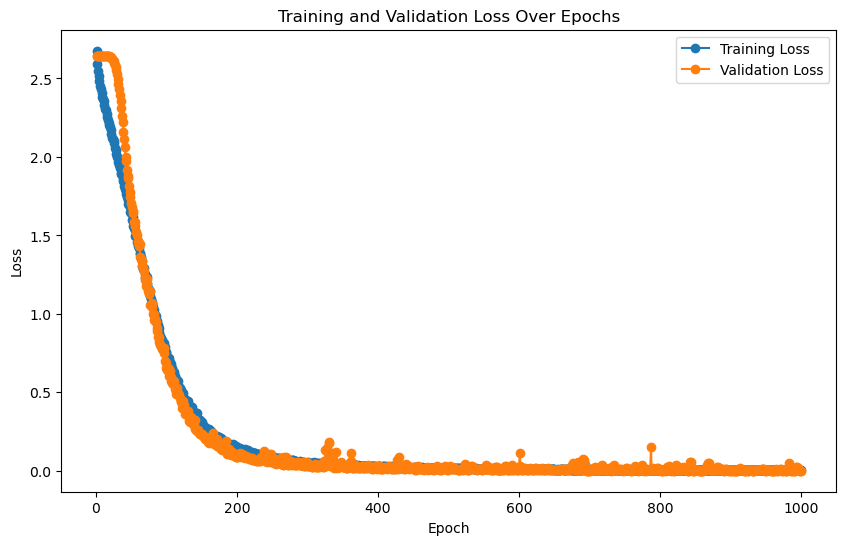

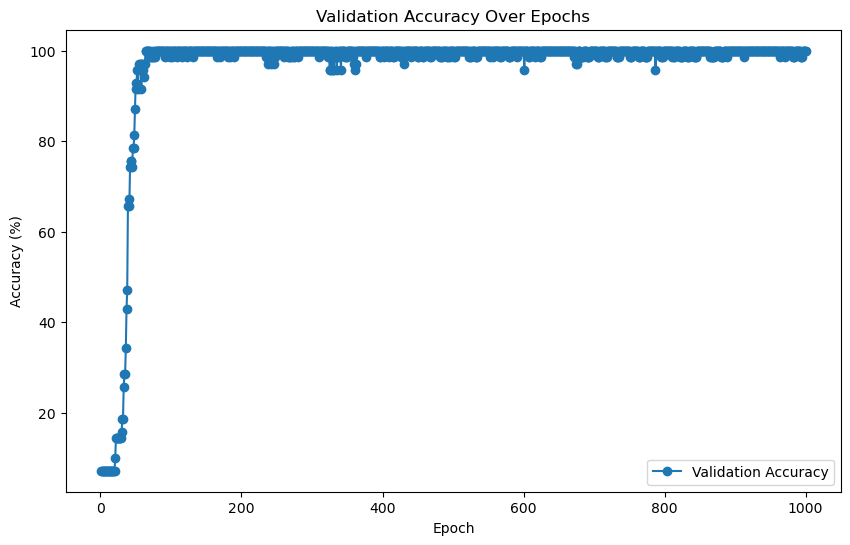


Evaluating on the test set...
    Test Batch [1/11], Loss: 0.0010

Final Test Loss: 0.0578, Test Accuracy: 98.55%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/11 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 560 samples with 64 features each
LOG: Labels shape: (560,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2618 samples with 64 features each
LOG: Labels shape: (2618,)

LOG: Training features shape: (560, 64), Training labels shape: (560,)
LOG: Validation features shape: (70, 64), Validation labels shape: (70,)
LOG: Test features shape: (2618, 64), Test labels shape: (2618,)

LOG: Training Logistic Regression model...


LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 85.71%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      1.00      1.00         5
           3       0.80      0.80      0.80         5
           4       0.67      0.40      0.50         5
           5       0.75      0.60      0.67         5
           6       1.00      1.00      1.00         5
           7       1.00      0.80      0.89         5
           8       0.60      0.60      0.60         5
           9       0.83      1.00      0.91         5
          10       0.83      1.00      0.91         5
          11       1.00      1.00      1.00         5
          12       0.67      0.80      0.73         5
          13       1.00      1.00      1.00         5

    accuracy                          

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 560 samples with 64 features each
LOG: Labels shape: (560,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2618 samples with 64 features each
LOG: Labels shape: (2618,)
Train reps shape: (560, 64)
Train labels shape: (560,)
Val reps shape: (70, 64)
Val labels shape: (70,)
Test reps shape: (2618, 64)
Test labels shape: (2618,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6396  |  Val Loss: 2.5867
Validation loss improved from inf to 2.5867.
[Epoch 2/1000] Train Loss: 2.5814  |  Val Loss: 2.5515
Validation loss improved from 2.5867 to 2.5515.
[Epoch 3/1000] Train Loss: 2.5457  |  Val Loss: 2.5109
Validation loss improved from 2.5515 to 2.5109.
[Epoch 4/1000] Train Loss: 2.4960  |  Val Loss: 2.4746
Validation loss improved from 2.5109 to 2.4746.
[Epoch 5/1000] Train Loss: 2.4481  |  Val Loss: 2.4181
Validation loss improved from 2.4746 to 2.4181.
[Epoch 6/1000] Train Loss: 2.3900  |  Val Loss: 2.3632
Validation loss improved from 2.4181 to 2.3632.
[Epoch 7/1000] Train Loss: 2.3273  |  Val Loss: 2.2873
Validation loss improved from 2.3632 to 2.2873.


[Epoch 8/1000] Train Loss: 2.2519  |  Val Loss: 2.2138
Validation loss improved from 2.2873 to 2.2138.


[Epoch 9/1000] Train Loss: 2.1807  |  Val Loss: 2.1369
Validation loss improved from 2.2138 to 2.1369.
[Epoch 10/1000] Train Loss: 2.1005  |  Val Loss: 2.0548
Validation loss improved from 2.1369 to 2.0548.
[Epoch 11/1000] Train Loss: 2.0172  |  Val Loss: 1.9796
Validation loss improved from 2.0548 to 1.9796.


[Epoch 12/1000] Train Loss: 1.9368  |  Val Loss: 1.9035
Validation loss improved from 1.9796 to 1.9035.
[Epoch 13/1000] Train Loss: 1.8649  |  Val Loss: 1.8293
Validation loss improved from 1.9035 to 1.8293.
[Epoch 14/1000] Train Loss: 1.7925  |  Val Loss: 1.7688
Validation loss improved from 1.8293 to 1.7688.
[Epoch 15/1000] Train Loss: 1.7357  |  Val Loss: 1.7105
Validation loss improved from 1.7688 to 1.7105.
[Epoch 16/1000] Train Loss: 1.6807  |  Val Loss: 1.6829
Validation loss improved from 1.7105 to 1.6829.
[Epoch 17/1000] Train Loss: 1.6442  |  Val Loss: 1.6447
Validation loss improved from 1.6829 to 1.6447.
[Epoch 18/1000] Train Loss: 1.6128  |  Val Loss: 1.5842
Validation loss improved from 1.6447 to 1.5842.


[Epoch 19/1000] Train Loss: 1.5766  |  Val Loss: 1.5520
Validation loss improved from 1.5842 to 1.5520.
[Epoch 20/1000] Train Loss: 1.5280  |  Val Loss: 1.5365
Validation loss improved from 1.5520 to 1.5365.
[Epoch 21/1000] Train Loss: 1.5152  |  Val Loss: 1.5128
Validation loss improved from 1.5365 to 1.5128.
[Epoch 22/1000] Train Loss: 1.4907  |  Val Loss: 1.4767
Validation loss improved from 1.5128 to 1.4767.


[Epoch 23/1000] Train Loss: 1.4553  |  Val Loss: 1.4516
Validation loss improved from 1.4767 to 1.4516.
[Epoch 24/1000] Train Loss: 1.4649  |  Val Loss: 1.4510
Validation loss improved from 1.4516 to 1.4510.
[Epoch 25/1000] Train Loss: 1.4305  |  Val Loss: 1.4103
Validation loss improved from 1.4510 to 1.4103.
[Epoch 26/1000] Train Loss: 1.4112  |  Val Loss: 1.4158
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 27/1000] Train Loss: 1.4039  |  Val Loss: 1.4023
Validation loss improved from 1.4103 to 1.4023.
[Epoch 28/1000] Train Loss: 1.3941  |  Val Loss: 1.4109
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 29/1000] Train Loss: 1.3846  |  Val Loss: 1.3628
Validation loss improved from 1.4023 to 1.3628.
[Epoch 30/1000] Train Loss: 1.3618  |  Val Loss: 1.3386
Validation loss improved from 1.3628 to 1.3386.


[Epoch 31/1000] Train Loss: 1.3466  |  Val Loss: 1.3788
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 32/1000] Train Loss: 1.3816  |  Val Loss: 1.3984
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 33/1000] Train Loss: 1.3401  |  Val Loss: 1.3953
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 34/1000] Train Loss: 1.3221  |  Val Loss: 1.3068
Validation loss improved from 1.3386 to 1.3068.
[Epoch 35/1000] Train Loss: 1.3006  |  Val Loss: 1.2990
Validation loss improved from 1.3068 to 1.2990.
[Epoch 36/1000] Train Loss: 1.2974  |  Val Loss: 1.2814
Validation loss improved from 1.2990 to 1.2814.
[Epoch 37/1000] Train Loss: 1.2976  |  Val Loss: 1.3103
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 38/1000] Train Loss: 1.3126  |  Val Loss: 1.2969
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 39/1000] Train Loss: 1.3176  |  Val Loss: 1.3266
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 40/1000] Train Loss: 1.3276  |  Val Loss: 1.2734
Validation loss improved from 1.2814 to 1.2734.
[Epoch 41/1000] Train Loss: 1.3084  |  Val Loss: 1.2742
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 42/1000] Train Loss: 1.2866  |  Val Loss: 1.2648
Validation loss improved from 1.2734 to 1.2648.


[Epoch 43/1000] Train Loss: 1.2910  |  Val Loss: 1.2825
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 44/1000] Train Loss: 1.2931  |  Val Loss: 1.2741
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 45/1000] Train Loss: 1.2736  |  Val Loss: 1.2494
Validation loss improved from 1.2648 to 1.2494.


[Epoch 46/1000] Train Loss: 1.2555  |  Val Loss: 1.2295
Validation loss improved from 1.2494 to 1.2295.
[Epoch 47/1000] Train Loss: 1.2509  |  Val Loss: 1.2303
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 48/1000] Train Loss: 1.2365  |  Val Loss: 1.2268
Validation loss improved from 1.2295 to 1.2268.
[Epoch 49/1000] Train Loss: 1.2402  |  Val Loss: 1.2138
Validation loss improved from 1.2268 to 1.2138.
[Epoch 50/1000] Train Loss: 1.2440  |  Val Loss: 1.2294
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 51/1000] Train Loss: 1.2331  |  Val Loss: 1.2113
Validation loss improved from 1.2138 to 1.2113.
[Epoch 52/1000] Train Loss: 1.2282  |  Val Loss: 1.2126
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 53/1000] Train Loss: 1.2432  |  Val Loss: 1.2495
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 54/1000] Train Loss: 1.2460  |  Val Loss: 1.2219
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 55/1000] Train Loss: 1.2301  |  Val Loss: 1.2027
Validation loss improved from 1.2113 to 1.2027.
[Epoch 56/1000] Train Loss: 1.2302  |  Val Loss: 1.2476
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 57/1000] Train Loss: 1.2478  |  Val Loss: 1.2136
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 58/1000] Train Loss: 1.2219  |  Val Loss: 1.1918
Validation loss improved from 1.2027 to 1.1918.
[Epoch 59/1000] Train Loss: 1.2088  |  Val Loss: 1.1852
Validation loss improved from 1.1918 to 1.1852.
[Epoch 60/1000] Train Loss: 1.2132  |  Val Loss: 1.2132
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 61/1000] Train Loss: 1.2302  |  Val Loss: 1.2114
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 62/1000] Train Loss: 1.2083  |  Val Loss: 1.2117
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 63/1000] Train Loss: 1.2366  |  Val Loss: 1.1956
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 64/1000] Train Loss: 1.2294  |  Val Loss: 1.2142
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 65/1000] Train Loss: 1.2022  |  Val Loss: 1.2085
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 66/1000] Train Loss: 1.2231  |  Val Loss: 1.1883
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 67/1000] Train Loss: 1.1980  |  Val Loss: 1.1871
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 68/1000] Train Loss: 1.2112  |  Val Loss: 1.1851
Validation loss improved from 1.1852 to 1.1851.


[Epoch 69/1000] Train Loss: 1.2093  |  Val Loss: 1.2057
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 70/1000] Train Loss: 1.2544  |  Val Loss: 1.2209
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 71/1000] Train Loss: 1.2378  |  Val Loss: 1.1707
Validation loss improved from 1.1851 to 1.1707.
[Epoch 72/1000] Train Loss: 1.2122  |  Val Loss: 1.1818
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 73/1000] Train Loss: 1.1882  |  Val Loss: 1.1838
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 74/1000] Train Loss: 1.1754  |  Val Loss: 1.1520
Validation loss improved from 1.1707 to 1.1520.
[Epoch 75/1000] Train Loss: 1.1830  |  Val Loss: 1.1503
Validation loss improved from 1.1520 to 1.1503.
[Epoch 76/1000] Train Loss: 1.1741  |  Val Loss: 1.1504
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 77/1000] Train Loss: 1.1747  |  Val Loss: 1.1464
Validation loss improved from 1.1503 to 1.1464.
[Epoch 78/1000] Train Loss: 1.1723  |  Val Loss: 1.1532
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 79/1000] Train Loss: 1.2020  |  Val Loss: 1.2527
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 80/1000] Train Loss: 1.2115  |  Val Loss: 1.1580
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 81/1000] Train Loss: 1.2067  |  Val Loss: 1.1488
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 82/1000] Train Loss: 1.2003  |  Val Loss: 1.1311
Validation loss improved from 1.1464 to 1.1311.
[Epoch 83/1000] Train Loss: 1.1650  |  Val Loss: 1.1332
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 84/1000] Train Loss: 1.1732  |  Val Loss: 1.1325
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 85/1000] Train Loss: 1.1741  |  Val Loss: 1.2158
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 86/1000] Train Loss: 1.2006  |  Val Loss: 1.1459
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 87/1000] Train Loss: 1.1666  |  Val Loss: 1.1306
Validation loss improved from 1.1311 to 1.1306.
[Epoch 88/1000] Train Loss: 1.1662  |  Val Loss: 1.1515
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 89/1000] Train Loss: 1.1718  |  Val Loss: 1.1361
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 90/1000] Train Loss: 1.1531  |  Val Loss: 1.1129
Validation loss improved from 1.1306 to 1.1129.
[Epoch 91/1000] Train Loss: 1.1447  |  Val Loss: 1.1329
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 92/1000] Train Loss: 1.1485  |  Val Loss: 1.1082
Validation loss improved from 1.1129 to 1.1082.
[Epoch 93/1000] Train Loss: 1.1706  |  Val Loss: 1.2437
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 94/1000] Train Loss: 1.1799  |  Val Loss: 1.1136
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 95/1000] Train Loss: 1.1455  |  Val Loss: 1.1313
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 96/1000] Train Loss: 1.1692  |  Val Loss: 1.1364
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 97/1000] Train Loss: 1.1552  |  Val Loss: 1.1162
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 98/1000] Train Loss: 1.1604  |  Val Loss: 1.1014
Validation loss improved from 1.1082 to 1.1014.
[Epoch 99/1000] Train Loss: 1.1472  |  Val Loss: 1.1055
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 100/1000] Train Loss: 1.1514  |  Val Loss: 1.1721
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 101/1000] Train Loss: 1.1558  |  Val Loss: 1.2637
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 102/1000] Train Loss: 1.1777  |  Val Loss: 1.1094
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 103/1000] Train Loss: 1.1401  |  Val Loss: 1.0988
Validation loss improved from 1.1014 to 1.0988.
[Epoch 104/1000] Train Loss: 1.1440  |  Val Loss: 1.0958
Validation loss improved from 1.0988 to 1.0958.
[Epoch 105/1000] Train Loss: 1.1629  |  Val Loss: 1.1017
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 106/1000] Train Loss: 1.1677  |  Val Loss: 1.0987
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 107/1000] Train Loss: 1.1297  |  Val Loss: 1.0986
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 108/1000] Train Loss: 1.1407  |  Val Loss: 1.0888
Validation loss improved from 1.0958 to 1.0888.
[Epoch 109/1000] Train Loss: 1.1437  |  Val Loss: 1.1295
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 110/1000] Train Loss: 1.1322  |  Val Loss: 1.0883
Validation loss improved from 1.0888 to 1.0883.
[Epoch 111/1000] Train Loss: 1.1228  |  Val Loss: 1.0871
Validation loss improved from 1.0883 to 1.0871.
[Epoch 112/1000] Train Loss: 1.

[Epoch 113/1000] Train Loss: 1.1914  |  Val Loss: 1.2537
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 114/1000] Train Loss: 1.1889  |  Val Loss: 1.1075
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 115/1000] Train Loss: 1.1609  |  Val Loss: 1.1102
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 116/1000] Train Loss: 1.1439  |  Val Loss: 1.0812
Validation loss improved from 1.0871 to 1.0812.
[Epoch 117/1000] Train Loss: 1.1171  |  Val Loss: 1.0799
Validation loss improved from 1.0812 to 1.0799.
[Epoch 118/1000] Train Loss: 1.1210  |  Val Loss: 1.0849
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 119/1000] Train Loss: 1.1083  |  Val Loss: 1.0834
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 120/1000] Train Loss: 1.1151  |  Val Loss: 1.0791
Validation loss improved from 1.0799 to 1.0791.
[Epoch 121/1000] Train Loss: 1.1100  |  Val Loss: 1.0971
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 122/1000] Tr

[Epoch 123/1000] Train Loss: 1.1350  |  Val Loss: 1.0825
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 124/1000] Train Loss: 1.1114  |  Val Loss: 1.1122
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 125/1000] Train Loss: 1.1230  |  Val Loss: 1.0697
Validation loss improved from 1.0791 to 1.0697.
[Epoch 126/1000] Train Loss: 1.1347  |  Val Loss: 1.1333
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 127/1000] Train Loss: 1.1265  |  Val Loss: 1.0884
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 128/1000] Train Loss: 1.1189  |  Val Loss: 1.0585
Validation loss improved from 1.0697 to 1.0585.
[Epoch 129/1000] Train Loss: 1.0963  |  Val Loss: 1.0610
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 130/1000] Train Loss: 1.1491  |  Val Loss: 1.1596
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 131/1000] Train Loss: 1.1801  |  Val Loss: 1.1610
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 132/10

[Epoch 135/1000] Train Loss: 1.1017  |  Val Loss: 1.0581
Validation loss improved from 1.0585 to 1.0581.
[Epoch 136/1000] Train Loss: 1.0902  |  Val Loss: 1.0922
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 137/1000] Train Loss: 1.1291  |  Val Loss: 1.0887
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 138/1000] Train Loss: 1.0963  |  Val Loss: 1.0920
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 139/1000] Train Loss: 1.0829  |  Val Loss: 1.0523
Validation loss improved from 1.0581 to 1.0523.
[Epoch 140/1000] Train Loss: 1.0744  |  Val Loss: 1.0465
Validation loss improved from 1.0523 to 1.0465.
[Epoch 141/1000] Train Loss: 1.0830  |  Val Loss: 1.0710
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 142/1000] Train Loss: 1.0800  |  Val Loss: 1.0426
Validation loss improved from 1.0465 to 1.0426.
[Epoch 143/1000] Train Loss: 1.0683  |  Val Loss: 1.0371
Validation loss improved from 1.0426 to 1.0371.
[Epoch 144/1000] Train Loss: 1.

[Epoch 147/1000] Train Loss: 1.0692  |  Val Loss: 1.0187
Validation loss improved from 1.0262 to 1.0187.
[Epoch 148/1000] Train Loss: 1.0734  |  Val Loss: 1.0260
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 149/1000] Train Loss: 1.0603  |  Val Loss: 1.0169
Validation loss improved from 1.0187 to 1.0169.
[Epoch 150/1000] Train Loss: 1.0671  |  Val Loss: 1.0156
Validation loss improved from 1.0169 to 1.0156.
[Epoch 151/1000] Train Loss: 1.0548  |  Val Loss: 1.0761
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 152/1000] Train Loss: 1.0920  |  Val Loss: 1.0576
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 153/1000] Train Loss: 1.0671  |  Val Loss: 1.0222
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 154/1000] Train Loss: 1.0534  |  Val Loss: 1.0422
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 155/1000] Train Loss: 1.0480  |  Val Loss: 1.0890
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 156/1000] Tr

[Epoch 158/1000] Train Loss: 1.0291  |  Val Loss: 1.0112
Validation loss improved from 1.0156 to 1.0112.
[Epoch 159/1000] Train Loss: 1.0470  |  Val Loss: 1.0070
Validation loss improved from 1.0112 to 1.0070.
[Epoch 160/1000] Train Loss: 1.0642  |  Val Loss: 1.0353
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 161/1000] Train Loss: 1.0503  |  Val Loss: 1.0280
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 162/1000] Train Loss: 1.0205  |  Val Loss: 1.0214
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 163/1000] Train Loss: 1.0762  |  Val Loss: 1.0155
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 164/1000] Train Loss: 1.0969  |  Val Loss: 1.1178
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 165/1000] Train Loss: 1.1125  |  Val Loss: 1.1670
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 166/1000] Train Loss: 1.0694  |  Val Loss: 1.1044
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 167/10

[Epoch 170/1000] Train Loss: 1.0234  |  Val Loss: 1.0607
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 171/1000] Train Loss: 1.0600  |  Val Loss: 0.9706
Validation loss improved from 0.9974 to 0.9706.
[Epoch 172/1000] Train Loss: 1.0493  |  Val Loss: 0.9786
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 173/1000] Train Loss: 1.0420  |  Val Loss: 0.9759
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 174/1000] Train Loss: 1.0175  |  Val Loss: 0.9959
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 175/1000] Train Loss: 1.0290  |  Val Loss: 1.1341
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 176/1000] Train Loss: 1.0195  |  Val Loss: 0.9589
Validation loss improved from 0.9706 to 0.9589.
[Epoch 177/1000] Train Loss: 0.9886  |  Val Loss: 0.9498
Validation loss improved from 0.9589 to 0.9498.
[Epoch 178/1000] Train Loss: 0.9955  |  Val Loss: 0.9470
Validation loss improved from 0.9498 to 0.9470.
[Epoch 179/1000] Train Lo

[Epoch 181/1000] Train Loss: 0.9862  |  Val Loss: 0.9629
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 182/1000] Train Loss: 0.9852  |  Val Loss: 0.9494
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 183/1000] Train Loss: 0.9945  |  Val Loss: 0.9348
Validation loss improved from 0.9470 to 0.9348.
[Epoch 184/1000] Train Loss: 0.9985  |  Val Loss: 0.9687
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 185/1000] Train Loss: 0.9786  |  Val Loss: 1.0093
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 186/1000] Train Loss: 1.0218  |  Val Loss: 0.9422
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 187/1000] Train Loss: 0.9833  |  Val Loss: 0.9727
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 188/1000] Train Loss: 0.9990  |  Val Loss: 1.0065
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 189/1000] Train Loss: 0.9870  |  Val Loss: 0.9239
Validation loss improved from 0.9348 to 0.9239.
[Epoch 190/10

[Epoch 192/1000] Train Loss: 0.9997  |  Val Loss: 1.0418
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 193/1000] Train Loss: 1.0729  |  Val Loss: 0.9043
Validation loss improved from 0.9239 to 0.9043.
[Epoch 194/1000] Train Loss: 1.0007  |  Val Loss: 0.9355
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 195/1000] Train Loss: 0.9839  |  Val Loss: 0.9130
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 196/1000] Train Loss: 0.9641  |  Val Loss: 0.9021
Validation loss improved from 0.9043 to 0.9021.
[Epoch 197/1000] Train Loss: 0.9731  |  Val Loss: 0.9195
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 198/1000] Train Loss: 0.9892  |  Val Loss: 0.8991
Validation loss improved from 0.9021 to 0.8991.
[Epoch 199/1000] Train Loss: 0.9592  |  Val Loss: 0.9074
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 200/1000] Train Loss: 0.9506  |  Val Loss: 0.9006
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 201/1000] Tr

[Epoch 204/1000] Train Loss: 0.9368  |  Val Loss: 0.9231
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 205/1000] Train Loss: 0.9352  |  Val Loss: 0.9126
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 206/1000] Train Loss: 0.9316  |  Val Loss: 0.8919
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 207/1000] Train Loss: 0.9091  |  Val Loss: 0.8908
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 208/1000] Train Loss: 0.9182  |  Val Loss: 0.9331
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 209/1000] Train Loss: 0.9193  |  Val Loss: 1.0268
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 210/1000] Train Loss: 0.9728  |  Val Loss: 0.9833
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 211/1000] Train Loss: 0.9977  |  Val Loss: 1.0322
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 212/1000] Train Loss: 0.9991  |  Val Loss: 0.9376
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 215/1000] Train Loss: 0.9245  |  Val Loss: 0.8614
Validation loss improved from 0.8886 to 0.8614.
[Epoch 216/1000] Train Loss: 0.9013  |  Val Loss: 0.8502
Validation loss improved from 0.8614 to 0.8502.
[Epoch 217/1000] Train Loss: 0.8925  |  Val Loss: 0.8846
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 218/1000] Train Loss: 0.8931  |  Val Loss: 0.9028
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 219/1000] Train Loss: 0.9062  |  Val Loss: 0.8870
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 220/1000] Train Loss: 0.9020  |  Val Loss: 0.8995
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 221/1000] Train Loss: 0.9642  |  Val Loss: 0.9532
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 222/1000] Train Loss: 0.9288  |  Val Loss: 0.9286
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 223/1000] Train Loss: 0.9034  |  Val Loss: 0.9061
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 224/10

[Epoch 226/1000] Train Loss: 0.9475  |  Val Loss: 1.0032
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 227/1000] Train Loss: 0.9225  |  Val Loss: 0.8482
Validation loss improved from 0.8502 to 0.8482.
[Epoch 228/1000] Train Loss: 0.8593  |  Val Loss: 0.8428
Validation loss improved from 0.8482 to 0.8428.
[Epoch 229/1000] Train Loss: 0.8708  |  Val Loss: 0.8311
Validation loss improved from 0.8428 to 0.8311.
[Epoch 230/1000] Train Loss: 0.8670  |  Val Loss: 0.8373
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 231/1000] Train Loss: 0.8731  |  Val Loss: 0.8945
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 232/1000] Train Loss: 0.8703  |  Val Loss: 0.8588
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 233/1000] Train Loss: 0.8737  |  Val Loss: 0.8325
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 234/1000] Train Loss: 0.8753  |  Val Loss: 0.8555
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 235/1000] T

[Epoch 237/1000] Train Loss: 0.8507  |  Val Loss: 0.8138
Validation loss improved from 0.8311 to 0.8138.
[Epoch 238/1000] Train Loss: 0.8533  |  Val Loss: 0.7973
Validation loss improved from 0.8138 to 0.7973.
[Epoch 239/1000] Train Loss: 0.8332  |  Val Loss: 0.8587
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 240/1000] Train Loss: 0.8782  |  Val Loss: 0.8449
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 241/1000] Train Loss: 0.8912  |  Val Loss: 0.8528
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 242/1000] Train Loss: 0.9487  |  Val Loss: 0.8222
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 243/1000] Train Loss: 0.9265  |  Val Loss: 0.9124
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 244/1000] Train Loss: 0.8761  |  Val Loss: 0.7693
Validation loss improved from 0.7973 to 0.7693.
[Epoch 245/1000] Train Loss: 0.8422  |  Val Loss: 0.7941
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 246/1000] Tr

[Epoch 249/1000] Train Loss: 0.8721  |  Val Loss: 0.8233
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 250/1000] Train Loss: 0.8493  |  Val Loss: 0.8515
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 251/1000] Train Loss: 0.8768  |  Val Loss: 0.8054
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 252/1000] Train Loss: 0.8744  |  Val Loss: 0.8439
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 253/1000] Train Loss: 0.9292  |  Val Loss: 0.9336
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 254/1000] Train Loss: 0.8575  |  Val Loss: 0.8414
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 255/1000] Train Loss: 0.8669  |  Val Loss: 0.7750
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 256/1000] Train Loss: 0.8145  |  Val Loss: 0.8155
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 257/1000] Train Loss: 0.8440  |  Val Loss: 0.8347
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 260/1000] Train Loss: 0.8078  |  Val Loss: 0.7913
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 261/1000] Train Loss: 0.8149  |  Val Loss: 0.7596
Validation loss improved from 0.7640 to 0.7596.
[Epoch 262/1000] Train Loss: 0.7990  |  Val Loss: 0.7449
Validation loss improved from 0.7596 to 0.7449.
[Epoch 263/1000] Train Loss: 0.8085  |  Val Loss: 0.7553
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 264/1000] Train Loss: 0.7868  |  Val Loss: 0.7726
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 265/1000] Train Loss: 0.7970  |  Val Loss: 0.8421
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 266/1000] Train Loss: 0.8056  |  Val Loss: 0.7695
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 267/1000] Train Loss: 0.7949  |  Val Loss: 0.8038
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 268/1000] Train Loss: 0.7963  |  Val Loss: 0.7533
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 269/10

[Epoch 272/1000] Train Loss: 0.8290  |  Val Loss: 0.7961
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 273/1000] Train Loss: 0.8205  |  Val Loss: 0.7298
Validation loss improved from 0.7385 to 0.7298.
[Epoch 274/1000] Train Loss: 0.7841  |  Val Loss: 0.7211
Validation loss improved from 0.7298 to 0.7211.
[Epoch 275/1000] Train Loss: 0.7626  |  Val Loss: 0.7183
Validation loss improved from 0.7211 to 0.7183.
[Epoch 276/1000] Train Loss: 0.7653  |  Val Loss: 0.7098
Validation loss improved from 0.7183 to 0.7098.
[Epoch 277/1000] Train Loss: 0.7864  |  Val Loss: 0.7329
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 278/1000] Train Loss: 0.7914  |  Val Loss: 0.7228
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 279/1000] Train Loss: 0.7811  |  Val Loss: 0.7553
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 280/1000] Train Loss: 0.7608  |  Val Loss: 0.7022
Validation loss improved from 0.7098 to 0.7022.
[Epoch 281/1000] Train Loss: 0.

[Epoch 284/1000] Train Loss: 0.7915  |  Val Loss: 0.7094
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 285/1000] Train Loss: 0.7459  |  Val Loss: 0.6956
Validation loss improved from 0.7022 to 0.6956.
[Epoch 286/1000] Train Loss: 0.7676  |  Val Loss: 0.7192
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 287/1000] Train Loss: 0.7649  |  Val Loss: 0.7255
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 288/1000] Train Loss: 0.8046  |  Val Loss: 0.8325
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 289/1000] Train Loss: 0.7757  |  Val Loss: 0.7181
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 290/1000] Train Loss: 0.7520  |  Val Loss: 0.7484
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 291/1000] Train Loss: 0.7573  |  Val Loss: 0.6942
Validation loss improved from 0.6956 to 0.6942.
[Epoch 292/1000] Train Loss: 0.7611  |  Val Loss: 0.7032
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 293/10

[Epoch 295/1000] Train Loss: 0.7611  |  Val Loss: 0.8753
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 296/1000] Train Loss: 0.8141  |  Val Loss: 0.6898
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 297/1000] Train Loss: 0.7597  |  Val Loss: 0.6958
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 298/1000] Train Loss: 0.7355  |  Val Loss: 0.6981
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 299/1000] Train Loss: 0.7369  |  Val Loss: 0.6761
Validation loss improved from 0.6824 to 0.6761.
[Epoch 300/1000] Train Loss: 0.7129  |  Val Loss: 0.6750
Validation loss improved from 0.6761 to 0.6750.
[Epoch 301/1000] Train Loss: 0.7181  |  Val Loss: 0.6787
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 302/1000] Train Loss: 0.7653  |  Val Loss: 0.6986
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 303/1000] Train Loss: 0.7402  |  Val Loss: 0.6666
Validation loss improved from 0.6750 to 0.6666.
[Epoch 304/1000] Tr

[Epoch 306/1000] Train Loss: 0.7904  |  Val Loss: 0.8548
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 307/1000] Train Loss: 0.7834  |  Val Loss: 0.7127
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 308/1000] Train Loss: 0.7329  |  Val Loss: 0.6952
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 309/1000] Train Loss: 0.7414  |  Val Loss: 0.6746
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 310/1000] Train Loss: 0.7672  |  Val Loss: 0.7453
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 311/1000] Train Loss: 0.7319  |  Val Loss: 0.7732
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 312/1000] Train Loss: 0.7539  |  Val Loss: 0.7385
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 313/1000] Train Loss: 0.7214  |  Val Loss: 0.7386
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 314/1000] Train Loss: 0.7308  |  Val Loss: 0.7056
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 318/1000] Train Loss: 0.7662  |  Val Loss: 0.7085
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 319/1000] Train Loss: 0.7745  |  Val Loss: 0.7569
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 320/1000] Train Loss: 0.7103  |  Val Loss: 0.6299
Validation loss improved from 0.6484 to 0.6299.
[Epoch 321/1000] Train Loss: 0.7096  |  Val Loss: 0.6457
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 322/1000] Train Loss: 0.7091  |  Val Loss: 0.6501
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 323/1000] Train Loss: 0.7037  |  Val Loss: 0.6529
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 324/1000] Train Loss: 0.6771  |  Val Loss: 0.6887
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 325/1000] Train Loss: 0.6730  |  Val Loss: 0.6903
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 326/1000] Train Loss: 0.7062  |  Val Loss: 0.6726
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 

[Epoch 330/1000] Train Loss: 0.7063  |  Val Loss: 0.6224
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 331/1000] Train Loss: 0.7057  |  Val Loss: 0.6231
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 332/1000] Train Loss: 0.6812  |  Val Loss: 0.6312
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 333/1000] Train Loss: 0.6748  |  Val Loss: 0.6225
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 334/1000] Train Loss: 0.6666  |  Val Loss: 0.6103
Validation loss improved from 0.6221 to 0.6103.
[Epoch 335/1000] Train Loss: 0.6678  |  Val Loss: 0.6553
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 336/1000] Train Loss: 0.7089  |  Val Loss: 0.6910
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 337/1000] Train Loss: 0.7262  |  Val Loss: 0.6809
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 338/1000] Train Loss: 0.6885  |  Val Loss: 0.6416
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 

[Epoch 340/1000] Train Loss: 0.6594  |  Val Loss: 0.6320
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 341/1000] Train Loss: 0.6710  |  Val Loss: 0.5971
Validation loss improved from 0.6083 to 0.5971.
[Epoch 342/1000] Train Loss: 0.6651  |  Val Loss: 0.5963
Validation loss improved from 0.5971 to 0.5963.
[Epoch 343/1000] Train Loss: 0.6608  |  Val Loss: 0.6002
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 344/1000] Train Loss: 0.6530  |  Val Loss: 0.5998
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 345/1000] Train Loss: 0.6961  |  Val Loss: 0.6176
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 346/1000] Train Loss: 0.6607  |  Val Loss: 0.5817
Validation loss improved from 0.5963 to 0.5817.
[Epoch 347/1000] Train Loss: 0.6445  |  Val Loss: 0.6010
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 348/1000] Train Loss: 0.6392  |  Val Loss: 0.5821
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 349/1000] Tr

[Epoch 351/1000] Train Loss: 0.7377  |  Val Loss: 0.6288
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 352/1000] Train Loss: 0.7465  |  Val Loss: 0.6105
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 353/1000] Train Loss: 0.6981  |  Val Loss: 0.6015
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 354/1000] Train Loss: 0.7102  |  Val Loss: 0.6756
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 355/1000] Train Loss: 0.6758  |  Val Loss: 0.5712
Validation loss improved from 0.5817 to 0.5712.
[Epoch 356/1000] Train Loss: 0.6573  |  Val Loss: 0.5865
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 357/1000] Train Loss: 0.6539  |  Val Loss: 0.6436
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 358/1000] Train Loss: 0.6603  |  Val Loss: 0.5869
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 359/1000] Train Loss: 0.6518  |  Val Loss: 0.5801
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 

[Epoch 362/1000] Train Loss: 0.6289  |  Val Loss: 0.5790
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 363/1000] Train Loss: 0.6333  |  Val Loss: 0.6262
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 364/1000] Train Loss: 0.6555  |  Val Loss: 0.6332
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 365/1000] Train Loss: 0.6555  |  Val Loss: 0.5991
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 366/1000] Train Loss: 0.6308  |  Val Loss: 0.6313
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 367/1000] Train Loss: 0.6413  |  Val Loss: 0.6150
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 368/1000] Train Loss: 0.6582  |  Val Loss: 0.5945
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 369/1000] Train Loss: 0.6741  |  Val Loss: 0.5732
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 370/1000] Train Loss: 0.7262  |  Val Loss: 0.6315
!! Validation loss did NOT improve !! Patience: 15

[Epoch 372/1000] Train Loss: 0.6715  |  Val Loss: 0.6001
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 373/1000] Train Loss: 0.6734  |  Val Loss: 0.5915
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 374/1000] Train Loss: 0.6998  |  Val Loss: 0.6035
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 375/1000] Train Loss: 0.6515  |  Val Loss: 0.6026
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 376/1000] Train Loss: 0.6544  |  Val Loss: 0.5870
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 377/1000] Train Loss: 0.6412  |  Val Loss: 0.6047
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 378/1000] Train Loss: 0.6890  |  Val Loss: 0.5939
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 379/1000] Train Loss: 0.6587  |  Val Loss: 0.7028
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 380/1000] Train Loss: 0.6596  |  Val Loss: 0.6099
!! Validation loss did NOT improve !! Patience:

[Epoch 383/1000] Train Loss: 0.6270  |  Val Loss: 0.5807
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 384/1000] Train Loss: 0.6244  |  Val Loss: 0.5473
Validation loss improved from 0.5505 to 0.5473.
[Epoch 385/1000] Train Loss: 0.6489  |  Val Loss: 0.6894
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 386/1000] Train Loss: 0.6295  |  Val Loss: 0.5549
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 387/1000] Train Loss: 0.6133  |  Val Loss: 0.5402
Validation loss improved from 0.5473 to 0.5402.
[Epoch 388/1000] Train Loss: 0.6180  |  Val Loss: 0.5686
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 389/1000] Train Loss: 0.6035  |  Val Loss: 0.5823
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 390/1000] Train Loss: 0.6101  |  Val Loss: 0.5854
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 391/1000] Train Loss: 0.6261  |  Val Loss: 0.5509
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 392/10

[Epoch 395/1000] Train Loss: 0.5870  |  Val Loss: 0.5861
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 396/1000] Train Loss: 0.6108  |  Val Loss: 0.5424
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 397/1000] Train Loss: 0.5933  |  Val Loss: 0.5372
Validation loss improved from 0.5402 to 0.5372.
[Epoch 398/1000] Train Loss: 0.5927  |  Val Loss: 0.5315
Validation loss improved from 0.5372 to 0.5315.
[Epoch 399/1000] Train Loss: 0.6000  |  Val Loss: 0.5291
Validation loss improved from 0.5315 to 0.5291.
[Epoch 400/1000] Train Loss: 0.5937  |  Val Loss: 0.5406
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 401/1000] Train Loss: 0.5884  |  Val Loss: 0.5835
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 402/1000] Train Loss: 0.5887  |  Val Loss: 0.5608
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 403/1000] Train Loss: 0.6001  |  Val Loss: 0.5629
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 404/1000] Tr

[Epoch 407/1000] Train Loss: 0.6101  |  Val Loss: 0.5437
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 408/1000] Train Loss: 0.6178  |  Val Loss: 0.5186
Validation loss improved from 0.5291 to 0.5186.
[Epoch 409/1000] Train Loss: 0.6057  |  Val Loss: 0.5706
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 410/1000] Train Loss: 0.5997  |  Val Loss: 0.5227
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 411/1000] Train Loss: 0.5845  |  Val Loss: 0.5024
Validation loss improved from 0.5186 to 0.5024.
[Epoch 412/1000] Train Loss: 0.6070  |  Val Loss: 0.5447
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 413/1000] Train Loss: 0.5900  |  Val Loss: 0.5286
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 414/1000] Train Loss: 0.5853  |  Val Loss: 0.5225
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 415/1000] Train Loss: 0.5761  |  Val Loss: 0.5100
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 416/10

[Epoch 419/1000] Train Loss: 0.6545  |  Val Loss: 0.5083
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 420/1000] Train Loss: 0.5985  |  Val Loss: 0.5702
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 421/1000] Train Loss: 0.6176  |  Val Loss: 0.4978
Validation loss improved from 0.5024 to 0.4978.
[Epoch 422/1000] Train Loss: 0.5952  |  Val Loss: 0.5658
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 423/1000] Train Loss: 0.5874  |  Val Loss: 0.5218
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 424/1000] Train Loss: 0.5661  |  Val Loss: 0.5266
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 425/1000] Train Loss: 0.6199  |  Val Loss: 0.5253
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 426/1000] Train Loss: 0.6139  |  Val Loss: 0.6792
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 427/1000] Train Loss: 0.5975  |  Val Loss: 0.5298
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 

[Epoch 430/1000] Train Loss: 0.6250  |  Val Loss: 0.5025
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 431/1000] Train Loss: 0.5754  |  Val Loss: 0.5123
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 432/1000] Train Loss: 0.6047  |  Val Loss: 0.5034
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 433/1000] Train Loss: 0.6239  |  Val Loss: 0.4897
Validation loss improved from 0.4978 to 0.4897.
[Epoch 434/1000] Train Loss: 0.6125  |  Val Loss: 0.5676
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 435/1000] Train Loss: 0.6115  |  Val Loss: 0.6474
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 436/1000] Train Loss: 0.6182  |  Val Loss: 0.6556
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 437/1000] Train Loss: 0.5949  |  Val Loss: 0.5723
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 438/1000] Train Loss: 0.5723  |  Val Loss: 0.5431
!! Validation loss did NOT improve !! Patience: 5/100
[Epoc

[Epoch 442/1000] Train Loss: 0.6418  |  Val Loss: 0.4971
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 443/1000] Train Loss: 0.5998  |  Val Loss: 0.5989
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 444/1000] Train Loss: 0.6618  |  Val Loss: 0.4921
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 445/1000] Train Loss: 0.6024  |  Val Loss: 0.5428
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 446/1000] Train Loss: 0.5683  |  Val Loss: 0.5434
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 447/1000] Train Loss: 0.5985  |  Val Loss: 0.5050
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 448/1000] Train Loss: 0.5642  |  Val Loss: 0.4696
Validation loss improved from 0.4897 to 0.4696.
[Epoch 449/1000] Train Loss: 0.5679  |  Val Loss: 0.4811
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 450/1000] Train Loss: 0.5443  |  Val Loss: 0.5634
!! Validation loss did NOT improve !! Patience: 2/100
[E

[Epoch 454/1000] Train Loss: 0.6176  |  Val Loss: 0.5334
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 455/1000] Train Loss: 0.5743  |  Val Loss: 0.5520
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 456/1000] Train Loss: 0.6794  |  Val Loss: 0.7777
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 457/1000] Train Loss: 0.6262  |  Val Loss: 0.4845
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 458/1000] Train Loss: 0.5672  |  Val Loss: 0.4895
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 459/1000] Train Loss: 0.6349  |  Val Loss: 0.8072
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 460/1000] Train Loss: 0.6796  |  Val Loss: 0.6363
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 461/1000] Train Loss: 0.5900  |  Val Loss: 0.5556
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 462/1000] Train Loss: 0.5673  |  Val Loss: 0.4919
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 466/1000] Train Loss: 0.5899  |  Val Loss: 0.5153
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 467/1000] Train Loss: 0.5884  |  Val Loss: 0.4690
Validation loss improved from 0.4696 to 0.4690.
[Epoch 468/1000] Train Loss: 0.5891  |  Val Loss: 0.5573
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 469/1000] Train Loss: 0.5966  |  Val Loss: 0.5122
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 470/1000] Train Loss: 0.5974  |  Val Loss: 0.5062
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 471/1000] Train Loss: 0.5956  |  Val Loss: 0.5333
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 472/1000] Train Loss: 0.5427  |  Val Loss: 0.4591
Validation loss improved from 0.4690 to 0.4591.
[Epoch 473/1000] Train Loss: 0.5248  |  Val Loss: 0.4979
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 474/1000] Train Loss: 0.5231  |  Val Loss: 0.4777
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 475/1

[Epoch 477/1000] Train Loss: 0.5946  |  Val Loss: 0.5446
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 478/1000] Train Loss: 0.6181  |  Val Loss: 0.5117
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 479/1000] Train Loss: 0.5587  |  Val Loss: 0.4626
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 480/1000] Train Loss: 0.5431  |  Val Loss: 0.4834
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 481/1000] Train Loss: 0.5794  |  Val Loss: 0.4553
Validation loss improved from 0.4591 to 0.4553.
[Epoch 482/1000] Train Loss: 0.5899  |  Val Loss: 0.5465
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 483/1000] Train Loss: 0.5408  |  Val Loss: 0.5340
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 484/1000] Train Loss: 0.5812  |  Val Loss: 0.5461
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 485/1000] Train Loss: 0.5984  |  Val Loss: 0.6695
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 

[Epoch 488/1000] Train Loss: 0.5555  |  Val Loss: 0.5537
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 489/1000] Train Loss: 0.6286  |  Val Loss: 0.4621
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 490/1000] Train Loss: 0.5373  |  Val Loss: 0.4541
Validation loss improved from 0.4553 to 0.4541.
[Epoch 491/1000] Train Loss: 0.5099  |  Val Loss: 0.4914
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 492/1000] Train Loss: 0.5307  |  Val Loss: 0.4715
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 493/1000] Train Loss: 0.5283  |  Val Loss: 0.4660
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 494/1000] Train Loss: 0.5462  |  Val Loss: 0.4887
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 495/1000] Train Loss: 0.5221  |  Val Loss: 0.5169
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 496/1000] Train Loss: 0.5384  |  Val Loss: 0.5617
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 

[Epoch 500/1000] Train Loss: 0.5738  |  Val Loss: 0.4586
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 501/1000] Train Loss: 0.5150  |  Val Loss: 0.4869
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 502/1000] Train Loss: 0.5118  |  Val Loss: 0.5009
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 503/1000] Train Loss: 0.5075  |  Val Loss: 0.4705
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 504/1000] Train Loss: 0.5172  |  Val Loss: 0.4629
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 505/1000] Train Loss: 0.5261  |  Val Loss: 0.4736
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 506/1000] Train Loss: 0.5426  |  Val Loss: 0.4367
Validation loss improved from 0.4541 to 0.4367.
[Epoch 507/1000] Train Loss: 0.5228  |  Val Loss: 0.5060
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 508/1000] Train Loss: 0.5850  |  Val Loss: 0.6298
!! Validation loss did NOT improve !! Patience: 2/100
[

[Epoch 511/1000] Train Loss: 0.6523  |  Val Loss: 0.8641
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 512/1000] Train Loss: 0.6695  |  Val Loss: 0.5187
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 513/1000] Train Loss: 0.5476  |  Val Loss: 0.4678
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 514/1000] Train Loss: 0.4985  |  Val Loss: 0.4609
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 515/1000] Train Loss: 0.5105  |  Val Loss: 0.4673
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 516/1000] Train Loss: 0.4989  |  Val Loss: 0.5424
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 517/1000] Train Loss: 0.5312  |  Val Loss: 0.5725
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 518/1000] Train Loss: 0.5307  |  Val Loss: 0.4324
Validation loss improved from 0.4367 to 0.4324.
[Epoch 519/1000] Train Loss: 0.4965  |  Val Loss: 0.4573
!! Validation loss did NOT improve !! Patience: 1/100
[Epoc

[Epoch 522/1000] Train Loss: 0.5008  |  Val Loss: 0.5117
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 523/1000] Train Loss: 0.5252  |  Val Loss: 0.4914
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 524/1000] Train Loss: 0.6342  |  Val Loss: 0.7027
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 525/1000] Train Loss: 0.6444  |  Val Loss: 0.5245
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 526/1000] Train Loss: 0.5721  |  Val Loss: 0.5402
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 527/1000] Train Loss: 0.5897  |  Val Loss: 0.6325
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 528/1000] Train Loss: 0.5849  |  Val Loss: 0.4860
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 529/1000] Train Loss: 0.5385  |  Val Loss: 0.5020
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 530/1000] Train Loss: 0.5446  |  Val Loss: 0.4959
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 533/1000] Train Loss: 0.5257  |  Val Loss: 0.4430
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 534/1000] Train Loss: 0.5023  |  Val Loss: 0.4477
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 535/1000] Train Loss: 0.4996  |  Val Loss: 0.4271
Validation loss improved from 0.4316 to 0.4271.
[Epoch 536/1000] Train Loss: 0.5050  |  Val Loss: 0.4909
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 537/1000] Train Loss: 0.4920  |  Val Loss: 0.4949
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 538/1000] Train Loss: 0.5138  |  Val Loss: 0.4850
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 539/1000] Train Loss: 0.4991  |  Val Loss: 0.4291
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 540/1000] Train Loss: 0.5283  |  Val Loss: 0.4572
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 541/1000] Train Loss: 0.4792  |  Val Loss: 0.4313
!! Validation loss did NOT improve !! Patience: 6/100
[Epoc

[Epoch 544/1000] Train Loss: 0.5142  |  Val Loss: 0.4519
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 545/1000] Train Loss: 0.4837  |  Val Loss: 0.4629
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 546/1000] Train Loss: 0.4906  |  Val Loss: 0.4689
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 547/1000] Train Loss: 0.4758  |  Val Loss: 0.4224
Validation loss improved from 0.4271 to 0.4224.
[Epoch 548/1000] Train Loss: 0.5054  |  Val Loss: 0.5782
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 549/1000] Train Loss: 0.5669  |  Val Loss: 0.5540
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 550/1000] Train Loss: 0.5499  |  Val Loss: 0.4309
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 551/1000] Train Loss: 0.4999  |  Val Loss: 0.4303
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 552/1000] Train Loss: 0.5038  |  Val Loss: 0.4211
Validation loss improved from 0.4224 to 0.4211.
[Epoch 553/

[Epoch 555/1000] Train Loss: 0.4987  |  Val Loss: 0.5180
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 556/1000] Train Loss: 0.5182  |  Val Loss: 0.4580
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 557/1000] Train Loss: 0.4998  |  Val Loss: 0.4059
Validation loss improved from 0.4211 to 0.4059.
[Epoch 558/1000] Train Loss: 0.4715  |  Val Loss: 0.4260
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 559/1000] Train Loss: 0.4731  |  Val Loss: 0.4289
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 560/1000] Train Loss: 0.4619  |  Val Loss: 0.4424
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 561/1000] Train Loss: 0.4560  |  Val Loss: 0.4152
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 562/1000] Train Loss: 0.4840  |  Val Loss: 0.5368
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 563/1000] Train Loss: 0.4981  |  Val Loss: 0.4064
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 

[Epoch 567/1000] Train Loss: 0.4808  |  Val Loss: 0.4809
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 568/1000] Train Loss: 0.5116  |  Val Loss: 0.4191
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 569/1000] Train Loss: 0.4964  |  Val Loss: 0.4471
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 570/1000] Train Loss: 0.5171  |  Val Loss: 0.5705
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 571/1000] Train Loss: 0.5941  |  Val Loss: 0.8502
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 572/1000] Train Loss: 0.7073  |  Val Loss: 0.4154
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 573/1000] Train Loss: 0.5146  |  Val Loss: 0.4434
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 574/1000] Train Loss: 0.5038  |  Val Loss: 0.5117
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 575/1000] Train Loss: 0.5088  |  Val Loss: 0.4641
!! Validation loss did NOT improve !! Patience:

[Epoch 579/1000] Train Loss: 0.5236  |  Val Loss: 0.5254
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 580/1000] Train Loss: 0.5850  |  Val Loss: 0.6815
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 581/1000] Train Loss: 0.6647  |  Val Loss: 0.6673
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 582/1000] Train Loss: 0.5723  |  Val Loss: 0.6289
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 583/1000] Train Loss: 0.5196  |  Val Loss: 0.4459
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 584/1000] Train Loss: 0.4891  |  Val Loss: 0.4020
Validation loss improved from 0.4059 to 0.4020.
[Epoch 585/1000] Train Loss: 0.4823  |  Val Loss: 0.4077
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 586/1000] Train Loss: 0.4805  |  Val Loss: 0.4044
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 587/1000] Train Loss: 0.4610  |  Val Loss: 0.4121
!! Validation loss did NOT improve !! Patience: 3/100
[E

[Epoch 591/1000] Train Loss: 0.4671  |  Val Loss: 0.4395
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 592/1000] Train Loss: 0.4986  |  Val Loss: 0.4604
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 593/1000] Train Loss: 0.4679  |  Val Loss: 0.4553
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 594/1000] Train Loss: 0.4634  |  Val Loss: 0.4693
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 595/1000] Train Loss: 0.4590  |  Val Loss: 0.4250
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 596/1000] Train Loss: 0.4899  |  Val Loss: 0.5745
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 597/1000] Train Loss: 0.5197  |  Val Loss: 0.5413
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 598/1000] Train Loss: 0.5066  |  Val Loss: 0.4415
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 599/1000] Train Loss: 0.5106  |  Val Loss: 0.3911
Validation loss improved from 0.4020 to 0.3911.
[E

[Epoch 603/1000] Train Loss: 0.4526  |  Val Loss: 0.4203
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 604/1000] Train Loss: 0.4497  |  Val Loss: 0.4263
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 605/1000] Train Loss: 0.4595  |  Val Loss: 0.3946
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 606/1000] Train Loss: 0.4399  |  Val Loss: 0.3959
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 607/1000] Train Loss: 0.4628  |  Val Loss: 0.3921
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 608/1000] Train Loss: 0.4425  |  Val Loss: 0.4481
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 609/1000] Train Loss: 0.4592  |  Val Loss: 0.4197
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 610/1000] Train Loss: 0.4474  |  Val Loss: 0.4358
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 611/1000] Train Loss: 0.4650  |  Val Loss: 0.4245
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 614/1000] Train Loss: 0.5004  |  Val Loss: 0.4354
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 615/1000] Train Loss: 0.4615  |  Val Loss: 0.4171
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 616/1000] Train Loss: 0.4514  |  Val Loss: 0.4057
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 617/1000] Train Loss: 0.4392  |  Val Loss: 0.4159
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 618/1000] Train Loss: 0.4377  |  Val Loss: 0.4166
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 619/1000] Train Loss: 0.4410  |  Val Loss: 0.4263
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 620/1000] Train Loss: 0.4931  |  Val Loss: 0.4153
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 621/1000] Train Loss: 0.4783  |  Val Loss: 0.4217
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 622/1000] Train Loss: 0.5341  |  Val Loss: 0.7090
!! Validation loss did NOT improve !! Patience:

[Epoch 625/1000] Train Loss: 0.4580  |  Val Loss: 0.4182
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 626/1000] Train Loss: 0.4347  |  Val Loss: 0.4574
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 627/1000] Train Loss: 0.4893  |  Val Loss: 0.4127
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 628/1000] Train Loss: 0.4671  |  Val Loss: 0.3891
Validation loss improved from 0.3911 to 0.3891.
[Epoch 629/1000] Train Loss: 0.4368  |  Val Loss: 0.3860
Validation loss improved from 0.3891 to 0.3860.
[Epoch 630/1000] Train Loss: 0.4468  |  Val Loss: 0.3940
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 631/1000] Train Loss: 0.4315  |  Val Loss: 0.4215
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 632/1000] Train Loss: 0.4416  |  Val Loss: 0.3746
Validation loss improved from 0.3860 to 0.3746.
[Epoch 633/1000] Train Loss: 0.4271  |  Val Loss: 0.3829
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 634/1000]

[Epoch 637/1000] Train Loss: 0.4282  |  Val Loss: 0.3877
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 638/1000] Train Loss: 0.4349  |  Val Loss: 0.4294
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 639/1000] Train Loss: 0.4378  |  Val Loss: 0.4152
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 640/1000] Train Loss: 0.4347  |  Val Loss: 0.4140
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 641/1000] Train Loss: 0.4344  |  Val Loss: 0.4503
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 642/1000] Train Loss: 0.4271  |  Val Loss: 0.4088
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 643/1000] Train Loss: 0.4261  |  Val Loss: 0.3961
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 644/1000] Train Loss: 0.4271  |  Val Loss: 0.4472
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 645/1000] Train Loss: 0.4382  |  Val Loss: 0.3784
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 649/1000] Train Loss: 0.5840  |  Val Loss: 0.4163
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 650/1000] Train Loss: 0.4440  |  Val Loss: 0.3635
Validation loss improved from 0.3671 to 0.3635.
[Epoch 651/1000] Train Loss: 0.4234  |  Val Loss: 0.3672
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 652/1000] Train Loss: 0.4463  |  Val Loss: 0.5379
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 653/1000] Train Loss: 0.4776  |  Val Loss: 0.4307
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 654/1000] Train Loss: 0.4945  |  Val Loss: 0.4058
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 655/1000] Train Loss: 0.4758  |  Val Loss: 0.4827
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 656/1000] Train Loss: 0.4928  |  Val Loss: 0.4311
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 657/1000] Train Loss: 0.4576  |  Val Loss: 0.4430
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 658/1000] Train Loss: 0.4558  |  Val Loss: 0.3791
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 659/1000] Train Loss: 0.4199  |  Val Loss: 0.3669
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 660/1000] Train Loss: 0.4430  |  Val Loss: 0.3592
Validation loss improved from 0.3635 to 0.3592.
[Epoch 661/1000] Train Loss: 0.4194  |  Val Loss: 0.3834
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 662/1000] Train Loss: 0.4264  |  Val Loss: 0.3511
Validation loss improved from 0.3592 to 0.3511.
[Epoch 663/1000] Train Loss: 0.4173  |  Val Loss: 0.3954
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 664/1000] Train Loss: 0.4326  |  Val Loss: 0.3886
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 665/1000] Train Loss: 0.4196  |  Val Loss: 0.4000
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 666/1000] Train Loss: 0.4496  |  Val Loss: 0.3576
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 667/10

[Epoch 669/1000] Train Loss: 0.4872  |  Val Loss: 0.4213
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 670/1000] Train Loss: 0.4902  |  Val Loss: 0.3774
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 671/1000] Train Loss: 0.5018  |  Val Loss: 0.6205
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 672/1000] Train Loss: 0.5485  |  Val Loss: 0.3873
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 673/1000] Train Loss: 0.5589  |  Val Loss: 0.3616
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 674/1000] Train Loss: 0.4729  |  Val Loss: 0.4706
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 675/1000] Train Loss: 0.4635  |  Val Loss: 0.5013
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 676/1000] Train Loss: 0.4757  |  Val Loss: 0.4867
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 677/1000] Train Loss: 0.4636  |  Val Loss: 0.3920
!! Validation loss did NOT improve !! Patience: 15

[Epoch 681/1000] Train Loss: 0.4206  |  Val Loss: 0.3816
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 682/1000] Train Loss: 0.4037  |  Val Loss: 0.3597
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 683/1000] Train Loss: 0.4157  |  Val Loss: 0.4048
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 684/1000] Train Loss: 0.4351  |  Val Loss: 0.4534
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 685/1000] Train Loss: 0.5420  |  Val Loss: 0.4315
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 686/1000] Train Loss: 0.4518  |  Val Loss: 0.4106
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 687/1000] Train Loss: 0.4199  |  Val Loss: 0.4535
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 688/1000] Train Loss: 0.4520  |  Val Loss: 0.3993
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 689/1000] Train Loss: 0.4308  |  Val Loss: 0.5826
!! Validation loss did NOT improve !! Patience:

[Epoch 693/1000] Train Loss: 0.4579  |  Val Loss: 0.3897
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 694/1000] Train Loss: 0.4284  |  Val Loss: 0.4128
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 695/1000] Train Loss: 0.4099  |  Val Loss: 0.3668
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 696/1000] Train Loss: 0.4085  |  Val Loss: 0.3535
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 697/1000] Train Loss: 0.3945  |  Val Loss: 0.4088
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 698/1000] Train Loss: 0.4283  |  Val Loss: 0.3653
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 699/1000] Train Loss: 0.4134  |  Val Loss: 0.3760
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 700/1000] Train Loss: 0.4143  |  Val Loss: 0.3541
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 701/1000] Train Loss: 0.4096  |  Val Loss: 0.3495
Validation loss improved from 0.3511 to 0.3495.

[Epoch 704/1000] Train Loss: 0.4080  |  Val Loss: 0.3854
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 705/1000] Train Loss: 0.4540  |  Val Loss: 0.4503
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 706/1000] Train Loss: 0.4056  |  Val Loss: 0.3502
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 707/1000] Train Loss: 0.4126  |  Val Loss: 0.3598
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 708/1000] Train Loss: 0.4184  |  Val Loss: 0.3470
Validation loss improved from 0.3495 to 0.3470.
[Epoch 709/1000] Train Loss: 0.4010  |  Val Loss: 0.4130
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 710/1000] Train Loss: 0.3882  |  Val Loss: 0.3453
Validation loss improved from 0.3470 to 0.3453.
[Epoch 711/1000] Train Loss: 0.3992  |  Val Loss: 0.3438
Validation loss improved from 0.3453 to 0.3438.
[Epoch 712/1000] Train Loss: 0.4043  |  Val Loss: 0.3725
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 713/1000] Tr

[Epoch 716/1000] Train Loss: 0.4358  |  Val Loss: 0.3433
Validation loss improved from 0.3438 to 0.3433.
[Epoch 717/1000] Train Loss: 0.4147  |  Val Loss: 0.3750
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 718/1000] Train Loss: 0.3884  |  Val Loss: 0.3422
Validation loss improved from 0.3433 to 0.3422.
[Epoch 719/1000] Train Loss: 0.4128  |  Val Loss: 0.3373
Validation loss improved from 0.3422 to 0.3373.
[Epoch 720/1000] Train Loss: 0.3912  |  Val Loss: 0.4606
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 721/1000] Train Loss: 0.4197  |  Val Loss: 0.3954
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 722/1000] Train Loss: 0.4081  |  Val Loss: 0.4167
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 723/1000] Train Loss: 0.4165  |  Val Loss: 0.3444
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 724/1000] Train Loss: 0.3844  |  Val Loss: 0.3543
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 725/1000] Tr

[Epoch 727/1000] Train Loss: 0.3889  |  Val Loss: 0.3819
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 728/1000] Train Loss: 0.3940  |  Val Loss: 0.3440
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 729/1000] Train Loss: 0.3765  |  Val Loss: 0.3490
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 730/1000] Train Loss: 0.3876  |  Val Loss: 0.3523
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 731/1000] Train Loss: 0.3803  |  Val Loss: 0.3642
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 732/1000] Train Loss: 0.3833  |  Val Loss: 0.3613
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 733/1000] Train Loss: 0.4109  |  Val Loss: 0.3374
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 734/1000] Train Loss: 0.4327  |  Val Loss: 0.4158
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 735/1000] Train Loss: 0.4530  |  Val Loss: 0.4172
!! Validation loss did NOT improve !! Patience: 1

[Epoch 738/1000] Train Loss: 0.4110  |  Val Loss: 0.3321
Validation loss improved from 0.3373 to 0.3321.
[Epoch 739/1000] Train Loss: 0.4052  |  Val Loss: 0.3310
Validation loss improved from 0.3321 to 0.3310.
[Epoch 740/1000] Train Loss: 0.3611  |  Val Loss: 0.3319
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 741/1000] Train Loss: 0.3754  |  Val Loss: 0.5060
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 742/1000] Train Loss: 0.4320  |  Val Loss: 0.4836
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 743/1000] Train Loss: 0.4154  |  Val Loss: 0.3444
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 744/1000] Train Loss: 0.3918  |  Val Loss: 0.3337
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 745/1000] Train Loss: 0.3901  |  Val Loss: 0.3368
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 746/1000] Train Loss: 0.3874  |  Val Loss: 0.3200
Validation loss improved from 0.3310 to 0.3200.
[Epoch 747/1000] Tr

[Epoch 749/1000] Train Loss: 0.4362  |  Val Loss: 0.3605
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 750/1000] Train Loss: 0.4459  |  Val Loss: 0.4842
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 751/1000] Train Loss: 0.5103  |  Val Loss: 0.9001
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 752/1000] Train Loss: 0.5606  |  Val Loss: 0.3186
Validation loss improved from 0.3200 to 0.3186.
[Epoch 753/1000] Train Loss: 0.5031  |  Val Loss: 0.5125
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 754/1000] Train Loss: 0.4360  |  Val Loss: 0.3614
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 755/1000] Train Loss: 0.3841  |  Val Loss: 0.4093
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 756/1000] Train Loss: 0.4236  |  Val Loss: 0.3331
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 757/1000] Train Loss: 0.3780  |  Val Loss: 0.3914
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 761/1000] Train Loss: 0.3773  |  Val Loss: 0.4432
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 762/1000] Train Loss: 0.4036  |  Val Loss: 0.4140
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 763/1000] Train Loss: 0.4097  |  Val Loss: 0.3371
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 764/1000] Train Loss: 0.5017  |  Val Loss: 0.8215
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 765/1000] Train Loss: 0.5504  |  Val Loss: 0.3492
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 766/1000] Train Loss: 0.3829  |  Val Loss: 0.3040
Validation loss improved from 0.3186 to 0.3040.
[Epoch 767/1000] Train Loss: 0.3757  |  Val Loss: 0.4048
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 768/1000] Train Loss: 0.3632  |  Val Loss: 0.3818
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 769/1000] Train Loss: 0.3837  |  Val Loss: 0.3475
!! Validation loss did NOT improve !! Patience: 3/100
[Ep

[Epoch 773/1000] Train Loss: 0.3969  |  Val Loss: 0.3345
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 774/1000] Train Loss: 0.3657  |  Val Loss: 0.3606
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 775/1000] Train Loss: 0.4229  |  Val Loss: 0.3471
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 776/1000] Train Loss: 0.3780  |  Val Loss: 0.4100
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 777/1000] Train Loss: 0.3786  |  Val Loss: 0.3493
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 778/1000] Train Loss: 0.3595  |  Val Loss: 0.3266
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 779/1000] Train Loss: 0.3614  |  Val Loss: 0.3415
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 780/1000] Train Loss: 0.3752  |  Val Loss: 0.4268
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 781/1000] Train Loss: 0.3516  |  Val Loss: 0.3157
!! Validation loss did NOT improve !! Patience: 15

[Epoch 784/1000] Train Loss: 0.3902  |  Val Loss: 0.3908
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 785/1000] Train Loss: 0.4004  |  Val Loss: 0.3196
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 786/1000] Train Loss: 0.3707  |  Val Loss: 0.3236
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 787/1000] Train Loss: 0.4014  |  Val Loss: 0.3525
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 788/1000] Train Loss: 0.3878  |  Val Loss: 0.3156
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 789/1000] Train Loss: 0.3769  |  Val Loss: 0.3323
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 790/1000] Train Loss: 0.4098  |  Val Loss: 0.4223
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 791/1000] Train Loss: 0.3738  |  Val Loss: 0.3820
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 792/1000] Train Loss: 0.3673  |  Val Loss: 0.3253
!! Validation loss did NOT improve !! Patience:

[Epoch 796/1000] Train Loss: 0.4436  |  Val Loss: 0.3751
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 797/1000] Train Loss: 0.4120  |  Val Loss: 0.4087
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 798/1000] Train Loss: 0.4024  |  Val Loss: 0.3174
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 799/1000] Train Loss: 0.3535  |  Val Loss: 0.4006
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 800/1000] Train Loss: 0.3746  |  Val Loss: 0.3934
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 801/1000] Train Loss: 0.4086  |  Val Loss: 0.4333
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 802/1000] Train Loss: 0.4248  |  Val Loss: 0.4081
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 803/1000] Train Loss: 0.3868  |  Val Loss: 0.3298
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 804/1000] Train Loss: 0.3745  |  Val Loss: 0.5621
!! Validation loss did NOT improve !! Patience:

[Epoch 808/1000] Train Loss: 0.4048  |  Val Loss: 0.4164
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 809/1000] Train Loss: 0.4286  |  Val Loss: 0.3757
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 810/1000] Train Loss: 0.3533  |  Val Loss: 0.4063
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 811/1000] Train Loss: 0.4051  |  Val Loss: 0.4846
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 812/1000] Train Loss: 0.3850  |  Val Loss: 0.3264
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 813/1000] Train Loss: 0.3769  |  Val Loss: 0.3778
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 814/1000] Train Loss: 0.3859  |  Val Loss: 0.3942
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 815/1000] Train Loss: 0.3915  |  Val Loss: 0.4034
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 816/1000] Train Loss: 0.4016  |  Val Loss: 0.4748
!! Validation loss did NOT improve !! Patience:

[Epoch 819/1000] Train Loss: 0.3591  |  Val Loss: 0.3331
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 820/1000] Train Loss: 0.3287  |  Val Loss: 0.3458
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 821/1000] Train Loss: 0.3508  |  Val Loss: 0.3519
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 822/1000] Train Loss: 0.3779  |  Val Loss: 0.3871
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 823/1000] Train Loss: 0.3525  |  Val Loss: 0.3067
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 824/1000] Train Loss: 0.3319  |  Val Loss: 0.3242
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 825/1000] Train Loss: 0.3348  |  Val Loss: 0.3354
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 826/1000] Train Loss: 0.3372  |  Val Loss: 0.4152
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 827/1000] Train Loss: 0.3590  |  Val Loss: 0.3201
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 831/1000] Train Loss: 0.3934  |  Val Loss: 0.3504
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 832/1000] Train Loss: 0.3567  |  Val Loss: 0.4587
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 833/1000] Train Loss: 0.4443  |  Val Loss: 0.3289
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 834/1000] Train Loss: 0.4728  |  Val Loss: 0.3287
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 835/1000] Train Loss: 0.5291  |  Val Loss: 0.3560
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 836/1000] Train Loss: 0.4961  |  Val Loss: 0.4328
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 837/1000] Train Loss: 0.4147  |  Val Loss: 0.4473
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 838/1000] Train Loss: 0.4696  |  Val Loss: 0.4088
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 839/1000] Train Loss: 0.4335  |  Val Loss: 0.3458
!! Validation loss did NOT improve !! Patience:

[Epoch 842/1000] Train Loss: 0.3595  |  Val Loss: 0.3703
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 843/1000] Train Loss: 0.3503  |  Val Loss: 0.3341
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 844/1000] Train Loss: 0.3459  |  Val Loss: 0.4565
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 845/1000] Train Loss: 0.4071  |  Val Loss: 0.4484
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 846/1000] Train Loss: 0.4044  |  Val Loss: 0.5540
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 847/1000] Train Loss: 0.4601  |  Val Loss: 0.4168
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 848/1000] Train Loss: 0.3639  |  Val Loss: 0.4014
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 849/1000] Train Loss: 0.3581  |  Val Loss: 0.3252
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 850/1000] Train Loss: 0.3439  |  Val Loss: 0.2949
Validation loss improved from 0.3011 to 0.2949.

[Epoch 853/1000] Train Loss: 0.4145  |  Val Loss: 0.4875
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 854/1000] Train Loss: 0.3792  |  Val Loss: 0.3210
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 855/1000] Train Loss: 0.3521  |  Val Loss: 0.3220
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 856/1000] Train Loss: 0.3455  |  Val Loss: 0.3026
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 857/1000] Train Loss: 0.3270  |  Val Loss: 0.3290
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 858/1000] Train Loss: 0.3204  |  Val Loss: 0.3045
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 859/1000] Train Loss: 0.3288  |  Val Loss: 0.3617
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 860/1000] Train Loss: 0.3399  |  Val Loss: 0.3662
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 861/1000] Train Loss: 0.3704  |  Val Loss: 0.3634
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 864/1000] Train Loss: 0.3269  |  Val Loss: 0.3134
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 865/1000] Train Loss: 0.3265  |  Val Loss: 0.3114
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 866/1000] Train Loss: 0.3303  |  Val Loss: 0.4103
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 867/1000] Train Loss: 0.3796  |  Val Loss: 0.3386
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 868/1000] Train Loss: 0.3723  |  Val Loss: 0.3754
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 869/1000] Train Loss: 0.3679  |  Val Loss: 0.3148
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 870/1000] Train Loss: 0.3384  |  Val Loss: 0.3291
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 871/1000] Train Loss: 0.3340  |  Val Loss: 0.3735
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 872/1000] Train Loss: 0.3364  |  Val Loss: 0.3264
!! Validation loss did NOT improve !! Patience:

[Epoch 875/1000] Train Loss: 0.3507  |  Val Loss: 0.3647
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 876/1000] Train Loss: 0.3440  |  Val Loss: 0.3325
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 877/1000] Train Loss: 0.3532  |  Val Loss: 0.3604
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 878/1000] Train Loss: 0.3328  |  Val Loss: 0.3314
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 879/1000] Train Loss: 0.3658  |  Val Loss: 0.3110
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 880/1000] Train Loss: 0.3615  |  Val Loss: 0.3282
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 881/1000] Train Loss: 0.3361  |  Val Loss: 0.3282
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 882/1000] Train Loss: 0.3435  |  Val Loss: 0.2921
Validation loss improved from 0.2949 to 0.2921.
[Epoch 883/1000] Train Loss: 0.3222  |  Val Loss: 0.3483
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 886/1000] Train Loss: 0.3375  |  Val Loss: 0.3365
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 887/1000] Train Loss: 0.3747  |  Val Loss: 0.3517
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 888/1000] Train Loss: 0.3306  |  Val Loss: 0.3143
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 889/1000] Train Loss: 0.3232  |  Val Loss: 0.4288
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 890/1000] Train Loss: 0.3275  |  Val Loss: 0.3101
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 891/1000] Train Loss: 0.3175  |  Val Loss: 0.2934
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 892/1000] Train Loss: 0.3087  |  Val Loss: 0.2938
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 893/1000] Train Loss: 0.3286  |  Val Loss: 0.4116
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 894/1000] Train Loss: 0.3702  |  Val Loss: 0.2830
Validation loss improved from 0.2921 to 0.2830.
[Epoc

[Epoch 898/1000] Train Loss: 0.3284  |  Val Loss: 0.3015
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 899/1000] Train Loss: 0.3211  |  Val Loss: 0.3230
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 900/1000] Train Loss: 0.3161  |  Val Loss: 0.4036
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 901/1000] Train Loss: 0.3737  |  Val Loss: 0.3680
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 902/1000] Train Loss: 0.3088  |  Val Loss: 0.3016
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 903/1000] Train Loss: 0.3172  |  Val Loss: 0.3235
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 904/1000] Train Loss: 0.3102  |  Val Loss: 0.3061
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 905/1000] Train Loss: 0.3010  |  Val Loss: 0.3562
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 906/1000] Train Loss: 0.3507  |  Val Loss: 0.3484
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 910/1000] Train Loss: 0.3041  |  Val Loss: 0.2851
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 911/1000] Train Loss: 0.3144  |  Val Loss: 0.3234
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 912/1000] Train Loss: 0.3023  |  Val Loss: 0.4709
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 913/1000] Train Loss: 0.4820  |  Val Loss: 0.2951
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 914/1000] Train Loss: 0.4634  |  Val Loss: 0.6595
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 915/1000] Train Loss: 0.5149  |  Val Loss: 0.3417
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 916/1000] Train Loss: 0.4396  |  Val Loss: 0.3566
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 917/1000] Train Loss: 0.3539  |  Val Loss: 0.4029
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 918/1000] Train Loss: 0.3410  |  Val Loss: 0.3248
!! Validation loss did NOT improve !! Patience:

[Epoch 921/1000] Train Loss: 0.3309  |  Val Loss: 0.3135
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 922/1000] Train Loss: 0.3286  |  Val Loss: 0.2939
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 923/1000] Train Loss: 0.3461  |  Val Loss: 0.3263
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 924/1000] Train Loss: 0.3461  |  Val Loss: 0.3189
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 925/1000] Train Loss: 0.3271  |  Val Loss: 0.3409
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 926/1000] Train Loss: 0.3386  |  Val Loss: 0.3278
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 927/1000] Train Loss: 0.3661  |  Val Loss: 0.4257
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 928/1000] Train Loss: 0.3346  |  Val Loss: 0.3167
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 929/1000] Train Loss: 0.3655  |  Val Loss: 0.3432
!! Validation loss did NOT improve !! Patience:

[Epoch 933/1000] Train Loss: 0.3536  |  Val Loss: 0.3457
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 934/1000] Train Loss: 0.3927  |  Val Loss: 0.2846
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 935/1000] Train Loss: 0.3526  |  Val Loss: 0.2953
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 936/1000] Train Loss: 0.3089  |  Val Loss: 0.3042
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 937/1000] Train Loss: 0.3313  |  Val Loss: 0.5103
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 938/1000] Train Loss: 0.3946  |  Val Loss: 0.2947
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 939/1000] Train Loss: 0.3421  |  Val Loss: 0.3403
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 940/1000] Train Loss: 0.3193  |  Val Loss: 0.3273
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 941/1000] Train Loss: 0.3186  |  Val Loss: 0.3383
!! Validation loss did NOT improve !! Patience:

[Epoch 945/1000] Train Loss: 0.3195  |  Val Loss: 0.3793
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 946/1000] Train Loss: 0.3264  |  Val Loss: 0.3271
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 947/1000] Train Loss: 0.2944  |  Val Loss: 0.2883
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 948/1000] Train Loss: 0.3121  |  Val Loss: 0.3354
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 949/1000] Train Loss: 0.3267  |  Val Loss: 0.3083
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 950/1000] Train Loss: 0.3296  |  Val Loss: 0.3510
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 951/1000] Train Loss: 0.3260  |  Val Loss: 0.3406
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 952/1000] Train Loss: 0.3079  |  Val Loss: 0.3126
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 953/1000] Train Loss: 0.3063  |  Val Loss: 0.3827
!! Validation loss did NOT improve !! Patience:

[Epoch 957/1000] Train Loss: 0.3274  |  Val Loss: 0.2878
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 958/1000] Train Loss: 0.3073  |  Val Loss: 0.2994
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 959/1000] Train Loss: 0.3050  |  Val Loss: 0.3192
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 960/1000] Train Loss: 0.2987  |  Val Loss: 0.3324
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 961/1000] Train Loss: 0.3072  |  Val Loss: 0.2850
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 962/1000] Train Loss: 0.3174  |  Val Loss: 0.4445
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 963/1000] Train Loss: 0.3538  |  Val Loss: 0.3425
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 964/1000] Train Loss: 0.3464  |  Val Loss: 0.4794
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 965/1000] Train Loss: 0.3822  |  Val Loss: 0.2705
Validation loss improved from 0.2830 to 0.2705.

[Epoch 968/1000] Train Loss: 0.3597  |  Val Loss: 0.3195
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 969/1000] Train Loss: 0.3142  |  Val Loss: 0.3475
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 970/1000] Train Loss: 0.3048  |  Val Loss: 0.2863
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 971/1000] Train Loss: 0.2938  |  Val Loss: 0.3287
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 972/1000] Train Loss: 0.3163  |  Val Loss: 0.2932
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 973/1000] Train Loss: 0.3686  |  Val Loss: 0.3417
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 974/1000] Train Loss: 0.3131  |  Val Loss: 0.3455
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 975/1000] Train Loss: 0.3399  |  Val Loss: 0.3033
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 976/1000] Train Loss: 0.3440  |  Val Loss: 0.5250
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 978/1000] Train Loss: 0.3728  |  Val Loss: 0.3418
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 979/1000] Train Loss: 0.3496  |  Val Loss: 0.3989
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 980/1000] Train Loss: 0.3150  |  Val Loss: 0.3550
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 981/1000] Train Loss: 0.3084  |  Val Loss: 0.3602
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 982/1000] Train Loss: 0.3168  |  Val Loss: 0.3521
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 983/1000] Train Loss: 0.3164  |  Val Loss: 0.2786
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 984/1000] Train Loss: 0.3521  |  Val Loss: 0.3302
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 985/1000] Train Loss: 0.3510  |  Val Loss: 0.3673
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 986/1000] Train Loss: 0.3282  |  Val Loss: 0.4546
!! Validation loss did NOT improve !! Patience:

[Epoch 989/1000] Train Loss: 0.3108  |  Val Loss: 0.3331
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 990/1000] Train Loss: 0.3098  |  Val Loss: 0.3381
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 991/1000] Train Loss: 0.3084  |  Val Loss: 0.3430
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 992/1000] Train Loss: 0.3006  |  Val Loss: 0.3271
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 993/1000] Train Loss: 0.3239  |  Val Loss: 0.3081
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 994/1000] Train Loss: 0.3177  |  Val Loss: 0.3340
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 995/1000] Train Loss: 0.3221  |  Val Loss: 0.3015
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 996/1000] Train Loss: 0.3469  |  Val Loss: 0.4946
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 997/1000] Train Loss: 0.4120  |  Val Loss: 0.4409
!! Validation loss did NOT improve !! Patience:

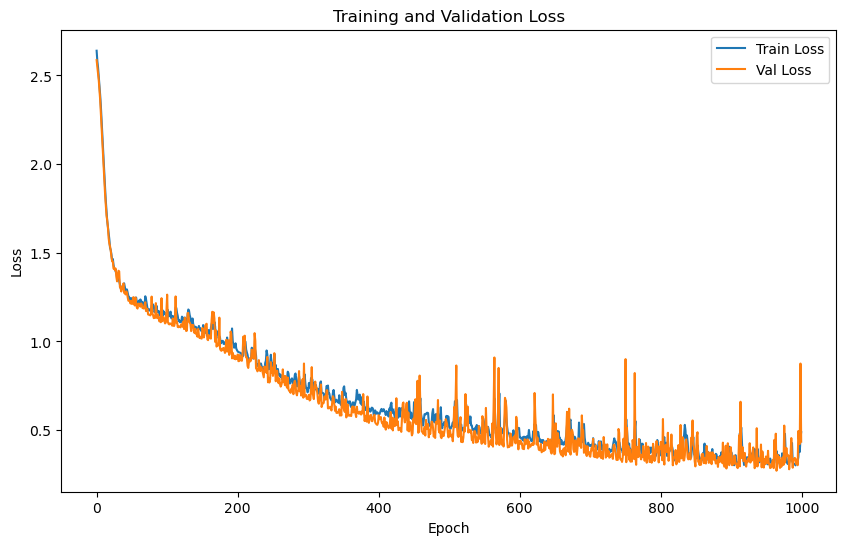

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.6278 | Test Accuracy: 78.30%


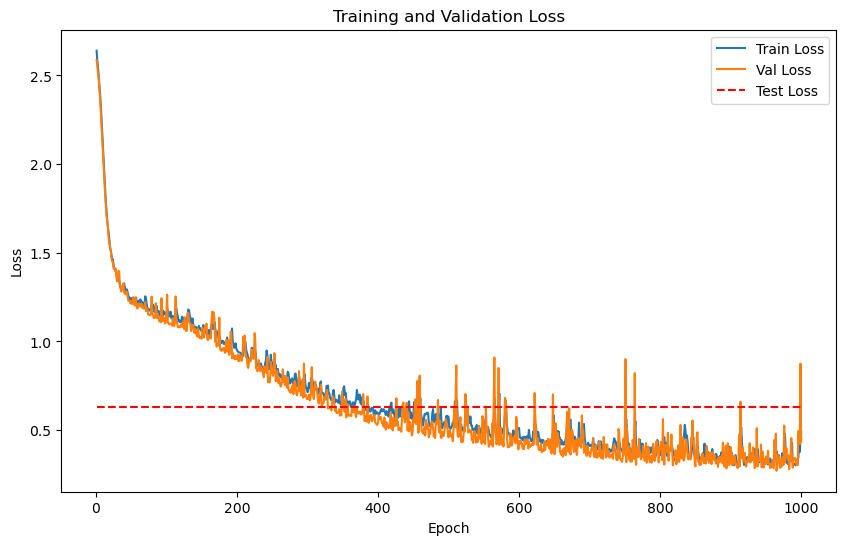

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 560 samples with 64 features each
LOG: Labels shape: (560,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2618 samples with 64 features each
LOG: Labels shape: (2618,)


Train embeddings shape: (560, 64), 
Train labels shape: (560,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (2618, 64), 
Test labels shape: (2618,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}
Training batch size: 280


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 8.4764
    Batch [2/2], Train Loss: 8.5118
Epoch [1/2000], Avg Train Loss: 8.4941
Epoch [1/2000], Avg Val Loss: 3.5705
Validation loss improved from inf to 3.5705. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 8.3914
    Batch [2/2], Train Loss: 8.3759
Epoch [2/2000], Avg Train Loss: 8.3837
Epoch [2/2000], Avg Val Loss: 3.5265
Validation loss improved from 3.5705 to 3.5265. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 8.3872
    Batch [2/2], Train Loss: 8.1275
Epoch [3/2000], Avg Train Loss: 8.2574
Epoch [3/2000], Avg Val Loss: 3.4862
Validation loss improved from 3.5265 to 3.4862. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 8.0947
    Batch [2/2], Train Loss: 8.0273
Epoch [4/2000], Avg Train Loss: 8.0610
Epoch [4/2000], Avg Val Loss: 3.4493
Validation loss improved from 3.4862 to 3.4493. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss

    Batch [1/2], Train Loss: 7.4351
    Batch [2/2], Train Loss: 7.3317
Epoch [8/2000], Avg Train Loss: 7.3834
Epoch [8/2000], Avg Val Loss: 3.3310
Validation loss improved from 3.3568 to 3.3310. Saving model...

LOG: Epoch [9/2000] - Training
    Batch [1/2], Train Loss: 7.3176
    Batch [2/2], Train Loss: 7.2810
Epoch [9/2000], Avg Train Loss: 7.2993
Epoch [9/2000], Avg Val Loss: 3.3073
Validation loss improved from 3.3310 to 3.3073. Saving model...

LOG: Epoch [10/2000] - Training
    Batch [1/2], Train Loss: 7.2859
    Batch [2/2], Train Loss: 7.1493
Epoch [10/2000], Avg Train Loss: 7.2176
Epoch [10/2000], Avg Val Loss: 3.2856
Validation loss improved from 3.3073 to 3.2856. Saving model...

LOG: Epoch [11/2000] - Training
    Batch [1/2], Train Loss: 7.1291
    Batch [2/2], Train Loss: 7.1039
Epoch [11/2000], Avg Train Loss: 7.1165
Epoch [11/2000], Avg Val Loss: 3.2657
Validation loss improved from 3.2856 to 3.2657. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/2], 

    Batch [1/2], Train Loss: 6.8481
    Batch [2/2], Train Loss: 6.8189
Epoch [14/2000], Avg Train Loss: 6.8335
Epoch [14/2000], Avg Val Loss: 3.2171
Validation loss improved from 3.2316 to 3.2171. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 6.6389
    Batch [2/2], Train Loss: 6.5913
Epoch [15/2000], Avg Train Loss: 6.6151
Epoch [15/2000], Avg Val Loss: 3.2039
Validation loss improved from 3.2171 to 3.2039. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/2], Train Loss: 6.5278
    Batch [2/2], Train Loss: 6.5280
Epoch [16/2000], Avg Train Loss: 6.5279
Epoch [16/2000], Avg Val Loss: 3.1918
Validation loss improved from 3.2039 to 3.1918. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/2], Train Loss: 6.3861
    Batch [2/2], Train Loss: 6.4149
Epoch [17/2000], Avg Train Loss: 6.4005
Epoch [17/2000], Avg Val Loss: 3.1813
Validation loss improved from 3.1918 to 3.1813. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 6.1109
    Batch [2/2], Train Loss: 5.9795
Epoch [21/2000], Avg Train Loss: 6.0452
Epoch [21/2000], Avg Val Loss: 3.1482
Validation loss improved from 3.1553 to 3.1482. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/2], Train Loss: 6.0624
    Batch [2/2], Train Loss: 6.0216
Epoch [22/2000], Avg Train Loss: 6.0420
Epoch [22/2000], Avg Val Loss: 3.1420
Validation loss improved from 3.1482 to 3.1420. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/2], Train Loss: 5.9634
    Batch [2/2], Train Loss: 6.0375
Epoch [23/2000], Avg Train Loss: 6.0005
Epoch [23/2000], Avg Val Loss: 3.1366
Validation loss improved from 3.1420 to 3.1366. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/2], Train Loss: 5.8914
    Batch [2/2], Train Loss: 5.9469
Epoch [24/2000], Avg Train Loss: 5.9191
Epoch [24/2000], Avg Val Loss: 3.1318
Validation loss improved from 3.1366 to 3.1318. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 5.7538
    Batch [2/2], Train Loss: 5.7012
Epoch [27/2000], Avg Train Loss: 5.7275
Epoch [27/2000], Avg Val Loss: 3.1201
Validation loss improved from 3.1236 to 3.1201. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/2], Train Loss: 5.7369
    Batch [2/2], Train Loss: 5.7359
Epoch [28/2000], Avg Train Loss: 5.7364
Epoch [28/2000], Avg Val Loss: 3.1170
Validation loss improved from 3.1201 to 3.1170. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/2], Train Loss: 5.6878
    Batch [2/2], Train Loss: 5.7542
Epoch [29/2000], Avg Train Loss: 5.7210
Epoch [29/2000], Avg Val Loss: 3.1141
Validation loss improved from 3.1170 to 3.1141. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/2], Train Loss: 5.6946
    Batch [2/2], Train Loss: 5.5336
Epoch [30/2000], Avg Train Loss: 5.6141
Epoch [30/2000], Avg Val Loss: 3.1115
Validation loss improved from 3.1141 to 3.1115. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 5.5578
Epoch [34/2000], Avg Train Loss: 5.5441
Epoch [34/2000], Avg Val Loss: 3.1031
Validation loss improved from 3.1049 to 3.1031. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/2], Train Loss: 5.4684
    Batch [2/2], Train Loss: 5.4497
Epoch [35/2000], Avg Train Loss: 5.4591
Epoch [35/2000], Avg Val Loss: 3.1014
Validation loss improved from 3.1031 to 3.1014. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 5.4317
    Batch [2/2], Train Loss: 5.4366
Epoch [36/2000], Avg Train Loss: 5.4342
Epoch [36/2000], Avg Val Loss: 3.0999
Validation loss improved from 3.1014 to 3.0999. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/2], Train Loss: 5.3428
    Batch [2/2], Train Loss: 5.4068
Epoch [37/2000], Avg Train Loss: 5.3748
Epoch [37/2000], Avg Val Loss: 3.0985
Validation loss improved from 3.0999 to 3.0985. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/2], Train Loss: 5.4258
    Batch [2

    Batch [1/2], Train Loss: 5.3301
    Batch [2/2], Train Loss: 5.3187
Epoch [40/2000], Avg Train Loss: 5.3244
Epoch [40/2000], Avg Val Loss: 3.0947
Validation loss improved from 3.0960 to 3.0947. Saving model...

LOG: Epoch [41/2000] - Training
    Batch [1/2], Train Loss: 5.4345
    Batch [2/2], Train Loss: 5.3381
Epoch [41/2000], Avg Train Loss: 5.3863
Epoch [41/2000], Avg Val Loss: 3.0936
Validation loss improved from 3.0947 to 3.0936. Saving model...

LOG: Epoch [42/2000] - Training
    Batch [1/2], Train Loss: 5.3284
    Batch [2/2], Train Loss: 5.2359
Epoch [42/2000], Avg Train Loss: 5.2822
Epoch [42/2000], Avg Val Loss: 3.0924
Validation loss improved from 3.0936 to 3.0924. Saving model...

LOG: Epoch [43/2000] - Training
    Batch [1/2], Train Loss: 5.2888
    Batch [2/2], Train Loss: 5.2590
Epoch [43/2000], Avg Train Loss: 5.2739
Epoch [43/2000], Avg Val Loss: 3.0912
Validation loss improved from 3.0924 to 3.0912. Saving model...

LOG: Epoch [44/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 5.2178
Epoch [47/2000], Avg Train Loss: 5.2025
Epoch [47/2000], Avg Val Loss: 3.0864
Validation loss improved from 3.0876 to 3.0864. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/2], Train Loss: 5.1886
    Batch [2/2], Train Loss: 5.2236
Epoch [48/2000], Avg Train Loss: 5.2061
Epoch [48/2000], Avg Val Loss: 3.0852
Validation loss improved from 3.0864 to 3.0852. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/2], Train Loss: 5.1989
    Batch [2/2], Train Loss: 5.1829
Epoch [49/2000], Avg Train Loss: 5.1909
Epoch [49/2000], Avg Val Loss: 3.0840
Validation loss improved from 3.0852 to 3.0840. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/2], Train Loss: 5.1775
    Batch [2/2], Train Loss: 5.1165
Epoch [50/2000], Avg Train Loss: 5.1470
Epoch [50/2000], Avg Val Loss: 3.0828
Validation loss improved from 3.0840 to 3.0828. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/2], Train Loss: 5.2110
    Batch [2

    Batch [2/2], Train Loss: 5.0668
Epoch [56/2000], Avg Train Loss: 5.0662
Epoch [56/2000], Avg Val Loss: 3.0743
Validation loss improved from 3.0758 to 3.0743. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/2], Train Loss: 5.0384
    Batch [2/2], Train Loss: 5.0719
Epoch [57/2000], Avg Train Loss: 5.0552
Epoch [57/2000], Avg Val Loss: 3.0728
Validation loss improved from 3.0743 to 3.0728. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/2], Train Loss: 5.0802
    Batch [2/2], Train Loss: 5.1154
Epoch [58/2000], Avg Train Loss: 5.0978
Epoch [58/2000], Avg Val Loss: 3.0712
Validation loss improved from 3.0728 to 3.0712. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/2], Train Loss: 5.0767
    Batch [2/2], Train Loss: 5.0624
Epoch [59/2000], Avg Train Loss: 5.0696
Epoch [59/2000], Avg Val Loss: 3.0696
Validation loss improved from 3.0712 to 3.0696. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/2], Train Loss: 5.0458
    Batch [2

    Batch [2/2], Train Loss: 5.0209
Epoch [62/2000], Avg Train Loss: 5.0096
Epoch [62/2000], Avg Val Loss: 3.0646
Validation loss improved from 3.0663 to 3.0646. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/2], Train Loss: 5.0279
    Batch [2/2], Train Loss: 5.0454
Epoch [63/2000], Avg Train Loss: 5.0367
Epoch [63/2000], Avg Val Loss: 3.0629
Validation loss improved from 3.0646 to 3.0629. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/2], Train Loss: 4.9912
    Batch [2/2], Train Loss: 5.0004
Epoch [64/2000], Avg Train Loss: 4.9958
Epoch [64/2000], Avg Val Loss: 3.0611
Validation loss improved from 3.0629 to 3.0611. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/2], Train Loss: 5.0662
    Batch [2/2], Train Loss: 5.0090
Epoch [65/2000], Avg Train Loss: 5.0376
Epoch [65/2000], Avg Val Loss: 3.0594
Validation loss improved from 3.0611 to 3.0594. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/2], Train Loss: 5.0340
    Batch [2

    Batch [2/2], Train Loss: 4.9404
Epoch [68/2000], Avg Train Loss: 4.9576
Epoch [68/2000], Avg Val Loss: 3.0542
Validation loss improved from 3.0560 to 3.0542. Saving model...

LOG: Epoch [69/2000] - Training
    Batch [1/2], Train Loss: 4.9580
    Batch [2/2], Train Loss: 5.0457
Epoch [69/2000], Avg Train Loss: 5.0018
Epoch [69/2000], Avg Val Loss: 3.0524
Validation loss improved from 3.0542 to 3.0524. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/2], Train Loss: 4.9151
    Batch [2/2], Train Loss: 5.0156
Epoch [70/2000], Avg Train Loss: 4.9653
Epoch [70/2000], Avg Val Loss: 3.0506
Validation loss improved from 3.0524 to 3.0506. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/2], Train Loss: 4.9495
    Batch [2/2], Train Loss: 5.0083
Epoch [71/2000], Avg Train Loss: 4.9789
Epoch [71/2000], Avg Val Loss: 3.0489
Validation loss improved from 3.0506 to 3.0489. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/2], Train Loss: 5.0176
    Batch [2

    Batch [2/2], Train Loss: 4.9106
Epoch [77/2000], Avg Train Loss: 4.9119
Epoch [77/2000], Avg Val Loss: 3.0387
Validation loss improved from 3.0405 to 3.0387. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/2], Train Loss: 4.9166
    Batch [2/2], Train Loss: 4.9427
Epoch [78/2000], Avg Train Loss: 4.9297
Epoch [78/2000], Avg Val Loss: 3.0369
Validation loss improved from 3.0387 to 3.0369. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/2], Train Loss: 4.9169
    Batch [2/2], Train Loss: 4.9127
Epoch [79/2000], Avg Train Loss: 4.9148
Epoch [79/2000], Avg Val Loss: 3.0350
Validation loss improved from 3.0369 to 3.0350. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1/2], Train Loss: 4.9274
    Batch [2/2], Train Loss: 4.9401
Epoch [80/2000], Avg Train Loss: 4.9338
Epoch [80/2000], Avg Val Loss: 3.0330
Validation loss improved from 3.0350 to 3.0330. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/2], Train Loss: 4.9150
    Batch [2

    Batch [2/2], Train Loss: 4.8735
Epoch [83/2000], Avg Train Loss: 4.8481
Epoch [83/2000], Avg Val Loss: 3.0271
Validation loss improved from 3.0291 to 3.0271. Saving model...

LOG: Epoch [84/2000] - Training
    Batch [1/2], Train Loss: 4.8646
    Batch [2/2], Train Loss: 4.8036
Epoch [84/2000], Avg Train Loss: 4.8341
Epoch [84/2000], Avg Val Loss: 3.0251
Validation loss improved from 3.0271 to 3.0251. Saving model...

LOG: Epoch [85/2000] - Training
    Batch [1/2], Train Loss: 4.8305
    Batch [2/2], Train Loss: 4.9059
Epoch [85/2000], Avg Train Loss: 4.8682
Epoch [85/2000], Avg Val Loss: 3.0230
Validation loss improved from 3.0251 to 3.0230. Saving model...

LOG: Epoch [86/2000] - Training
    Batch [1/2], Train Loss: 4.8855
    Batch [2/2], Train Loss: 4.9149
Epoch [86/2000], Avg Train Loss: 4.9002
Epoch [86/2000], Avg Val Loss: 3.0209
Validation loss improved from 3.0230 to 3.0209. Saving model...

LOG: Epoch [87/2000] - Training
    Batch [1/2], Train Loss: 4.8922
    Batch [2

    Batch [1/2], Train Loss: 4.9030
    Batch [2/2], Train Loss: 4.9051
Epoch [88/2000], Avg Train Loss: 4.9041
Epoch [88/2000], Avg Val Loss: 3.0168
Validation loss improved from 3.0188 to 3.0168. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/2], Train Loss: 4.8006
    Batch [2/2], Train Loss: 4.8452
Epoch [89/2000], Avg Train Loss: 4.8229
Epoch [89/2000], Avg Val Loss: 3.0148
Validation loss improved from 3.0168 to 3.0148. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/2], Train Loss: 4.7852
    Batch [2/2], Train Loss: 4.8889
Epoch [90/2000], Avg Train Loss: 4.8371
Epoch [90/2000], Avg Val Loss: 3.0128
Validation loss improved from 3.0148 to 3.0128. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/2], Train Loss: 4.8209
    Batch [2/2], Train Loss: 4.8650
Epoch [91/2000], Avg Train Loss: 4.8429
Epoch [91/2000], Avg Val Loss: 3.0108
Validation loss improved from 3.0128 to 3.0108. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 4.7790
    Batch [2/2], Train Loss: 4.8357
Epoch [98/2000], Avg Train Loss: 4.8073
Epoch [98/2000], Avg Val Loss: 2.9967
Validation loss improved from 2.9988 to 2.9967. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/2], Train Loss: 4.7807
    Batch [2/2], Train Loss: 4.8228
Epoch [99/2000], Avg Train Loss: 4.8017
Epoch [99/2000], Avg Val Loss: 2.9945
Validation loss improved from 2.9967 to 2.9945. Saving model...

LOG: Epoch [100/2000] - Training
    Batch [1/2], Train Loss: 4.8053
    Batch [2/2], Train Loss: 4.8078
Epoch [100/2000], Avg Train Loss: 4.8065
Epoch [100/2000], Avg Val Loss: 2.9924
Validation loss improved from 2.9945 to 2.9924. Saving model...

LOG: Epoch [101/2000] - Training
    Batch [1/2], Train Loss: 4.7910
    Batch [2/2], Train Loss: 4.8067
Epoch [101/2000], Avg Train Loss: 4.7989
Epoch [101/2000], Avg Val Loss: 2.9903
Validation loss improved from 2.9924 to 2.9903. Saving model...

LOG: Epoch [102/2000] - Training
    B

    Batch [1/2], Train Loss: 4.6966
    Batch [2/2], Train Loss: 4.7196
Epoch [104/2000], Avg Train Loss: 4.7081
Epoch [104/2000], Avg Val Loss: 2.9839
Validation loss improved from 2.9861 to 2.9839. Saving model...

LOG: Epoch [105/2000] - Training
    Batch [1/2], Train Loss: 4.7568
    Batch [2/2], Train Loss: 4.7546
Epoch [105/2000], Avg Train Loss: 4.7557
Epoch [105/2000], Avg Val Loss: 2.9816
Validation loss improved from 2.9839 to 2.9816. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/2], Train Loss: 4.6857
    Batch [2/2], Train Loss: 4.7689
Epoch [106/2000], Avg Train Loss: 4.7273
Epoch [106/2000], Avg Val Loss: 2.9793
Validation loss improved from 2.9816 to 2.9793. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/2], Train Loss: 4.7997
    Batch [2/2], Train Loss: 4.7032
Epoch [107/2000], Avg Train Loss: 4.7515
Epoch [107/2000], Avg Val Loss: 2.9770
Validation loss improved from 2.9793 to 2.9770. Saving model...

LOG: Epoch [108/2000] - Training


    Batch [2/2], Train Loss: 4.7783
Epoch [108/2000], Avg Train Loss: 4.7666
Epoch [108/2000], Avg Val Loss: 2.9747
Validation loss improved from 2.9770 to 2.9747. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/2], Train Loss: 4.7584
    Batch [2/2], Train Loss: 4.7531
Epoch [109/2000], Avg Train Loss: 4.7558
Epoch [109/2000], Avg Val Loss: 2.9725
Validation loss improved from 2.9747 to 2.9725. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/2], Train Loss: 4.6999
    Batch [2/2], Train Loss: 4.7493
Epoch [110/2000], Avg Train Loss: 4.7246
Epoch [110/2000], Avg Val Loss: 2.9702
Validation loss improved from 2.9725 to 2.9702. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/2], Train Loss: 4.6746
    Batch [2/2], Train Loss: 4.7830
Epoch [111/2000], Avg Train Loss: 4.7288
Epoch [111/2000], Avg Val Loss: 2.9680
Validation loss improved from 2.9702 to 2.9680. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/2], Train Loss: 4.7672


    Batch [1/2], Train Loss: 4.6302
    Batch [2/2], Train Loss: 4.7181
Epoch [119/2000], Avg Train Loss: 4.6742
Epoch [119/2000], Avg Val Loss: 2.9508
Validation loss improved from 2.9532 to 2.9508. Saving model...

LOG: Epoch [120/2000] - Training
    Batch [1/2], Train Loss: 4.7932
    Batch [2/2], Train Loss: 4.7438
Epoch [120/2000], Avg Train Loss: 4.7685
Epoch [120/2000], Avg Val Loss: 2.9486
Validation loss improved from 2.9508 to 2.9486. Saving model...

LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 4.6595
    Batch [2/2], Train Loss: 4.6981
Epoch [121/2000], Avg Train Loss: 4.6788
Epoch [121/2000], Avg Val Loss: 2.9464
Validation loss improved from 2.9486 to 2.9464. Saving model...

LOG: Epoch [122/2000] - Training
    Batch [1/2], Train Loss: 4.6934
    Batch [2/2], Train Loss: 4.7066
Epoch [122/2000], Avg Train Loss: 4.7000
Epoch [122/2000], Avg Val Loss: 2.9442
Validation loss improved from 2.9464 to 2.9442. Saving model...

LOG: Epoch [123/2000] - Training


    Batch [1/2], Train Loss: 4.7027
    Batch [2/2], Train Loss: 4.6603
Epoch [125/2000], Avg Train Loss: 4.6815
Epoch [125/2000], Avg Val Loss: 2.9376
Validation loss improved from 2.9398 to 2.9376. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/2], Train Loss: 4.6438
    Batch [2/2], Train Loss: 4.6833
Epoch [126/2000], Avg Train Loss: 4.6636
Epoch [126/2000], Avg Val Loss: 2.9353
Validation loss improved from 2.9376 to 2.9353. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/2], Train Loss: 4.7135
    Batch [2/2], Train Loss: 4.6876
Epoch [127/2000], Avg Train Loss: 4.7005
Epoch [127/2000], Avg Val Loss: 2.9331
Validation loss improved from 2.9353 to 2.9331. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/2], Train Loss: 4.7166
    Batch [2/2], Train Loss: 4.6857
Epoch [128/2000], Avg Train Loss: 4.7011
Epoch [128/2000], Avg Val Loss: 2.9310
Validation loss improved from 2.9331 to 2.9310. Saving model...

LOG: Epoch [129/2000] - Training


    Batch [1/2], Train Loss: 4.6221
    Batch [2/2], Train Loss: 4.7211
Epoch [130/2000], Avg Train Loss: 4.6716
Epoch [130/2000], Avg Val Loss: 2.9266
Validation loss improved from 2.9288 to 2.9266. Saving model...

LOG: Epoch [131/2000] - Training
    Batch [1/2], Train Loss: 4.6560
    Batch [2/2], Train Loss: 4.6786
Epoch [131/2000], Avg Train Loss: 4.6673
Epoch [131/2000], Avg Val Loss: 2.9244
Validation loss improved from 2.9266 to 2.9244. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/2], Train Loss: 4.7000
    Batch [2/2], Train Loss: 4.6523
Epoch [132/2000], Avg Train Loss: 4.6762
Epoch [132/2000], Avg Val Loss: 2.9222
Validation loss improved from 2.9244 to 2.9222. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/2], Train Loss: 4.6586
    Batch [2/2], Train Loss: 4.6352
Epoch [133/2000], Avg Train Loss: 4.6469
Epoch [133/2000], Avg Val Loss: 2.9200
Validation loss improved from 2.9222 to 2.9200. Saving model...

LOG: Epoch [134/2000] - Training


Epoch [139/2000], Avg Val Loss: 2.9065
Validation loss improved from 2.9088 to 2.9065. Saving model...

LOG: Epoch [140/2000] - Training
    Batch [1/2], Train Loss: 4.5825
    Batch [2/2], Train Loss: 4.6390
Epoch [140/2000], Avg Train Loss: 4.6107
Epoch [140/2000], Avg Val Loss: 2.9043
Validation loss improved from 2.9065 to 2.9043. Saving model...

LOG: Epoch [141/2000] - Training
    Batch [1/2], Train Loss: 4.6512
    Batch [2/2], Train Loss: 4.6220
Epoch [141/2000], Avg Train Loss: 4.6366
Epoch [141/2000], Avg Val Loss: 2.9022
Validation loss improved from 2.9043 to 2.9022. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/2], Train Loss: 4.6282
    Batch [2/2], Train Loss: 4.6340
Epoch [142/2000], Avg Train Loss: 4.6311
Epoch [142/2000], Avg Val Loss: 2.9000
Validation loss improved from 2.9022 to 2.9000. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 4.6276
    Batch [2/2], Train Loss: 4.5781
Epoch [143/2000], Avg Train Loss: 4.6029


    Batch [1/2], Train Loss: 4.6232
    Batch [2/2], Train Loss: 4.5612
Epoch [147/2000], Avg Train Loss: 4.5922
Epoch [147/2000], Avg Val Loss: 2.8889
Validation loss improved from 2.8911 to 2.8889. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/2], Train Loss: 4.6516
    Batch [2/2], Train Loss: 4.5661
Epoch [148/2000], Avg Train Loss: 4.6088
Epoch [148/2000], Avg Val Loss: 2.8867
Validation loss improved from 2.8889 to 2.8867. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/2], Train Loss: 4.6646
    Batch [2/2], Train Loss: 4.6106
Epoch [149/2000], Avg Train Loss: 4.6376
Epoch [149/2000], Avg Val Loss: 2.8845
Validation loss improved from 2.8867 to 2.8845. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/2], Train Loss: 4.6429
    Batch [2/2], Train Loss: 4.5920
Epoch [150/2000], Avg Train Loss: 4.6174
Epoch [150/2000], Avg Val Loss: 2.8824
Validation loss improved from 2.8845 to 2.8824. Saving model...

LOG: Epoch [151/2000] - Training


    Batch [1/2], Train Loss: 4.5692
    Batch [2/2], Train Loss: 4.6187
Epoch [151/2000], Avg Train Loss: 4.5940
Epoch [151/2000], Avg Val Loss: 2.8802
Validation loss improved from 2.8824 to 2.8802. Saving model...

LOG: Epoch [152/2000] - Training
    Batch [1/2], Train Loss: 4.6155
    Batch [2/2], Train Loss: 4.5624
Epoch [152/2000], Avg Train Loss: 4.5890
Epoch [152/2000], Avg Val Loss: 2.8780
Validation loss improved from 2.8802 to 2.8780. Saving model...

LOG: Epoch [153/2000] - Training
    Batch [1/2], Train Loss: 4.5797
    Batch [2/2], Train Loss: 4.5657
Epoch [153/2000], Avg Train Loss: 4.5727
Epoch [153/2000], Avg Val Loss: 2.8757
Validation loss improved from 2.8780 to 2.8757. Saving model...

LOG: Epoch [154/2000] - Training
    Batch [1/2], Train Loss: 4.5719
    Batch [2/2], Train Loss: 4.6204
Epoch [154/2000], Avg Train Loss: 4.5961
Epoch [154/2000], Avg Val Loss: 2.8735
Validation loss improved from 2.8757 to 2.8735. Saving model...

LOG: Epoch [155/2000] - Training


Epoch [159/2000], Avg Val Loss: 2.8626
Validation loss improved from 2.8648 to 2.8626. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/2], Train Loss: 4.5670
    Batch [2/2], Train Loss: 4.5336
Epoch [160/2000], Avg Train Loss: 4.5503
Epoch [160/2000], Avg Val Loss: 2.8603
Validation loss improved from 2.8626 to 2.8603. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/2], Train Loss: 4.5468
    Batch [2/2], Train Loss: 4.5871
Epoch [161/2000], Avg Train Loss: 4.5670
Epoch [161/2000], Avg Val Loss: 2.8581
Validation loss improved from 2.8603 to 2.8581. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/2], Train Loss: 4.5785
    Batch [2/2], Train Loss: 4.4906
Epoch [162/2000], Avg Train Loss: 4.5346
Epoch [162/2000], Avg Val Loss: 2.8559
Validation loss improved from 2.8581 to 2.8559. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/2], Train Loss: 4.5449
    Batch [2/2], Train Loss: 4.5229
Epoch [163/2000], Avg Train Loss: 4.5339


    Batch [2/2], Train Loss: 4.5454
Epoch [167/2000], Avg Train Loss: 4.5694
Epoch [167/2000], Avg Val Loss: 2.8447
Validation loss improved from 2.8469 to 2.8447. Saving model...

LOG: Epoch [168/2000] - Training
    Batch [1/2], Train Loss: 4.5485
    Batch [2/2], Train Loss: 4.5831
Epoch [168/2000], Avg Train Loss: 4.5658
Epoch [168/2000], Avg Val Loss: 2.8425
Validation loss improved from 2.8447 to 2.8425. Saving model...

LOG: Epoch [169/2000] - Training
    Batch [1/2], Train Loss: 4.5096
    Batch [2/2], Train Loss: 4.5429
Epoch [169/2000], Avg Train Loss: 4.5263
Epoch [169/2000], Avg Val Loss: 2.8404
Validation loss improved from 2.8425 to 2.8404. Saving model...

LOG: Epoch [170/2000] - Training


    Batch [1/2], Train Loss: 4.5219
    Batch [2/2], Train Loss: 4.4972
Epoch [170/2000], Avg Train Loss: 4.5096
Epoch [170/2000], Avg Val Loss: 2.8382
Validation loss improved from 2.8404 to 2.8382. Saving model...

LOG: Epoch [171/2000] - Training
    Batch [1/2], Train Loss: 4.5069
    Batch [2/2], Train Loss: 4.5501
Epoch [171/2000], Avg Train Loss: 4.5285
Epoch [171/2000], Avg Val Loss: 2.8359
Validation loss improved from 2.8382 to 2.8359. Saving model...

LOG: Epoch [172/2000] - Training
    Batch [1/2], Train Loss: 4.5182
    Batch [2/2], Train Loss: 4.5393
Epoch [172/2000], Avg Train Loss: 4.5287
Epoch [172/2000], Avg Val Loss: 2.8336
Validation loss improved from 2.8359 to 2.8336. Saving model...

LOG: Epoch [173/2000] - Training
    Batch [1/2], Train Loss: 4.5399
    Batch [2/2], Train Loss: 4.5258
Epoch [173/2000], Avg Train Loss: 4.5328
Epoch [173/2000], Avg Val Loss: 2.8313
Validation loss improved from 2.8336 to 2.8313. Saving model...

LOG: Epoch [174/2000] - Training


    Batch [2/2], Train Loss: 4.5058
Epoch [180/2000], Avg Train Loss: 4.4895
Epoch [180/2000], Avg Val Loss: 2.8151
Validation loss improved from 2.8172 to 2.8151. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/2], Train Loss: 4.4881
    Batch [2/2], Train Loss: 4.5179
Epoch [181/2000], Avg Train Loss: 4.5030
Epoch [181/2000], Avg Val Loss: 2.8129
Validation loss improved from 2.8151 to 2.8129. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/2], Train Loss: 4.5048
    Batch [2/2], Train Loss: 4.4748
Epoch [182/2000], Avg Train Loss: 4.4898
Epoch [182/2000], Avg Val Loss: 2.8108
Validation loss improved from 2.8129 to 2.8108. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/2], Train Loss: 4.4821
    Batch [2/2], Train Loss: 4.4682
Epoch [183/2000], Avg Train Loss: 4.4751
Epoch [183/2000], Avg Val Loss: 2.8087
Validation loss improved from 2.8108 to 2.8087. Saving model...

LOG: Epoch [184/2000] - Training
    Batch [1/2], Train Loss: 4.4972


Epoch [186/2000], Avg Val Loss: 2.8023
Validation loss improved from 2.8044 to 2.8023. Saving model...

LOG: Epoch [187/2000] - Training
    Batch [1/2], Train Loss: 4.5112
    Batch [2/2], Train Loss: 4.4988
Epoch [187/2000], Avg Train Loss: 4.5050
Epoch [187/2000], Avg Val Loss: 2.8002
Validation loss improved from 2.8023 to 2.8002. Saving model...

LOG: Epoch [188/2000] - Training
    Batch [1/2], Train Loss: 4.4660
    Batch [2/2], Train Loss: 4.4579
Epoch [188/2000], Avg Train Loss: 4.4620
Epoch [188/2000], Avg Val Loss: 2.7981
Validation loss improved from 2.8002 to 2.7981. Saving model...

LOG: Epoch [189/2000] - Training
    Batch [1/2], Train Loss: 4.4258
    Batch [2/2], Train Loss: 4.4666
Epoch [189/2000], Avg Train Loss: 4.4462
Epoch [189/2000], Avg Val Loss: 2.7959
Validation loss improved from 2.7981 to 2.7959. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/2], Train Loss: 4.5366
    Batch [2/2], Train Loss: 4.4335
Epoch [190/2000], Avg Train Loss: 4.4851


    Batch [1/2], Train Loss: 4.4299
    Batch [2/2], Train Loss: 4.4571
Epoch [191/2000], Avg Train Loss: 4.4435
Epoch [191/2000], Avg Val Loss: 2.7914
Validation loss improved from 2.7936 to 2.7914. Saving model...

LOG: Epoch [192/2000] - Training
    Batch [1/2], Train Loss: 4.4270
    Batch [2/2], Train Loss: 4.4305
Epoch [192/2000], Avg Train Loss: 4.4287
Epoch [192/2000], Avg Val Loss: 2.7891
Validation loss improved from 2.7914 to 2.7891. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/2], Train Loss: 4.5039
    Batch [2/2], Train Loss: 4.5064
Epoch [193/2000], Avg Train Loss: 4.5052
Epoch [193/2000], Avg Val Loss: 2.7868
Validation loss improved from 2.7891 to 2.7868. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/2], Train Loss: 4.4369
    Batch [2/2], Train Loss: 4.4748
Epoch [194/2000], Avg Train Loss: 4.4558
Epoch [194/2000], Avg Val Loss: 2.7846
Validation loss improved from 2.7868 to 2.7846. Saving model...

LOG: Epoch [195/2000] - Training


    Batch [1/2], Train Loss: 4.4830
    Batch [2/2], Train Loss: 4.4215
Epoch [201/2000], Avg Train Loss: 4.4522
Epoch [201/2000], Avg Val Loss: 2.7693
Validation loss improved from 2.7715 to 2.7693. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/2], Train Loss: 4.4387
    Batch [2/2], Train Loss: 4.4294
Epoch [202/2000], Avg Train Loss: 4.4341
Epoch [202/2000], Avg Val Loss: 2.7671
Validation loss improved from 2.7693 to 2.7671. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/2], Train Loss: 4.4376
    Batch [2/2], Train Loss: 4.3860
Epoch [203/2000], Avg Train Loss: 4.4118
Epoch [203/2000], Avg Val Loss: 2.7649
Validation loss improved from 2.7671 to 2.7649. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/2], Train Loss: 4.4512
    Batch [2/2], Train Loss: 4.4320
Epoch [204/2000], Avg Train Loss: 4.4416
Epoch [204/2000], Avg Val Loss: 2.7626
Validation loss improved from 2.7649 to 2.7626. Saving model...

LOG: Epoch [205/2000] - Training


    Batch [2/2], Train Loss: 4.3792
Epoch [207/2000], Avg Train Loss: 4.4000
Epoch [207/2000], Avg Val Loss: 2.7557
Validation loss improved from 2.7580 to 2.7557. Saving model...

LOG: Epoch [208/2000] - Training
    Batch [1/2], Train Loss: 4.3940
    Batch [2/2], Train Loss: 4.4418
Epoch [208/2000], Avg Train Loss: 4.4179
Epoch [208/2000], Avg Val Loss: 2.7534
Validation loss improved from 2.7557 to 2.7534. Saving model...

LOG: Epoch [209/2000] - Training
    Batch [1/2], Train Loss: 4.3896
    Batch [2/2], Train Loss: 4.4202
Epoch [209/2000], Avg Train Loss: 4.4049
Epoch [209/2000], Avg Val Loss: 2.7511
Validation loss improved from 2.7534 to 2.7511. Saving model...

LOG: Epoch [210/2000] - Training
    Batch [1/2], Train Loss: 4.4498
    Batch [2/2], Train Loss: 4.4370
Epoch [210/2000], Avg Train Loss: 4.4434
Epoch [210/2000], Avg Val Loss: 2.7488
Validation loss improved from 2.7511 to 2.7488. Saving model...

LOG: Epoch [211/2000] - Training
    Batch [1/2], Train Loss: 4.4046


    Batch [1/2], Train Loss: 4.3659
    Batch [2/2], Train Loss: 4.3691
Epoch [212/2000], Avg Train Loss: 4.3675
Epoch [212/2000], Avg Val Loss: 2.7443
Validation loss improved from 2.7466 to 2.7443. Saving model...

LOG: Epoch [213/2000] - Training
    Batch [1/2], Train Loss: 4.3926
    Batch [2/2], Train Loss: 4.4171
Epoch [213/2000], Avg Train Loss: 4.4049
Epoch [213/2000], Avg Val Loss: 2.7421
Validation loss improved from 2.7443 to 2.7421. Saving model...

LOG: Epoch [214/2000] - Training
    Batch [1/2], Train Loss: 4.3783
    Batch [2/2], Train Loss: 4.3967
Epoch [214/2000], Avg Train Loss: 4.3875
Epoch [214/2000], Avg Val Loss: 2.7398
Validation loss improved from 2.7421 to 2.7398. Saving model...

LOG: Epoch [215/2000] - Training
    Batch [1/2], Train Loss: 4.3613
    Batch [2/2], Train Loss: 4.3592
Epoch [215/2000], Avg Train Loss: 4.3602
Epoch [215/2000], Avg Val Loss: 2.7376
Validation loss improved from 2.7398 to 2.7376. Saving model...

LOG: Epoch [216/2000] - Training


    Batch [1/2], Train Loss: 4.3580
    Batch [2/2], Train Loss: 4.3541
Epoch [222/2000], Avg Train Loss: 4.3560
Epoch [222/2000], Avg Val Loss: 2.7225
Validation loss improved from 2.7247 to 2.7225. Saving model...

LOG: Epoch [223/2000] - Training
    Batch [1/2], Train Loss: 4.3951
    Batch [2/2], Train Loss: 4.3511
Epoch [223/2000], Avg Train Loss: 4.3731
Epoch [223/2000], Avg Val Loss: 2.7204
Validation loss improved from 2.7225 to 2.7204. Saving model...

LOG: Epoch [224/2000] - Training
    Batch [1/2], Train Loss: 4.3885
    Batch [2/2], Train Loss: 4.4211
Epoch [224/2000], Avg Train Loss: 4.4048
Epoch [224/2000], Avg Val Loss: 2.7184
Validation loss improved from 2.7204 to 2.7184. Saving model...

LOG: Epoch [225/2000] - Training
    Batch [1/2], Train Loss: 4.3415
    Batch [2/2], Train Loss: 4.3302
Epoch [225/2000], Avg Train Loss: 4.3358
Epoch [225/2000], Avg Val Loss: 2.7162
Validation loss improved from 2.7184 to 2.7162. Saving model...

LOG: Epoch [226/2000] - Training


    Batch [2/2], Train Loss: 4.3989
Epoch [227/2000], Avg Train Loss: 4.3858
Epoch [227/2000], Avg Val Loss: 2.7120
Validation loss improved from 2.7141 to 2.7120. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/2], Train Loss: 4.3818
    Batch [2/2], Train Loss: 4.3844
Epoch [228/2000], Avg Train Loss: 4.3831
Epoch [228/2000], Avg Val Loss: 2.7100
Validation loss improved from 2.7120 to 2.7100. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/2], Train Loss: 4.3345
    Batch [2/2], Train Loss: 4.3669
Epoch [229/2000], Avg Train Loss: 4.3507
Epoch [229/2000], Avg Val Loss: 2.7080
Validation loss improved from 2.7100 to 2.7080. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/2], Train Loss: 4.3552
    Batch [2/2], Train Loss: 4.3533
Epoch [230/2000], Avg Train Loss: 4.3542
Epoch [230/2000], Avg Val Loss: 2.7061
Validation loss improved from 2.7080 to 2.7061. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/2], Train Loss: 4.3706


    Batch [1/2], Train Loss: 4.3192
    Batch [2/2], Train Loss: 4.2995
Epoch [233/2000], Avg Train Loss: 4.3093
Epoch [233/2000], Avg Val Loss: 2.7004
Validation loss improved from 2.7023 to 2.7004. Saving model...

LOG: Epoch [234/2000] - Training
    Batch [1/2], Train Loss: 4.3663
    Batch [2/2], Train Loss: 4.3245
Epoch [234/2000], Avg Train Loss: 4.3454
Epoch [234/2000], Avg Val Loss: 2.6985
Validation loss improved from 2.7004 to 2.6985. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/2], Train Loss: 4.3750
    Batch [2/2], Train Loss: 4.3426
Epoch [235/2000], Avg Train Loss: 4.3588
Epoch [235/2000], Avg Val Loss: 2.6966
Validation loss improved from 2.6985 to 2.6966. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/2], Train Loss: 4.3533
    Batch [2/2], Train Loss: 4.3621
Epoch [236/2000], Avg Train Loss: 4.3577
Epoch [236/2000], Avg Val Loss: 2.6946
Validation loss improved from 2.6966 to 2.6946. Saving model...

LOG: Epoch [237/2000] - Training


Epoch [243/2000], Avg Val Loss: 2.6803
Validation loss improved from 2.6823 to 2.6803. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/2], Train Loss: 4.3244
    Batch [2/2], Train Loss: 4.3445
Epoch [244/2000], Avg Train Loss: 4.3345
Epoch [244/2000], Avg Val Loss: 2.6783
Validation loss improved from 2.6803 to 2.6783. Saving model...

LOG: Epoch [245/2000] - Training
    Batch [1/2], Train Loss: 4.3619
    Batch [2/2], Train Loss: 4.3628
Epoch [245/2000], Avg Train Loss: 4.3623
Epoch [245/2000], Avg Val Loss: 2.6764
Validation loss improved from 2.6783 to 2.6764. Saving model...

LOG: Epoch [246/2000] - Training
    Batch [1/2], Train Loss: 4.3130
    Batch [2/2], Train Loss: 4.2926
Epoch [246/2000], Avg Train Loss: 4.3028
Epoch [246/2000], Avg Val Loss: 2.6747
Validation loss improved from 2.6764 to 2.6747. Saving model...

LOG: Epoch [247/2000] - Training


    Batch [1/2], Train Loss: 4.3376
    Batch [2/2], Train Loss: 4.3126
Epoch [247/2000], Avg Train Loss: 4.3251
Epoch [247/2000], Avg Val Loss: 2.6728
Validation loss improved from 2.6747 to 2.6728. Saving model...

LOG: Epoch [248/2000] - Training
    Batch [1/2], Train Loss: 4.2800
    Batch [2/2], Train Loss: 4.2734
Epoch [248/2000], Avg Train Loss: 4.2767
Epoch [248/2000], Avg Val Loss: 2.6709
Validation loss improved from 2.6728 to 2.6709. Saving model...

LOG: Epoch [249/2000] - Training
    Batch [1/2], Train Loss: 4.2913
    Batch [2/2], Train Loss: 4.3319
Epoch [249/2000], Avg Train Loss: 4.3116
Epoch [249/2000], Avg Val Loss: 2.6692
Validation loss improved from 2.6709 to 2.6692. Saving model...

LOG: Epoch [250/2000] - Training
    Batch [1/2], Train Loss: 4.3160
    Batch [2/2], Train Loss: 4.3177
Epoch [250/2000], Avg Train Loss: 4.3169
Epoch [250/2000], Avg Val Loss: 2.6674
Validation loss improved from 2.6692 to 2.6674. Saving model...

LOG: Epoch [251/2000] - Training


    Batch [2/2], Train Loss: 4.3454
Epoch [252/2000], Avg Train Loss: 4.3297
Epoch [252/2000], Avg Val Loss: 2.6641
Validation loss improved from 2.6657 to 2.6641. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/2], Train Loss: 4.2985
    Batch [2/2], Train Loss: 4.2622
Epoch [253/2000], Avg Train Loss: 4.2803
Epoch [253/2000], Avg Val Loss: 2.6626
Validation loss improved from 2.6641 to 2.6626. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/2], Train Loss: 4.2877
    Batch [2/2], Train Loss: 4.2784
Epoch [254/2000], Avg Train Loss: 4.2830
Epoch [254/2000], Avg Val Loss: 2.6609
Validation loss improved from 2.6626 to 2.6609. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/2], Train Loss: 4.2550
    Batch [2/2], Train Loss: 4.2939
Epoch [255/2000], Avg Train Loss: 4.2744
Epoch [255/2000], Avg Val Loss: 2.6593
Validation loss improved from 2.6609 to 2.6593. Saving model...

LOG: Epoch [256/2000] - Training
    Batch [1/2], Train Loss: 4.2341


    Batch [1/2], Train Loss: 4.2415
    Batch [2/2], Train Loss: 4.2488
Epoch [265/2000], Avg Train Loss: 4.2451
Epoch [265/2000], Avg Val Loss: 2.6432
Validation loss improved from 2.6448 to 2.6432. Saving model...

LOG: Epoch [266/2000] - Training
    Batch [1/2], Train Loss: 4.2688
    Batch [2/2], Train Loss: 4.2561
Epoch [266/2000], Avg Train Loss: 4.2624
Epoch [266/2000], Avg Val Loss: 2.6416
Validation loss improved from 2.6432 to 2.6416. Saving model...

LOG: Epoch [267/2000] - Training
    Batch [1/2], Train Loss: 4.2598
    Batch [2/2], Train Loss: 4.2747
Epoch [267/2000], Avg Train Loss: 4.2672
Epoch [267/2000], Avg Val Loss: 2.6400
Validation loss improved from 2.6416 to 2.6400. Saving model...

LOG: Epoch [268/2000] - Training
    Batch [1/2], Train Loss: 4.2565
    Batch [2/2], Train Loss: 4.2762
Epoch [268/2000], Avg Train Loss: 4.2664
Epoch [268/2000], Avg Val Loss: 2.6384
Validation loss improved from 2.6400 to 2.6384. Saving model...

LOG: Epoch [269/2000] - Training


    Batch [2/2], Train Loss: 4.2849
Epoch [269/2000], Avg Train Loss: 4.2588
Epoch [269/2000], Avg Val Loss: 2.6367
Validation loss improved from 2.6384 to 2.6367. Saving model...

LOG: Epoch [270/2000] - Training
    Batch [1/2], Train Loss: 4.2191
    Batch [2/2], Train Loss: 4.3273
Epoch [270/2000], Avg Train Loss: 4.2732
Epoch [270/2000], Avg Val Loss: 2.6349
Validation loss improved from 2.6367 to 2.6349. Saving model...

LOG: Epoch [271/2000] - Training
    Batch [1/2], Train Loss: 4.2666
    Batch [2/2], Train Loss: 4.1928
Epoch [271/2000], Avg Train Loss: 4.2297
Epoch [271/2000], Avg Val Loss: 2.6332
Validation loss improved from 2.6349 to 2.6332. Saving model...

LOG: Epoch [272/2000] - Training
    Batch [1/2], Train Loss: 4.2725
    Batch [2/2], Train Loss: 4.2416
Epoch [272/2000], Avg Train Loss: 4.2571
Epoch [272/2000], Avg Val Loss: 2.6315
Validation loss improved from 2.6332 to 2.6315. Saving model...

LOG: Epoch [273/2000] - Training
    Batch [1/2], Train Loss: 4.2121


    Batch [2/2], Train Loss: 4.2552
Epoch [273/2000], Avg Train Loss: 4.2337
Epoch [273/2000], Avg Val Loss: 2.6297
Validation loss improved from 2.6315 to 2.6297. Saving model...

LOG: Epoch [274/2000] - Training
    Batch [1/2], Train Loss: 4.2414
    Batch [2/2], Train Loss: 4.2506
Epoch [274/2000], Avg Train Loss: 4.2460
Epoch [274/2000], Avg Val Loss: 2.6280
Validation loss improved from 2.6297 to 2.6280. Saving model...

LOG: Epoch [275/2000] - Training
    Batch [1/2], Train Loss: 4.2703
    Batch [2/2], Train Loss: 4.2417
Epoch [275/2000], Avg Train Loss: 4.2560
Epoch [275/2000], Avg Val Loss: 2.6263
Validation loss improved from 2.6280 to 2.6263. Saving model...

LOG: Epoch [276/2000] - Training
    Batch [1/2], Train Loss: 4.2206
    Batch [2/2], Train Loss: 4.1999
Epoch [276/2000], Avg Train Loss: 4.2103
Epoch [276/2000], Avg Val Loss: 2.6245
Validation loss improved from 2.6263 to 2.6245. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/2], Train Loss: 4.2619


Epoch [282/2000], Avg Train Loss: 4.2144
Epoch [282/2000], Avg Val Loss: 2.6153
Validation loss improved from 2.6167 to 2.6153. Saving model...

LOG: Epoch [283/2000] - Training
    Batch [1/2], Train Loss: 4.2152
    Batch [2/2], Train Loss: 4.2409
Epoch [283/2000], Avg Train Loss: 4.2280
Epoch [283/2000], Avg Val Loss: 2.6139
Validation loss improved from 2.6153 to 2.6139. Saving model...

LOG: Epoch [284/2000] - Training
    Batch [1/2], Train Loss: 4.2460
    Batch [2/2], Train Loss: 4.2595
Epoch [284/2000], Avg Train Loss: 4.2527
Epoch [284/2000], Avg Val Loss: 2.6125
Validation loss improved from 2.6139 to 2.6125. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/2], Train Loss: 4.2322
    Batch [2/2], Train Loss: 4.2690
Epoch [285/2000], Avg Train Loss: 4.2506
Epoch [285/2000], Avg Val Loss: 2.6112
Validation loss improved from 2.6125 to 2.6112. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/2], Train Loss: 4.2334
    Batch [2/2], Train Loss: 4.2250


    Batch [2/2], Train Loss: 4.1870
Epoch [289/2000], Avg Train Loss: 4.1821
Epoch [289/2000], Avg Val Loss: 2.6056
Validation loss improved from 2.6071 to 2.6056. Saving model...

LOG: Epoch [290/2000] - Training
    Batch [1/2], Train Loss: 4.1474
    Batch [2/2], Train Loss: 4.1935
Epoch [290/2000], Avg Train Loss: 4.1705
Epoch [290/2000], Avg Val Loss: 2.6041
Validation loss improved from 2.6056 to 2.6041. Saving model...

LOG: Epoch [291/2000] - Training
    Batch [1/2], Train Loss: 4.2354
    Batch [2/2], Train Loss: 4.1641
Epoch [291/2000], Avg Train Loss: 4.1997
Epoch [291/2000], Avg Val Loss: 2.6025
Validation loss improved from 2.6041 to 2.6025. Saving model...

LOG: Epoch [292/2000] - Training
    Batch [1/2], Train Loss: 4.2005
    Batch [2/2], Train Loss: 4.2014
Epoch [292/2000], Avg Train Loss: 4.2009
Epoch [292/2000], Avg Val Loss: 2.6009
Validation loss improved from 2.6025 to 2.6009. Saving model...

LOG: Epoch [293/2000] - Training
    Batch [1/2], Train Loss: 4.1712


    Batch [1/2], Train Loss: 4.2273
    Batch [2/2], Train Loss: 4.2023
Epoch [294/2000], Avg Train Loss: 4.2148
Epoch [294/2000], Avg Val Loss: 2.5978
Validation loss improved from 2.5993 to 2.5978. Saving model...

LOG: Epoch [295/2000] - Training
    Batch [1/2], Train Loss: 4.1824
    Batch [2/2], Train Loss: 4.1587
Epoch [295/2000], Avg Train Loss: 4.1706
Epoch [295/2000], Avg Val Loss: 2.5961
Validation loss improved from 2.5978 to 2.5961. Saving model...

LOG: Epoch [296/2000] - Training
    Batch [1/2], Train Loss: 4.1442
    Batch [2/2], Train Loss: 4.2023
Epoch [296/2000], Avg Train Loss: 4.1733
Epoch [296/2000], Avg Val Loss: 2.5945
Validation loss improved from 2.5961 to 2.5945. Saving model...

LOG: Epoch [297/2000] - Training
    Batch [1/2], Train Loss: 4.2333
    Batch [2/2], Train Loss: 4.2024
Epoch [297/2000], Avg Train Loss: 4.2178
Epoch [297/2000], Avg Val Loss: 2.5931
Validation loss improved from 2.5945 to 2.5931. Saving model...

LOG: Epoch [298/2000] - Training


    Batch [2/2], Train Loss: 4.1388
Epoch [302/2000], Avg Train Loss: 4.1655
Epoch [302/2000], Avg Val Loss: 2.5863
Validation loss improved from 2.5877 to 2.5863. Saving model...

LOG: Epoch [303/2000] - Training
    Batch [1/2], Train Loss: 4.1684
    Batch [2/2], Train Loss: 4.1621
Epoch [303/2000], Avg Train Loss: 4.1652
Epoch [303/2000], Avg Val Loss: 2.5850
Validation loss improved from 2.5863 to 2.5850. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/2], Train Loss: 4.2220
    Batch [2/2], Train Loss: 4.1717
Epoch [304/2000], Avg Train Loss: 4.1968
Epoch [304/2000], Avg Val Loss: 2.5838
Validation loss improved from 2.5850 to 2.5838. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/2], Train Loss: 4.1473
    Batch [2/2], Train Loss: 4.2121
Epoch [305/2000], Avg Train Loss: 4.1797
Epoch [305/2000], Avg Val Loss: 2.5826
Validation loss improved from 2.5838 to 2.5826. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/2], Train Loss: 4.1947


    Batch [2/2], Train Loss: 4.1665
Epoch [309/2000], Avg Train Loss: 4.1744
Epoch [309/2000], Avg Val Loss: 2.5776
Validation loss improved from 2.5789 to 2.5776. Saving model...

LOG: Epoch [310/2000] - Training
    Batch [1/2], Train Loss: 4.0805


    Batch [2/2], Train Loss: 4.1343
Epoch [310/2000], Avg Train Loss: 4.1074
Epoch [310/2000], Avg Val Loss: 2.5763
Validation loss improved from 2.5776 to 2.5763. Saving model...

LOG: Epoch [311/2000] - Training
    Batch [1/2], Train Loss: 4.1416
    Batch [2/2], Train Loss: 4.1384
Epoch [311/2000], Avg Train Loss: 4.1400
Epoch [311/2000], Avg Val Loss: 2.5750
Validation loss improved from 2.5763 to 2.5750. Saving model...

LOG: Epoch [312/2000] - Training
    Batch [1/2], Train Loss: 4.0898
    Batch [2/2], Train Loss: 4.1755
Epoch [312/2000], Avg Train Loss: 4.1327
Epoch [312/2000], Avg Val Loss: 2.5738
Validation loss improved from 2.5750 to 2.5738. Saving model...

LOG: Epoch [313/2000] - Training


    Batch [1/2], Train Loss: 4.1174
    Batch [2/2], Train Loss: 4.1505
Epoch [313/2000], Avg Train Loss: 4.1340
Epoch [313/2000], Avg Val Loss: 2.5728
Validation loss improved from 2.5738 to 2.5728. Saving model...

LOG: Epoch [314/2000] - Training
    Batch [1/2], Train Loss: 4.1740
    Batch [2/2], Train Loss: 4.1337
Epoch [314/2000], Avg Train Loss: 4.1539
Epoch [314/2000], Avg Val Loss: 2.5716
Validation loss improved from 2.5728 to 2.5716. Saving model...

LOG: Epoch [315/2000] - Training
    Batch [1/2], Train Loss: 4.1540
    Batch [2/2], Train Loss: 4.2163
Epoch [315/2000], Avg Train Loss: 4.1851
Epoch [315/2000], Avg Val Loss: 2.5703
Validation loss improved from 2.5716 to 2.5703. Saving model...

LOG: Epoch [316/2000] - Training
    Batch [1/2], Train Loss: 4.1146
    Batch [2/2], Train Loss: 4.1340
Epoch [316/2000], Avg Train Loss: 4.1243
Epoch [316/2000], Avg Val Loss: 2.5690
Validation loss improved from 2.5703 to 2.5690. Saving model...

LOG: Epoch [317/2000] - Training


    Batch [2/2], Train Loss: 4.2020
Epoch [322/2000], Avg Train Loss: 4.1730
Epoch [322/2000], Avg Val Loss: 2.5604
Validation loss improved from 2.5616 to 2.5604. Saving model...

LOG: Epoch [323/2000] - Training
    Batch [1/2], Train Loss: 4.2126
    Batch [2/2], Train Loss: 4.1652
Epoch [323/2000], Avg Train Loss: 4.1889
Epoch [323/2000], Avg Val Loss: 2.5593
Validation loss improved from 2.5604 to 2.5593. Saving model...

LOG: Epoch [324/2000] - Training
    Batch [1/2], Train Loss: 4.1009
    Batch [2/2], Train Loss: 4.0805
Epoch [324/2000], Avg Train Loss: 4.0907
Epoch [324/2000], Avg Val Loss: 2.5582
Validation loss improved from 2.5593 to 2.5582. Saving model...

LOG: Epoch [325/2000] - Training
    Batch [1/2], Train Loss: 4.1541
    Batch [2/2], Train Loss: 4.1730
Epoch [325/2000], Avg Train Loss: 4.1636
Epoch [325/2000], Avg Val Loss: 2.5571
Validation loss improved from 2.5582 to 2.5571. Saving model...

LOG: Epoch [326/2000] - Training
    Batch [1/2], Train Loss: 4.1269


Epoch [329/2000], Avg Val Loss: 2.5521
Validation loss improved from 2.5534 to 2.5521. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/2], Train Loss: 4.1166
    Batch [2/2], Train Loss: 4.0925
Epoch [330/2000], Avg Train Loss: 4.1045
Epoch [330/2000], Avg Val Loss: 2.5507
Validation loss improved from 2.5521 to 2.5507. Saving model...

LOG: Epoch [331/2000] - Training
    Batch [1/2], Train Loss: 4.1581
    Batch [2/2], Train Loss: 4.1312
Epoch [331/2000], Avg Train Loss: 4.1447
Epoch [331/2000], Avg Val Loss: 2.5494
Validation loss improved from 2.5507 to 2.5494. Saving model...

LOG: Epoch [332/2000] - Training
    Batch [1/2], Train Loss: 4.1040
    Batch [2/2], Train Loss: 4.0938
Epoch [332/2000], Avg Train Loss: 4.0989
Epoch [332/2000], Avg Val Loss: 2.5481
Validation loss improved from 2.5494 to 2.5481. Saving model...

LOG: Epoch [333/2000] - Training


    Batch [1/2], Train Loss: 4.0906
    Batch [2/2], Train Loss: 4.0894
Epoch [333/2000], Avg Train Loss: 4.0900
Epoch [333/2000], Avg Val Loss: 2.5470
Validation loss improved from 2.5481 to 2.5470. Saving model...

LOG: Epoch [334/2000] - Training
    Batch [1/2], Train Loss: 4.0883
    Batch [2/2], Train Loss: 4.1312
Epoch [334/2000], Avg Train Loss: 4.1098
Epoch [334/2000], Avg Val Loss: 2.5459
Validation loss improved from 2.5470 to 2.5459. Saving model...

LOG: Epoch [335/2000] - Training
    Batch [1/2], Train Loss: 4.0868
    Batch [2/2], Train Loss: 4.0702
Epoch [335/2000], Avg Train Loss: 4.0785
Epoch [335/2000], Avg Val Loss: 2.5448
Validation loss improved from 2.5459 to 2.5448. Saving model...

LOG: Epoch [336/2000] - Training
    Batch [1/2], Train Loss: 4.0916
    Batch [2/2], Train Loss: 4.1490
Epoch [336/2000], Avg Train Loss: 4.1203
Epoch [336/2000], Avg Val Loss: 2.5437
Validation loss improved from 2.5448 to 2.5437. Saving model...

LOG: Epoch [337/2000] - Training


    Batch [2/2], Train Loss: 4.0859
Epoch [343/2000], Avg Train Loss: 4.0821
Epoch [343/2000], Avg Val Loss: 2.5345
Validation loss improved from 2.5358 to 2.5345. Saving model...

LOG: Epoch [344/2000] - Training
    Batch [1/2], Train Loss: 4.1040
    Batch [2/2], Train Loss: 4.0786
Epoch [344/2000], Avg Train Loss: 4.0913
Epoch [344/2000], Avg Val Loss: 2.5332
Validation loss improved from 2.5345 to 2.5332. Saving model...

LOG: Epoch [345/2000] - Training
    Batch [1/2], Train Loss: 4.0769
    Batch [2/2], Train Loss: 4.1056
Epoch [345/2000], Avg Train Loss: 4.0913
Epoch [345/2000], Avg Val Loss: 2.5318
Validation loss improved from 2.5332 to 2.5318. Saving model...

LOG: Epoch [346/2000] - Training
    Batch [1/2], Train Loss: 4.1119
    Batch [2/2], Train Loss: 4.0543
Epoch [346/2000], Avg Train Loss: 4.0831
Epoch [346/2000], Avg Val Loss: 2.5304
Validation loss improved from 2.5318 to 2.5304. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/2], Train Loss: 4.1296


Epoch [349/2000], Avg Val Loss: 2.5268
Validation loss improved from 2.5280 to 2.5268. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/2], Train Loss: 4.1051
    Batch [2/2], Train Loss: 4.1059
Epoch [350/2000], Avg Train Loss: 4.1055
Epoch [350/2000], Avg Val Loss: 2.5255
Validation loss improved from 2.5268 to 2.5255. Saving model...

LOG: Epoch [351/2000] - Training
    Batch [1/2], Train Loss: 4.0904
    Batch [2/2], Train Loss: 4.0745
Epoch [351/2000], Avg Train Loss: 4.0824
Epoch [351/2000], Avg Val Loss: 2.5243
Validation loss improved from 2.5255 to 2.5243. Saving model...

LOG: Epoch [352/2000] - Training
    Batch [1/2], Train Loss: 4.0683
    Batch [2/2], Train Loss: 4.1153
Epoch [352/2000], Avg Train Loss: 4.0918
Epoch [352/2000], Avg Val Loss: 2.5231
Validation loss improved from 2.5243 to 2.5231. Saving model...

LOG: Epoch [353/2000] - Training
    Batch [1/2], Train Loss: 4.0846
    Batch [2/2], Train Loss: 4.0706
Epoch [353/2000], Avg Train Loss: 4.0776


    Batch [1/2], Train Loss: 4.1045
    Batch [2/2], Train Loss: 4.0547
Epoch [354/2000], Avg Train Loss: 4.0796
Epoch [354/2000], Avg Val Loss: 2.5211
Validation loss improved from 2.5221 to 2.5211. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/2], Train Loss: 4.0648
    Batch [2/2], Train Loss: 4.0649
Epoch [355/2000], Avg Train Loss: 4.0649
Epoch [355/2000], Avg Val Loss: 2.5199
Validation loss improved from 2.5211 to 2.5199. Saving model...

LOG: Epoch [356/2000] - Training
    Batch [1/2], Train Loss: 4.0878
    Batch [2/2], Train Loss: 4.0729
Epoch [356/2000], Avg Train Loss: 4.0803
Epoch [356/2000], Avg Val Loss: 2.5187
Validation loss improved from 2.5199 to 2.5187. Saving model...

LOG: Epoch [357/2000] - Training
    Batch [1/2], Train Loss: 4.0476
    Batch [2/2], Train Loss: 4.0287
Epoch [357/2000], Avg Train Loss: 4.0382
Epoch [357/2000], Avg Val Loss: 2.5173
Validation loss improved from 2.5187 to 2.5173. Saving model...

LOG: Epoch [358/2000] - Training


    Batch [2/2], Train Loss: 4.0716
Epoch [362/2000], Avg Train Loss: 4.0763
Epoch [362/2000], Avg Val Loss: 2.5120
Validation loss improved from 2.5131 to 2.5120. Saving model...

LOG: Epoch [363/2000] - Training
    Batch [1/2], Train Loss: 4.0511
    Batch [2/2], Train Loss: 4.0551
Epoch [363/2000], Avg Train Loss: 4.0531
Epoch [363/2000], Avg Val Loss: 2.5108
Validation loss improved from 2.5120 to 2.5108. Saving model...

LOG: Epoch [364/2000] - Training
    Batch [1/2], Train Loss: 4.0299
    Batch [2/2], Train Loss: 4.0133
Epoch [364/2000], Avg Train Loss: 4.0216
Epoch [364/2000], Avg Val Loss: 2.5097
Validation loss improved from 2.5108 to 2.5097. Saving model...

LOG: Epoch [365/2000] - Training
    Batch [1/2], Train Loss: 4.0850
    Batch [2/2], Train Loss: 4.0444
Epoch [365/2000], Avg Train Loss: 4.0647
Epoch [365/2000], Avg Val Loss: 2.5088
Validation loss improved from 2.5097 to 2.5088. Saving model...

LOG: Epoch [366/2000] - Training
    Batch [1/2], Train Loss: 4.0292


    Batch [2/2], Train Loss: 4.0529
Epoch [368/2000], Avg Train Loss: 4.0482
Epoch [368/2000], Avg Val Loss: 2.5054
Validation loss improved from 2.5065 to 2.5054. Saving model...

LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 4.0886
    Batch [2/2], Train Loss: 4.0329
Epoch [369/2000], Avg Train Loss: 4.0607
Epoch [369/2000], Avg Val Loss: 2.5041
Validation loss improved from 2.5054 to 2.5041. Saving model...

LOG: Epoch [370/2000] - Training
    Batch [1/2], Train Loss: 4.0704
    Batch [2/2], Train Loss: 4.0608
Epoch [370/2000], Avg Train Loss: 4.0656
Epoch [370/2000], Avg Val Loss: 2.5028
Validation loss improved from 2.5041 to 2.5028. Saving model...

LOG: Epoch [371/2000] - Training
    Batch [1/2], Train Loss: 4.0568
    Batch [2/2], Train Loss: 4.0530
Epoch [371/2000], Avg Train Loss: 4.0549
Epoch [371/2000], Avg Val Loss: 2.5016
Validation loss improved from 2.5028 to 2.5016. Saving model...

LOG: Epoch [372/2000] - Training
    Batch [1/2], Train Loss: 3.9779


    Batch [2/2], Train Loss: 4.0452
Epoch [375/2000], Avg Train Loss: 4.0314
Epoch [375/2000], Avg Val Loss: 2.4974
Validation loss improved from 2.4983 to 2.4974. Saving model...

LOG: Epoch [376/2000] - Training
    Batch [1/2], Train Loss: 4.0412
    Batch [2/2], Train Loss: 4.0266
Epoch [376/2000], Avg Train Loss: 4.0339
Epoch [376/2000], Avg Val Loss: 2.4965
Validation loss improved from 2.4974 to 2.4965. Saving model...

LOG: Epoch [377/2000] - Training
    Batch [1/2], Train Loss: 3.9964
    Batch [2/2], Train Loss: 3.9824
Epoch [377/2000], Avg Train Loss: 3.9894
Epoch [377/2000], Avg Val Loss: 2.4954
Validation loss improved from 2.4965 to 2.4954. Saving model...

LOG: Epoch [378/2000] - Training
    Batch [1/2], Train Loss: 4.0612
    Batch [2/2], Train Loss: 4.0363
Epoch [378/2000], Avg Train Loss: 4.0488
Epoch [378/2000], Avg Val Loss: 2.4943
Validation loss improved from 2.4954 to 2.4943. Saving model...

LOG: Epoch [379/2000] - Training
    Batch [1/2], Train Loss: 4.0418


    Batch [2/2], Train Loss: 4.0147
Epoch [382/2000], Avg Train Loss: 4.0138
Epoch [382/2000], Avg Val Loss: 2.4900
Validation loss improved from 2.4911 to 2.4900. Saving model...

LOG: Epoch [383/2000] - Training
    Batch [1/2], Train Loss: 3.9910
    Batch [2/2], Train Loss: 4.0223
Epoch [383/2000], Avg Train Loss: 4.0067
Epoch [383/2000], Avg Val Loss: 2.4888
Validation loss improved from 2.4900 to 2.4888. Saving model...

LOG: Epoch [384/2000] - Training
    Batch [1/2], Train Loss: 4.0071
    Batch [2/2], Train Loss: 4.0078
Epoch [384/2000], Avg Train Loss: 4.0075
Epoch [384/2000], Avg Val Loss: 2.4874
Validation loss improved from 2.4888 to 2.4874. Saving model...

LOG: Epoch [385/2000] - Training
    Batch [1/2], Train Loss: 3.9759
    Batch [2/2], Train Loss: 4.0157
Epoch [385/2000], Avg Train Loss: 3.9958
Epoch [385/2000], Avg Val Loss: 2.4861
Validation loss improved from 2.4874 to 2.4861. Saving model...

LOG: Epoch [386/2000] - Training
    Batch [1/2], Train Loss: 4.0375


    Batch [1/2], Train Loss: 4.0451
    Batch [2/2], Train Loss: 4.0400
Epoch [388/2000], Avg Train Loss: 4.0426
Epoch [388/2000], Avg Val Loss: 2.4826
Validation loss improved from 2.4836 to 2.4826. Saving model...

LOG: Epoch [389/2000] - Training
    Batch [1/2], Train Loss: 3.9863
    Batch [2/2], Train Loss: 4.0481
Epoch [389/2000], Avg Train Loss: 4.0172
Epoch [389/2000], Avg Val Loss: 2.4816
Validation loss improved from 2.4826 to 2.4816. Saving model...

LOG: Epoch [390/2000] - Training
    Batch [1/2], Train Loss: 4.0154
    Batch [2/2], Train Loss: 3.9973
Epoch [390/2000], Avg Train Loss: 4.0064
Epoch [390/2000], Avg Val Loss: 2.4806
Validation loss improved from 2.4816 to 2.4806. Saving model...

LOG: Epoch [391/2000] - Training
    Batch [1/2], Train Loss: 3.9827
    Batch [2/2], Train Loss: 3.9918
Epoch [391/2000], Avg Train Loss: 3.9872
Epoch [391/2000], Avg Val Loss: 2.4796
Validation loss improved from 2.4806 to 2.4796. Saving model...

LOG: Epoch [392/2000] - Training


    Batch [2/2], Train Loss: 4.0040
Epoch [395/2000], Avg Train Loss: 4.0086
Epoch [395/2000], Avg Val Loss: 2.4757
Validation loss improved from 2.4767 to 2.4757. Saving model...

LOG: Epoch [396/2000] - Training
    Batch [1/2], Train Loss: 3.9851
    Batch [2/2], Train Loss: 4.0062
Epoch [396/2000], Avg Train Loss: 3.9956
Epoch [396/2000], Avg Val Loss: 2.4746
Validation loss improved from 2.4757 to 2.4746. Saving model...

LOG: Epoch [397/2000] - Training
    Batch [1/2], Train Loss: 4.0027
    Batch [2/2], Train Loss: 3.9832
Epoch [397/2000], Avg Train Loss: 3.9929
Epoch [397/2000], Avg Val Loss: 2.4736
Validation loss improved from 2.4746 to 2.4736. Saving model...

LOG: Epoch [398/2000] - Training
    Batch [1/2], Train Loss: 4.0036
    Batch [2/2], Train Loss: 4.0207
Epoch [398/2000], Avg Train Loss: 4.0122
Epoch [398/2000], Avg Val Loss: 2.4725
Validation loss improved from 2.4736 to 2.4725. Saving model...

LOG: Epoch [399/2000] - Training
    Batch [1/2], Train Loss: 3.9773


    Batch [1/2], Train Loss: 4.0371
    Batch [2/2], Train Loss: 3.9925
Epoch [402/2000], Avg Train Loss: 4.0148
Epoch [402/2000], Avg Val Loss: 2.4673
Validation loss improved from 2.4686 to 2.4673. Saving model...

LOG: Epoch [403/2000] - Training
    Batch [1/2], Train Loss: 4.1099
    Batch [2/2], Train Loss: 3.9889
Epoch [403/2000], Avg Train Loss: 4.0494
Epoch [403/2000], Avg Val Loss: 2.4663
Validation loss improved from 2.4673 to 2.4663. Saving model...

LOG: Epoch [404/2000] - Training
    Batch [1/2], Train Loss: 3.9743
    Batch [2/2], Train Loss: 3.9767
Epoch [404/2000], Avg Train Loss: 3.9755
Epoch [404/2000], Avg Val Loss: 2.4651
Validation loss improved from 2.4663 to 2.4651. Saving model...

LOG: Epoch [405/2000] - Training
    Batch [1/2], Train Loss: 4.0100
    Batch [2/2], Train Loss: 4.0119
Epoch [405/2000], Avg Train Loss: 4.0109
Epoch [405/2000], Avg Val Loss: 2.4639
Validation loss improved from 2.4651 to 2.4639. Saving model...

LOG: Epoch [406/2000] - Training


Epoch [407/2000], Avg Val Loss: 2.4618
Validation loss improved from 2.4628 to 2.4618. Saving model...

LOG: Epoch [408/2000] - Training
    Batch [1/2], Train Loss: 3.9984
    Batch [2/2], Train Loss: 3.9704
Epoch [408/2000], Avg Train Loss: 3.9844
Epoch [408/2000], Avg Val Loss: 2.4608
Validation loss improved from 2.4618 to 2.4608. Saving model...

LOG: Epoch [409/2000] - Training
    Batch [1/2], Train Loss: 3.9929
    Batch [2/2], Train Loss: 4.0045
Epoch [409/2000], Avg Train Loss: 3.9987
Epoch [409/2000], Avg Val Loss: 2.4597
Validation loss improved from 2.4608 to 2.4597. Saving model...

LOG: Epoch [410/2000] - Training
    Batch [1/2], Train Loss: 3.9823
    Batch [2/2], Train Loss: 3.9884
Epoch [410/2000], Avg Train Loss: 3.9854
Epoch [410/2000], Avg Val Loss: 2.4584
Validation loss improved from 2.4597 to 2.4584. Saving model...

LOG: Epoch [411/2000] - Training
    Batch [1/2], Train Loss: 3.9717
    Batch [2/2], Train Loss: 3.9582
Epoch [411/2000], Avg Train Loss: 3.9649


    Batch [2/2], Train Loss: 3.9700
Epoch [414/2000], Avg Train Loss: 3.9806
Epoch [414/2000], Avg Val Loss: 2.4537
Validation loss improved from 2.4549 to 2.4537. Saving model...

LOG: Epoch [415/2000] - Training
    Batch [1/2], Train Loss: 3.9250
    Batch [2/2], Train Loss: 3.9327
Epoch [415/2000], Avg Train Loss: 3.9288
Epoch [415/2000], Avg Val Loss: 2.4525
Validation loss improved from 2.4537 to 2.4525. Saving model...

LOG: Epoch [416/2000] - Training
    Batch [1/2], Train Loss: 3.9756
    Batch [2/2], Train Loss: 3.9989
Epoch [416/2000], Avg Train Loss: 3.9872
Epoch [416/2000], Avg Val Loss: 2.4514
Validation loss improved from 2.4525 to 2.4514. Saving model...

LOG: Epoch [417/2000] - Training
    Batch [1/2], Train Loss: 3.9635
    Batch [2/2], Train Loss: 3.9761
Epoch [417/2000], Avg Train Loss: 3.9698
Epoch [417/2000], Avg Val Loss: 2.4503
Validation loss improved from 2.4514 to 2.4503. Saving model...

LOG: Epoch [418/2000] - Training
    Batch [1/2], Train Loss: 3.9688


Epoch [423/2000], Avg Val Loss: 2.4437
Validation loss improved from 2.4449 to 2.4437. Saving model...

LOG: Epoch [424/2000] - Training
    Batch [1/2], Train Loss: 3.9048
    Batch [2/2], Train Loss: 3.9437
Epoch [424/2000], Avg Train Loss: 3.9243
Epoch [424/2000], Avg Val Loss: 2.4424
Validation loss improved from 2.4437 to 2.4424. Saving model...

LOG: Epoch [425/2000] - Training
    Batch [1/2], Train Loss: 3.9778
    Batch [2/2], Train Loss: 3.9974
Epoch [425/2000], Avg Train Loss: 3.9876
Epoch [425/2000], Avg Val Loss: 2.4412
Validation loss improved from 2.4424 to 2.4412. Saving model...

LOG: Epoch [426/2000] - Training
    Batch [1/2], Train Loss: 3.9798
    Batch [2/2], Train Loss: 3.9257
Epoch [426/2000], Avg Train Loss: 3.9527
Epoch [426/2000], Avg Val Loss: 2.4400
Validation loss improved from 2.4412 to 2.4400. Saving model...

LOG: Epoch [427/2000] - Training
    Batch [1/2], Train Loss: 3.9553
    Batch [2/2], Train Loss: 3.9477
Epoch [427/2000], Avg Train Loss: 3.9515


    Batch [2/2], Train Loss: 3.9593
Epoch [430/2000], Avg Train Loss: 3.9324
Epoch [430/2000], Avg Val Loss: 2.4356
Validation loss improved from 2.4367 to 2.4356. Saving model...

LOG: Epoch [431/2000] - Training
    Batch [1/2], Train Loss: 3.9197
    Batch [2/2], Train Loss: 3.9631
Epoch [431/2000], Avg Train Loss: 3.9414
Epoch [431/2000], Avg Val Loss: 2.4347
Validation loss improved from 2.4356 to 2.4347. Saving model...

LOG: Epoch [432/2000] - Training
    Batch [1/2], Train Loss: 3.9212
    Batch [2/2], Train Loss: 3.9261
Epoch [432/2000], Avg Train Loss: 3.9236
Epoch [432/2000], Avg Val Loss: 2.4337
Validation loss improved from 2.4347 to 2.4337. Saving model...

LOG: Epoch [433/2000] - Training
    Batch [1/2], Train Loss: 3.9333
    Batch [2/2], Train Loss: 3.9283
Epoch [433/2000], Avg Train Loss: 3.9308
Epoch [433/2000], Avg Val Loss: 2.4327
Validation loss improved from 2.4337 to 2.4327. Saving model...

LOG: Epoch [434/2000] - Training
    Batch [1/2], Train Loss: 3.9078


    Batch [1/2], Train Loss: 3.9058
    Batch [2/2], Train Loss: 3.9587
Epoch [435/2000], Avg Train Loss: 3.9323
Epoch [435/2000], Avg Val Loss: 2.4307
Validation loss improved from 2.4317 to 2.4307. Saving model...

LOG: Epoch [436/2000] - Training
    Batch [1/2], Train Loss: 3.9635
    Batch [2/2], Train Loss: 3.9188
Epoch [436/2000], Avg Train Loss: 3.9412
Epoch [436/2000], Avg Val Loss: 2.4297
Validation loss improved from 2.4307 to 2.4297. Saving model...

LOG: Epoch [437/2000] - Training
    Batch [1/2], Train Loss: 3.9694
    Batch [2/2], Train Loss: 3.9316
Epoch [437/2000], Avg Train Loss: 3.9505
Epoch [437/2000], Avg Val Loss: 2.4288
Validation loss improved from 2.4297 to 2.4288. Saving model...

LOG: Epoch [438/2000] - Training
    Batch [1/2], Train Loss: 3.8624
    Batch [2/2], Train Loss: 3.9466
Epoch [438/2000], Avg Train Loss: 3.9045
Epoch [438/2000], Avg Val Loss: 2.4279
Validation loss improved from 2.4288 to 2.4279. Saving model...

LOG: Epoch [439/2000] - Training


    Batch [2/2], Train Loss: 3.9122
Epoch [446/2000], Avg Train Loss: 3.9339
Epoch [446/2000], Avg Val Loss: 2.4208
Validation loss improved from 2.4217 to 2.4208. Saving model...

LOG: Epoch [447/2000] - Training
    Batch [1/2], Train Loss: 3.9052
    Batch [2/2], Train Loss: 3.9545
Epoch [447/2000], Avg Train Loss: 3.9299
Epoch [447/2000], Avg Val Loss: 2.4199
Validation loss improved from 2.4208 to 2.4199. Saving model...

LOG: Epoch [448/2000] - Training
    Batch [1/2], Train Loss: 3.9071
    Batch [2/2], Train Loss: 3.9032
Epoch [448/2000], Avg Train Loss: 3.9052
Epoch [448/2000], Avg Val Loss: 2.4190
Validation loss improved from 2.4199 to 2.4190. Saving model...

LOG: Epoch [449/2000] - Training
    Batch [1/2], Train Loss: 3.8970
    Batch [2/2], Train Loss: 3.8707
Epoch [449/2000], Avg Train Loss: 3.8839
Epoch [449/2000], Avg Val Loss: 2.4182
Validation loss improved from 2.4190 to 2.4182. Saving model...

LOG: Epoch [450/2000] - Training
    Batch [1/2], Train Loss: 3.9184


Epoch [452/2000], Avg Val Loss: 2.4159
Validation loss improved from 2.4166 to 2.4159. Saving model...

LOG: Epoch [453/2000] - Training
    Batch [1/2], Train Loss: 3.9329
    Batch [2/2], Train Loss: 3.9028
Epoch [453/2000], Avg Train Loss: 3.9179
Epoch [453/2000], Avg Val Loss: 2.4152
Validation loss improved from 2.4159 to 2.4152. Saving model...

LOG: Epoch [454/2000] - Training
    Batch [1/2], Train Loss: 3.9249
    Batch [2/2], Train Loss: 3.8730
Epoch [454/2000], Avg Train Loss: 3.8990
Epoch [454/2000], Avg Val Loss: 2.4147
Validation loss improved from 2.4152 to 2.4147. Saving model...

LOG: Epoch [455/2000] - Training
    Batch [1/2], Train Loss: 3.9052
    Batch [2/2], Train Loss: 3.8936
Epoch [455/2000], Avg Train Loss: 3.8994
Epoch [455/2000], Avg Val Loss: 2.4140
Validation loss improved from 2.4147 to 2.4140. Saving model...

LOG: Epoch [456/2000] - Training


    Batch [1/2], Train Loss: 3.9285
    Batch [2/2], Train Loss: 3.8413
Epoch [456/2000], Avg Train Loss: 3.8849
Epoch [456/2000], Avg Val Loss: 2.4133
Validation loss improved from 2.4140 to 2.4133. Saving model...

LOG: Epoch [457/2000] - Training
    Batch [1/2], Train Loss: 3.9203
    Batch [2/2], Train Loss: 3.9618
Epoch [457/2000], Avg Train Loss: 3.9410
Epoch [457/2000], Avg Val Loss: 2.4123
Validation loss improved from 2.4133 to 2.4123. Saving model...

LOG: Epoch [458/2000] - Training
    Batch [1/2], Train Loss: 3.9116
    Batch [2/2], Train Loss: 3.8725
Epoch [458/2000], Avg Train Loss: 3.8920
Epoch [458/2000], Avg Val Loss: 2.4113
Validation loss improved from 2.4123 to 2.4113. Saving model...

LOG: Epoch [459/2000] - Training
    Batch [1/2], Train Loss: 3.9215
    Batch [2/2], Train Loss: 3.9017
Epoch [459/2000], Avg Train Loss: 3.9116
Epoch [459/2000], Avg Val Loss: 2.4106
Validation loss improved from 2.4113 to 2.4106. Saving model...

LOG: Epoch [460/2000] - Training


    Batch [2/2], Train Loss: 3.8808
Epoch [468/2000], Avg Train Loss: 3.8630
Epoch [468/2000], Avg Val Loss: 2.4039
Validation loss improved from 2.4047 to 2.4039. Saving model...

LOG: Epoch [469/2000] - Training
    Batch [1/2], Train Loss: 3.8823
    Batch [2/2], Train Loss: 3.8870
Epoch [469/2000], Avg Train Loss: 3.8846
Epoch [469/2000], Avg Val Loss: 2.4033
Validation loss improved from 2.4039 to 2.4033. Saving model...

LOG: Epoch [470/2000] - Training
    Batch [1/2], Train Loss: 3.8641
    Batch [2/2], Train Loss: 3.8600
Epoch [470/2000], Avg Train Loss: 3.8620
Epoch [470/2000], Avg Val Loss: 2.4025
Validation loss improved from 2.4033 to 2.4025. Saving model...

LOG: Epoch [471/2000] - Training
    Batch [1/2], Train Loss: 3.8948
    Batch [2/2], Train Loss: 3.8882
Epoch [471/2000], Avg Train Loss: 3.8915
Epoch [471/2000], Avg Val Loss: 2.4016
Validation loss improved from 2.4025 to 2.4016. Saving model...

LOG: Epoch [472/2000] - Training
    Batch [1/2], Train Loss: 3.8818


    Batch [2/2], Train Loss: 3.9230
Epoch [474/2000], Avg Train Loss: 3.9173
Epoch [474/2000], Avg Val Loss: 2.3987
Validation loss improved from 2.3998 to 2.3987. Saving model...

LOG: Epoch [475/2000] - Training
    Batch [1/2], Train Loss: 3.8981
    Batch [2/2], Train Loss: 3.8996
Epoch [475/2000], Avg Train Loss: 3.8989
Epoch [475/2000], Avg Val Loss: 2.3976
Validation loss improved from 2.3987 to 2.3976. Saving model...

LOG: Epoch [476/2000] - Training
    Batch [1/2], Train Loss: 3.8715
    Batch [2/2], Train Loss: 3.8137
Epoch [476/2000], Avg Train Loss: 3.8426
Epoch [476/2000], Avg Val Loss: 2.3968
Validation loss improved from 2.3976 to 2.3968. Saving model...

LOG: Epoch [477/2000] - Training
    Batch [1/2], Train Loss: 3.8863
    Batch [2/2], Train Loss: 3.8446
Epoch [477/2000], Avg Train Loss: 3.8654
Epoch [477/2000], Avg Val Loss: 2.3961
Validation loss improved from 2.3968 to 2.3961. Saving model...

LOG: Epoch [478/2000] - Training
    Batch [1/2], Train Loss: 3.8378


    Batch [1/2], Train Loss: 3.8785
    Batch [2/2], Train Loss: 3.8362
Epoch [489/2000], Avg Train Loss: 3.8573
Epoch [489/2000], Avg Val Loss: 2.3846
Validation loss improved from 2.3852 to 2.3846. Saving model...

LOG: Epoch [490/2000] - Training
    Batch [1/2], Train Loss: 3.8677
    Batch [2/2], Train Loss: 3.8380
Epoch [490/2000], Avg Train Loss: 3.8528
Epoch [490/2000], Avg Val Loss: 2.3840
Validation loss improved from 2.3846 to 2.3840. Saving model...

LOG: Epoch [491/2000] - Training
    Batch [1/2], Train Loss: 3.8915
    Batch [2/2], Train Loss: 3.8616
Epoch [491/2000], Avg Train Loss: 3.8765
Epoch [491/2000], Avg Val Loss: 2.3832
Validation loss improved from 2.3840 to 2.3832. Saving model...

LOG: Epoch [492/2000] - Training
    Batch [1/2], Train Loss: 3.8671
    Batch [2/2], Train Loss: 3.8883
Epoch [492/2000], Avg Train Loss: 3.8777
Epoch [492/2000], Avg Val Loss: 2.3825
Validation loss improved from 2.3832 to 2.3825. Saving model...

LOG: Epoch [493/2000] - Training


    Batch [2/2], Train Loss: 3.8459
Epoch [495/2000], Avg Train Loss: 3.8481
Epoch [495/2000], Avg Val Loss: 2.3808
Validation loss improved from 2.3813 to 2.3808. Saving model...

LOG: Epoch [496/2000] - Training
    Batch [1/2], Train Loss: 3.8549
    Batch [2/2], Train Loss: 3.8650
Epoch [496/2000], Avg Train Loss: 3.8600
Epoch [496/2000], Avg Val Loss: 2.3802
Validation loss improved from 2.3808 to 2.3802. Saving model...

LOG: Epoch [497/2000] - Training
    Batch [1/2], Train Loss: 3.8567
    Batch [2/2], Train Loss: 3.8174
Epoch [497/2000], Avg Train Loss: 3.8370
Epoch [497/2000], Avg Val Loss: 2.3796
Validation loss improved from 2.3802 to 2.3796. Saving model...

LOG: Epoch [498/2000] - Training
    Batch [1/2], Train Loss: 3.8677
    Batch [2/2], Train Loss: 3.8251
Epoch [498/2000], Avg Train Loss: 3.8464
Epoch [498/2000], Avg Val Loss: 2.3789
Validation loss improved from 2.3796 to 2.3789. Saving model...

LOG: Epoch [499/2000] - Training
    Batch [1/2], Train Loss: 3.8660


    Batch [2/2], Train Loss: 3.8294
Epoch [511/2000], Avg Train Loss: 3.8163
Epoch [511/2000], Avg Val Loss: 2.3685
Validation loss improved from 2.3693 to 2.3685. Saving model...

LOG: Epoch [512/2000] - Training
    Batch [1/2], Train Loss: 3.8858
    Batch [2/2], Train Loss: 3.7939
Epoch [512/2000], Avg Train Loss: 3.8399
Epoch [512/2000], Avg Val Loss: 2.3676
Validation loss improved from 2.3685 to 2.3676. Saving model...

LOG: Epoch [513/2000] - Training
    Batch [1/2], Train Loss: 3.8360
    Batch [2/2], Train Loss: 3.8965
Epoch [513/2000], Avg Train Loss: 3.8663
Epoch [513/2000], Avg Val Loss: 2.3667
Validation loss improved from 2.3676 to 2.3667. Saving model...

LOG: Epoch [514/2000] - Training
    Batch [1/2], Train Loss: 3.8365
    Batch [2/2], Train Loss: 3.8617
Epoch [514/2000], Avg Train Loss: 3.8491
Epoch [514/2000], Avg Val Loss: 2.3659
Validation loss improved from 2.3667 to 2.3659. Saving model...

LOG: Epoch [515/2000] - Training
    Batch [1/2], Train Loss: 3.9256


    Batch [2/2], Train Loss: 3.8250
Epoch [517/2000], Avg Train Loss: 3.8229
Epoch [517/2000], Avg Val Loss: 2.3644
Validation loss improved from 2.3647 to 2.3644. Saving model...

LOG: Epoch [518/2000] - Training
    Batch [1/2], Train Loss: 3.8362
    Batch [2/2], Train Loss: 3.8192
Epoch [518/2000], Avg Train Loss: 3.8277
Epoch [518/2000], Avg Val Loss: 2.3640
Validation loss improved from 2.3644 to 2.3640. Saving model...

LOG: Epoch [519/2000] - Training
    Batch [1/2], Train Loss: 3.8193
    Batch [2/2], Train Loss: 3.8137
Epoch [519/2000], Avg Train Loss: 3.8165
Epoch [519/2000], Avg Val Loss: 2.3635
Validation loss improved from 2.3640 to 2.3635. Saving model...

LOG: Epoch [520/2000] - Training
    Batch [1/2], Train Loss: 3.8835
    Batch [2/2], Train Loss: 3.7833
Epoch [520/2000], Avg Train Loss: 3.8334
Epoch [520/2000], Avg Val Loss: 2.3630
Validation loss improved from 2.3635 to 2.3630. Saving model...

LOG: Epoch [521/2000] - Training
    Batch [1/2], Train Loss: 3.8151


Epoch [532/2000], Avg Val Loss: 2.3567
Validation loss improved from 2.3572 to 2.3567. Saving model...

LOG: Epoch [533/2000] - Training
    Batch [1/2], Train Loss: 3.8173
    Batch [2/2], Train Loss: 3.8213
Epoch [533/2000], Avg Train Loss: 3.8193
Epoch [533/2000], Avg Val Loss: 2.3563
Validation loss improved from 2.3567 to 2.3563. Saving model...

LOG: Epoch [534/2000] - Training
    Batch [1/2], Train Loss: 3.8184
    Batch [2/2], Train Loss: 3.8536
Epoch [534/2000], Avg Train Loss: 3.8360
Epoch [534/2000], Avg Val Loss: 2.3559
Validation loss improved from 2.3563 to 2.3559. Saving model...

LOG: Epoch [535/2000] - Training
    Batch [1/2], Train Loss: 3.8157
    Batch [2/2], Train Loss: 3.8320
Epoch [535/2000], Avg Train Loss: 3.8239
Epoch [535/2000], Avg Val Loss: 2.3550
Validation loss improved from 2.3559 to 2.3550. Saving model...

LOG: Epoch [536/2000] - Training
    Batch [1/2], Train Loss: 3.8538
    Batch [2/2], Train Loss: 3.8341
Epoch [536/2000], Avg Train Loss: 3.8439


    Batch [1/2], Train Loss: 3.8192
    Batch [2/2], Train Loss: 3.8237
Epoch [539/2000], Avg Train Loss: 3.8214
Epoch [539/2000], Avg Val Loss: 2.3518
Validation loss improved from 2.3524 to 2.3518. Saving model...

LOG: Epoch [540/2000] - Training
    Batch [1/2], Train Loss: 3.7834
    Batch [2/2], Train Loss: 3.8084
Epoch [540/2000], Avg Train Loss: 3.7959
Epoch [540/2000], Avg Val Loss: 2.3513
Validation loss improved from 2.3518 to 2.3513. Saving model...

LOG: Epoch [541/2000] - Training
    Batch [1/2], Train Loss: 3.8388
    Batch [2/2], Train Loss: 3.8022
Epoch [541/2000], Avg Train Loss: 3.8205
Epoch [541/2000], Avg Val Loss: 2.3508
Validation loss improved from 2.3513 to 2.3508. Saving model...

LOG: Epoch [542/2000] - Training
    Batch [1/2], Train Loss: 3.8486
    Batch [2/2], Train Loss: 3.8033
Epoch [542/2000], Avg Train Loss: 3.8259
Epoch [542/2000], Avg Val Loss: 2.3503
Validation loss improved from 2.3508 to 2.3503. Saving model...

LOG: Epoch [543/2000] - Training


    Batch [1/2], Train Loss: 3.7891
    Batch [2/2], Train Loss: 3.7595
Epoch [553/2000], Avg Train Loss: 3.7743
Epoch [553/2000], Avg Val Loss: 2.3398
Validation loss improved from 2.3408 to 2.3398. Saving model...

LOG: Epoch [554/2000] - Training
    Batch [1/2], Train Loss: 3.7642
    Batch [2/2], Train Loss: 3.8156
Epoch [554/2000], Avg Train Loss: 3.7899
Epoch [554/2000], Avg Val Loss: 2.3386
Validation loss improved from 2.3398 to 2.3386. Saving model...

LOG: Epoch [555/2000] - Training
    Batch [1/2], Train Loss: 3.7788
    Batch [2/2], Train Loss: 3.7604
Epoch [555/2000], Avg Train Loss: 3.7696
Epoch [555/2000], Avg Val Loss: 2.3375
Validation loss improved from 2.3386 to 2.3375. Saving model...

LOG: Epoch [556/2000] - Training
    Batch [1/2], Train Loss: 3.8013
    Batch [2/2], Train Loss: 3.7959
Epoch [556/2000], Avg Train Loss: 3.7986
Epoch [556/2000], Avg Val Loss: 2.3366
Validation loss improved from 2.3375 to 2.3366. Saving model...

LOG: Epoch [557/2000] - Training


    Batch [2/2], Train Loss: 3.7814
Epoch [561/2000], Avg Train Loss: 3.7917
Epoch [561/2000], Avg Val Loss: 2.3337
Validation loss improved from 2.3342 to 2.3337. Saving model...

LOG: Epoch [562/2000] - Training
    Batch [1/2], Train Loss: 3.8086
    Batch [2/2], Train Loss: 3.7572
Epoch [562/2000], Avg Train Loss: 3.7829
Epoch [562/2000], Avg Val Loss: 2.3330
Validation loss improved from 2.3337 to 2.3330. Saving model...

LOG: Epoch [563/2000] - Training
    Batch [1/2], Train Loss: 3.8352
    Batch [2/2], Train Loss: 3.8110
Epoch [563/2000], Avg Train Loss: 3.8231
Epoch [563/2000], Avg Val Loss: 2.3321
Validation loss improved from 2.3330 to 2.3321. Saving model...

LOG: Epoch [564/2000] - Training
    Batch [1/2], Train Loss: 3.7761
    Batch [2/2], Train Loss: 3.8042
Epoch [564/2000], Avg Train Loss: 3.7901
Epoch [564/2000], Avg Val Loss: 2.3311
Validation loss improved from 2.3321 to 2.3311. Saving model...

LOG: Epoch [565/2000] - Training
    Batch [1/2], Train Loss: 3.7688


    Batch [2/2], Train Loss: 3.8034
Epoch [573/2000], Avg Train Loss: 3.7743
Epoch [573/2000], Avg Val Loss: 2.3247
Validation loss improved from 2.3254 to 2.3247. Saving model...

LOG: Epoch [574/2000] - Training
    Batch [1/2], Train Loss: 3.7709
    Batch [2/2], Train Loss: 3.8127
Epoch [574/2000], Avg Train Loss: 3.7918
Epoch [574/2000], Avg Val Loss: 2.3241
Validation loss improved from 2.3247 to 2.3241. Saving model...

LOG: Epoch [575/2000] - Training
    Batch [1/2], Train Loss: 3.7445
    Batch [2/2], Train Loss: 3.7655
Epoch [575/2000], Avg Train Loss: 3.7550
Epoch [575/2000], Avg Val Loss: 2.3235
Validation loss improved from 2.3241 to 2.3235. Saving model...

LOG: Epoch [576/2000] - Training
    Batch [1/2], Train Loss: 3.7949
    Batch [2/2], Train Loss: 3.7651
Epoch [576/2000], Avg Train Loss: 3.7800
Epoch [576/2000], Avg Val Loss: 2.3230
Validation loss improved from 2.3235 to 2.3230. Saving model...

LOG: Epoch [577/2000] - Training
    Batch [1/2], Train Loss: 3.7550


    Batch [2/2], Train Loss: 3.7674
Epoch [582/2000], Avg Train Loss: 3.7718
Epoch [582/2000], Avg Val Loss: 2.3188
Validation loss improved from 2.3195 to 2.3188. Saving model...

LOG: Epoch [583/2000] - Training
    Batch [1/2], Train Loss: 3.7488
    Batch [2/2], Train Loss: 3.7801
Epoch [583/2000], Avg Train Loss: 3.7644
Epoch [583/2000], Avg Val Loss: 2.3182
Validation loss improved from 2.3188 to 2.3182. Saving model...

LOG: Epoch [584/2000] - Training
    Batch [1/2], Train Loss: 3.8065
    Batch [2/2], Train Loss: 3.7584
Epoch [584/2000], Avg Train Loss: 3.7825
Epoch [584/2000], Avg Val Loss: 2.3177
Validation loss improved from 2.3182 to 2.3177. Saving model...

LOG: Epoch [585/2000] - Training
    Batch [1/2], Train Loss: 3.7795
    Batch [2/2], Train Loss: 3.7627
Epoch [585/2000], Avg Train Loss: 3.7711
Epoch [585/2000], Avg Val Loss: 2.3172
Validation loss improved from 2.3177 to 2.3172. Saving model...

LOG: Epoch [586/2000] - Training
    Batch [1/2], Train Loss: 3.7575


    Batch [2/2], Train Loss: 3.7794
Epoch [594/2000], Avg Train Loss: 3.7649
Epoch [594/2000], Avg Val Loss: 2.3138
Validation loss improved from 2.3142 to 2.3138. Saving model...

LOG: Epoch [595/2000] - Training
    Batch [1/2], Train Loss: 3.7880
    Batch [2/2], Train Loss: 3.7547
Epoch [595/2000], Avg Train Loss: 3.7713
Epoch [595/2000], Avg Val Loss: 2.3135
Validation loss improved from 2.3138 to 2.3135. Saving model...

LOG: Epoch [596/2000] - Training
    Batch [1/2], Train Loss: 3.7277
    Batch [2/2], Train Loss: 3.7557
Epoch [596/2000], Avg Train Loss: 3.7417
Epoch [596/2000], Avg Val Loss: 2.3131
Validation loss improved from 2.3135 to 2.3131. Saving model...

LOG: Epoch [597/2000] - Training
    Batch [1/2], Train Loss: 3.7541
    Batch [2/2], Train Loss: 3.7307
Epoch [597/2000], Avg Train Loss: 3.7424
Epoch [597/2000], Avg Val Loss: 2.3128
Validation loss improved from 2.3131 to 2.3128. Saving model...

LOG: Epoch [598/2000] - Training
    Batch [1/2], Train Loss: 3.7406


    Batch [1/2], Train Loss: 3.7342
    Batch [2/2], Train Loss: 3.7194
Epoch [603/2000], Avg Train Loss: 3.7268
Epoch [603/2000], Avg Val Loss: 2.3106
Validation loss improved from 2.3107 to 2.3106. Saving model...

LOG: Epoch [604/2000] - Training
    Batch [1/2], Train Loss: 3.7619
    Batch [2/2], Train Loss: 3.7255
Epoch [604/2000], Avg Train Loss: 3.7437
Epoch [604/2000], Avg Val Loss: 2.3104
Validation loss improved from 2.3106 to 2.3104. Saving model...

LOG: Epoch [605/2000] - Training
    Batch [1/2], Train Loss: 3.7502
    Batch [2/2], Train Loss: 3.7839
Epoch [605/2000], Avg Train Loss: 3.7670
Epoch [605/2000], Avg Val Loss: 2.3103
Validation loss improved from 2.3104 to 2.3103. Saving model...

LOG: Epoch [606/2000] - Training
    Batch [1/2], Train Loss: 3.7226
    Batch [2/2], Train Loss: 3.7456
Epoch [606/2000], Avg Train Loss: 3.7341
Epoch [606/2000], Avg Val Loss: 2.3099
Validation loss improved from 2.3103 to 2.3099. Saving model...

LOG: Epoch [607/2000] - Training


    Batch [2/2], Train Loss: 3.7025
Epoch [615/2000], Avg Train Loss: 3.7001
Epoch [615/2000], Avg Val Loss: 2.3033
Validation loss improved from 2.3041 to 2.3033. Saving model...

LOG: Epoch [616/2000] - Training
    Batch [1/2], Train Loss: 3.7732
    Batch [2/2], Train Loss: 3.7532
Epoch [616/2000], Avg Train Loss: 3.7632
Epoch [616/2000], Avg Val Loss: 2.3027
Validation loss improved from 2.3033 to 2.3027. Saving model...

LOG: Epoch [617/2000] - Training
    Batch [1/2], Train Loss: 3.7461
    Batch [2/2], Train Loss: 3.7530
Epoch [617/2000], Avg Train Loss: 3.7496
Epoch [617/2000], Avg Val Loss: 2.3020
Validation loss improved from 2.3027 to 2.3020. Saving model...

LOG: Epoch [618/2000] - Training
    Batch [1/2], Train Loss: 3.7276
    Batch [2/2], Train Loss: 3.6993
Epoch [618/2000], Avg Train Loss: 3.7135
Epoch [618/2000], Avg Val Loss: 2.3012
Validation loss improved from 2.3020 to 2.3012. Saving model...

LOG: Epoch [619/2000] - Training
    Batch [1/2], Train Loss: 3.7340


    Batch [2/2], Train Loss: 3.7228
Epoch [624/2000], Avg Train Loss: 3.7310
Epoch [624/2000], Avg Val Loss: 2.2981
Validation loss improved from 2.2984 to 2.2981. Saving model...

LOG: Epoch [625/2000] - Training
    Batch [1/2], Train Loss: 3.6704
    Batch [2/2], Train Loss: 3.7224
Epoch [625/2000], Avg Train Loss: 3.6964
Epoch [625/2000], Avg Val Loss: 2.2978
Validation loss improved from 2.2981 to 2.2978. Saving model...

LOG: Epoch [626/2000] - Training
    Batch [1/2], Train Loss: 3.7306
    Batch [2/2], Train Loss: 3.7547
Epoch [626/2000], Avg Train Loss: 3.7427
Epoch [626/2000], Avg Val Loss: 2.2976
Validation loss improved from 2.2978 to 2.2976. Saving model...

LOG: Epoch [627/2000] - Training
    Batch [1/2], Train Loss: 3.7308
    Batch [2/2], Train Loss: 3.7565
Epoch [627/2000], Avg Train Loss: 3.7436
Epoch [627/2000], Avg Val Loss: 2.2974
Validation loss improved from 2.2976 to 2.2974. Saving model...

LOG: Epoch [628/2000] - Training
    Batch [1/2], Train Loss: 3.7551


Epoch [637/2000], Avg Val Loss: 2.2932
Validation loss improved from 2.2938 to 2.2932. Saving model...

LOG: Epoch [638/2000] - Training
    Batch [1/2], Train Loss: 3.7589
    Batch [2/2], Train Loss: 3.6911
Epoch [638/2000], Avg Train Loss: 3.7250
Epoch [638/2000], Avg Val Loss: 2.2925
Validation loss improved from 2.2932 to 2.2925. Saving model...

LOG: Epoch [639/2000] - Training
    Batch [1/2], Train Loss: 3.7433
    Batch [2/2], Train Loss: 3.7512
Epoch [639/2000], Avg Train Loss: 3.7473
Epoch [639/2000], Avg Val Loss: 2.2918
Validation loss improved from 2.2925 to 2.2918. Saving model...

LOG: Epoch [640/2000] - Training
    Batch [1/2], Train Loss: 3.6775
    Batch [2/2], Train Loss: 3.7260
Epoch [640/2000], Avg Train Loss: 3.7017
Epoch [640/2000], Avg Val Loss: 2.2915
Validation loss improved from 2.2918 to 2.2915. Saving model...

LOG: Epoch [641/2000] - Training
    Batch [1/2], Train Loss: 3.7208
    Batch [2/2], Train Loss: 3.7323
Epoch [641/2000], Avg Train Loss: 3.7265


    Batch [2/2], Train Loss: 3.6647
Epoch [646/2000], Avg Train Loss: 3.6704
Epoch [646/2000], Avg Val Loss: 2.2874
Validation loss improved from 2.2882 to 2.2874. Saving model...

LOG: Epoch [647/2000] - Training
    Batch [1/2], Train Loss: 3.6770
    Batch [2/2], Train Loss: 3.7708
Epoch [647/2000], Avg Train Loss: 3.7239
Epoch [647/2000], Avg Val Loss: 2.2866
Validation loss improved from 2.2874 to 2.2866. Saving model...

LOG: Epoch [648/2000] - Training
    Batch [1/2], Train Loss: 3.6921
    Batch [2/2], Train Loss: 3.7343
Epoch [648/2000], Avg Train Loss: 3.7132
Epoch [648/2000], Avg Val Loss: 2.2857
Validation loss improved from 2.2866 to 2.2857. Saving model...

LOG: Epoch [649/2000] - Training
    Batch [1/2], Train Loss: 3.6850
    Batch [2/2], Train Loss: 3.7583
Epoch [649/2000], Avg Train Loss: 3.7216
Epoch [649/2000], Avg Val Loss: 2.2845
Validation loss improved from 2.2857 to 2.2845. Saving model...

LOG: Epoch [650/2000] - Training
    Batch [1/2], Train Loss: 3.6836


Epoch [656/2000], Avg Val Loss: 2.2793
Validation loss improved from 2.2798 to 2.2793. Saving model...

LOG: Epoch [657/2000] - Training
    Batch [1/2], Train Loss: 3.7049
    Batch [2/2], Train Loss: 3.6942
Epoch [657/2000], Avg Train Loss: 3.6996
Epoch [657/2000], Avg Val Loss: 2.2790
Validation loss improved from 2.2793 to 2.2790. Saving model...

LOG: Epoch [658/2000] - Training
    Batch [1/2], Train Loss: 3.7076
    Batch [2/2], Train Loss: 3.6687
Epoch [658/2000], Avg Train Loss: 3.6882
Epoch [658/2000], Avg Val Loss: 2.2791
Validation loss did not improve. Patience: 1/100

LOG: Epoch [659/2000] - Training
    Batch [1/2], Train Loss: 3.6685
    Batch [2/2], Train Loss: 3.6894
Epoch [659/2000], Avg Train Loss: 3.6789
Epoch [659/2000], Avg Val Loss: 2.2792
Validation loss did not improve. Patience: 2/100

LOG: Epoch [660/2000] - Training
    Batch [1/2], Train Loss: 3.6951
    Batch [2/2], Train Loss: 3.6952
Epoch [660/2000], Avg Train Loss: 3.6951
Epoch [660/2000], Avg Val Loss

Epoch [668/2000], Avg Val Loss: 2.2771
Validation loss improved from 2.2775 to 2.2771. Saving model...

LOG: Epoch [669/2000] - Training
    Batch [1/2], Train Loss: 3.6861
    Batch [2/2], Train Loss: 3.6638
Epoch [669/2000], Avg Train Loss: 3.6749
Epoch [669/2000], Avg Val Loss: 2.2766
Validation loss improved from 2.2771 to 2.2766. Saving model...

LOG: Epoch [670/2000] - Training
    Batch [1/2], Train Loss: 3.7167
    Batch [2/2], Train Loss: 3.6790
Epoch [670/2000], Avg Train Loss: 3.6978
Epoch [670/2000], Avg Val Loss: 2.2762
Validation loss improved from 2.2766 to 2.2762. Saving model...

LOG: Epoch [671/2000] - Training
    Batch [1/2], Train Loss: 3.7061
    Batch [2/2], Train Loss: 3.6869
Epoch [671/2000], Avg Train Loss: 3.6965
Epoch [671/2000], Avg Val Loss: 2.2760
Validation loss improved from 2.2762 to 2.2760. Saving model...

LOG: Epoch [672/2000] - Training
    Batch [1/2], Train Loss: 3.6860
    Batch [2/2], Train Loss: 3.6901
Epoch [672/2000], Avg Train Loss: 3.6880


    Batch [2/2], Train Loss: 3.7080
Epoch [676/2000], Avg Train Loss: 3.6980
Epoch [676/2000], Avg Val Loss: 2.2751
Validation loss improved from 2.2755 to 2.2751. Saving model...

LOG: Epoch [677/2000] - Training
    Batch [1/2], Train Loss: 3.6697
    Batch [2/2], Train Loss: 3.6828
Epoch [677/2000], Avg Train Loss: 3.6763
Epoch [677/2000], Avg Val Loss: 2.2746
Validation loss improved from 2.2751 to 2.2746. Saving model...

LOG: Epoch [678/2000] - Training
    Batch [1/2], Train Loss: 3.6957
    Batch [2/2], Train Loss: 3.6973
Epoch [678/2000], Avg Train Loss: 3.6965
Epoch [678/2000], Avg Val Loss: 2.2736
Validation loss improved from 2.2746 to 2.2736. Saving model...

LOG: Epoch [679/2000] - Training
    Batch [1/2], Train Loss: 3.6790
    Batch [2/2], Train Loss: 3.6873
Epoch [679/2000], Avg Train Loss: 3.6832
Epoch [679/2000], Avg Val Loss: 2.2727
Validation loss improved from 2.2736 to 2.2727. Saving model...

LOG: Epoch [680/2000] - Training
    Batch [1/2], Train Loss: 3.6827


    Batch [1/2], Train Loss: 3.6844
    Batch [2/2], Train Loss: 3.7096
Epoch [688/2000], Avg Train Loss: 3.6970
Epoch [688/2000], Avg Val Loss: 2.2680
Validation loss improved from 2.2686 to 2.2680. Saving model...

LOG: Epoch [689/2000] - Training
    Batch [1/2], Train Loss: 3.6578
    Batch [2/2], Train Loss: 3.6773
Epoch [689/2000], Avg Train Loss: 3.6676
Epoch [689/2000], Avg Val Loss: 2.2672
Validation loss improved from 2.2680 to 2.2672. Saving model...

LOG: Epoch [690/2000] - Training
    Batch [1/2], Train Loss: 3.6890
    Batch [2/2], Train Loss: 3.6913
Epoch [690/2000], Avg Train Loss: 3.6902
Epoch [690/2000], Avg Val Loss: 2.2667
Validation loss improved from 2.2672 to 2.2667. Saving model...

LOG: Epoch [691/2000] - Training
    Batch [1/2], Train Loss: 3.6587
    Batch [2/2], Train Loss: 3.7058
Epoch [691/2000], Avg Train Loss: 3.6823
Epoch [691/2000], Avg Val Loss: 2.2662
Validation loss improved from 2.2667 to 2.2662. Saving model...

LOG: Epoch [692/2000] - Training


    Batch [1/2], Train Loss: 3.7144
    Batch [2/2], Train Loss: 3.7136
Epoch [699/2000], Avg Train Loss: 3.7140
Epoch [699/2000], Avg Val Loss: 2.2611
Validation loss improved from 2.2614 to 2.2611. Saving model...

LOG: Epoch [700/2000] - Training
    Batch [1/2], Train Loss: 3.6682
    Batch [2/2], Train Loss: 3.6696
Epoch [700/2000], Avg Train Loss: 3.6689
Epoch [700/2000], Avg Val Loss: 2.2607
Validation loss improved from 2.2611 to 2.2607. Saving model...

LOG: Epoch [701/2000] - Training
    Batch [1/2], Train Loss: 3.7221
    Batch [2/2], Train Loss: 3.6945
Epoch [701/2000], Avg Train Loss: 3.7083
Epoch [701/2000], Avg Val Loss: 2.2606
Validation loss improved from 2.2607 to 2.2606. Saving model...

LOG: Epoch [702/2000] - Training
    Batch [1/2], Train Loss: 3.6759
    Batch [2/2], Train Loss: 3.6395
Epoch [702/2000], Avg Train Loss: 3.6577
Epoch [702/2000], Avg Val Loss: 2.2603
Validation loss improved from 2.2606 to 2.2603. Saving model...

LOG: Epoch [703/2000] - Training


    Batch [1/2], Train Loss: 3.6609
    Batch [2/2], Train Loss: 3.6651
Epoch [710/2000], Avg Train Loss: 3.6630
Epoch [710/2000], Avg Val Loss: 2.2580
Validation loss improved from 2.2580 to 2.2580. Saving model...

LOG: Epoch [711/2000] - Training
    Batch [1/2], Train Loss: 3.6676
    Batch [2/2], Train Loss: 3.6484
Epoch [711/2000], Avg Train Loss: 3.6580
Epoch [711/2000], Avg Val Loss: 2.2579
Validation loss improved from 2.2580 to 2.2579. Saving model...

LOG: Epoch [712/2000] - Training
    Batch [1/2], Train Loss: 3.7118
    Batch [2/2], Train Loss: 3.6533
Epoch [712/2000], Avg Train Loss: 3.6825
Epoch [712/2000], Avg Val Loss: 2.2578
Validation loss improved from 2.2579 to 2.2578. Saving model...

LOG: Epoch [713/2000] - Training
    Batch [1/2], Train Loss: 3.6750
    Batch [2/2], Train Loss: 3.6867
Epoch [713/2000], Avg Train Loss: 3.6809
Epoch [713/2000], Avg Val Loss: 2.2575
Validation loss improved from 2.2578 to 2.2575. Saving model...

LOG: Epoch [714/2000] - Training


    Batch [2/2], Train Loss: 3.6556
Epoch [720/2000], Avg Train Loss: 3.6826
Epoch [720/2000], Avg Val Loss: 2.2555
Validation loss improved from 2.2558 to 2.2555. Saving model...

LOG: Epoch [721/2000] - Training
    Batch [1/2], Train Loss: 3.6847
    Batch [2/2], Train Loss: 3.6208
Epoch [721/2000], Avg Train Loss: 3.6528
Epoch [721/2000], Avg Val Loss: 2.2551
Validation loss improved from 2.2555 to 2.2551. Saving model...

LOG: Epoch [722/2000] - Training
    Batch [1/2], Train Loss: 3.6163
    Batch [2/2], Train Loss: 3.6592
Epoch [722/2000], Avg Train Loss: 3.6377
Epoch [722/2000], Avg Val Loss: 2.2547
Validation loss improved from 2.2551 to 2.2547. Saving model...

LOG: Epoch [723/2000] - Training
    Batch [1/2], Train Loss: 3.6700
    Batch [2/2], Train Loss: 3.6552
Epoch [723/2000], Avg Train Loss: 3.6626
Epoch [723/2000], Avg Val Loss: 2.2544
Validation loss improved from 2.2547 to 2.2544. Saving model...

LOG: Epoch [724/2000] - Training
    Batch [1/2], Train Loss: 3.6767


    Batch [2/2], Train Loss: 3.6190
Epoch [730/2000], Avg Train Loss: 3.6208
Epoch [730/2000], Avg Val Loss: 2.2533
Validation loss did not improve. Patience: 2/100

LOG: Epoch [731/2000] - Training
    Batch [1/2], Train Loss: 3.6541
    Batch [2/2], Train Loss: 3.6961
Epoch [731/2000], Avg Train Loss: 3.6751
Epoch [731/2000], Avg Val Loss: 2.2534
Validation loss did not improve. Patience: 3/100

LOG: Epoch [732/2000] - Training
    Batch [1/2], Train Loss: 3.6504
    Batch [2/2], Train Loss: 3.6929
Epoch [732/2000], Avg Train Loss: 3.6717
Epoch [732/2000], Avg Val Loss: 2.2533
Validation loss did not improve. Patience: 4/100

LOG: Epoch [733/2000] - Training
    Batch [1/2], Train Loss: 3.6809
    Batch [2/2], Train Loss: 3.6107
Epoch [733/2000], Avg Train Loss: 3.6458
Epoch [733/2000], Avg Val Loss: 2.2530
Validation loss improved from 2.2531 to 2.2530. Saving model...

LOG: Epoch [734/2000] - Training
    Batch [1/2], Train Loss: 3.6707
    Batch [2/2], Train Loss: 3.6734
Epoch [73

    Batch [2/2], Train Loss: 3.6131
Epoch [742/2000], Avg Train Loss: 3.6375
Epoch [742/2000], Avg Val Loss: 2.2458
Validation loss improved from 2.2464 to 2.2458. Saving model...

LOG: Epoch [743/2000] - Training
    Batch [1/2], Train Loss: 3.6817
    Batch [2/2], Train Loss: 3.6276
Epoch [743/2000], Avg Train Loss: 3.6546
Epoch [743/2000], Avg Val Loss: 2.2450
Validation loss improved from 2.2458 to 2.2450. Saving model...

LOG: Epoch [744/2000] - Training
    Batch [1/2], Train Loss: 3.6523
    Batch [2/2], Train Loss: 3.6581
Epoch [744/2000], Avg Train Loss: 3.6552
Epoch [744/2000], Avg Val Loss: 2.2446
Validation loss improved from 2.2450 to 2.2446. Saving model...

LOG: Epoch [745/2000] - Training
    Batch [1/2], Train Loss: 3.6519
    Batch [2/2], Train Loss: 3.6908
Epoch [745/2000], Avg Train Loss: 3.6714
Epoch [745/2000], Avg Val Loss: 2.2441
Validation loss improved from 2.2446 to 2.2441. Saving model...

LOG: Epoch [746/2000] - Training
    Batch [1/2], Train Loss: 3.6254


    Batch [1/2], Train Loss: 3.6449
    Batch [2/2], Train Loss: 3.6150
Epoch [750/2000], Avg Train Loss: 3.6300
Epoch [750/2000], Avg Val Loss: 2.2410
Validation loss improved from 2.2415 to 2.2410. Saving model...

LOG: Epoch [751/2000] - Training
    Batch [1/2], Train Loss: 3.5975
    Batch [2/2], Train Loss: 3.6100
Epoch [751/2000], Avg Train Loss: 3.6037
Epoch [751/2000], Avg Val Loss: 2.2405
Validation loss improved from 2.2410 to 2.2405. Saving model...

LOG: Epoch [752/2000] - Training
    Batch [1/2], Train Loss: 3.6673
    Batch [2/2], Train Loss: 3.6581
Epoch [752/2000], Avg Train Loss: 3.6627
Epoch [752/2000], Avg Val Loss: 2.2402
Validation loss improved from 2.2405 to 2.2402. Saving model...

LOG: Epoch [753/2000] - Training
    Batch [1/2], Train Loss: 3.6643
    Batch [2/2], Train Loss: 3.6191
Epoch [753/2000], Avg Train Loss: 3.6417
Epoch [753/2000], Avg Val Loss: 2.2398
Validation loss improved from 2.2402 to 2.2398. Saving model...

LOG: Epoch [754/2000] - Training


    Batch [1/2], Train Loss: 3.6119
    Batch [2/2], Train Loss: 3.6172
Epoch [764/2000], Avg Train Loss: 3.6145
Epoch [764/2000], Avg Val Loss: 2.2375
Validation loss improved from 2.2380 to 2.2375. Saving model...

LOG: Epoch [765/2000] - Training
    Batch [1/2], Train Loss: 3.6062
    Batch [2/2], Train Loss: 3.6364
Epoch [765/2000], Avg Train Loss: 3.6213
Epoch [765/2000], Avg Val Loss: 2.2371
Validation loss improved from 2.2375 to 2.2371. Saving model...

LOG: Epoch [766/2000] - Training
    Batch [1/2], Train Loss: 3.6094
    Batch [2/2], Train Loss: 3.6273
Epoch [766/2000], Avg Train Loss: 3.6184
Epoch [766/2000], Avg Val Loss: 2.2364
Validation loss improved from 2.2371 to 2.2364. Saving model...

LOG: Epoch [767/2000] - Training
    Batch [1/2], Train Loss: 3.6279
    Batch [2/2], Train Loss: 3.6283
Epoch [767/2000], Avg Train Loss: 3.6281
Epoch [767/2000], Avg Val Loss: 2.2357
Validation loss improved from 2.2364 to 2.2357. Saving model...

LOG: Epoch [768/2000] - Training


    Batch [2/2], Train Loss: 3.5738
Epoch [771/2000], Avg Train Loss: 3.5924
Epoch [771/2000], Avg Val Loss: 2.2322
Validation loss improved from 2.2330 to 2.2322. Saving model...

LOG: Epoch [772/2000] - Training
    Batch [1/2], Train Loss: 3.6414
    Batch [2/2], Train Loss: 3.6155
Epoch [772/2000], Avg Train Loss: 3.6284
Epoch [772/2000], Avg Val Loss: 2.2320
Validation loss improved from 2.2322 to 2.2320. Saving model...

LOG: Epoch [773/2000] - Training
    Batch [1/2], Train Loss: 3.6309
    Batch [2/2], Train Loss: 3.6304
Epoch [773/2000], Avg Train Loss: 3.6306
Epoch [773/2000], Avg Val Loss: 2.2320
Validation loss did not improve. Patience: 1/100

LOG: Epoch [774/2000] - Training
    Batch [1/2], Train Loss: 3.6747
    Batch [2/2], Train Loss: 3.6196
Epoch [774/2000], Avg Train Loss: 3.6471
Epoch [774/2000], Avg Val Loss: 2.2321
Validation loss did not improve. Patience: 2/100

LOG: Epoch [775/2000] - Training
    Batch [1/2], Train Loss: 3.6225
    Batch [2/2], Train Loss: 3

    Batch [2/2], Train Loss: 3.6037
Epoch [785/2000], Avg Train Loss: 3.6054
Epoch [785/2000], Avg Val Loss: 2.2302
Validation loss did not improve. Patience: 1/100

LOG: Epoch [786/2000] - Training
    Batch [1/2], Train Loss: 3.6173
    Batch [2/2], Train Loss: 3.6187
Epoch [786/2000], Avg Train Loss: 3.6180
Epoch [786/2000], Avg Val Loss: 2.2303
Validation loss did not improve. Patience: 2/100

LOG: Epoch [787/2000] - Training
    Batch [1/2], Train Loss: 3.6117
    Batch [2/2], Train Loss: 3.6006
Epoch [787/2000], Avg Train Loss: 3.6062
Epoch [787/2000], Avg Val Loss: 2.2302
Validation loss did not improve. Patience: 3/100

LOG: Epoch [788/2000] - Training
    Batch [1/2], Train Loss: 3.6084
    Batch [2/2], Train Loss: 3.6135
Epoch [788/2000], Avg Train Loss: 3.6109
Epoch [788/2000], Avg Val Loss: 2.2305
Validation loss did not improve. Patience: 4/100

LOG: Epoch [789/2000] - Training
    Batch [1/2], Train Loss: 3.6223
    Batch [2/2], Train Loss: 3.6283
Epoch [789/2000], Avg Tr

    Batch [1/2], Train Loss: 3.6310
    Batch [2/2], Train Loss: 3.6253
Epoch [793/2000], Avg Train Loss: 3.6281
Epoch [793/2000], Avg Val Loss: 2.2298
Validation loss improved from 2.2302 to 2.2298. Saving model...

LOG: Epoch [794/2000] - Training
    Batch [1/2], Train Loss: 3.5964
    Batch [2/2], Train Loss: 3.5729
Epoch [794/2000], Avg Train Loss: 3.5847
Epoch [794/2000], Avg Val Loss: 2.2294
Validation loss improved from 2.2298 to 2.2294. Saving model...

LOG: Epoch [795/2000] - Training
    Batch [1/2], Train Loss: 3.6098
    Batch [2/2], Train Loss: 3.6202
Epoch [795/2000], Avg Train Loss: 3.6150
Epoch [795/2000], Avg Val Loss: 2.2291
Validation loss improved from 2.2294 to 2.2291. Saving model...

LOG: Epoch [796/2000] - Training
    Batch [1/2], Train Loss: 3.6052
    Batch [2/2], Train Loss: 3.6157
Epoch [796/2000], Avg Train Loss: 3.6104
Epoch [796/2000], Avg Val Loss: 2.2287
Validation loss improved from 2.2291 to 2.2287. Saving model...

LOG: Epoch [797/2000] - Training


    Batch [2/2], Train Loss: 3.6177
Epoch [807/2000], Avg Train Loss: 3.6167
Epoch [807/2000], Avg Val Loss: 2.2249
Validation loss improved from 2.2256 to 2.2249. Saving model...

LOG: Epoch [808/2000] - Training
    Batch [1/2], Train Loss: 3.5672
    Batch [2/2], Train Loss: 3.5497
Epoch [808/2000], Avg Train Loss: 3.5585
Epoch [808/2000], Avg Val Loss: 2.2240
Validation loss improved from 2.2249 to 2.2240. Saving model...

LOG: Epoch [809/2000] - Training
    Batch [1/2], Train Loss: 3.5652
    Batch [2/2], Train Loss: 3.5664
Epoch [809/2000], Avg Train Loss: 3.5658
Epoch [809/2000], Avg Val Loss: 2.2234
Validation loss improved from 2.2240 to 2.2234. Saving model...

LOG: Epoch [810/2000] - Training
    Batch [1/2], Train Loss: 3.6343
    Batch [2/2], Train Loss: 3.5904
Epoch [810/2000], Avg Train Loss: 3.6124
Epoch [810/2000], Avg Val Loss: 2.2235
Validation loss did not improve. Patience: 1/100

LOG: Epoch [811/2000] - Training
    Batch [1/2], Train Loss: 3.6487
    Batch [2/2]

    Batch [1/2], Train Loss: 3.5675
    Batch [2/2], Train Loss: 3.5973
Epoch [815/2000], Avg Train Loss: 3.5824
Epoch [815/2000], Avg Val Loss: 2.2217
Validation loss improved from 2.2222 to 2.2217. Saving model...

LOG: Epoch [816/2000] - Training
    Batch [1/2], Train Loss: 3.5908
    Batch [2/2], Train Loss: 3.5849
Epoch [816/2000], Avg Train Loss: 3.5878
Epoch [816/2000], Avg Val Loss: 2.2214
Validation loss improved from 2.2217 to 2.2214. Saving model...

LOG: Epoch [817/2000] - Training
    Batch [1/2], Train Loss: 3.5739
    Batch [2/2], Train Loss: 3.5788
Epoch [817/2000], Avg Train Loss: 3.5763
Epoch [817/2000], Avg Val Loss: 2.2205
Validation loss improved from 2.2214 to 2.2205. Saving model...

LOG: Epoch [818/2000] - Training
    Batch [1/2], Train Loss: 3.5943
    Batch [2/2], Train Loss: 3.6101
Epoch [818/2000], Avg Train Loss: 3.6022
Epoch [818/2000], Avg Val Loss: 2.2197
Validation loss improved from 2.2205 to 2.2197. Saving model...

LOG: Epoch [819/2000] - Training


    Batch [2/2], Train Loss: 3.5576
Epoch [828/2000], Avg Train Loss: 3.5685
Epoch [828/2000], Avg Val Loss: 2.2175
Validation loss improved from 2.2180 to 2.2175. Saving model...

LOG: Epoch [829/2000] - Training
    Batch [1/2], Train Loss: 3.5700
    Batch [2/2], Train Loss: 3.6474
Epoch [829/2000], Avg Train Loss: 3.6087
Epoch [829/2000], Avg Val Loss: 2.2172
Validation loss improved from 2.2175 to 2.2172. Saving model...

LOG: Epoch [830/2000] - Training
    Batch [1/2], Train Loss: 3.5722
    Batch [2/2], Train Loss: 3.6022
Epoch [830/2000], Avg Train Loss: 3.5872
Epoch [830/2000], Avg Val Loss: 2.2170
Validation loss improved from 2.2172 to 2.2170. Saving model...

LOG: Epoch [831/2000] - Training
    Batch [1/2], Train Loss: 3.5584
    Batch [2/2], Train Loss: 3.6005
Epoch [831/2000], Avg Train Loss: 3.5794
Epoch [831/2000], Avg Val Loss: 2.2170
Validation loss improved from 2.2170 to 2.2170. Saving model...

LOG: Epoch [832/2000] - Training
    Batch [1/2], Train Loss: 3.5356


    Batch [1/2], Train Loss: 3.5686
    Batch [2/2], Train Loss: 3.5943
Epoch [835/2000], Avg Train Loss: 3.5815
Epoch [835/2000], Avg Val Loss: 2.2170
Validation loss improved from 2.2170 to 2.2170. Saving model...

LOG: Epoch [836/2000] - Training
    Batch [1/2], Train Loss: 3.5447
    Batch [2/2], Train Loss: 3.5528
Epoch [836/2000], Avg Train Loss: 3.5487
Epoch [836/2000], Avg Val Loss: 2.2168
Validation loss improved from 2.2170 to 2.2168. Saving model...

LOG: Epoch [837/2000] - Training
    Batch [1/2], Train Loss: 3.6077
    Batch [2/2], Train Loss: 3.5683
Epoch [837/2000], Avg Train Loss: 3.5880
Epoch [837/2000], Avg Val Loss: 2.2167
Validation loss improved from 2.2168 to 2.2167. Saving model...

LOG: Epoch [838/2000] - Training
    Batch [1/2], Train Loss: 3.5717
    Batch [2/2], Train Loss: 3.6176
Epoch [838/2000], Avg Train Loss: 3.5946
Epoch [838/2000], Avg Val Loss: 2.2162
Validation loss improved from 2.2167 to 2.2162. Saving model...

LOG: Epoch [839/2000] - Training


    Batch [1/2], Train Loss: 3.5669
    Batch [2/2], Train Loss: 3.6157
Epoch [850/2000], Avg Train Loss: 3.5913
Epoch [850/2000], Avg Val Loss: 2.2116
Validation loss did not improve. Patience: 4/100

LOG: Epoch [851/2000] - Training
    Batch [1/2], Train Loss: 3.5708
    Batch [2/2], Train Loss: 3.6133
Epoch [851/2000], Avg Train Loss: 3.5920
Epoch [851/2000], Avg Val Loss: 2.2120
Validation loss did not improve. Patience: 5/100

LOG: Epoch [852/2000] - Training
    Batch [1/2], Train Loss: 3.6086
    Batch [2/2], Train Loss: 3.5674
Epoch [852/2000], Avg Train Loss: 3.5880
Epoch [852/2000], Avg Val Loss: 2.2124
Validation loss did not improve. Patience: 6/100

LOG: Epoch [853/2000] - Training
    Batch [1/2], Train Loss: 3.5468
    Batch [2/2], Train Loss: 3.5073
Epoch [853/2000], Avg Train Loss: 3.5270
Epoch [853/2000], Avg Val Loss: 2.2121
Validation loss did not improve. Patience: 7/100

LOG: Epoch [854/2000] - Training
    Batch [1/2], Train Loss: 3.6067
    Batch [2/2], Train L

    Batch [2/2], Train Loss: 3.5993
Epoch [857/2000], Avg Train Loss: 3.5717
Epoch [857/2000], Avg Val Loss: 2.2109
Validation loss did not improve. Patience: 11/100

LOG: Epoch [858/2000] - Training
    Batch [1/2], Train Loss: 3.6173
    Batch [2/2], Train Loss: 3.5913
Epoch [858/2000], Avg Train Loss: 3.6043
Epoch [858/2000], Avg Val Loss: 2.2107
Validation loss did not improve. Patience: 12/100

LOG: Epoch [859/2000] - Training
    Batch [1/2], Train Loss: 3.5638
    Batch [2/2], Train Loss: 3.5531
Epoch [859/2000], Avg Train Loss: 3.5584
Epoch [859/2000], Avg Val Loss: 2.2107
Validation loss did not improve. Patience: 13/100

LOG: Epoch [860/2000] - Training
    Batch [1/2], Train Loss: 3.5825
    Batch [2/2], Train Loss: 3.5177
Epoch [860/2000], Avg Train Loss: 3.5501
Epoch [860/2000], Avg Val Loss: 2.2106
Validation loss did not improve. Patience: 14/100

LOG: Epoch [861/2000] - Training
    Batch [1/2], Train Loss: 3.6072
    Batch [2/2], Train Loss: 3.5816
Epoch [861/2000], Av

    Batch [2/2], Train Loss: 3.5669
Epoch [871/2000], Avg Train Loss: 3.5923
Epoch [871/2000], Avg Val Loss: 2.2058
Validation loss improved from 2.2062 to 2.2058. Saving model...

LOG: Epoch [872/2000] - Training
    Batch [1/2], Train Loss: 3.5569
    Batch [2/2], Train Loss: 3.6002
Epoch [872/2000], Avg Train Loss: 3.5786
Epoch [872/2000], Avg Val Loss: 2.2052
Validation loss improved from 2.2058 to 2.2052. Saving model...

LOG: Epoch [873/2000] - Training
    Batch [1/2], Train Loss: 3.5717
    Batch [2/2], Train Loss: 3.5805
Epoch [873/2000], Avg Train Loss: 3.5761
Epoch [873/2000], Avg Val Loss: 2.2047
Validation loss improved from 2.2052 to 2.2047. Saving model...

LOG: Epoch [874/2000] - Training
    Batch [1/2], Train Loss: 3.5592
    Batch [2/2], Train Loss: 3.5894
Epoch [874/2000], Avg Train Loss: 3.5743
Epoch [874/2000], Avg Val Loss: 2.2040
Validation loss improved from 2.2047 to 2.2040. Saving model...

LOG: Epoch [875/2000] - Training
    Batch [1/2], Train Loss: 3.5558


    Batch [1/2], Train Loss: 3.5800
    Batch [2/2], Train Loss: 3.5328
Epoch [879/2000], Avg Train Loss: 3.5564
Epoch [879/2000], Avg Val Loss: 2.2019
Validation loss improved from 2.2022 to 2.2019. Saving model...

LOG: Epoch [880/2000] - Training
    Batch [1/2], Train Loss: 3.5378
    Batch [2/2], Train Loss: 3.5785
Epoch [880/2000], Avg Train Loss: 3.5582
Epoch [880/2000], Avg Val Loss: 2.2019
Validation loss did not improve. Patience: 1/100

LOG: Epoch [881/2000] - Training
    Batch [1/2], Train Loss: 3.5239
    Batch [2/2], Train Loss: 3.5726
Epoch [881/2000], Avg Train Loss: 3.5482
Epoch [881/2000], Avg Val Loss: 2.2018
Validation loss improved from 2.2019 to 2.2018. Saving model...

LOG: Epoch [882/2000] - Training
    Batch [1/2], Train Loss: 3.5998
    Batch [2/2], Train Loss: 3.5512
Epoch [882/2000], Avg Train Loss: 3.5755
Epoch [882/2000], Avg Val Loss: 2.2015
Validation loss improved from 2.2018 to 2.2015. Saving model...

LOG: Epoch [883/2000] - Training
    Batch [1/2]

    Batch [1/2], Train Loss: 3.5054
    Batch [2/2], Train Loss: 3.5224
Epoch [893/2000], Avg Train Loss: 3.5139
Epoch [893/2000], Avg Val Loss: 2.1996
Validation loss improved from 2.2004 to 2.1996. Saving model...

LOG: Epoch [894/2000] - Training
    Batch [1/2], Train Loss: 3.5265
    Batch [2/2], Train Loss: 3.4887
Epoch [894/2000], Avg Train Loss: 3.5076
Epoch [894/2000], Avg Val Loss: 2.1987
Validation loss improved from 2.1996 to 2.1987. Saving model...

LOG: Epoch [895/2000] - Training
    Batch [1/2], Train Loss: 3.5567
    Batch [2/2], Train Loss: 3.5634
Epoch [895/2000], Avg Train Loss: 3.5601
Epoch [895/2000], Avg Val Loss: 2.1979
Validation loss improved from 2.1987 to 2.1979. Saving model...

LOG: Epoch [896/2000] - Training
    Batch [1/2], Train Loss: 3.5614
    Batch [2/2], Train Loss: 3.5548
Epoch [896/2000], Avg Train Loss: 3.5581
Epoch [896/2000], Avg Val Loss: 2.1968
Validation loss improved from 2.1979 to 2.1968. Saving model...

LOG: Epoch [897/2000] - Training


    Batch [1/2], Train Loss: 3.5841
    Batch [2/2], Train Loss: 3.6037
Epoch [901/2000], Avg Train Loss: 3.5939
Epoch [901/2000], Avg Val Loss: 2.1910
Validation loss improved from 2.1922 to 2.1910. Saving model...

LOG: Epoch [902/2000] - Training
    Batch [1/2], Train Loss: 3.5745
    Batch [2/2], Train Loss: 3.5404
Epoch [902/2000], Avg Train Loss: 3.5574
Epoch [902/2000], Avg Val Loss: 2.1896
Validation loss improved from 2.1910 to 2.1896. Saving model...

LOG: Epoch [903/2000] - Training
    Batch [1/2], Train Loss: 3.5489
    Batch [2/2], Train Loss: 3.5282
Epoch [903/2000], Avg Train Loss: 3.5386
Epoch [903/2000], Avg Val Loss: 2.1886
Validation loss improved from 2.1896 to 2.1886. Saving model...

LOG: Epoch [904/2000] - Training
    Batch [1/2], Train Loss: 3.5423
    Batch [2/2], Train Loss: 3.5912
Epoch [904/2000], Avg Train Loss: 3.5668
Epoch [904/2000], Avg Val Loss: 2.1879
Validation loss improved from 2.1886 to 2.1879. Saving model...

LOG: Epoch [905/2000] - Training


    Batch [1/2], Train Loss: 3.5850
    Batch [2/2], Train Loss: 3.5650
Epoch [915/2000], Avg Train Loss: 3.5750
Epoch [915/2000], Avg Val Loss: 2.1845
Validation loss did not improve. Patience: 3/100

LOG: Epoch [916/2000] - Training
    Batch [1/2], Train Loss: 3.5413
    Batch [2/2], Train Loss: 3.5429
Epoch [916/2000], Avg Train Loss: 3.5421
Epoch [916/2000], Avg Val Loss: 2.1846
Validation loss did not improve. Patience: 4/100

LOG: Epoch [917/2000] - Training
    Batch [1/2], Train Loss: 3.5543
    Batch [2/2], Train Loss: 3.4778
Epoch [917/2000], Avg Train Loss: 3.5161
Epoch [917/2000], Avg Val Loss: 2.1849
Validation loss did not improve. Patience: 5/100

LOG: Epoch [918/2000] - Training
    Batch [1/2], Train Loss: 3.5390
    Batch [2/2], Train Loss: 3.5534
Epoch [918/2000], Avg Train Loss: 3.5462
Epoch [918/2000], Avg Val Loss: 2.1849
Validation loss did not improve. Patience: 6/100

LOG: Epoch [919/2000] - Training
    Batch [1/2], Train Loss: 3.4887
    Batch [2/2], Train L

    Batch [1/2], Train Loss: 3.5060
    Batch [2/2], Train Loss: 3.5099
Epoch [923/2000], Avg Train Loss: 3.5080
Epoch [923/2000], Avg Val Loss: 2.1851
Validation loss did not improve. Patience: 11/100

LOG: Epoch [924/2000] - Training
    Batch [1/2], Train Loss: 3.5556
    Batch [2/2], Train Loss: 3.5381
Epoch [924/2000], Avg Train Loss: 3.5469
Epoch [924/2000], Avg Val Loss: 2.1852
Validation loss did not improve. Patience: 12/100

LOG: Epoch [925/2000] - Training
    Batch [1/2], Train Loss: 3.5304
    Batch [2/2], Train Loss: 3.5895
Epoch [925/2000], Avg Train Loss: 3.5600
Epoch [925/2000], Avg Val Loss: 2.1851
Validation loss did not improve. Patience: 13/100

LOG: Epoch [926/2000] - Training
    Batch [1/2], Train Loss: 3.5449
    Batch [2/2], Train Loss: 3.5210
Epoch [926/2000], Avg Train Loss: 3.5329
Epoch [926/2000], Avg Val Loss: 2.1846
Validation loss did not improve. Patience: 14/100

LOG: Epoch [927/2000] - Training
    Batch [1/2], Train Loss: 3.5044
    Batch [2/2], Tra

    Batch [2/2], Train Loss: 3.5666
Epoch [937/2000], Avg Train Loss: 3.5451
Epoch [937/2000], Avg Val Loss: 2.1835
Validation loss did not improve. Patience: 5/100

LOG: Epoch [938/2000] - Training
    Batch [1/2], Train Loss: 3.5570
    Batch [2/2], Train Loss: 3.5202
Epoch [938/2000], Avg Train Loss: 3.5386
Epoch [938/2000], Avg Val Loss: 2.1837
Validation loss did not improve. Patience: 6/100

LOG: Epoch [939/2000] - Training
    Batch [1/2], Train Loss: 3.5488
    Batch [2/2], Train Loss: 3.5400
Epoch [939/2000], Avg Train Loss: 3.5444
Epoch [939/2000], Avg Val Loss: 2.1838
Validation loss did not improve. Patience: 7/100

LOG: Epoch [940/2000] - Training
    Batch [1/2], Train Loss: 3.5370
    Batch [2/2], Train Loss: 3.5323
Epoch [940/2000], Avg Train Loss: 3.5346
Epoch [940/2000], Avg Val Loss: 2.1839
Validation loss did not improve. Patience: 8/100

LOG: Epoch [941/2000] - Training
    Batch [1/2], Train Loss: 3.5088
    Batch [2/2], Train Loss: 3.5190
Epoch [941/2000], Avg Tr

    Batch [2/2], Train Loss: 3.5085
Epoch [943/2000], Avg Train Loss: 3.5423
Epoch [943/2000], Avg Val Loss: 2.1853
Validation loss did not improve. Patience: 11/100

LOG: Epoch [944/2000] - Training
    Batch [1/2], Train Loss: 3.5336
    Batch [2/2], Train Loss: 3.5393
Epoch [944/2000], Avg Train Loss: 3.5364
Epoch [944/2000], Avg Val Loss: 2.1854
Validation loss did not improve. Patience: 12/100

LOG: Epoch [945/2000] - Training
    Batch [1/2], Train Loss: 3.5160
    Batch [2/2], Train Loss: 3.5117
Epoch [945/2000], Avg Train Loss: 3.5138
Epoch [945/2000], Avg Val Loss: 2.1852
Validation loss did not improve. Patience: 13/100

LOG: Epoch [946/2000] - Training
    Batch [1/2], Train Loss: 3.5890
    Batch [2/2], Train Loss: 3.5349
Epoch [946/2000], Avg Train Loss: 3.5619
Epoch [946/2000], Avg Val Loss: 2.1848
Validation loss did not improve. Patience: 14/100

LOG: Epoch [947/2000] - Training
    Batch [1/2], Train Loss: 3.5256
    Batch [2/2], Train Loss: 3.5375
Epoch [947/2000], Av

Epoch [957/2000], Avg Val Loss: 2.1818
Validation loss did not improve. Patience: 1/100

LOG: Epoch [958/2000] - Training
    Batch [1/2], Train Loss: 3.4984
    Batch [2/2], Train Loss: 3.4958
Epoch [958/2000], Avg Train Loss: 3.4971
Epoch [958/2000], Avg Val Loss: 2.1821
Validation loss did not improve. Patience: 2/100

LOG: Epoch [959/2000] - Training
    Batch [1/2], Train Loss: 3.5333
    Batch [2/2], Train Loss: 3.5219
Epoch [959/2000], Avg Train Loss: 3.5276
Epoch [959/2000], Avg Val Loss: 2.1820
Validation loss did not improve. Patience: 3/100

LOG: Epoch [960/2000] - Training
    Batch [1/2], Train Loss: 3.5588
    Batch [2/2], Train Loss: 3.4769
Epoch [960/2000], Avg Train Loss: 3.5178
Epoch [960/2000], Avg Val Loss: 2.1821
Validation loss did not improve. Patience: 4/100

LOG: Epoch [961/2000] - Training
    Batch [1/2], Train Loss: 3.5294
    Batch [2/2], Train Loss: 3.5488
Epoch [961/2000], Avg Train Loss: 3.5391
Epoch [961/2000], Avg Val Loss: 2.1821
Validation loss did n

    Batch [1/2], Train Loss: 3.5293
    Batch [2/2], Train Loss: 3.4981
Epoch [963/2000], Avg Train Loss: 3.5137
Epoch [963/2000], Avg Val Loss: 2.1815
Validation loss improved from 2.1817 to 2.1815. Saving model...

LOG: Epoch [964/2000] - Training
    Batch [1/2], Train Loss: 3.5306
    Batch [2/2], Train Loss: 3.4946
Epoch [964/2000], Avg Train Loss: 3.5126
Epoch [964/2000], Avg Val Loss: 2.1806
Validation loss improved from 2.1815 to 2.1806. Saving model...

LOG: Epoch [965/2000] - Training
    Batch [1/2], Train Loss: 3.5268
    Batch [2/2], Train Loss: 3.5413
Epoch [965/2000], Avg Train Loss: 3.5341
Epoch [965/2000], Avg Val Loss: 2.1801
Validation loss improved from 2.1806 to 2.1801. Saving model...

LOG: Epoch [966/2000] - Training
    Batch [1/2], Train Loss: 3.5327
    Batch [2/2], Train Loss: 3.5116
Epoch [966/2000], Avg Train Loss: 3.5221
Epoch [966/2000], Avg Val Loss: 2.1798
Validation loss improved from 2.1801 to 2.1798. Saving model...

LOG: Epoch [967/2000] - Training


    Batch [1/2], Train Loss: 3.5460
    Batch [2/2], Train Loss: 3.5480
Epoch [978/2000], Avg Train Loss: 3.5470
Epoch [978/2000], Avg Val Loss: 2.1775
Validation loss did not improve. Patience: 3/100

LOG: Epoch [979/2000] - Training
    Batch [1/2], Train Loss: 3.4868
    Batch [2/2], Train Loss: 3.5167
Epoch [979/2000], Avg Train Loss: 3.5018
Epoch [979/2000], Avg Val Loss: 2.1775
Validation loss did not improve. Patience: 4/100

LOG: Epoch [980/2000] - Training
    Batch [1/2], Train Loss: 3.5340
    Batch [2/2], Train Loss: 3.4968
Epoch [980/2000], Avg Train Loss: 3.5154
Epoch [980/2000], Avg Val Loss: 2.1775
Validation loss did not improve. Patience: 5/100

LOG: Epoch [981/2000] - Training
    Batch [1/2], Train Loss: 3.5005
    Batch [2/2], Train Loss: 3.4955
Epoch [981/2000], Avg Train Loss: 3.4980
Epoch [981/2000], Avg Val Loss: 2.1777
Validation loss did not improve. Patience: 6/100

LOG: Epoch [982/2000] - Training
    Batch [1/2], Train Loss: 3.5067
    Batch [2/2], Train L

    Batch [2/2], Train Loss: 3.5040
Epoch [983/2000], Avg Train Loss: 3.5202
Epoch [983/2000], Avg Val Loss: 2.1777
Validation loss did not improve. Patience: 8/100

LOG: Epoch [984/2000] - Training
    Batch [1/2], Train Loss: 3.4789
    Batch [2/2], Train Loss: 3.5058
Epoch [984/2000], Avg Train Loss: 3.4924
Epoch [984/2000], Avg Val Loss: 2.1776
Validation loss did not improve. Patience: 9/100

LOG: Epoch [985/2000] - Training
    Batch [1/2], Train Loss: 3.5343
    Batch [2/2], Train Loss: 3.5200
Epoch [985/2000], Avg Train Loss: 3.5271
Epoch [985/2000], Avg Val Loss: 2.1780
Validation loss did not improve. Patience: 10/100

LOG: Epoch [986/2000] - Training
    Batch [1/2], Train Loss: 3.4985
    Batch [2/2], Train Loss: 3.4991
Epoch [986/2000], Avg Train Loss: 3.4988
Epoch [986/2000], Avg Val Loss: 2.1785
Validation loss did not improve. Patience: 11/100

LOG: Epoch [987/2000] - Training
    Batch [1/2], Train Loss: 3.4944
    Batch [2/2], Train Loss: 3.5233
Epoch [987/2000], Avg 

    Batch [2/2], Train Loss: 3.4784
Epoch [999/2000], Avg Train Loss: 3.4999
Epoch [999/2000], Avg Val Loss: 2.1764
Validation loss improved from 2.1765 to 2.1764. Saving model...

LOG: Epoch [1000/2000] - Training
    Batch [1/2], Train Loss: 3.4920
    Batch [2/2], Train Loss: 3.5348
Epoch [1000/2000], Avg Train Loss: 3.5134
Epoch [1000/2000], Avg Val Loss: 2.1760
Validation loss improved from 2.1764 to 2.1760. Saving model...

LOG: Epoch [1001/2000] - Training
    Batch [1/2], Train Loss: 3.5589
    Batch [2/2], Train Loss: 3.4987
Epoch [1001/2000], Avg Train Loss: 3.5288
Epoch [1001/2000], Avg Val Loss: 2.1752
Validation loss improved from 2.1760 to 2.1752. Saving model...

LOG: Epoch [1002/2000] - Training
    Batch [1/2], Train Loss: 3.4853
    Batch [2/2], Train Loss: 3.5158
Epoch [1002/2000], Avg Train Loss: 3.5006
Epoch [1002/2000], Avg Val Loss: 2.1744
Validation loss improved from 2.1752 to 2.1744. Saving model...

LOG: Epoch [1003/2000] - Training


    Batch [1/2], Train Loss: 3.5029
    Batch [2/2], Train Loss: 3.4876
Epoch [1003/2000], Avg Train Loss: 3.4953
Epoch [1003/2000], Avg Val Loss: 2.1737
Validation loss improved from 2.1744 to 2.1737. Saving model...

LOG: Epoch [1004/2000] - Training
    Batch [1/2], Train Loss: 3.5170
    Batch [2/2], Train Loss: 3.5341
Epoch [1004/2000], Avg Train Loss: 3.5255
Epoch [1004/2000], Avg Val Loss: 2.1731
Validation loss improved from 2.1737 to 2.1731. Saving model...

LOG: Epoch [1005/2000] - Training
    Batch [1/2], Train Loss: 3.4751
    Batch [2/2], Train Loss: 3.4782
Epoch [1005/2000], Avg Train Loss: 3.4766
Epoch [1005/2000], Avg Val Loss: 2.1723
Validation loss improved from 2.1731 to 2.1723. Saving model...

LOG: Epoch [1006/2000] - Training
    Batch [1/2], Train Loss: 3.4997
    Batch [2/2], Train Loss: 3.4681
Epoch [1006/2000], Avg Train Loss: 3.4839
Epoch [1006/2000], Avg Val Loss: 2.1717
Validation loss improved from 2.1723 to 2.1717. Saving model...

LOG: Epoch [1007/2000]

    Batch [2/2], Train Loss: 3.4803
Epoch [1017/2000], Avg Train Loss: 3.4929
Epoch [1017/2000], Avg Val Loss: 2.1741
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1018/2000] - Training
    Batch [1/2], Train Loss: 3.5604
    Batch [2/2], Train Loss: 3.5309
Epoch [1018/2000], Avg Train Loss: 3.5457
Epoch [1018/2000], Avg Val Loss: 2.1744
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1019/2000] - Training
    Batch [1/2], Train Loss: 3.5113
    Batch [2/2], Train Loss: 3.5054
Epoch [1019/2000], Avg Train Loss: 3.5083
Epoch [1019/2000], Avg Val Loss: 2.1747
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1020/2000] - Training
    Batch [1/2], Train Loss: 3.4548
    Batch [2/2], Train Loss: 3.5061
Epoch [1020/2000], Avg Train Loss: 3.4805
Epoch [1020/2000], Avg Val Loss: 2.1748
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1021/2000] - Training
    Batch [1/2], Train Loss: 3.5406
    Batch [2/2], Train Loss: 3.4821
Epoch [1

    Batch [2/2], Train Loss: 3.4689
Epoch [1023/2000], Avg Train Loss: 3.4901
Epoch [1023/2000], Avg Val Loss: 2.1737
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1024/2000] - Training
    Batch [1/2], Train Loss: 3.5002
    Batch [2/2], Train Loss: 3.4955
Epoch [1024/2000], Avg Train Loss: 3.4978
Epoch [1024/2000], Avg Val Loss: 2.1733
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1025/2000] - Training
    Batch [1/2], Train Loss: 3.4560
    Batch [2/2], Train Loss: 3.5075
Epoch [1025/2000], Avg Train Loss: 3.4818
Epoch [1025/2000], Avg Val Loss: 2.1734
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1026/2000] - Training
    Batch [1/2], Train Loss: 3.4974
    Batch [2/2], Train Loss: 3.4947
Epoch [1026/2000], Avg Train Loss: 3.4960
Epoch [1026/2000], Avg Val Loss: 2.1741
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1027/2000] - Training
    Batch [1/2], Train Loss: 3.5270
    Batch [2/2], Train Loss: 3.5210
Epoch [1

Epoch [1037/2000], Avg Val Loss: 2.1764
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1038/2000] - Training
    Batch [1/2], Train Loss: 3.4729
    Batch [2/2], Train Loss: 3.4903
Epoch [1038/2000], Avg Train Loss: 3.4816
Epoch [1038/2000], Avg Val Loss: 2.1760
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1039/2000] - Training
    Batch [1/2], Train Loss: 3.4461
    Batch [2/2], Train Loss: 3.4724
Epoch [1039/2000], Avg Train Loss: 3.4593
Epoch [1039/2000], Avg Val Loss: 2.1754
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1040/2000] - Training
    Batch [1/2], Train Loss: 3.5046
    Batch [2/2], Train Loss: 3.4845
Epoch [1040/2000], Avg Train Loss: 3.4946
Epoch [1040/2000], Avg Val Loss: 2.1744
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1041/2000] - Training
    Batch [1/2], Train Loss: 3.4813
    Batch [2/2], Train Loss: 3.4978
Epoch [1041/2000], Avg Train Loss: 3.4895
Epoch [1041/2000], Avg Val Loss: 2.1732
Vali

    Batch [1/2], Train Loss: 3.4889
    Batch [2/2], Train Loss: 3.4797
Epoch [1045/2000], Avg Train Loss: 3.4843
Epoch [1045/2000], Avg Val Loss: 2.1693
Validation loss improved from 2.1699 to 2.1693. Saving model...

LOG: Epoch [1046/2000] - Training
    Batch [1/2], Train Loss: 3.4908
    Batch [2/2], Train Loss: 3.4754
Epoch [1046/2000], Avg Train Loss: 3.4831
Epoch [1046/2000], Avg Val Loss: 2.1687
Validation loss improved from 2.1693 to 2.1687. Saving model...

LOG: Epoch [1047/2000] - Training
    Batch [1/2], Train Loss: 3.5146
    Batch [2/2], Train Loss: 3.4813
Epoch [1047/2000], Avg Train Loss: 3.4979
Epoch [1047/2000], Avg Val Loss: 2.1681
Validation loss improved from 2.1687 to 2.1681. Saving model...

LOG: Epoch [1048/2000] - Training
    Batch [1/2], Train Loss: 3.4714
    Batch [2/2], Train Loss: 3.4816
Epoch [1048/2000], Avg Train Loss: 3.4765
Epoch [1048/2000], Avg Val Loss: 2.1676
Validation loss improved from 2.1681 to 2.1676. Saving model...

LOG: Epoch [1049/2000]

    Batch [1/2], Train Loss: 3.4934
    Batch [2/2], Train Loss: 3.5240
Epoch [1059/2000], Avg Train Loss: 3.5087
Epoch [1059/2000], Avg Val Loss: 2.1644
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1060/2000] - Training
    Batch [1/2], Train Loss: 3.4789
    Batch [2/2], Train Loss: 3.4932
Epoch [1060/2000], Avg Train Loss: 3.4860
Epoch [1060/2000], Avg Val Loss: 2.1638
Validation loss improved from 2.1643 to 2.1638. Saving model...

LOG: Epoch [1061/2000] - Training
    Batch [1/2], Train Loss: 3.4616
    Batch [2/2], Train Loss: 3.4913
Epoch [1061/2000], Avg Train Loss: 3.4765
Epoch [1061/2000], Avg Val Loss: 2.1631
Validation loss improved from 2.1638 to 2.1631. Saving model...

LOG: Epoch [1062/2000] - Training
    Batch [1/2], Train Loss: 3.4490
    Batch [2/2], Train Loss: 3.4507
Epoch [1062/2000], Avg Train Loss: 3.4499
Epoch [1062/2000], Avg Val Loss: 2.1623
Validation loss improved from 2.1631 to 2.1623. Saving model...

LOG: Epoch [1063/2000] - Training
   

    Batch [1/2], Train Loss: 3.4655
    Batch [2/2], Train Loss: 3.4839
Epoch [1066/2000], Avg Train Loss: 3.4747
Epoch [1066/2000], Avg Val Loss: 2.1616
Validation loss improved from 2.1616 to 2.1616. Saving model...

LOG: Epoch [1067/2000] - Training
    Batch [1/2], Train Loss: 3.4887
    Batch [2/2], Train Loss: 3.4955
Epoch [1067/2000], Avg Train Loss: 3.4921
Epoch [1067/2000], Avg Val Loss: 2.1619
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1068/2000] - Training
    Batch [1/2], Train Loss: 3.4573
    Batch [2/2], Train Loss: 3.4485
Epoch [1068/2000], Avg Train Loss: 3.4529
Epoch [1068/2000], Avg Val Loss: 2.1621
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1069/2000] - Training
    Batch [1/2], Train Loss: 3.4893
    Batch [2/2], Train Loss: 3.5452
Epoch [1069/2000], Avg Train Loss: 3.5172
Epoch [1069/2000], Avg Val Loss: 2.1625
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1070/2000] - Training
    Batch [1/2], Train Loss: 3.45

    Batch [1/2], Train Loss: 3.4999
    Batch [2/2], Train Loss: 3.4638
Epoch [1080/2000], Avg Train Loss: 3.4819
Epoch [1080/2000], Avg Val Loss: 2.1595
Validation loss improved from 2.1599 to 2.1595. Saving model...

LOG: Epoch [1081/2000] - Training
    Batch [1/2], Train Loss: 3.4791
    Batch [2/2], Train Loss: 3.4877
Epoch [1081/2000], Avg Train Loss: 3.4834
Epoch [1081/2000], Avg Val Loss: 2.1590
Validation loss improved from 2.1595 to 2.1590. Saving model...

LOG: Epoch [1082/2000] - Training
    Batch [1/2], Train Loss: 3.4243
    Batch [2/2], Train Loss: 3.4665
Epoch [1082/2000], Avg Train Loss: 3.4454
Epoch [1082/2000], Avg Val Loss: 2.1582
Validation loss improved from 2.1590 to 2.1582. Saving model...

LOG: Epoch [1083/2000] - Training
    Batch [1/2], Train Loss: 3.4275
    Batch [2/2], Train Loss: 3.4623
Epoch [1083/2000], Avg Train Loss: 3.4449
Epoch [1083/2000], Avg Val Loss: 2.1569
Validation loss improved from 2.1582 to 2.1569. Saving model...

LOG: Epoch [1084/2000]

    Batch [1/2], Train Loss: 3.4671
    Batch [2/2], Train Loss: 3.4551
Epoch [1088/2000], Avg Train Loss: 3.4611
Epoch [1088/2000], Avg Val Loss: 2.1528
Validation loss improved from 2.1536 to 2.1528. Saving model...

LOG: Epoch [1089/2000] - Training
    Batch [1/2], Train Loss: 3.4603
    Batch [2/2], Train Loss: 3.4451
Epoch [1089/2000], Avg Train Loss: 3.4527
Epoch [1089/2000], Avg Val Loss: 2.1520
Validation loss improved from 2.1528 to 2.1520. Saving model...

LOG: Epoch [1090/2000] - Training
    Batch [1/2], Train Loss: 3.5461
    Batch [2/2], Train Loss: 3.4423
Epoch [1090/2000], Avg Train Loss: 3.4942
Epoch [1090/2000], Avg Val Loss: 2.1517
Validation loss improved from 2.1520 to 2.1517. Saving model...

LOG: Epoch [1091/2000] - Training
    Batch [1/2], Train Loss: 3.4412
    Batch [2/2], Train Loss: 3.4573
Epoch [1091/2000], Avg Train Loss: 3.4492
Epoch [1091/2000], Avg Val Loss: 2.1516
Validation loss improved from 2.1517 to 2.1516. Saving model...

LOG: Epoch [1092/2000]

    Batch [2/2], Train Loss: 3.4380
Epoch [1100/2000], Avg Train Loss: 3.4327
Epoch [1100/2000], Avg Val Loss: 2.1528
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1101/2000] - Training
    Batch [1/2], Train Loss: 3.4531
    Batch [2/2], Train Loss: 3.4283
Epoch [1101/2000], Avg Train Loss: 3.4407
Epoch [1101/2000], Avg Val Loss: 2.1531
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1102/2000] - Training
    Batch [1/2], Train Loss: 3.4910
    Batch [2/2], Train Loss: 3.4841
Epoch [1102/2000], Avg Train Loss: 3.4876
Epoch [1102/2000], Avg Val Loss: 2.1533
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1103/2000] - Training
    Batch [1/2], Train Loss: 3.4393
    Batch [2/2], Train Loss: 3.4779
Epoch [1103/2000], Avg Train Loss: 3.4586
Epoch [1103/2000], Avg Val Loss: 2.1534
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1104/2000] - Training
    Batch [1/2], Train Loss: 3.4487
    Batch [2/2], Train Loss: 3.4587
Epoch [1104/

    Batch [1/2], Train Loss: 3.4592
    Batch [2/2], Train Loss: 3.4940
Epoch [1106/2000], Avg Train Loss: 3.4766
Epoch [1106/2000], Avg Val Loss: 2.1535
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1107/2000] - Training
    Batch [1/2], Train Loss: 3.4251
    Batch [2/2], Train Loss: 3.4729
Epoch [1107/2000], Avg Train Loss: 3.4490
Epoch [1107/2000], Avg Val Loss: 2.1538
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1108/2000] - Training
    Batch [1/2], Train Loss: 3.4803
    Batch [2/2], Train Loss: 3.4598
Epoch [1108/2000], Avg Train Loss: 3.4700
Epoch [1108/2000], Avg Val Loss: 2.1543
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1109/2000] - Training
    Batch [1/2], Train Loss: 3.4390
    Batch [2/2], Train Loss: 3.4855
Epoch [1109/2000], Avg Train Loss: 3.4622
Epoch [1109/2000], Avg Val Loss: 2.1545
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1110/2000] - Training
    Batch [1/2], Train Loss: 3.4538
    Batc

    Batch [1/2], Train Loss: 3.4636
    Batch [2/2], Train Loss: 3.4252
Epoch [1119/2000], Avg Train Loss: 3.4444
Epoch [1119/2000], Avg Val Loss: 2.1573
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1120/2000] - Training
    Batch [1/2], Train Loss: 3.4425
    Batch [2/2], Train Loss: 3.4298
Epoch [1120/2000], Avg Train Loss: 3.4362
Epoch [1120/2000], Avg Val Loss: 2.1561
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1121/2000] - Training
    Batch [1/2], Train Loss: 3.4287
    Batch [2/2], Train Loss: 3.4598
Epoch [1121/2000], Avg Train Loss: 3.4442
Epoch [1121/2000], Avg Val Loss: 2.1548
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1122/2000] - Training
    Batch [1/2], Train Loss: 3.4626
    Batch [2/2], Train Loss: 3.4708
Epoch [1122/2000], Avg Train Loss: 3.4667
Epoch [1122/2000], Avg Val Loss: 2.1537
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1123/2000] - Training
    Batch [1/2], Train Loss: 3.4543
    Batc

Epoch [1126/2000], Avg Val Loss: 2.1518
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1127/2000] - Training
    Batch [1/2], Train Loss: 3.4830
    Batch [2/2], Train Loss: 3.4284
Epoch [1127/2000], Avg Train Loss: 3.4557
Epoch [1127/2000], Avg Val Loss: 2.1524
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1128/2000] - Training
    Batch [1/2], Train Loss: 3.4496
    Batch [2/2], Train Loss: 3.4492
Epoch [1128/2000], Avg Train Loss: 3.4494
Epoch [1128/2000], Avg Val Loss: 2.1527
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1129/2000] - Training
    Batch [1/2], Train Loss: 3.4576
    Batch [2/2], Train Loss: 3.4247
Epoch [1129/2000], Avg Train Loss: 3.4412
Epoch [1129/2000], Avg Val Loss: 2.1526
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1130/2000] - Training
    Batch [1/2], Train Loss: 3.4340
    Batch [2/2], Train Loss: 3.3948
Epoch [1130/2000], Avg Train Loss: 3.4144
Epoch [1130/2000], Avg Val Loss: 2.1525
Vali

    Batch [1/2], Train Loss: 3.4826
    Batch [2/2], Train Loss: 3.4458
Epoch [1140/2000], Avg Train Loss: 3.4642
Epoch [1140/2000], Avg Val Loss: 2.1511
Validation loss improved from 2.1513 to 2.1511. Saving model...

LOG: Epoch [1141/2000] - Training
    Batch [1/2], Train Loss: 3.4814
    Batch [2/2], Train Loss: 3.4418
Epoch [1141/2000], Avg Train Loss: 3.4616
Epoch [1141/2000], Avg Val Loss: 2.1501
Validation loss improved from 2.1511 to 2.1501. Saving model...

LOG: Epoch [1142/2000] - Training
    Batch [1/2], Train Loss: 3.4338
    Batch [2/2], Train Loss: 3.4415
Epoch [1142/2000], Avg Train Loss: 3.4377
Epoch [1142/2000], Avg Val Loss: 2.1488
Validation loss improved from 2.1501 to 2.1488. Saving model...

LOG: Epoch [1143/2000] - Training
    Batch [1/2], Train Loss: 3.4484
    Batch [2/2], Train Loss: 3.4189
Epoch [1143/2000], Avg Train Loss: 3.4337
Epoch [1143/2000], Avg Val Loss: 2.1476
Validation loss improved from 2.1488 to 2.1476. Saving model...

LOG: Epoch [1144/2000]

    Batch [1/2], Train Loss: 3.4223
    Batch [2/2], Train Loss: 3.4152
Epoch [1148/2000], Avg Train Loss: 3.4187
Epoch [1148/2000], Avg Val Loss: 2.1478
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1149/2000] - Training
    Batch [1/2], Train Loss: 3.4267
    Batch [2/2], Train Loss: 3.4307
Epoch [1149/2000], Avg Train Loss: 3.4287
Epoch [1149/2000], Avg Val Loss: 2.1482
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1150/2000] - Training
    Batch [1/2], Train Loss: 3.4811
    Batch [2/2], Train Loss: 3.4608
Epoch [1150/2000], Avg Train Loss: 3.4709
Epoch [1150/2000], Avg Val Loss: 2.1483
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1151/2000] - Training
    Batch [1/2], Train Loss: 3.4162
    Batch [2/2], Train Loss: 3.4231
Epoch [1151/2000], Avg Train Loss: 3.4197
Epoch [1151/2000], Avg Val Loss: 2.1484
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1152/2000] - Training
    Batch [1/2], Train Loss: 3.4456
    Batch [2

    Batch [1/2], Train Loss: 3.4097
    Batch [2/2], Train Loss: 3.4202
Epoch [1162/2000], Avg Train Loss: 3.4149
Epoch [1162/2000], Avg Val Loss: 2.1471
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1163/2000] - Training


    Batch [1/2], Train Loss: 3.4147
    Batch [2/2], Train Loss: 3.4532
Epoch [1163/2000], Avg Train Loss: 3.4339
Epoch [1163/2000], Avg Val Loss: 2.1471
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1164/2000] - Training
    Batch [1/2], Train Loss: 3.4629
    Batch [2/2], Train Loss: 3.4118
Epoch [1164/2000], Avg Train Loss: 3.4374
Epoch [1164/2000], Avg Val Loss: 2.1473
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1165/2000] - Training
    Batch [1/2], Train Loss: 3.4360
    Batch [2/2], Train Loss: 3.4512
Epoch [1165/2000], Avg Train Loss: 3.4436
Epoch [1165/2000], Avg Val Loss: 2.1472
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1166/2000] - Training
    Batch [1/2], Train Loss: 3.4666
    Batch [2/2], Train Loss: 3.4131
Epoch [1166/2000], Avg Train Loss: 3.4398
Epoch [1166/2000], Avg Val Loss: 2.1473
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1167/2000] - Training
    Batch [1/2], Train Loss: 3.4331
    Batc

    Batch [2/2], Train Loss: 3.4058
Epoch [1174/2000], Avg Train Loss: 3.4329
Epoch [1174/2000], Avg Val Loss: 2.1433
Validation loss improved from 2.1439 to 2.1433. Saving model...

LOG: Epoch [1175/2000] - Training
    Batch [1/2], Train Loss: 3.4220
    Batch [2/2], Train Loss: 3.4359
Epoch [1175/2000], Avg Train Loss: 3.4289
Epoch [1175/2000], Avg Val Loss: 2.1427
Validation loss improved from 2.1433 to 2.1427. Saving model...

LOG: Epoch [1176/2000] - Training
    Batch [1/2], Train Loss: 3.3950
    Batch [2/2], Train Loss: 3.4200
Epoch [1176/2000], Avg Train Loss: 3.4075
Epoch [1176/2000], Avg Val Loss: 2.1422
Validation loss improved from 2.1427 to 2.1422. Saving model...

LOG: Epoch [1177/2000] - Training
    Batch [1/2], Train Loss: 3.4259
    Batch [2/2], Train Loss: 3.4716
Epoch [1177/2000], Avg Train Loss: 3.4487
Epoch [1177/2000], Avg Val Loss: 2.1422
Validation loss improved from 2.1422 to 2.1422. Saving model...

LOG: Epoch [1178/2000] - Training
    Batch [1/2], Train L

    Batch [1/2], Train Loss: 3.3856
    Batch [2/2], Train Loss: 3.4469
Epoch [1185/2000], Avg Train Loss: 3.4162
Epoch [1185/2000], Avg Val Loss: 2.1431
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1186/2000] - Training
    Batch [1/2], Train Loss: 3.4043
    Batch [2/2], Train Loss: 3.4244
Epoch [1186/2000], Avg Train Loss: 3.4143
Epoch [1186/2000], Avg Val Loss: 2.1429
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1187/2000] - Training
    Batch [1/2], Train Loss: 3.4223
    Batch [2/2], Train Loss: 3.3815
Epoch [1187/2000], Avg Train Loss: 3.4019
Epoch [1187/2000], Avg Val Loss: 2.1428
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1188/2000] - Training
    Batch [1/2], Train Loss: 3.4398
    Batch [2/2], Train Loss: 3.4280
Epoch [1188/2000], Avg Train Loss: 3.4339
Epoch [1188/2000], Avg Val Loss: 2.1436
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1189/2000] - Training
    Batch [1/2], Train Loss: 3.4298
    Batch [2

    Batch [1/2], Train Loss: 3.4254
    Batch [2/2], Train Loss: 3.4117
Epoch [1196/2000], Avg Train Loss: 3.4185
Epoch [1196/2000], Avg Val Loss: 2.1474
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1197/2000] - Training
    Batch [1/2], Train Loss: 3.4255
    Batch [2/2], Train Loss: 3.4548
Epoch [1197/2000], Avg Train Loss: 3.4402
Epoch [1197/2000], Avg Val Loss: 2.1469
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1198/2000] - Training
    Batch [1/2], Train Loss: 3.4528
    Batch [2/2], Train Loss: 3.4422
Epoch [1198/2000], Avg Train Loss: 3.4475
Epoch [1198/2000], Avg Val Loss: 2.1471
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1199/2000] - Training
    Batch [1/2], Train Loss: 3.4738
    Batch [2/2], Train Loss: 3.4231
Epoch [1199/2000], Avg Train Loss: 3.4485
Epoch [1199/2000], Avg Val Loss: 2.1474
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1200/2000] - Training
    Batch [1/2], Train Loss: 3.4207
    Batc

    Batch [1/2], Train Loss: 3.4713
    Batch [2/2], Train Loss: 3.4233
Epoch [1206/2000], Avg Train Loss: 3.4473
Epoch [1206/2000], Avg Val Loss: 2.1448
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1207/2000] - Training
    Batch [1/2], Train Loss: 3.3905
    Batch [2/2], Train Loss: 3.4169
Epoch [1207/2000], Avg Train Loss: 3.4037
Epoch [1207/2000], Avg Val Loss: 2.1448
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1208/2000] - Training
    Batch [1/2], Train Loss: 3.4289
    Batch [2/2], Train Loss: 3.4333
Epoch [1208/2000], Avg Train Loss: 3.4311
Epoch [1208/2000], Avg Val Loss: 2.1448
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1209/2000] - Training
    Batch [1/2], Train Loss: 3.4138
    Batch [2/2], Train Loss: 3.3943
Epoch [1209/2000], Avg Train Loss: 3.4041
Epoch [1209/2000], Avg Val Loss: 2.1440
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1210/2000] - Training
    Batch [1/2], Train Loss: 3.4392
    Batc

Epoch [1215/2000], Avg Val Loss: 2.1381
Validation loss improved from 2.1388 to 2.1381. Saving model...

LOG: Epoch [1216/2000] - Training
    Batch [1/2], Train Loss: 3.4254
    Batch [2/2], Train Loss: 3.4266
Epoch [1216/2000], Avg Train Loss: 3.4260
Epoch [1216/2000], Avg Val Loss: 2.1381
Validation loss improved from 2.1381 to 2.1381. Saving model...

LOG: Epoch [1217/2000] - Training
    Batch [1/2], Train Loss: 3.4499
    Batch [2/2], Train Loss: 3.4153
Epoch [1217/2000], Avg Train Loss: 3.4326
Epoch [1217/2000], Avg Val Loss: 2.1381
Validation loss improved from 2.1381 to 2.1381. Saving model...

LOG: Epoch [1218/2000] - Training
    Batch [1/2], Train Loss: 3.4231
    Batch [2/2], Train Loss: 3.4232
Epoch [1218/2000], Avg Train Loss: 3.4232
Epoch [1218/2000], Avg Val Loss: 2.1383
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1219/2000] - Training
    Batch [1/2], Train Loss: 3.4147
    Batch [2/2], Train Loss: 3.4060
Epoch [1219/2000], Avg Train Loss: 3.4104
Epo

Epoch [1224/2000], Avg Val Loss: 2.1399
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1225/2000] - Training
    Batch [1/2], Train Loss: 3.4011
    Batch [2/2], Train Loss: 3.4204
Epoch [1225/2000], Avg Train Loss: 3.4107
Epoch [1225/2000], Avg Val Loss: 2.1400
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1226/2000] - Training
    Batch [1/2], Train Loss: 3.4160
    Batch [2/2], Train Loss: 3.3969
Epoch [1226/2000], Avg Train Loss: 3.4065
Epoch [1226/2000], Avg Val Loss: 2.1396
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1227/2000] - Training
    Batch [1/2], Train Loss: 3.4212
    Batch [2/2], Train Loss: 3.4495
Epoch [1227/2000], Avg Train Loss: 3.4354
Epoch [1227/2000], Avg Val Loss: 2.1390
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1228/2000] - Training
    Batch [1/2], Train Loss: 3.4509
    Batch [2/2], Train Loss: 3.3983
Epoch [1228/2000], Avg Train Loss: 3.4246
Epoch [1228/2000], Avg Val Loss: 2.1391
Validat

    Batch [1/2], Train Loss: 3.4251
    Batch [2/2], Train Loss: 3.4062
Epoch [1236/2000], Avg Train Loss: 3.4156
Epoch [1236/2000], Avg Val Loss: 2.1360
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1237/2000] - Training
    Batch [1/2], Train Loss: 3.4318
    Batch [2/2], Train Loss: 3.4277
Epoch [1237/2000], Avg Train Loss: 3.4298
Epoch [1237/2000], Avg Val Loss: 2.1359
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1238/2000] - Training
    Batch [1/2], Train Loss: 3.3841
    Batch [2/2], Train Loss: 3.3932
Epoch [1238/2000], Avg Train Loss: 3.3887
Epoch [1238/2000], Avg Val Loss: 2.1360
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1239/2000] - Training
    Batch [1/2], Train Loss: 3.4217
    Batch [2/2], Train Loss: 3.4189
Epoch [1239/2000], Avg Train Loss: 3.4203
Epoch [1239/2000], Avg Val Loss: 2.1362
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1240/2000] - Training
    Batch [1/2], Train Loss: 3.4369
    Batch [2

Epoch [1246/2000], Avg Val Loss: 2.1380
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1247/2000] - Training
    Batch [1/2], Train Loss: 3.3878
    Batch [2/2], Train Loss: 3.3673
Epoch [1247/2000], Avg Train Loss: 3.3776
Epoch [1247/2000], Avg Val Loss: 2.1380
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1248/2000] - Training
    Batch [1/2], Train Loss: 3.4003
    Batch [2/2], Train Loss: 3.4092
Epoch [1248/2000], Avg Train Loss: 3.4047
Epoch [1248/2000], Avg Val Loss: 2.1378
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1249/2000] - Training
    Batch [1/2], Train Loss: 3.4575
    Batch [2/2], Train Loss: 3.3878
Epoch [1249/2000], Avg Train Loss: 3.4226
Epoch [1249/2000], Avg Val Loss: 2.1377
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1250/2000] - Training
    Batch [1/2], Train Loss: 3.3851
    Batch [2/2], Train Loss: 3.3994
Epoch [1250/2000], Avg Train Loss: 3.3923
Epoch [1250/2000], Avg Val Loss: 2.1379
Validati

    Batch [1/2], Train Loss: 3.3959
    Batch [2/2], Train Loss: 3.4150
Epoch [1256/2000], Avg Train Loss: 3.4055
Epoch [1256/2000], Avg Val Loss: 2.1340
Validation loss improved from 2.1350 to 2.1340. Saving model...

LOG: Epoch [1257/2000] - Training
    Batch [1/2], Train Loss: 3.3925
    Batch [2/2], Train Loss: 3.3704
Epoch [1257/2000], Avg Train Loss: 3.3815
Epoch [1257/2000], Avg Val Loss: 2.1330
Validation loss improved from 2.1340 to 2.1330. Saving model...

LOG: Epoch [1258/2000] - Training
    Batch [1/2], Train Loss: 3.3763
    Batch [2/2], Train Loss: 3.4504
Epoch [1258/2000], Avg Train Loss: 3.4134
Epoch [1258/2000], Avg Val Loss: 2.1321
Validation loss improved from 2.1330 to 2.1321. Saving model...

LOG: Epoch [1259/2000] - Training
    Batch [1/2], Train Loss: 3.4568
    Batch [2/2], Train Loss: 3.4573
Epoch [1259/2000], Avg Train Loss: 3.4570
Epoch [1259/2000], Avg Val Loss: 2.1316
Validation loss improved from 2.1321 to 2.1316. Saving model...

LOG: Epoch [1260/2000]

    Batch [1/2], Train Loss: 3.3937
    Batch [2/2], Train Loss: 3.3580
Epoch [1267/2000], Avg Train Loss: 3.3759
Epoch [1267/2000], Avg Val Loss: 2.1333
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1268/2000] - Training
    Batch [1/2], Train Loss: 3.4050
    Batch [2/2], Train Loss: 3.4715
Epoch [1268/2000], Avg Train Loss: 3.4382
Epoch [1268/2000], Avg Val Loss: 2.1346
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1269/2000] - Training
    Batch [1/2], Train Loss: 3.4052
    Batch [2/2], Train Loss: 3.4036
Epoch [1269/2000], Avg Train Loss: 3.4044
Epoch [1269/2000], Avg Val Loss: 2.1357
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1270/2000] - Training
    Batch [1/2], Train Loss: 3.3887
    Batch [2/2], Train Loss: 3.3914
Epoch [1270/2000], Avg Train Loss: 3.3901
Epoch [1270/2000], Avg Val Loss: 2.1365
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1271/2000] - Training
    Batch [1/2], Train Loss: 3.3474
    Batch [2

    Batch [1/2], Train Loss: 3.3711
    Batch [2/2], Train Loss: 3.4294
Epoch [1276/2000], Avg Train Loss: 3.4003
Epoch [1276/2000], Avg Val Loss: 2.1355
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1277/2000] - Training
    Batch [1/2], Train Loss: 3.3946
    Batch [2/2], Train Loss: 3.4035
Epoch [1277/2000], Avg Train Loss: 3.3990
Epoch [1277/2000], Avg Val Loss: 2.1345
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1278/2000] - Training
    Batch [1/2], Train Loss: 3.3719
    Batch [2/2], Train Loss: 3.3830
Epoch [1278/2000], Avg Train Loss: 3.3775
Epoch [1278/2000], Avg Val Loss: 2.1333
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1279/2000] - Training
    Batch [1/2], Train Loss: 3.3868
    Batch [2/2], Train Loss: 3.3859
Epoch [1279/2000], Avg Train Loss: 3.3863
Epoch [1279/2000], Avg Val Loss: 2.1321
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1280/2000] - Training
    Batch [1/2], Train Loss: 3.3994
    Batc

    Batch [2/2], Train Loss: 3.4480
Epoch [1289/2000], Avg Train Loss: 3.4202
Epoch [1289/2000], Avg Val Loss: 2.1353
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1290/2000] - Training
    Batch [1/2], Train Loss: 3.4167
    Batch [2/2], Train Loss: 3.4240
Epoch [1290/2000], Avg Train Loss: 3.4204
Epoch [1290/2000], Avg Val Loss: 2.1358
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1291/2000] - Training
    Batch [1/2], Train Loss: 3.3969
    Batch [2/2], Train Loss: 3.4046
Epoch [1291/2000], Avg Train Loss: 3.4008
Epoch [1291/2000], Avg Val Loss: 2.1358
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1292/2000] - Training
    Batch [1/2], Train Loss: 3.3736
    Batch [2/2], Train Loss: 3.3198
Epoch [1292/2000], Avg Train Loss: 3.3467
Epoch [1292/2000], Avg Val Loss: 2.1354
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1293/2000] - Training
    Batch [1/2], Train Loss: 3.3608
    Batch [2/2], Train Loss: 3.3709
Epoch [1

    Batch [1/2], Train Loss: 3.3573
    Batch [2/2], Train Loss: 3.3433
Epoch [1297/2000], Avg Train Loss: 3.3503
Epoch [1297/2000], Avg Val Loss: 2.1290
Validation loss improved from 2.1301 to 2.1290. Saving model...

LOG: Epoch [1298/2000] - Training
    Batch [1/2], Train Loss: 3.4170
    Batch [2/2], Train Loss: 3.3721
Epoch [1298/2000], Avg Train Loss: 3.3945
Epoch [1298/2000], Avg Val Loss: 2.1270
Validation loss improved from 2.1290 to 2.1270. Saving model...

LOG: Epoch [1299/2000] - Training
    Batch [1/2], Train Loss: 3.3756
    Batch [2/2], Train Loss: 3.3849
Epoch [1299/2000], Avg Train Loss: 3.3802
Epoch [1299/2000], Avg Val Loss: 2.1257
Validation loss improved from 2.1270 to 2.1257. Saving model...

LOG: Epoch [1300/2000] - Training
    Batch [1/2], Train Loss: 3.4003
    Batch [2/2], Train Loss: 3.3553
Epoch [1300/2000], Avg Train Loss: 3.3778
Epoch [1300/2000], Avg Val Loss: 2.1245
Validation loss improved from 2.1257 to 2.1245. Saving model...

LOG: Epoch [1301/2000]

    Batch [2/2], Train Loss: 3.3666
Epoch [1308/2000], Avg Train Loss: 3.3867
Epoch [1308/2000], Avg Val Loss: 2.1246
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1309/2000] - Training
    Batch [1/2], Train Loss: 3.3531
    Batch [2/2], Train Loss: 3.3614
Epoch [1309/2000], Avg Train Loss: 3.3572
Epoch [1309/2000], Avg Val Loss: 2.1246
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1310/2000] - Training
    Batch [1/2], Train Loss: 3.3418
    Batch [2/2], Train Loss: 3.3841
Epoch [1310/2000], Avg Train Loss: 3.3629
Epoch [1310/2000], Avg Val Loss: 2.1238
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1311/2000] - Training
    Batch [1/2], Train Loss: 3.3699
    Batch [2/2], Train Loss: 3.4040
Epoch [1311/2000], Avg Train Loss: 3.3870
Epoch [1311/2000], Avg Val Loss: 2.1236
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1312/2000] - Training
    Batch [1/2], Train Loss: 3.3776
    Batch [2/2], Train Loss: 3.3837
Epoch [1312/

    Batch [2/2], Train Loss: 3.3893
Epoch [1318/2000], Avg Train Loss: 3.3891
Epoch [1318/2000], Avg Val Loss: 2.1271
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1319/2000] - Training
    Batch [1/2], Train Loss: 3.3800
    Batch [2/2], Train Loss: 3.3850
Epoch [1319/2000], Avg Train Loss: 3.3825
Epoch [1319/2000], Avg Val Loss: 2.1274
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1320/2000] - Training
    Batch [1/2], Train Loss: 3.3458
    Batch [2/2], Train Loss: 3.3852
Epoch [1320/2000], Avg Train Loss: 3.3655
Epoch [1320/2000], Avg Val Loss: 2.1274
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1321/2000] - Training
    Batch [1/2], Train Loss: 3.3900
    Batch [2/2], Train Loss: 3.4074
Epoch [1321/2000], Avg Train Loss: 3.3987
Epoch [1321/2000], Avg Val Loss: 2.1272
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1322/2000] - Training
    Batch [1/2], Train Loss: 3.3889
    Batch [2/2], Train Loss: 3.4000
Epoch [1

    Batch [1/2], Train Loss: 3.3767
    Batch [2/2], Train Loss: 3.3656
Epoch [1329/2000], Avg Train Loss: 3.3711
Epoch [1329/2000], Avg Val Loss: 2.1247
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1330/2000] - Training
    Batch [1/2], Train Loss: 3.3925
    Batch [2/2], Train Loss: 3.4242
Epoch [1330/2000], Avg Train Loss: 3.4083
Epoch [1330/2000], Avg Val Loss: 2.1259
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1331/2000] - Training
    Batch [1/2], Train Loss: 3.3763
    Batch [2/2], Train Loss: 3.3783
Epoch [1331/2000], Avg Train Loss: 3.3773
Epoch [1331/2000], Avg Val Loss: 2.1274
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1332/2000] - Training
    Batch [1/2], Train Loss: 3.3911
    Batch [2/2], Train Loss: 3.3799
Epoch [1332/2000], Avg Train Loss: 3.3855
Epoch [1332/2000], Avg Val Loss: 2.1287
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1333/2000] - Training
    Batch [1/2], Train Loss: 3.3475
    Batc

Epoch [1339/2000], Avg Val Loss: 2.1241
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1340/2000] - Training
    Batch [1/2], Train Loss: 3.3769
    Batch [2/2], Train Loss: 3.3713
Epoch [1340/2000], Avg Train Loss: 3.3741
Epoch [1340/2000], Avg Val Loss: 2.1223
Validation loss improved from 2.1233 to 2.1223. Saving model...

LOG: Epoch [1341/2000] - Training
    Batch [1/2], Train Loss: 3.3554
    Batch [2/2], Train Loss: 3.4178
Epoch [1341/2000], Avg Train Loss: 3.3866
Epoch [1341/2000], Avg Val Loss: 2.1210
Validation loss improved from 2.1223 to 2.1210. Saving model...

LOG: Epoch [1342/2000] - Training
    Batch [1/2], Train Loss: 3.3837
    Batch [2/2], Train Loss: 3.3984
Epoch [1342/2000], Avg Train Loss: 3.3910
Epoch [1342/2000], Avg Val Loss: 2.1201
Validation loss improved from 2.1210 to 2.1201. Saving model...

LOG: Epoch [1343/2000] - Training
    Batch [1/2], Train Loss: 3.3493
    Batch [2/2], Train Loss: 3.3589
Epoch [1343/2000], Avg Train Loss: 3.3541
Ep

    Batch [1/2], Train Loss: 3.3855
    Batch [2/2], Train Loss: 3.3801
Epoch [1350/2000], Avg Train Loss: 3.3828
Epoch [1350/2000], Avg Val Loss: 2.1174
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1351/2000] - Training
    Batch [1/2], Train Loss: 3.4325
    Batch [2/2], Train Loss: 3.3975
Epoch [1351/2000], Avg Train Loss: 3.4150
Epoch [1351/2000], Avg Val Loss: 2.1180
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1352/2000] - Training
    Batch [1/2], Train Loss: 3.3376
    Batch [2/2], Train Loss: 3.3890
Epoch [1352/2000], Avg Train Loss: 3.3633
Epoch [1352/2000], Avg Val Loss: 2.1185
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1353/2000] - Training
    Batch [1/2], Train Loss: 3.3331
    Batch [2/2], Train Loss: 3.3805
Epoch [1353/2000], Avg Train Loss: 3.3568
Epoch [1353/2000], Avg Val Loss: 2.1194
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1354/2000] - Training
    Batch [1/2], Train Loss: 3.3657
    Batch [2

    Batch [2/2], Train Loss: 3.3207
Epoch [1360/2000], Avg Train Loss: 3.3477
Epoch [1360/2000], Avg Val Loss: 2.1190
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1361/2000] - Training
    Batch [1/2], Train Loss: 3.4062
    Batch [2/2], Train Loss: 3.3642
Epoch [1361/2000], Avg Train Loss: 3.3852
Epoch [1361/2000], Avg Val Loss: 2.1176
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1362/2000] - Training
    Batch [1/2], Train Loss: 3.3848
    Batch [2/2], Train Loss: 3.3377
Epoch [1362/2000], Avg Train Loss: 3.3612
Epoch [1362/2000], Avg Val Loss: 2.1167
Validation loss improved from 2.1167 to 2.1167. Saving model...

LOG: Epoch [1363/2000] - Training
    Batch [1/2], Train Loss: 3.3533
    Batch [2/2], Train Loss: 3.4170
Epoch [1363/2000], Avg Train Loss: 3.3851
Epoch [1363/2000], Avg Val Loss: 2.1165
Validation loss improved from 2.1167 to 2.1165. Saving model...

LOG: Epoch [1364/2000] - Training
    Batch [1/2], Train Loss: 3.3897
    Batch [2/2],

    Batch [2/2], Train Loss: 3.3939
Epoch [1371/2000], Avg Train Loss: 3.3750
Epoch [1371/2000], Avg Val Loss: 2.1219
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1372/2000] - Training
    Batch [1/2], Train Loss: 3.3163
    Batch [2/2], Train Loss: 3.3868
Epoch [1372/2000], Avg Train Loss: 3.3515
Epoch [1372/2000], Avg Val Loss: 2.1228
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1373/2000] - Training
    Batch [1/2], Train Loss: 3.3989
    Batch [2/2], Train Loss: 3.3451
Epoch [1373/2000], Avg Train Loss: 3.3720
Epoch [1373/2000], Avg Val Loss: 2.1235
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1374/2000] - Training
    Batch [1/2], Train Loss: 3.3741
    Batch [2/2], Train Loss: 3.3700
Epoch [1374/2000], Avg Train Loss: 3.3721
Epoch [1374/2000], Avg Val Loss: 2.1242
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1375/2000] - Training
    Batch [1/2], Train Loss: 3.3883
    Batch [2/2], Train Loss: 3.3497
Epoch [1375

    Batch [1/2], Train Loss: 3.3286
    Batch [2/2], Train Loss: 3.3422
Epoch [1382/2000], Avg Train Loss: 3.3354
Epoch [1382/2000], Avg Val Loss: 2.1223
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1383/2000] - Training
    Batch [1/2], Train Loss: 3.3404
    Batch [2/2], Train Loss: 3.3564
Epoch [1383/2000], Avg Train Loss: 3.3484
Epoch [1383/2000], Avg Val Loss: 2.1222
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1384/2000] - Training
    Batch [1/2], Train Loss: 3.3691
    Batch [2/2], Train Loss: 3.3316
Epoch [1384/2000], Avg Train Loss: 3.3503
Epoch [1384/2000], Avg Val Loss: 2.1226
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1385/2000] - Training
    Batch [1/2], Train Loss: 3.3415
    Batch [2/2], Train Loss: 3.3378
Epoch [1385/2000], Avg Train Loss: 3.3397
Epoch [1385/2000], Avg Val Loss: 2.1233
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1386/2000] - Training
    Batch [1/2], Train Loss: 3.3547
    Batc

    Batch [2/2], Train Loss: 3.3261
Epoch [1394/2000], Avg Train Loss: 3.3475
Epoch [1394/2000], Avg Val Loss: 2.1284
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1395/2000] - Training
    Batch [1/2], Train Loss: 3.3913
    Batch [2/2], Train Loss: 3.3416
Epoch [1395/2000], Avg Train Loss: 3.3664
Epoch [1395/2000], Avg Val Loss: 2.1278
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1396/2000] - Training
    Batch [1/2], Train Loss: 3.3742
    Batch [2/2], Train Loss: 3.3367
Epoch [1396/2000], Avg Train Loss: 3.3555
Epoch [1396/2000], Avg Val Loss: 2.1262
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1397/2000] - Training
    Batch [1/2], Train Loss: 3.3679
    Batch [2/2], Train Loss: 3.3394
Epoch [1397/2000], Avg Train Loss: 3.3537
Epoch [1397/2000], Avg Val Loss: 2.1248
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1398/2000] - Training
    Batch [1/2], Train Loss: 3.3202
    Batch [2/2], Train Loss: 3.3982
Epoch [1

    Batch [1/2], Train Loss: 3.3993
    Batch [2/2], Train Loss: 3.3499
Epoch [1403/2000], Avg Train Loss: 3.3746
Epoch [1403/2000], Avg Val Loss: 2.1179
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1404/2000] - Training
    Batch [1/2], Train Loss: 3.3516
    Batch [2/2], Train Loss: 3.3671
Epoch [1404/2000], Avg Train Loss: 3.3594
Epoch [1404/2000], Avg Val Loss: 2.1173
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1405/2000] - Training
    Batch [1/2], Train Loss: 3.3719
    Batch [2/2], Train Loss: 3.3908
Epoch [1405/2000], Avg Train Loss: 3.3814
Epoch [1405/2000], Avg Val Loss: 2.1173
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1406/2000] - Training
    Batch [1/2], Train Loss: 3.3304
    Batch [2/2], Train Loss: 3.3873
Epoch [1406/2000], Avg Train Loss: 3.3588
Epoch [1406/2000], Avg Val Loss: 2.1179
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1407/2000] - Training
    Batch [1/2], Train Loss: 3.3484
    Batc

    Batch [1/2], Train Loss: 3.3618
    Batch [2/2], Train Loss: 3.3335
Epoch [1416/2000], Avg Train Loss: 3.3476
Epoch [1416/2000], Avg Val Loss: 2.1169
Validation loss did not improve. Patience: 52/100

LOG: Epoch [1417/2000] - Training
    Batch [1/2], Train Loss: 3.3631
    Batch [2/2], Train Loss: 3.3482
Epoch [1417/2000], Avg Train Loss: 3.3557
Epoch [1417/2000], Avg Val Loss: 2.1160
Validation loss improved from 2.1163 to 2.1160. Saving model...

LOG: Epoch [1418/2000] - Training
    Batch [1/2], Train Loss: 3.3451
    Batch [2/2], Train Loss: 3.3576
Epoch [1418/2000], Avg Train Loss: 3.3514
Epoch [1418/2000], Avg Val Loss: 2.1151
Validation loss improved from 2.1160 to 2.1151. Saving model...

LOG: Epoch [1419/2000] - Training
    Batch [1/2], Train Loss: 3.3338
    Batch [2/2], Train Loss: 3.3407
Epoch [1419/2000], Avg Train Loss: 3.3373
Epoch [1419/2000], Avg Val Loss: 2.1141
Validation loss improved from 2.1151 to 2.1141. Saving model...

LOG: Epoch [1420/2000] - Training
  

    Batch [1/2], Train Loss: 3.3395
    Batch [2/2], Train Loss: 3.3662
Epoch [1425/2000], Avg Train Loss: 3.3529
Epoch [1425/2000], Avg Val Loss: 2.1151
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1426/2000] - Training
    Batch [1/2], Train Loss: 3.3323
    Batch [2/2], Train Loss: 3.3259
Epoch [1426/2000], Avg Train Loss: 3.3291
Epoch [1426/2000], Avg Val Loss: 2.1158
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1427/2000] - Training
    Batch [1/2], Train Loss: 3.3782
    Batch [2/2], Train Loss: 3.3916
Epoch [1427/2000], Avg Train Loss: 3.3849
Epoch [1427/2000], Avg Val Loss: 2.1166
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1428/2000] - Training
    Batch [1/2], Train Loss: 3.4152
    Batch [2/2], Train Loss: 3.3143
Epoch [1428/2000], Avg Train Loss: 3.3648
Epoch [1428/2000], Avg Val Loss: 2.1170
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1429/2000] - Training
    Batch [1/2], Train Loss: 3.3240
    Batch [2

    Batch [1/2], Train Loss: 3.3426
    Batch [2/2], Train Loss: 3.3663
Epoch [1437/2000], Avg Train Loss: 3.3545
Epoch [1437/2000], Avg Val Loss: 2.1201
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1438/2000] - Training
    Batch [1/2], Train Loss: 3.3565
    Batch [2/2], Train Loss: 3.3023
Epoch [1438/2000], Avg Train Loss: 3.3294
Epoch [1438/2000], Avg Val Loss: 2.1216
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1439/2000] - Training
    Batch [1/2], Train Loss: 3.3653
    Batch [2/2], Train Loss: 3.3974
Epoch [1439/2000], Avg Train Loss: 3.3814
Epoch [1439/2000], Avg Val Loss: 2.1226
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1440/2000] - Training
    Batch [1/2], Train Loss: 3.3523
    Batch [2/2], Train Loss: 3.3523
Epoch [1440/2000], Avg Train Loss: 3.3523
Epoch [1440/2000], Avg Val Loss: 2.1235
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1441/2000] - Training
    Batch [1/2], Train Loss: 3.3491
    Batc

    Batch [1/2], Train Loss: 3.3494
    Batch [2/2], Train Loss: 3.3536
Epoch [1447/2000], Avg Train Loss: 3.3515
Epoch [1447/2000], Avg Val Loss: 2.1149
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1448/2000] - Training
    Batch [1/2], Train Loss: 3.3608
    Batch [2/2], Train Loss: 3.3399
Epoch [1448/2000], Avg Train Loss: 3.3504
Epoch [1448/2000], Avg Val Loss: 2.1134
Validation loss improved from 2.1135 to 2.1134. Saving model...

LOG: Epoch [1449/2000] - Training
    Batch [1/2], Train Loss: 3.3583
    Batch [2/2], Train Loss: 3.3356
Epoch [1449/2000], Avg Train Loss: 3.3470
Epoch [1449/2000], Avg Val Loss: 2.1119
Validation loss improved from 2.1134 to 2.1119. Saving model...

LOG: Epoch [1450/2000] - Training
    Batch [1/2], Train Loss: 3.3435
    Batch [2/2], Train Loss: 3.3420
Epoch [1450/2000], Avg Train Loss: 3.3428
Epoch [1450/2000], Avg Val Loss: 2.1108
Validation loss improved from 2.1119 to 2.1108. Saving model...

LOG: Epoch [1451/2000] - Training
  

Epoch [1458/2000], Avg Val Loss: 2.1119
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1459/2000] - Training
    Batch [1/2], Train Loss: 3.3123
    Batch [2/2], Train Loss: 3.3228
Epoch [1459/2000], Avg Train Loss: 3.3176
Epoch [1459/2000], Avg Val Loss: 2.1122
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1460/2000] - Training
    Batch [1/2], Train Loss: 3.3025
    Batch [2/2], Train Loss: 3.3358
Epoch [1460/2000], Avg Train Loss: 3.3191
Epoch [1460/2000], Avg Val Loss: 2.1124
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1461/2000] - Training
    Batch [1/2], Train Loss: 3.3008
    Batch [2/2], Train Loss: 3.3560
Epoch [1461/2000], Avg Train Loss: 3.3284
Epoch [1461/2000], Avg Val Loss: 2.1123
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1462/2000] - Training
    Batch [1/2], Train Loss: 3.3460
    Batch [2/2], Train Loss: 3.3754
Epoch [1462/2000], Avg Train Loss: 3.3607
Epoch [1462/2000], Avg Val Loss: 2.1125
Validati

    Batch [2/2], Train Loss: 3.3468
Epoch [1467/2000], Avg Train Loss: 3.3309
Epoch [1467/2000], Avg Val Loss: 2.1144
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1468/2000] - Training
    Batch [1/2], Train Loss: 3.3423
    Batch [2/2], Train Loss: 3.3124
Epoch [1468/2000], Avg Train Loss: 3.3273
Epoch [1468/2000], Avg Val Loss: 2.1150
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1469/2000] - Training
    Batch [1/2], Train Loss: 3.3622
    Batch [2/2], Train Loss: 3.3258
Epoch [1469/2000], Avg Train Loss: 3.3440
Epoch [1469/2000], Avg Val Loss: 2.1151
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1470/2000] - Training
    Batch [1/2], Train Loss: 3.3344
    Batch [2/2], Train Loss: 3.3440
Epoch [1470/2000], Avg Train Loss: 3.3392
Epoch [1470/2000], Avg Val Loss: 2.1154
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1471/2000] - Training
    Batch [1/2], Train Loss: 3.3460
    Batch [2/2], Train Loss: 3.3700
Epoch [1

    Batch [1/2], Train Loss: 3.3448
    Batch [2/2], Train Loss: 3.3738
Epoch [1480/2000], Avg Train Loss: 3.3593
Epoch [1480/2000], Avg Val Loss: 2.1144
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1481/2000] - Training
    Batch [1/2], Train Loss: 3.3353
    Batch [2/2], Train Loss: 3.3296
Epoch [1481/2000], Avg Train Loss: 3.3324
Epoch [1481/2000], Avg Val Loss: 2.1140
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1482/2000] - Training
    Batch [1/2], Train Loss: 3.3366
    Batch [2/2], Train Loss: 3.3577
Epoch [1482/2000], Avg Train Loss: 3.3471
Epoch [1482/2000], Avg Val Loss: 2.1141
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1483/2000] - Training
    Batch [1/2], Train Loss: 3.3608
    Batch [2/2], Train Loss: 3.3403
Epoch [1483/2000], Avg Train Loss: 3.3505
Epoch [1483/2000], Avg Val Loss: 2.1147
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1484/2000] - Training
    Batch [1/2], Train Loss: 3.3187
    Batc

Epoch [1488/2000], Avg Val Loss: 2.1198
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1489/2000] - Training
    Batch [1/2], Train Loss: 3.2774
    Batch [2/2], Train Loss: 3.3592
Epoch [1489/2000], Avg Train Loss: 3.3183
Epoch [1489/2000], Avg Val Loss: 2.1197
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1490/2000] - Training
    Batch [1/2], Train Loss: 3.3410
    Batch [2/2], Train Loss: 3.3386
Epoch [1490/2000], Avg Train Loss: 3.3398
Epoch [1490/2000], Avg Val Loss: 2.1200
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1491/2000] - Training
    Batch [1/2], Train Loss: 3.3256
    Batch [2/2], Train Loss: 3.3012
Epoch [1491/2000], Avg Train Loss: 3.3134
Epoch [1491/2000], Avg Val Loss: 2.1197
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1492/2000] - Training
    Batch [1/2], Train Loss: 3.3511
    Batch [2/2], Train Loss: 3.3228
Epoch [1492/2000], Avg Train Loss: 3.3370
Epoch [1492/2000], Avg Val Loss: 2.1197
Vali

    Batch [1/2], Train Loss: 3.3265
    Batch [2/2], Train Loss: 3.3395
Epoch [1501/2000], Avg Train Loss: 3.3330
Epoch [1501/2000], Avg Val Loss: 2.1154
Validation loss did not improve. Patience: 48/100

LOG: Epoch [1502/2000] - Training
    Batch [1/2], Train Loss: 3.3337
    Batch [2/2], Train Loss: 3.3129
Epoch [1502/2000], Avg Train Loss: 3.3233
Epoch [1502/2000], Avg Val Loss: 2.1153
Validation loss did not improve. Patience: 49/100

LOG: Epoch [1503/2000] - Training
    Batch [1/2], Train Loss: 3.3182
    Batch [2/2], Train Loss: 3.3463
Epoch [1503/2000], Avg Train Loss: 3.3323
Epoch [1503/2000], Avg Val Loss: 2.1147
Validation loss did not improve. Patience: 50/100

LOG: Epoch [1504/2000] - Training
    Batch [1/2], Train Loss: 3.2978
    Batch [2/2], Train Loss: 3.2957
Epoch [1504/2000], Avg Train Loss: 3.2968
Epoch [1504/2000], Avg Val Loss: 2.1137
Validation loss did not improve. Patience: 51/100

LOG: Epoch [1505/2000] - Training
    Batch [1/2], Train Loss: 3.3061
    Batc

    Batch [2/2], Train Loss: 3.2911
Epoch [1510/2000], Avg Train Loss: 3.2942
Epoch [1510/2000], Avg Val Loss: 2.1097
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1511/2000] - Training
    Batch [1/2], Train Loss: 3.2934
    Batch [2/2], Train Loss: 3.3271
Epoch [1511/2000], Avg Train Loss: 3.3103
Epoch [1511/2000], Avg Val Loss: 2.1094
Validation loss did not improve. Patience: 58/100

LOG: Epoch [1512/2000] - Training
    Batch [1/2], Train Loss: 3.3603
    Batch [2/2], Train Loss: 3.3018
Epoch [1512/2000], Avg Train Loss: 3.3310
Epoch [1512/2000], Avg Val Loss: 2.1092
Validation loss did not improve. Patience: 59/100

LOG: Epoch [1513/2000] - Training
    Batch [1/2], Train Loss: 3.2974
    Batch [2/2], Train Loss: 3.3393
Epoch [1513/2000], Avg Train Loss: 3.3183
Epoch [1513/2000], Avg Val Loss: 2.1085
Validation loss improved from 2.1088 to 2.1085. Saving model...

LOG: Epoch [1514/2000] - Training
    Batch [1/2], Train Loss: 3.3031
    Batch [2/2], Train Loss: 3

    Batch [2/2], Train Loss: 3.3242
Epoch [1522/2000], Avg Train Loss: 3.3196
Epoch [1522/2000], Avg Val Loss: 2.1157
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1523/2000] - Training
    Batch [1/2], Train Loss: 3.3262
    Batch [2/2], Train Loss: 3.3239
Epoch [1523/2000], Avg Train Loss: 3.3250
Epoch [1523/2000], Avg Val Loss: 2.1170
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1524/2000] - Training
    Batch [1/2], Train Loss: 3.3293
    Batch [2/2], Train Loss: 3.3406
Epoch [1524/2000], Avg Train Loss: 3.3349
Epoch [1524/2000], Avg Val Loss: 2.1175
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1525/2000] - Training
    Batch [1/2], Train Loss: 3.3729
    Batch [2/2], Train Loss: 3.3370
Epoch [1525/2000], Avg Train Loss: 3.3549
Epoch [1525/2000], Avg Val Loss: 2.1174
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1526/2000] - Training
    Batch [1/2], Train Loss: 3.3535
    Batch [2/2], Train Loss: 3.3366
Epoch [1526

    Batch [2/2], Train Loss: 3.3034
Epoch [1533/2000], Avg Train Loss: 3.3017
Epoch [1533/2000], Avg Val Loss: 2.1118
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1534/2000] - Training
    Batch [1/2], Train Loss: 3.3327
    Batch [2/2], Train Loss: 3.3045
Epoch [1534/2000], Avg Train Loss: 3.3186
Epoch [1534/2000], Avg Val Loss: 2.1125
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1535/2000] - Training
    Batch [1/2], Train Loss: 3.3144
    Batch [2/2], Train Loss: 3.2683
Epoch [1535/2000], Avg Train Loss: 3.2913
Epoch [1535/2000], Avg Val Loss: 2.1139
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1536/2000] - Training
    Batch [1/2], Train Loss: 3.3202
    Batch [2/2], Train Loss: 3.3196
Epoch [1536/2000], Avg Train Loss: 3.3199
Epoch [1536/2000], Avg Val Loss: 2.1149
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1537/2000] - Training
    Batch [1/2], Train Loss: 3.3241
    Batch [2/2], Train Loss: 3.3229
Epoch [1

    Batch [2/2], Train Loss: 3.3256
Epoch [1544/2000], Avg Train Loss: 3.3369
Epoch [1544/2000], Avg Val Loss: 2.1140
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1545/2000] - Training
    Batch [1/2], Train Loss: 3.3114
    Batch [2/2], Train Loss: 3.3117
Epoch [1545/2000], Avg Train Loss: 3.3116
Epoch [1545/2000], Avg Val Loss: 2.1135
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1546/2000] - Training
    Batch [1/2], Train Loss: 3.3172
    Batch [2/2], Train Loss: 3.3471
Epoch [1546/2000], Avg Train Loss: 3.3322
Epoch [1546/2000], Avg Val Loss: 2.1131
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1547/2000] - Training
    Batch [1/2], Train Loss: 3.3125
    Batch [2/2], Train Loss: 3.2915
Epoch [1547/2000], Avg Train Loss: 3.3020
Epoch [1547/2000], Avg Val Loss: 2.1122
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1548/2000] - Training
    Batch [1/2], Train Loss: 3.2997
    Batch [2/2], Train Loss: 3.3215
Epoch [1

    Batch [1/2], Train Loss: 3.3278
    Batch [2/2], Train Loss: 3.2616
Epoch [1555/2000], Avg Train Loss: 3.2947
Epoch [1555/2000], Avg Val Loss: 2.1115
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1556/2000] - Training
    Batch [1/2], Train Loss: 3.3058
    Batch [2/2], Train Loss: 3.3137
Epoch [1556/2000], Avg Train Loss: 3.3098
Epoch [1556/2000], Avg Val Loss: 2.1121
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1557/2000] - Training
    Batch [1/2], Train Loss: 3.3154
    Batch [2/2], Train Loss: 3.2689
Epoch [1557/2000], Avg Train Loss: 3.2922
Epoch [1557/2000], Avg Val Loss: 2.1119
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1558/2000] - Training
    Batch [1/2], Train Loss: 3.3229
    Batch [2/2], Train Loss: 3.3454
Epoch [1558/2000], Avg Train Loss: 3.3341
Epoch [1558/2000], Avg Val Loss: 2.1122
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1559/2000] - Training
    Batch [1/2], Train Loss: 3.3387
    Batc

    Batch [2/2], Train Loss: 3.2892
Epoch [1565/2000], Avg Train Loss: 3.3238
Epoch [1565/2000], Avg Val Loss: 2.1160
Validation loss did not improve. Patience: 50/100

LOG: Epoch [1566/2000] - Training
    Batch [1/2], Train Loss: 3.2803
    Batch [2/2], Train Loss: 3.3760
Epoch [1566/2000], Avg Train Loss: 3.3281
Epoch [1566/2000], Avg Val Loss: 2.1177
Validation loss did not improve. Patience: 51/100

LOG: Epoch [1567/2000] - Training
    Batch [1/2], Train Loss: 3.2771
    Batch [2/2], Train Loss: 3.2934
Epoch [1567/2000], Avg Train Loss: 3.2853
Epoch [1567/2000], Avg Val Loss: 2.1192
Validation loss did not improve. Patience: 52/100

LOG: Epoch [1568/2000] - Training
    Batch [1/2], Train Loss: 3.2843
    Batch [2/2], Train Loss: 3.2959
Epoch [1568/2000], Avg Train Loss: 3.2901
Epoch [1568/2000], Avg Val Loss: 2.1206
Validation loss did not improve. Patience: 53/100

LOG: Epoch [1569/2000] - Training
    Batch [1/2], Train Loss: 3.3176
    Batch [2/2], Train Loss: 3.3471
Epoch [1

    Batch [1/2], Train Loss: 3.3557
    Batch [2/2], Train Loss: 3.2907
Epoch [1575/2000], Avg Train Loss: 3.3232
Epoch [1575/2000], Avg Val Loss: 2.1200
Validation loss did not improve. Patience: 60/100

LOG: Epoch [1576/2000] - Training
    Batch [1/2], Train Loss: 3.2606
    Batch [2/2], Train Loss: 3.3243
Epoch [1576/2000], Avg Train Loss: 3.2924
Epoch [1576/2000], Avg Val Loss: 2.1179
Validation loss did not improve. Patience: 61/100

LOG: Epoch [1577/2000] - Training
    Batch [1/2], Train Loss: 3.2717
    Batch [2/2], Train Loss: 3.2830
Epoch [1577/2000], Avg Train Loss: 3.2774
Epoch [1577/2000], Avg Val Loss: 2.1167
Validation loss did not improve. Patience: 62/100

LOG: Epoch [1578/2000] - Training
    Batch [1/2], Train Loss: 3.3245
    Batch [2/2], Train Loss: 3.3059
Epoch [1578/2000], Avg Train Loss: 3.3152
Epoch [1578/2000], Avg Val Loss: 2.1157
Validation loss did not improve. Patience: 63/100

LOG: Epoch [1579/2000] - Training
    Batch [1/2], Train Loss: 3.2877
    Batc

    Batch [2/2], Train Loss: 3.3324
Epoch [1585/2000], Avg Train Loss: 3.3085
Epoch [1585/2000], Avg Val Loss: 2.1155
Validation loss did not improve. Patience: 70/100

LOG: Epoch [1586/2000] - Training
    Batch [1/2], Train Loss: 3.3608
    Batch [2/2], Train Loss: 3.3184
Epoch [1586/2000], Avg Train Loss: 3.3396
Epoch [1586/2000], Avg Val Loss: 2.1152
Validation loss did not improve. Patience: 71/100

LOG: Epoch [1587/2000] - Training
    Batch [1/2], Train Loss: 3.3002
    Batch [2/2], Train Loss: 3.2997
Epoch [1587/2000], Avg Train Loss: 3.3000
Epoch [1587/2000], Avg Val Loss: 2.1149
Validation loss did not improve. Patience: 72/100

LOG: Epoch [1588/2000] - Training
    Batch [1/2], Train Loss: 3.3021
    Batch [2/2], Train Loss: 3.2643
Epoch [1588/2000], Avg Train Loss: 3.2832
Epoch [1588/2000], Avg Val Loss: 2.1149
Validation loss did not improve. Patience: 73/100

LOG: Epoch [1589/2000] - Training
    Batch [1/2], Train Loss: 3.3093
    Batch [2/2], Train Loss: 3.3178
Epoch [1

    Batch [2/2], Train Loss: 3.3154
Epoch [1595/2000], Avg Train Loss: 3.3297
Epoch [1595/2000], Avg Val Loss: 2.1220
Validation loss did not improve. Patience: 80/100

LOG: Epoch [1596/2000] - Training
    Batch [1/2], Train Loss: 3.2860
    Batch [2/2], Train Loss: 3.3377
Epoch [1596/2000], Avg Train Loss: 3.3118
Epoch [1596/2000], Avg Val Loss: 2.1228
Validation loss did not improve. Patience: 81/100

LOG: Epoch [1597/2000] - Training
    Batch [1/2], Train Loss: 3.2849
    Batch [2/2], Train Loss: 3.3348
Epoch [1597/2000], Avg Train Loss: 3.3098
Epoch [1597/2000], Avg Val Loss: 2.1234
Validation loss did not improve. Patience: 82/100

LOG: Epoch [1598/2000] - Training
    Batch [1/2], Train Loss: 3.2919
    Batch [2/2], Train Loss: 3.3233
Epoch [1598/2000], Avg Train Loss: 3.3076
Epoch [1598/2000], Avg Val Loss: 2.1239
Validation loss did not improve. Patience: 83/100

LOG: Epoch [1599/2000] - Training
    Batch [1/2], Train Loss: 3.2851
    Batch [2/2], Train Loss: 3.3177
Epoch [1

    Batch [2/2], Train Loss: 3.2762
Epoch [1605/2000], Avg Train Loss: 3.2958
Epoch [1605/2000], Avg Val Loss: 2.1200
Validation loss did not improve. Patience: 90/100

LOG: Epoch [1606/2000] - Training
    Batch [1/2], Train Loss: 3.3058
    Batch [2/2], Train Loss: 3.3204
Epoch [1606/2000], Avg Train Loss: 3.3131
Epoch [1606/2000], Avg Val Loss: 2.1198
Validation loss did not improve. Patience: 91/100

LOG: Epoch [1607/2000] - Training
    Batch [1/2], Train Loss: 3.2989
    Batch [2/2], Train Loss: 3.2794
Epoch [1607/2000], Avg Train Loss: 3.2891
Epoch [1607/2000], Avg Val Loss: 2.1198
Validation loss did not improve. Patience: 92/100

LOG: Epoch [1608/2000] - Training
    Batch [1/2], Train Loss: 3.3012
    Batch [2/2], Train Loss: 3.3171
Epoch [1608/2000], Avg Train Loss: 3.3091
Epoch [1608/2000], Avg Val Loss: 2.1199
Validation loss did not improve. Patience: 93/100

LOG: Epoch [1609/2000] - Training
    Batch [1/2], Train Loss: 3.3152
    Batch [2/2], Train Loss: 3.3159
Epoch [1

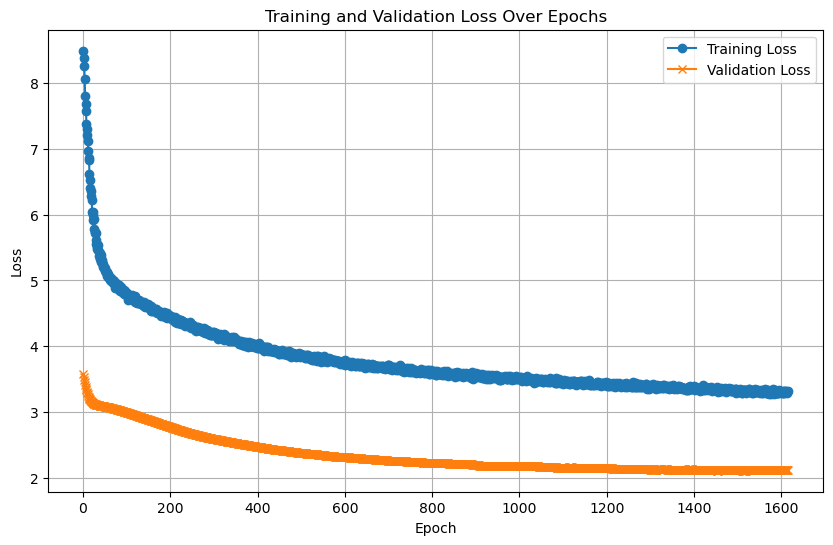

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/11], Loss: 4.7939

Test Loss: 4.9114


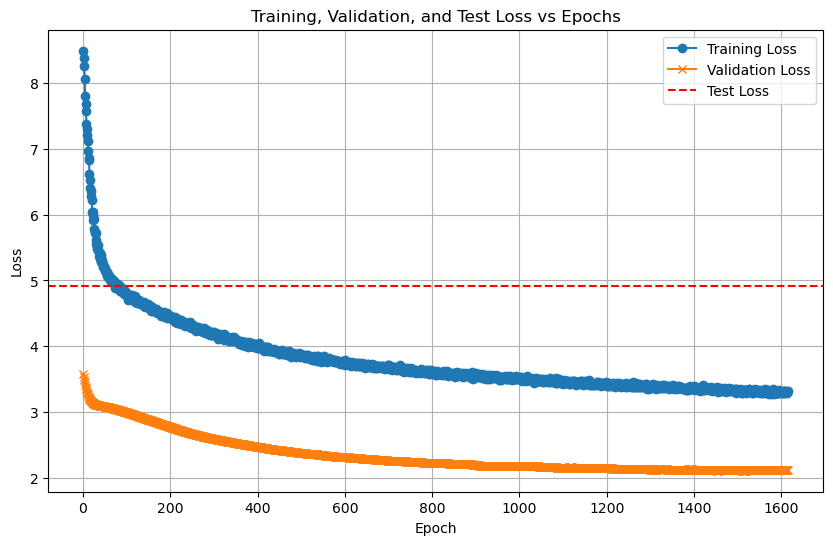

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/11 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (560, 128)
Train labels shape: (560,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2618, 128)
Test labels shape: (2618,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 91.43%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.80      0.89         5
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         5
           4       0.80      0.80      0.80         5
           5       0.75      0.60      0.67         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       0.71      1.00      0.83         5
           9       0.80      0.80      0.80         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      0.80      0.89         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (560, 128)
Train labels shape: (560,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2618, 128)
Test labels shape: (2618,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5844  |  Val Loss: 2.5234
Validation loss improved from inf to 2.5234.
[Epoch 2/1000] Train Loss: 2.4912  |  Val Loss: 2.4551
Validation loss improved from 2.5234 to 2.4551.
[Epoch 3/1000] Train Loss: 2.4127  |  Val Loss: 2.3962
Validation loss improved from 2.4551 to 2.3962.
[Epoch 4/1000] Train Loss: 2.3456  |  Val Loss: 2.3451
Validation loss improved from 2.3962 to 2.3451.
[Epoch 5/1000] Train Loss: 2.2913  |  Val Loss: 2.3002
Validation loss improved from 2.3451 to 2.3002.
[Epoch 6/1000] Train Loss: 2.2417  |  Val Loss: 2.2583
Validation loss improved from 2.3002 to 2.2583.


[Epoch 7/1000] Train Loss: 2.1976  |  Val Loss: 2.2174
Validation loss improved from 2.2583 to 2.2174.
[Epoch 8/1000] Train Loss: 2.1544  |  Val Loss: 2.1802
Validation loss improved from 2.2174 to 2.1802.
[Epoch 9/1000] Train Loss: 2.1163  |  Val Loss: 2.1437
Validation loss improved from 2.1802 to 2.1437.


[Epoch 10/1000] Train Loss: 2.0792  |  Val Loss: 2.1086
Validation loss improved from 2.1437 to 2.1086.
[Epoch 11/1000] Train Loss: 2.0438  |  Val Loss: 2.0751
Validation loss improved from 2.1086 to 2.0751.
[Epoch 12/1000] Train Loss: 2.0101  |  Val Loss: 2.0425
Validation loss improved from 2.0751 to 2.0425.


[Epoch 13/1000] Train Loss: 1.9770  |  Val Loss: 2.0111
Validation loss improved from 2.0425 to 2.0111.
[Epoch 14/1000] Train Loss: 1.9445  |  Val Loss: 1.9799
Validation loss improved from 2.0111 to 1.9799.
[Epoch 15/1000] Train Loss: 1.9130  |  Val Loss: 1.9489
Validation loss improved from 1.9799 to 1.9489.
[Epoch 16/1000] Train Loss: 1.8807  |  Val Loss: 1.9191
Validation loss improved from 1.9489 to 1.9191.
[Epoch 17/1000] Train Loss: 1.8495  |  Val Loss: 1.8900
Validation loss improved from 1.9191 to 1.8900.
[Epoch 18/1000] Train Loss: 1.8187  |  Val Loss: 1.8605
Validation loss improved from 1.8900 to 1.8605.


[Epoch 19/1000] Train Loss: 1.7882  |  Val Loss: 1.8313
Validation loss improved from 1.8605 to 1.8313.
[Epoch 20/1000] Train Loss: 1.7573  |  Val Loss: 1.8026
Validation loss improved from 1.8313 to 1.8026.
[Epoch 21/1000] Train Loss: 1.7275  |  Val Loss: 1.7744
Validation loss improved from 1.8026 to 1.7744.
[Epoch 22/1000] Train Loss: 1.6983  |  Val Loss: 1.7459
Validation loss improved from 1.7744 to 1.7459.


[Epoch 23/1000] Train Loss: 1.6684  |  Val Loss: 1.7175
Validation loss improved from 1.7459 to 1.7175.


[Epoch 24/1000] Train Loss: 1.6390  |  Val Loss: 1.6894
Validation loss improved from 1.7175 to 1.6894.
[Epoch 25/1000] Train Loss: 1.6096  |  Val Loss: 1.6614
Validation loss improved from 1.6894 to 1.6614.
[Epoch 26/1000] Train Loss: 1.5797  |  Val Loss: 1.6338
Validation loss improved from 1.6614 to 1.6338.
[Epoch 27/1000] Train Loss: 1.5495  |  Val Loss: 1.6065
Validation loss improved from 1.6338 to 1.6065.
[Epoch 28/1000] Train Loss: 1.5202  |  Val Loss: 1.5785
Validation loss improved from 1.6065 to 1.5785.
[Epoch 29/1000] Train Loss: 1.4908  |  Val Loss: 1.5512
Validation loss improved from 1.5785 to 1.5512.


[Epoch 30/1000] Train Loss: 1.4609  |  Val Loss: 1.5239
Validation loss improved from 1.5512 to 1.5239.
[Epoch 31/1000] Train Loss: 1.4311  |  Val Loss: 1.4967
Validation loss improved from 1.5239 to 1.4967.
[Epoch 32/1000] Train Loss: 1.4027  |  Val Loss: 1.4695
Validation loss improved from 1.4967 to 1.4695.
[Epoch 33/1000] Train Loss: 1.3733  |  Val Loss: 1.4431
Validation loss improved from 1.4695 to 1.4431.


[Epoch 34/1000] Train Loss: 1.3454  |  Val Loss: 1.4171
Validation loss improved from 1.4431 to 1.4171.
[Epoch 35/1000] Train Loss: 1.3172  |  Val Loss: 1.3911
Validation loss improved from 1.4171 to 1.3911.
[Epoch 36/1000] Train Loss: 1.2899  |  Val Loss: 1.3652
Validation loss improved from 1.3911 to 1.3652.
[Epoch 37/1000] Train Loss: 1.2631  |  Val Loss: 1.3393
Validation loss improved from 1.3652 to 1.3393.
[Epoch 38/1000] Train Loss: 1.2359  |  Val Loss: 1.3144
Validation loss improved from 1.3393 to 1.3144.
[Epoch 39/1000] Train Loss: 1.2093  |  Val Loss: 1.2892
Validation loss improved from 1.3144 to 1.2892.
[Epoch 40/1000] Train Loss: 1.1826  |  Val Loss: 1.2640
Validation loss improved from 1.2892 to 1.2640.


[Epoch 41/1000] Train Loss: 1.1557  |  Val Loss: 1.2387
Validation loss improved from 1.2640 to 1.2387.
[Epoch 42/1000] Train Loss: 1.1287  |  Val Loss: 1.2134
Validation loss improved from 1.2387 to 1.2134.
[Epoch 43/1000] Train Loss: 1.1021  |  Val Loss: 1.1888
Validation loss improved from 1.2134 to 1.1888.
[Epoch 44/1000] Train Loss: 1.0759  |  Val Loss: 1.1648
Validation loss improved from 1.1888 to 1.1648.


[Epoch 45/1000] Train Loss: 1.0504  |  Val Loss: 1.1408
Validation loss improved from 1.1648 to 1.1408.
[Epoch 46/1000] Train Loss: 1.0245  |  Val Loss: 1.1176
Validation loss improved from 1.1408 to 1.1176.
[Epoch 47/1000] Train Loss: 0.9999  |  Val Loss: 1.0945
Validation loss improved from 1.1176 to 1.0945.
[Epoch 48/1000] Train Loss: 0.9759  |  Val Loss: 1.0719
Validation loss improved from 1.0945 to 1.0719.
[Epoch 49/1000] Train Loss: 0.9519  |  Val Loss: 1.0498
Validation loss improved from 1.0719 to 1.0498.
[Epoch 50/1000] Train Loss: 0.9288  |  Val Loss: 1.0285
Validation loss improved from 1.0498 to 1.0285.


[Epoch 51/1000] Train Loss: 0.9062  |  Val Loss: 1.0079
Validation loss improved from 1.0285 to 1.0079.
[Epoch 52/1000] Train Loss: 0.8842  |  Val Loss: 0.9870
Validation loss improved from 1.0079 to 0.9870.
[Epoch 53/1000] Train Loss: 0.8624  |  Val Loss: 0.9668
Validation loss improved from 0.9870 to 0.9668.
[Epoch 54/1000] Train Loss: 0.8411  |  Val Loss: 0.9469
Validation loss improved from 0.9668 to 0.9469.
[Epoch 55/1000] Train Loss: 0.8201  |  Val Loss: 0.9278
Validation loss improved from 0.9469 to 0.9278.
[Epoch 56/1000] Train Loss: 0.8002  |  Val Loss: 0.9089
Validation loss improved from 0.9278 to 0.9089.


[Epoch 57/1000] Train Loss: 0.7802  |  Val Loss: 0.8905
Validation loss improved from 0.9089 to 0.8905.
[Epoch 58/1000] Train Loss: 0.7608  |  Val Loss: 0.8721
Validation loss improved from 0.8905 to 0.8721.
[Epoch 59/1000] Train Loss: 0.7416  |  Val Loss: 0.8540
Validation loss improved from 0.8721 to 0.8540.
[Epoch 60/1000] Train Loss: 0.7232  |  Val Loss: 0.8367
Validation loss improved from 0.8540 to 0.8367.


[Epoch 61/1000] Train Loss: 0.7048  |  Val Loss: 0.8194
Validation loss improved from 0.8367 to 0.8194.
[Epoch 62/1000] Train Loss: 0.6868  |  Val Loss: 0.8017
Validation loss improved from 0.8194 to 0.8017.
[Epoch 63/1000] Train Loss: 0.6682  |  Val Loss: 0.7843
Validation loss improved from 0.8017 to 0.7843.
[Epoch 64/1000] Train Loss: 0.6496  |  Val Loss: 0.7668
Validation loss improved from 0.7843 to 0.7668.
[Epoch 65/1000] Train Loss: 0.6320  |  Val Loss: 0.7503
Validation loss improved from 0.7668 to 0.7503.
[Epoch 66/1000] Train Loss: 0.6143  |  Val Loss: 0.7335
Validation loss improved from 0.7503 to 0.7335.
[Epoch 67/1000] Train Loss: 0.5974  |  Val Loss: 0.7181
Validation loss improved from 0.7335 to 0.7181.


[Epoch 68/1000] Train Loss: 0.5803  |  Val Loss: 0.7023
Validation loss improved from 0.7181 to 0.7023.
[Epoch 69/1000] Train Loss: 0.5643  |  Val Loss: 0.6871
Validation loss improved from 0.7023 to 0.6871.
[Epoch 70/1000] Train Loss: 0.5480  |  Val Loss: 0.6727
Validation loss improved from 0.6871 to 0.6727.
[Epoch 71/1000] Train Loss: 0.5326  |  Val Loss: 0.6581
Validation loss improved from 0.6727 to 0.6581.


[Epoch 72/1000] Train Loss: 0.5177  |  Val Loss: 0.6444
Validation loss improved from 0.6581 to 0.6444.
[Epoch 73/1000] Train Loss: 0.5031  |  Val Loss: 0.6309
Validation loss improved from 0.6444 to 0.6309.
[Epoch 74/1000] Train Loss: 0.4885  |  Val Loss: 0.6177
Validation loss improved from 0.6309 to 0.6177.
[Epoch 75/1000] Train Loss: 0.4746  |  Val Loss: 0.6047
Validation loss improved from 0.6177 to 0.6047.
[Epoch 76/1000] Train Loss: 0.4612  |  Val Loss: 0.5917
Validation loss improved from 0.6047 to 0.5917.
[Epoch 77/1000] Train Loss: 0.4476  |  Val Loss: 0.5786
Validation loss improved from 0.5917 to 0.5786.
[Epoch 78/1000] Train Loss: 0.4349  |  Val Loss: 0.5665
Validation loss improved from 0.5786 to 0.5665.


[Epoch 79/1000] Train Loss: 0.4223  |  Val Loss: 0.5545
Validation loss improved from 0.5665 to 0.5545.
[Epoch 80/1000] Train Loss: 0.4097  |  Val Loss: 0.5430
Validation loss improved from 0.5545 to 0.5430.
[Epoch 81/1000] Train Loss: 0.3978  |  Val Loss: 0.5319
Validation loss improved from 0.5430 to 0.5319.
[Epoch 82/1000] Train Loss: 0.3860  |  Val Loss: 0.5212
Validation loss improved from 0.5319 to 0.5212.


[Epoch 83/1000] Train Loss: 0.3747  |  Val Loss: 0.5101
Validation loss improved from 0.5212 to 0.5101.
[Epoch 84/1000] Train Loss: 0.3633  |  Val Loss: 0.5001
Validation loss improved from 0.5101 to 0.5001.
[Epoch 85/1000] Train Loss: 0.3524  |  Val Loss: 0.4901
Validation loss improved from 0.5001 to 0.4901.
[Epoch 86/1000] Train Loss: 0.3420  |  Val Loss: 0.4796
Validation loss improved from 0.4901 to 0.4796.
[Epoch 87/1000] Train Loss: 0.3314  |  Val Loss: 0.4704
Validation loss improved from 0.4796 to 0.4704.
[Epoch 88/1000] Train Loss: 0.3214  |  Val Loss: 0.4607
Validation loss improved from 0.4704 to 0.4607.
[Epoch 89/1000] Train Loss: 0.3114  |  Val Loss: 0.4522
Validation loss improved from 0.4607 to 0.4522.
[Epoch 90/1000] Train Loss: 0.3019  |  Val Loss: 0.4432
Validation loss improved from 0.4522 to 0.4432.


[Epoch 91/1000] Train Loss: 0.2926  |  Val Loss: 0.4341
Validation loss improved from 0.4432 to 0.4341.
[Epoch 92/1000] Train Loss: 0.2834  |  Val Loss: 0.4255
Validation loss improved from 0.4341 to 0.4255.
[Epoch 93/1000] Train Loss: 0.2748  |  Val Loss: 0.4179
Validation loss improved from 0.4255 to 0.4179.
[Epoch 94/1000] Train Loss: 0.2663  |  Val Loss: 0.4099
Validation loss improved from 0.4179 to 0.4099.


[Epoch 95/1000] Train Loss: 0.2582  |  Val Loss: 0.4027
Validation loss improved from 0.4099 to 0.4027.
[Epoch 96/1000] Train Loss: 0.2502  |  Val Loss: 0.3951
Validation loss improved from 0.4027 to 0.3951.
[Epoch 97/1000] Train Loss: 0.2425  |  Val Loss: 0.3875
Validation loss improved from 0.3951 to 0.3875.
[Epoch 98/1000] Train Loss: 0.2348  |  Val Loss: 0.3808
Validation loss improved from 0.3875 to 0.3808.
[Epoch 99/1000] Train Loss: 0.2279  |  Val Loss: 0.3741
Validation loss improved from 0.3808 to 0.3741.
[Epoch 100/1000] Train Loss: 0.2208  |  Val Loss: 0.3679
Validation loss improved from 0.3741 to 0.3679.
[Epoch 101/1000] Train Loss: 0.2139  |  Val Loss: 0.3617
Validation loss improved from 0.3679 to 0.3617.


[Epoch 102/1000] Train Loss: 0.2075  |  Val Loss: 0.3563
Validation loss improved from 0.3617 to 0.3563.
[Epoch 103/1000] Train Loss: 0.2012  |  Val Loss: 0.3497
Validation loss improved from 0.3563 to 0.3497.
[Epoch 104/1000] Train Loss: 0.1948  |  Val Loss: 0.3435
Validation loss improved from 0.3497 to 0.3435.
[Epoch 105/1000] Train Loss: 0.1888  |  Val Loss: 0.3392
Validation loss improved from 0.3435 to 0.3392.


[Epoch 106/1000] Train Loss: 0.1832  |  Val Loss: 0.3329
Validation loss improved from 0.3392 to 0.3329.
[Epoch 107/1000] Train Loss: 0.1776  |  Val Loss: 0.3278
Validation loss improved from 0.3329 to 0.3278.
[Epoch 108/1000] Train Loss: 0.1722  |  Val Loss: 0.3232
Validation loss improved from 0.3278 to 0.3232.
[Epoch 109/1000] Train Loss: 0.1668  |  Val Loss: 0.3179
Validation loss improved from 0.3232 to 0.3179.
[Epoch 110/1000] Train Loss: 0.1620  |  Val Loss: 0.3130
Validation loss improved from 0.3179 to 0.3130.
[Epoch 111/1000] Train Loss: 0.1570  |  Val Loss: 0.3087
Validation loss improved from 0.3130 to 0.3087.
[Epoch 112/1000] Train Loss: 0.1523  |  Val Loss: 0.3042
Validation loss improved from 0.3087 to 0.3042.
[Epoch 113/1000] Train Loss: 0.1480  |  Val Loss: 0.3005
Validation loss improved from 0.3042 to 0.3005.


[Epoch 114/1000] Train Loss: 0.1435  |  Val Loss: 0.2957
Validation loss improved from 0.3005 to 0.2957.
[Epoch 115/1000] Train Loss: 0.1395  |  Val Loss: 0.2919
Validation loss improved from 0.2957 to 0.2919.
[Epoch 116/1000] Train Loss: 0.1355  |  Val Loss: 0.2882
Validation loss improved from 0.2919 to 0.2882.
[Epoch 117/1000] Train Loss: 0.1317  |  Val Loss: 0.2844
Validation loss improved from 0.2882 to 0.2844.


[Epoch 118/1000] Train Loss: 0.1280  |  Val Loss: 0.2809
Validation loss improved from 0.2844 to 0.2809.
[Epoch 119/1000] Train Loss: 0.1245  |  Val Loss: 0.2771
Validation loss improved from 0.2809 to 0.2771.
[Epoch 120/1000] Train Loss: 0.1209  |  Val Loss: 0.2734
Validation loss improved from 0.2771 to 0.2734.
[Epoch 121/1000] Train Loss: 0.1176  |  Val Loss: 0.2703
Validation loss improved from 0.2734 to 0.2703.
[Epoch 122/1000] Train Loss: 0.1144  |  Val Loss: 0.2670
Validation loss improved from 0.2703 to 0.2670.
[Epoch 123/1000] Train Loss: 0.1113  |  Val Loss: 0.2636
Validation loss improved from 0.2670 to 0.2636.
[Epoch 124/1000] Train Loss: 0.1083  |  Val Loss: 0.2613
Validation loss improved from 0.2636 to 0.2613.


[Epoch 125/1000] Train Loss: 0.1054  |  Val Loss: 0.2584
Validation loss improved from 0.2613 to 0.2584.
[Epoch 126/1000] Train Loss: 0.1026  |  Val Loss: 0.2557
Validation loss improved from 0.2584 to 0.2557.
[Epoch 127/1000] Train Loss: 0.0999  |  Val Loss: 0.2533
Validation loss improved from 0.2557 to 0.2533.
[Epoch 128/1000] Train Loss: 0.0974  |  Val Loss: 0.2509
Validation loss improved from 0.2533 to 0.2509.
[Epoch 129/1000] Train Loss: 0.0948  |  Val Loss: 0.2486
Validation loss improved from 0.2509 to 0.2486.


[Epoch 130/1000] Train Loss: 0.0923  |  Val Loss: 0.2465
Validation loss improved from 0.2486 to 0.2465.
[Epoch 131/1000] Train Loss: 0.0900  |  Val Loss: 0.2442
Validation loss improved from 0.2465 to 0.2442.
[Epoch 132/1000] Train Loss: 0.0877  |  Val Loss: 0.2420
Validation loss improved from 0.2442 to 0.2420.
[Epoch 133/1000] Train Loss: 0.0855  |  Val Loss: 0.2393
Validation loss improved from 0.2420 to 0.2393.
[Epoch 134/1000] Train Loss: 0.0833  |  Val Loss: 0.2382
Validation loss improved from 0.2393 to 0.2382.
[Epoch 135/1000] Train Loss: 0.0813  |  Val Loss: 0.2367
Validation loss improved from 0.2382 to 0.2367.


[Epoch 136/1000] Train Loss: 0.0793  |  Val Loss: 0.2342
Validation loss improved from 0.2367 to 0.2342.
[Epoch 137/1000] Train Loss: 0.0775  |  Val Loss: 0.2323
Validation loss improved from 0.2342 to 0.2323.
[Epoch 138/1000] Train Loss: 0.0756  |  Val Loss: 0.2302
Validation loss improved from 0.2323 to 0.2302.
[Epoch 139/1000] Train Loss: 0.0738  |  Val Loss: 0.2286
Validation loss improved from 0.2302 to 0.2286.
[Epoch 140/1000] Train Loss: 0.0721  |  Val Loss: 0.2276
Validation loss improved from 0.2286 to 0.2276.


[Epoch 141/1000] Train Loss: 0.0704  |  Val Loss: 0.2262
Validation loss improved from 0.2276 to 0.2262.
[Epoch 142/1000] Train Loss: 0.0687  |  Val Loss: 0.2249
Validation loss improved from 0.2262 to 0.2249.
[Epoch 143/1000] Train Loss: 0.0671  |  Val Loss: 0.2233
Validation loss improved from 0.2249 to 0.2233.
[Epoch 144/1000] Train Loss: 0.0656  |  Val Loss: 0.2221
Validation loss improved from 0.2233 to 0.2221.
[Epoch 145/1000] Train Loss: 0.0641  |  Val Loss: 0.2200
Validation loss improved from 0.2221 to 0.2200.
[Epoch 146/1000] Train Loss: 0.0627  |  Val Loss: 0.2196
Validation loss improved from 0.2200 to 0.2196.
[Epoch 147/1000] Train Loss: 0.0613  |  Val Loss: 0.2178
Validation loss improved from 0.2196 to 0.2178.


[Epoch 148/1000] Train Loss: 0.0600  |  Val Loss: 0.2166
Validation loss improved from 0.2178 to 0.2166.
[Epoch 149/1000] Train Loss: 0.0586  |  Val Loss: 0.2150
Validation loss improved from 0.2166 to 0.2150.
[Epoch 150/1000] Train Loss: 0.0574  |  Val Loss: 0.2144
Validation loss improved from 0.2150 to 0.2144.
[Epoch 151/1000] Train Loss: 0.0562  |  Val Loss: 0.2126
Validation loss improved from 0.2144 to 0.2126.


[Epoch 152/1000] Train Loss: 0.0550  |  Val Loss: 0.2117
Validation loss improved from 0.2126 to 0.2117.
[Epoch 153/1000] Train Loss: 0.0539  |  Val Loss: 0.2111
Validation loss improved from 0.2117 to 0.2111.
[Epoch 154/1000] Train Loss: 0.0526  |  Val Loss: 0.2102
Validation loss improved from 0.2111 to 0.2102.
[Epoch 155/1000] Train Loss: 0.0515  |  Val Loss: 0.2087
Validation loss improved from 0.2102 to 0.2087.
[Epoch 156/1000] Train Loss: 0.0505  |  Val Loss: 0.2078
Validation loss improved from 0.2087 to 0.2078.
[Epoch 157/1000] Train Loss: 0.0495  |  Val Loss: 0.2071
Validation loss improved from 0.2078 to 0.2071.
[Epoch 158/1000] Train Loss: 0.0484  |  Val Loss: 0.2061
Validation loss improved from 0.2071 to 0.2061.


[Epoch 159/1000] Train Loss: 0.0475  |  Val Loss: 0.2048
Validation loss improved from 0.2061 to 0.2048.
[Epoch 160/1000] Train Loss: 0.0465  |  Val Loss: 0.2036
Validation loss improved from 0.2048 to 0.2036.
[Epoch 161/1000] Train Loss: 0.0456  |  Val Loss: 0.2029
Validation loss improved from 0.2036 to 0.2029.
[Epoch 162/1000] Train Loss: 0.0447  |  Val Loss: 0.2025
Validation loss improved from 0.2029 to 0.2025.


[Epoch 163/1000] Train Loss: 0.0439  |  Val Loss: 0.2018
Validation loss improved from 0.2025 to 0.2018.
[Epoch 164/1000] Train Loss: 0.0429  |  Val Loss: 0.2008
Validation loss improved from 0.2018 to 0.2008.
[Epoch 165/1000] Train Loss: 0.0421  |  Val Loss: 0.2010
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 166/1000] Train Loss: 0.0413  |  Val Loss: 0.2000
Validation loss improved from 0.2008 to 0.2000.
[Epoch 167/1000] Train Loss: 0.0406  |  Val Loss: 0.1985
Validation loss improved from 0.2000 to 0.1985.
[Epoch 168/1000] Train Loss: 0.0398  |  Val Loss: 0.1974
Validation loss improved from 0.1985 to 0.1974.
[Epoch 169/1000] Train Loss: 0.0390  |  Val Loss: 0.1971
Validation loss improved from 0.1974 to 0.1971.
[Epoch 170/1000] Train Loss: 0.0383  |  Val Loss: 0.1969
Validation loss improved from 0.1971 to 0.1969.


[Epoch 171/1000] Train Loss: 0.0376  |  Val Loss: 0.1964
Validation loss improved from 0.1969 to 0.1964.
[Epoch 172/1000] Train Loss: 0.0369  |  Val Loss: 0.1958
Validation loss improved from 0.1964 to 0.1958.
[Epoch 173/1000] Train Loss: 0.0362  |  Val Loss: 0.1951
Validation loss improved from 0.1958 to 0.1951.
[Epoch 174/1000] Train Loss: 0.0356  |  Val Loss: 0.1947
Validation loss improved from 0.1951 to 0.1947.


[Epoch 175/1000] Train Loss: 0.0349  |  Val Loss: 0.1941
Validation loss improved from 0.1947 to 0.1941.
[Epoch 176/1000] Train Loss: 0.0343  |  Val Loss: 0.1923
Validation loss improved from 0.1941 to 0.1923.
[Epoch 177/1000] Train Loss: 0.0337  |  Val Loss: 0.1924
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 178/1000] Train Loss: 0.0331  |  Val Loss: 0.1921
Validation loss improved from 0.1923 to 0.1921.
[Epoch 179/1000] Train Loss: 0.0325  |  Val Loss: 0.1912
Validation loss improved from 0.1921 to 0.1912.
[Epoch 180/1000] Train Loss: 0.0320  |  Val Loss: 0.1910
Validation loss improved from 0.1912 to 0.1910.
[Epoch 181/1000] Train Loss: 0.0315  |  Val Loss: 0.1907
Validation loss improved from 0.1910 to 0.1907.


[Epoch 182/1000] Train Loss: 0.0309  |  Val Loss: 0.1908
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 183/1000] Train Loss: 0.0304  |  Val Loss: 0.1893
Validation loss improved from 0.1907 to 0.1893.
[Epoch 184/1000] Train Loss: 0.0299  |  Val Loss: 0.1889
Validation loss improved from 0.1893 to 0.1889.
[Epoch 185/1000] Train Loss: 0.0294  |  Val Loss: 0.1891
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 186/1000] Train Loss: 0.0289  |  Val Loss: 0.1883
Validation loss improved from 0.1889 to 0.1883.
[Epoch 187/1000] Train Loss: 0.0284  |  Val Loss: 0.1880
Validation loss improved from 0.1883 to 0.1880.
[Epoch 188/1000] Train Loss: 0.0280  |  Val Loss: 0.1878
Validation loss improved from 0.1880 to 0.1878.
[Epoch 189/1000] Train Loss: 0.0275  |  Val Loss: 0.1873
Validation loss improved from 0.1878 to 0.1873.
[Epoch 190/1000] Train Loss: 0.0271  |  Val Loss: 0.1866
Validation loss improved from 0.1873 to 0.1866.
[Epoch 191/1000] Train Loss: 0.0266  |  Val Loss: 0.1870
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 192/1000] Train Loss: 0.0262  |  Val Loss: 0.1865
Validation loss improved from 0.1866 to 0.1865.


[Epoch 193/1000] Train Loss: 0.0258  |  Val Loss: 0.1859
Validation loss improved from 0.1865 to 0.1859.
[Epoch 194/1000] Train Loss: 0.0254  |  Val Loss: 0.1861
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 195/1000] Train Loss: 0.0250  |  Val Loss: 0.1848
Validation loss improved from 0.1859 to 0.1848.
[Epoch 196/1000] Train Loss: 0.0246  |  Val Loss: 0.1847
Validation loss improved from 0.1848 to 0.1847.
[Epoch 197/1000] Train Loss: 0.0242  |  Val Loss: 0.1846
Validation loss improved from 0.1847 to 0.1846.


[Epoch 198/1000] Train Loss: 0.0238  |  Val Loss: 0.1847
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 199/1000] Train Loss: 0.0235  |  Val Loss: 0.1845
Validation loss improved from 0.1846 to 0.1845.
[Epoch 200/1000] Train Loss: 0.0231  |  Val Loss: 0.1840
Validation loss improved from 0.1845 to 0.1840.
[Epoch 201/1000] Train Loss: 0.0228  |  Val Loss: 0.1836
Validation loss improved from 0.1840 to 0.1836.
[Epoch 202/1000] Train Loss: 0.0224  |  Val Loss: 0.1837
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 203/1000] Train Loss: 0.0221  |  Val Loss: 0.1830
Validation loss improved from 0.1836 to 0.1830.
[Epoch 204/1000] Train Loss: 0.0218  |  Val Loss: 0.1829
Validation loss improved from 0.1830 to 0.1829.


[Epoch 205/1000] Train Loss: 0.0215  |  Val Loss: 0.1822
Validation loss improved from 0.1829 to 0.1822.
[Epoch 206/1000] Train Loss: 0.0212  |  Val Loss: 0.1818
Validation loss improved from 0.1822 to 0.1818.
[Epoch 207/1000] Train Loss: 0.0208  |  Val Loss: 0.1816
Validation loss improved from 0.1818 to 0.1816.
[Epoch 208/1000] Train Loss: 0.0206  |  Val Loss: 0.1816
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 209/1000] Train Loss: 0.0202  |  Val Loss: 0.1812
Validation loss improved from 0.1816 to 0.1812.
[Epoch 210/1000] Train Loss: 0.0200  |  Val Loss: 0.1809
Validation loss improved from 0.1812 to 0.1809.
[Epoch 211/1000] Train Loss: 0.0197  |  Val Loss: 0.1810
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 212/1000] Train Loss: 0.0194  |  Val Loss: 0.1805
Validation loss improved from 0.1809 to 0.1805.
[Epoch 213/1000] Train Loss: 0.0191  |  Val Loss: 0.1804
Validation loss improved from 0.1805 to 0.1804.
[Epoch 214/1000] Train Loss: 0.0189  |  Val Loss: 0.1796
Validation loss improved from 0.1804 to 0.1796.
[Epoch 215/1000] Train Loss: 0.0186  |  Val Loss: 0.1799
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 216/1000] Train Loss: 0.0184  |  Val Loss: 0.1805
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 217/1000] Train Loss: 0.0181  |  Val Loss: 0.1801
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 218/1000] Train Loss: 0.0178  |  Val Loss: 0.1798
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 219/1000] Train Loss: 0.0176  |  Val Loss: 0.1791
Validation loss improved from 0.1796 to 0.1791.


[Epoch 220/1000] Train Loss: 0.0174  |  Val Loss: 0.1784
Validation loss improved from 0.1791 to 0.1784.
[Epoch 221/1000] Train Loss: 0.0171  |  Val Loss: 0.1781
Validation loss improved from 0.1784 to 0.1781.
[Epoch 222/1000] Train Loss: 0.0169  |  Val Loss: 0.1776
Validation loss improved from 0.1781 to 0.1776.
[Epoch 223/1000] Train Loss: 0.0167  |  Val Loss: 0.1781
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 224/1000] Train Loss: 0.0165  |  Val Loss: 0.1778
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 225/1000] Train Loss: 0.0162  |  Val Loss: 0.1776
Validation loss improved from 0.1776 to 0.1776.
[Epoch 226/1000] Train Loss: 0.0160  |  Val Loss: 0.1782
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 227/1000] Train Loss: 0.0158  |  Val Loss: 0.1774
Validation loss improved from 0.1776 to 0.1774.
[Epoch 228/1000] Train Loss: 0.0156  |  Val Loss: 0.1776
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 229/1000] Train Loss: 0.0154  |  Val Loss: 0.1777
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 230/1000] Train Loss: 0.0152  |  Val Loss: 0.1771
Validation loss improved from 0.1774 to 0.1771.
[Epoch 231/1000] Train Loss: 0.0150  |  Val Loss: 0.1773
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 232/1000] Train Loss: 0.0148  |  Val Loss: 0.1768
Validation loss improved from 0.1771 to 0.1768.
[Epoch 233/1000] Train Loss: 0.0146  |  Val Loss: 0.1758
Validation loss improved from 0.1768 to 0.1758.
[Epoch 234/1000] Train Loss: 0.0144  |  Val Loss: 0.1762
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 235/1000] Train Loss: 0.0143  |  Val Loss: 0.1769
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 236/1000] Train Loss: 0.0141  |  Val Loss: 0.1758
Validation loss improved from 0.1758 to 0.1758.
[Epoch 237/1000] Train Loss: 0.0139  |  Val Loss: 0.1769
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 238/1000] Train Loss: 0.0138  |  Val Loss: 0.1760
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 239/1000] Train Lo

[Epoch 241/1000] Train Loss: 0.0133  |  Val Loss: 0.1764
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 242/1000] Train Loss: 0.0131  |  Val Loss: 0.1767
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 243/1000] Train Loss: 0.0130  |  Val Loss: 0.1761
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 244/1000] Train Loss: 0.0128  |  Val Loss: 0.1763
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 245/1000] Train Loss: 0.0126  |  Val Loss: 0.1760
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 246/1000] Train Loss: 0.0125  |  Val Loss: 0.1763
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 247/1000] Train Loss: 0.0123  |  Val Loss: 0.1760
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 248/1000] Train Loss: 0.0122  |  Val Loss: 0.1755
Validation loss improved from 0.1758 to 0.1755.
[Epoch 249/1000] Train Loss: 0.0120  |  Val Loss: 0.1757
!! Validation loss did NOT improve !! Patience: 1/100
[Epoc

[Epoch 252/1000] Train Loss: 0.0117  |  Val Loss: 0.1765
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 253/1000] Train Loss: 0.0115  |  Val Loss: 0.1754
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 254/1000] Train Loss: 0.0114  |  Val Loss: 0.1751
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 255/1000] Train Loss: 0.0112  |  Val Loss: 0.1749
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 256/1000] Train Loss: 0.0111  |  Val Loss: 0.1752
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 257/1000] Train Loss: 0.0110  |  Val Loss: 0.1753
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 258/1000] Train Loss: 0.0109  |  Val Loss: 0.1754
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 259/1000] Train Loss: 0.0108  |  Val Loss: 0.1760
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 260/1000] Train Loss: 0.0106  |  Val Loss: 0.1753
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 263/1000] Train Loss: 0.0103  |  Val Loss: 0.1751
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 264/1000] Train Loss: 0.0102  |  Val Loss: 0.1749
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 265/1000] Train Loss: 0.0101  |  Val Loss: 0.1760
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 266/1000] Train Loss: 0.0099  |  Val Loss: 0.1759
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 267/1000] Train Loss: 0.0098  |  Val Loss: 0.1750
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 268/1000] Train Loss: 0.0097  |  Val Loss: 0.1747
Validation loss improved from 0.1748 to 0.1747.
[Epoch 269/1000] Train Loss: 0.0096  |  Val Loss: 0.1749
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 270/1000] Train Loss: 0.0095  |  Val Loss: 0.1750
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 271/1000] Train Loss: 0.0094  |  Val Loss: 0.1751
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 

[Epoch 275/1000] Train Loss: 0.0090  |  Val Loss: 0.1750
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 276/1000] Train Loss: 0.0089  |  Val Loss: 0.1752
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 277/1000] Train Loss: 0.0089  |  Val Loss: 0.1750
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 278/1000] Train Loss: 0.0087  |  Val Loss: 0.1746
Validation loss improved from 0.1747 to 0.1746.
[Epoch 279/1000] Train Loss: 0.0087  |  Val Loss: 0.1742
Validation loss improved from 0.1746 to 0.1742.
[Epoch 280/1000] Train Loss: 0.0086  |  Val Loss: 0.1747
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 281/1000] Train Loss: 0.0085  |  Val Loss: 0.1743
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 282/1000] Train Loss: 0.0084  |  Val Loss: 0.1743
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 283/1000] Train Loss: 0.0083  |  Val Loss: 0.1741
Validation loss improved from 0.1742 to 0.1741.
[Epoch 284/1000] Tr

[Epoch 287/1000] Train Loss: 0.0080  |  Val Loss: 0.1748
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 288/1000] Train Loss: 0.0079  |  Val Loss: 0.1746
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 289/1000] Train Loss: 0.0078  |  Val Loss: 0.1750
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 290/1000] Train Loss: 0.0078  |  Val Loss: 0.1751
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 291/1000] Train Loss: 0.0077  |  Val Loss: 0.1741
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 292/1000] Train Loss: 0.0076  |  Val Loss: 0.1745
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 293/1000] Train Loss: 0.0075  |  Val Loss: 0.1742
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 294/1000] Train Loss: 0.0075  |  Val Loss: 0.1751
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 295/1000] Train Loss: 0.0074  |  Val Loss: 0.1741
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 299/1000] Train Loss: 0.0071  |  Val Loss: 0.1746
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 300/1000] Train Loss: 0.0070  |  Val Loss: 0.1749
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 301/1000] Train Loss: 0.0070  |  Val Loss: 0.1748
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 302/1000] Train Loss: 0.0069  |  Val Loss: 0.1744
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 303/1000] Train Loss: 0.0068  |  Val Loss: 0.1745
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 304/1000] Train Loss: 0.0068  |  Val Loss: 0.1747
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 305/1000] Train Loss: 0.0067  |  Val Loss: 0.1747
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 306/1000] Train Loss: 0.0066  |  Val Loss: 0.1754
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 307/1000] Train Loss: 0.0066  |  Val Loss: 0.1753
!! Validation loss did NOT improve !! Patience:

[Epoch 311/1000] Train Loss: 0.0063  |  Val Loss: 0.1753
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 312/1000] Train Loss: 0.0063  |  Val Loss: 0.1749
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 313/1000] Train Loss: 0.0062  |  Val Loss: 0.1748
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 314/1000] Train Loss: 0.0062  |  Val Loss: 0.1755
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 315/1000] Train Loss: 0.0061  |  Val Loss: 0.1746
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 316/1000] Train Loss: 0.0061  |  Val Loss: 0.1755
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 317/1000] Train Loss: 0.0060  |  Val Loss: 0.1750
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 318/1000] Train Loss: 0.0059  |  Val Loss: 0.1754
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 319/1000] Train Loss: 0.0059  |  Val Loss: 0.1756
!! Validation loss did NOT improve !! Patience:

[Epoch 322/1000] Train Loss: 0.0057  |  Val Loss: 0.1749
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 323/1000] Train Loss: 0.0057  |  Val Loss: 0.1754
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 324/1000] Train Loss: 0.0056  |  Val Loss: 0.1751
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 325/1000] Train Loss: 0.0056  |  Val Loss: 0.1753
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 326/1000] Train Loss: 0.0055  |  Val Loss: 0.1748
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 327/1000] Train Loss: 0.0055  |  Val Loss: 0.1754
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 328/1000] Train Loss: 0.0054  |  Val Loss: 0.1760
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 329/1000] Train Loss: 0.0054  |  Val Loss: 0.1751
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 330/1000] Train Loss: 0.0053  |  Val Loss: 0.1746
!! Validation loss did NOT improve !! Patience:

[Epoch 334/1000] Train Loss: 0.0052  |  Val Loss: 0.1759
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 335/1000] Train Loss: 0.0051  |  Val Loss: 0.1752
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 336/1000] Train Loss: 0.0051  |  Val Loss: 0.1750
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 337/1000] Train Loss: 0.0050  |  Val Loss: 0.1756
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 338/1000] Train Loss: 0.0050  |  Val Loss: 0.1758
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 339/1000] Train Loss: 0.0049  |  Val Loss: 0.1758
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 340/1000] Train Loss: 0.0049  |  Val Loss: 0.1760
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 341/1000] Train Loss: 0.0048  |  Val Loss: 0.1758
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 342/1000] Train Loss: 0.0048  |  Val Loss: 0.1754
!! Validation loss did NOT improve !! Patience:

[Epoch 346/1000] Train Loss: 0.0047  |  Val Loss: 0.1750
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 347/1000] Train Loss: 0.0046  |  Val Loss: 0.1762
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 348/1000] Train Loss: 0.0046  |  Val Loss: 0.1768
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 349/1000] Train Loss: 0.0045  |  Val Loss: 0.1763
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 350/1000] Train Loss: 0.0045  |  Val Loss: 0.1766
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 351/1000] Train Loss: 0.0045  |  Val Loss: 0.1762
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 352/1000] Train Loss: 0.0044  |  Val Loss: 0.1760
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 353/1000] Train Loss: 0.0044  |  Val Loss: 0.1761
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 354/1000] Train Loss: 0.0043  |  Val Loss: 0.1765
!! Validation loss did NOT improve !! Patience:

[Epoch 358/1000] Train Loss: 0.0042  |  Val Loss: 0.1765
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 359/1000] Train Loss: 0.0042  |  Val Loss: 0.1767
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 360/1000] Train Loss: 0.0042  |  Val Loss: 0.1770
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 361/1000] Train Loss: 0.0041  |  Val Loss: 0.1759
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 362/1000] Train Loss: 0.0041  |  Val Loss: 0.1766
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 363/1000] Train Loss: 0.0040  |  Val Loss: 0.1761
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 364/1000] Train Loss: 0.0040  |  Val Loss: 0.1762
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 365/1000] Train Loss: 0.0040  |  Val Loss: 0.1763
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 366/1000] Train Loss: 0.0039  |  Val Loss: 0.1760
!! Validation loss did NOT improve !! Patience:

[Epoch 369/1000] Train Loss: 0.0039  |  Val Loss: 0.1773
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 370/1000] Train Loss: 0.0038  |  Val Loss: 0.1772
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 371/1000] Train Loss: 0.0038  |  Val Loss: 0.1776
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 372/1000] Train Loss: 0.0038  |  Val Loss: 0.1775
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 373/1000] Train Loss: 0.0037  |  Val Loss: 0.1758
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 374/1000] Train Loss: 0.0037  |  Val Loss: 0.1758
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 375/1000] Train Loss: 0.0037  |  Val Loss: 0.1758
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 376/1000] Train Loss: 0.0036  |  Val Loss: 0.1764
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 377/1000] Train Loss: 0.0036  |  Val Loss: 0.1774
!! Validation loss did NOT improve !! Patience:

[Epoch 381/1000] Train Loss: 0.0035  |  Val Loss: 0.1764
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 382/1000] Train Loss: 0.0035  |  Val Loss: 0.1764
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 383/1000] Train Loss: 0.0034  |  Val Loss: 0.1768
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 384/1000] Train Loss: 0.0034  |  Val Loss: 0.1780
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 385/1000] Train Loss: 0.0034  |  Val Loss: 0.1774
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 386/1000] Train Loss: 0.0034  |  Val Loss: 0.1770
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 386 !!
No improvement for 100 epochs.


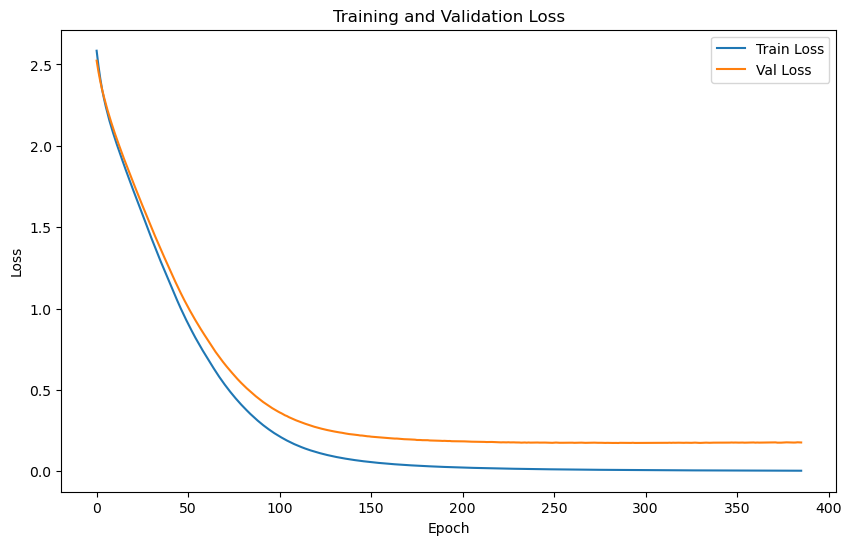

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.4464 | Test Accuracy: 88.20%


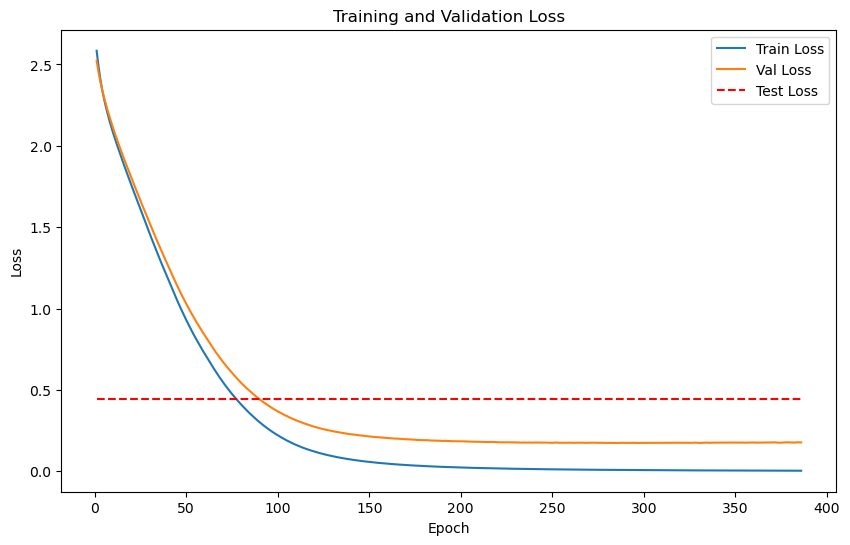

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 560 samples with 64 features each
LOG: Labels shape: (560,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2618 samples with 64 features each
LOG: Labels shape: (2618,)


Train embeddings shape: (560, 64), 
Train labels shape: (560,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (2618, 64), 
Test labels shape: (2618,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}
Training batch size: 280


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 0.4856
    Batch [2/2], Train Loss: 0.4835
LOG: Epoch [1/2000] - Validation


    Batch [1/2], Val Loss: 0.4461
    Batch [2/2], Val Loss: 0.0964
Epoch [1/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.2712

Validation loss improved from inf to 0.2712. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 0.4831


    Batch [2/2], Train Loss: 0.4767
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.4452
    Batch [2/2], Val Loss: 0.0976
Epoch [2/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.2714

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/2], Train Loss: 0.4841
    Batch [2/2], Train Loss: 0.4790
LOG: Epoch [3/2000] - Validation


    Batch [1/2], Val Loss: 0.4434
    Batch [2/2], Val Loss: 0.1000
Epoch [3/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.2717

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 0.4769


    Batch [2/2], Train Loss: 0.4787
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.4413
    Batch [2/2], Val Loss: 0.1025
Epoch [4/2000], Avg Train Loss: 0.4778, Avg Val Loss: 0.2719

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/2], Train Loss: 0.4763
    Batch [2/2], Train Loss: 0.4810
LOG: Epoch [5/2000] - Validation


    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.1090
Epoch [5/2000], Avg Train Loss: 0.4786, Avg Val Loss: 0.2747

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training
    Batch [1/2], Train Loss: 0.4793


    Batch [2/2], Train Loss: 0.4756
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.4401
    Batch [2/2], Val Loss: 0.1184
Epoch [6/2000], Avg Train Loss: 0.4775, Avg Val Loss: 0.2793

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training


    Batch [1/2], Train Loss: 0.4742
    Batch [2/2], Train Loss: 0.4681
LOG: Epoch [7/2000] - Validation


    Batch [1/2], Val Loss: 0.4399
    Batch [2/2], Val Loss: 0.1275
Epoch [7/2000], Avg Train Loss: 0.4712, Avg Val Loss: 0.2837

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [8/2000] - Training
    Batch [1/2], Train Loss: 0.4761


    Batch [2/2], Train Loss: 0.4711
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.4402
    Batch [2/2], Val Loss: 0.1290
Epoch [8/2000], Avg Train Loss: 0.4736, Avg Val Loss: 0.2846

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [9/2000] - Training


    Batch [1/2], Train Loss: 0.4649


    Batch [2/2], Train Loss: 0.4662
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.4416
    Batch [2/2], Val Loss: 0.1199
Epoch [9/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.2807

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [10/2000] - Training


    Batch [1/2], Train Loss: 0.4677
    Batch [2/2], Train Loss: 0.4687
LOG: Epoch [10/2000] - Validation


    Batch [1/2], Val Loss: 0.4440
    Batch [2/2], Val Loss: 0.1069
Epoch [10/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.2755

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [11/2000] - Training
    Batch [1/2], Train Loss: 0.4684


    Batch [2/2], Train Loss: 0.4638
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.4436
    Batch [2/2], Val Loss: 0.0941
Epoch [11/2000], Avg Train Loss: 0.4661, Avg Val Loss: 0.2688

Validation loss improved from 0.2712 to 0.2688. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/2], Train Loss: 0.4667
    Batch [2/2], Train Loss: 0.4631
LOG: Epoch [12/2000] - Validation


    Batch [1/2], Val Loss: 0.4438
    Batch [2/2], Val Loss: 0.0900
Epoch [12/2000], Avg Train Loss: 0.4649, Avg Val Loss: 0.2669

Validation loss improved from 0.2688 to 0.2669. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 0.4622


    Batch [2/2], Train Loss: 0.4637
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.4418
    Batch [2/2], Val Loss: 0.0906
Epoch [13/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.2662

Validation loss improved from 0.2669 to 0.2662. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/2], Train Loss: 0.4633
    Batch [2/2], Train Loss: 0.4617
LOG: Epoch [14/2000] - Validation


    Batch [1/2], Val Loss: 0.4391
    Batch [2/2], Val Loss: 0.0929
Epoch [14/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.2660

Validation loss improved from 0.2662 to 0.2660. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 0.4623


    Batch [2/2], Train Loss: 0.4588
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.4359
    Batch [2/2], Val Loss: 0.0955
Epoch [15/2000], Avg Train Loss: 0.4606, Avg Val Loss: 0.2657

Validation loss improved from 0.2660 to 0.2657. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/2], Train Loss: 0.4624
    Batch [2/2], Train Loss: 0.4556
LOG: Epoch [16/2000] - Validation


    Batch [1/2], Val Loss: 0.4340
    Batch [2/2], Val Loss: 0.0974
Epoch [16/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.2657

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [17/2000] - Training
    Batch [1/2], Train Loss: 0.4569


    Batch [2/2], Train Loss: 0.4520
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.4320
    Batch [2/2], Val Loss: 0.0971
Epoch [17/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.2645

Validation loss improved from 0.2657 to 0.2645. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/2], Train Loss: 0.4512
    Batch [2/2], Train Loss: 0.4522
LOG: Epoch [18/2000] - Validation


    Batch [1/2], Val Loss: 0.4308
    Batch [2/2], Val Loss: 0.0963
Epoch [18/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.2636

Validation loss improved from 0.2645 to 0.2636. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/2], Train Loss: 0.4486


    Batch [2/2], Train Loss: 0.4544
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.0961
Epoch [19/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.2634

Validation loss improved from 0.2636 to 0.2634. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/2], Train Loss: 0.4522
    Batch [2/2], Train Loss: 0.4556
LOG: Epoch [20/2000] - Validation


    Batch [1/2], Val Loss: 0.4306
    Batch [2/2], Val Loss: 0.0958
Epoch [20/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.2632

Validation loss improved from 0.2634 to 0.2632. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/2], Train Loss: 0.4559


    Batch [2/2], Train Loss: 0.4527
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.4308
    Batch [2/2], Val Loss: 0.0959
Epoch [21/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.2634

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [22/2000] - Training


    Batch [1/2], Train Loss: 0.4496
    Batch [2/2], Train Loss: 0.4485
LOG: Epoch [22/2000] - Validation


    Batch [1/2], Val Loss: 0.4310
    Batch [2/2], Val Loss: 0.0965
Epoch [22/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.2637

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [23/2000] - Training
    Batch [1/2], Train Loss: 0.4468


    Batch [2/2], Train Loss: 0.4460
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4313
    Batch [2/2], Val Loss: 0.0973
Epoch [23/2000], Avg Train Loss: 0.4464, Avg Val Loss: 0.2643

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [24/2000] - Training


    Batch [1/2], Train Loss: 0.4458
    Batch [2/2], Train Loss: 0.4476
LOG: Epoch [24/2000] - Validation


    Batch [1/2], Val Loss: 0.4320
    Batch [2/2], Val Loss: 0.0994
Epoch [24/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.2657

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [25/2000] - Training


    Batch [1/2], Train Loss: 0.4493


    Batch [2/2], Train Loss: 0.4443
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.4327
    Batch [2/2], Val Loss: 0.1013
Epoch [25/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.2670

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [26/2000] - Training


    Batch [1/2], Train Loss: 0.4466
    Batch [2/2], Train Loss: 0.4431
LOG: Epoch [26/2000] - Validation


    Batch [1/2], Val Loss: 0.4332
    Batch [2/2], Val Loss: 0.1032
Epoch [26/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.2682

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [27/2000] - Training
    Batch [1/2], Train Loss: 0.4383


    Batch [2/2], Train Loss: 0.4435
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4326
    Batch [2/2], Val Loss: 0.1057
Epoch [27/2000], Avg Train Loss: 0.4409, Avg Val Loss: 0.2691

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [28/2000] - Training


    Batch [1/2], Train Loss: 0.4404
    Batch [2/2], Train Loss: 0.4436
LOG: Epoch [28/2000] - Validation


    Batch [1/2], Val Loss: 0.4309
    Batch [2/2], Val Loss: 0.1079
Epoch [28/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.2694

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [29/2000] - Training


    Batch [1/2], Train Loss: 0.4408
    Batch [2/2], Train Loss: 0.4381
LOG: Epoch [29/2000] - Validation


    Batch [1/2], Val Loss: 0.4286
    Batch [2/2], Val Loss: 0.1101
Epoch [29/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.2693

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [30/2000] - Training


    Batch [1/2], Train Loss: 0.4380
    Batch [2/2], Train Loss: 0.4420
LOG: Epoch [30/2000] - Validation


    Batch [1/2], Val Loss: 0.4256
    Batch [2/2], Val Loss: 0.1120
Epoch [30/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.2688

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [31/2000] - Training


    Batch [1/2], Train Loss: 0.4419
    Batch [2/2], Train Loss: 0.4387
LOG: Epoch [31/2000] - Validation


    Batch [1/2], Val Loss: 0.4234
    Batch [2/2], Val Loss: 0.1136
Epoch [31/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.2685

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [32/2000] - Training
    Batch [1/2], Train Loss: 0.4367


    Batch [2/2], Train Loss: 0.4401
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4218
    Batch [2/2], Val Loss: 0.1151
Epoch [32/2000], Avg Train Loss: 0.4384, Avg Val Loss: 0.2684

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [33/2000] - Training


    Batch [1/2], Train Loss: 0.4383
    Batch [2/2], Train Loss: 0.4346
LOG: Epoch [33/2000] - Validation


    Batch [1/2], Val Loss: 0.4207
    Batch [2/2], Val Loss: 0.1171
Epoch [33/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.2689

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [34/2000] - Training
    Batch [1/2], Train Loss: 0.4389


    Batch [2/2], Train Loss: 0.4325
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.1186
Epoch [34/2000], Avg Train Loss: 0.4357, Avg Val Loss: 0.2693

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [35/2000] - Training


    Batch [1/2], Train Loss: 0.4334
    Batch [2/2], Train Loss: 0.4333
LOG: Epoch [35/2000] - Validation


    Batch [1/2], Val Loss: 0.4193
    Batch [2/2], Val Loss: 0.1196
Epoch [35/2000], Avg Train Loss: 0.4334, Avg Val Loss: 0.2694

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 0.4329


    Batch [2/2], Train Loss: 0.4333
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4185
    Batch [2/2], Val Loss: 0.1203
Epoch [36/2000], Avg Train Loss: 0.4331, Avg Val Loss: 0.2694

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [37/2000] - Training


    Batch [1/2], Train Loss: 0.4331
    Batch [2/2], Train Loss: 0.4266
LOG: Epoch [37/2000] - Validation


    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.1207
Epoch [37/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.2693

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [38/2000] - Training
    Batch [1/2], Train Loss: 0.4298


    Batch [2/2], Train Loss: 0.4285
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4170
    Batch [2/2], Val Loss: 0.1205
Epoch [38/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.2688

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [39/2000] - Training


    Batch [1/2], Train Loss: 0.4290
    Batch [2/2], Train Loss: 0.4318
LOG: Epoch [39/2000] - Validation


    Batch [1/2], Val Loss: 0.4153
    Batch [2/2], Val Loss: 0.1204
Epoch [39/2000], Avg Train Loss: 0.4304, Avg Val Loss: 0.2678

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [40/2000] - Training
    Batch [1/2], Train Loss: 0.4242


    Batch [2/2], Train Loss: 0.4249
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4139
    Batch [2/2], Val Loss: 0.1209
Epoch [40/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.2674

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [41/2000] - Training


    Batch [1/2], Train Loss: 0.4264


    Batch [2/2], Train Loss: 0.4260
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4129
    Batch [2/2], Val Loss: 0.1222
Epoch [41/2000], Avg Train Loss: 0.4262, Avg Val Loss: 0.2675

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [42/2000] - Training


    Batch [1/2], Train Loss: 0.4288
    Batch [2/2], Train Loss: 0.4266
LOG: Epoch [42/2000] - Validation


    Batch [1/2], Val Loss: 0.4115
    Batch [2/2], Val Loss: 0.1219
Epoch [42/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.2667

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [43/2000] - Training
    Batch [1/2], Train Loss: 0.4237


    Batch [2/2], Train Loss: 0.4218
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4098
    Batch [2/2], Val Loss: 0.1209
Epoch [43/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.2654

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [44/2000] - Training


    Batch [1/2], Train Loss: 0.4194
    Batch [2/2], Train Loss: 0.4211
LOG: Epoch [44/2000] - Validation


    Batch [1/2], Val Loss: 0.4084
    Batch [2/2], Val Loss: 0.1199
Epoch [44/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.2641

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [45/2000] - Training
    Batch [1/2], Train Loss: 0.4180


    Batch [2/2], Train Loss: 0.4185
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.1188
Epoch [45/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.2626

Validation loss improved from 0.2632 to 0.2626. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/2], Train Loss: 0.4172
    Batch [2/2], Train Loss: 0.4219
LOG: Epoch [46/2000] - Validation


    Batch [1/2], Val Loss: 0.4039
    Batch [2/2], Val Loss: 0.1185
Epoch [46/2000], Avg Train Loss: 0.4196, Avg Val Loss: 0.2612

Validation loss improved from 0.2626 to 0.2612. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/2], Train Loss: 0.4198


    Batch [2/2], Train Loss: 0.4235
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4025
    Batch [2/2], Val Loss: 0.1181
Epoch [47/2000], Avg Train Loss: 0.4216, Avg Val Loss: 0.2603

Validation loss improved from 0.2612 to 0.2603. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/2], Train Loss: 0.4174
    Batch [2/2], Train Loss: 0.4166
LOG: Epoch [48/2000] - Validation


    Batch [1/2], Val Loss: 0.4017
    Batch [2/2], Val Loss: 0.1175
Epoch [48/2000], Avg Train Loss: 0.4170, Avg Val Loss: 0.2596

Validation loss improved from 0.2603 to 0.2596. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/2], Train Loss: 0.4185


    Batch [2/2], Train Loss: 0.4207
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4006
    Batch [2/2], Val Loss: 0.1159
Epoch [49/2000], Avg Train Loss: 0.4196, Avg Val Loss: 0.2582

Validation loss improved from 0.2596 to 0.2582. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/2], Train Loss: 0.4196
    Batch [2/2], Train Loss: 0.4202
LOG: Epoch [50/2000] - Validation


    Batch [1/2], Val Loss: 0.3995
    Batch [2/2], Val Loss: 0.1137
Epoch [50/2000], Avg Train Loss: 0.4199, Avg Val Loss: 0.2566

Validation loss improved from 0.2582 to 0.2566. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/2], Train Loss: 0.4204


    Batch [2/2], Train Loss: 0.4141
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.3989
    Batch [2/2], Val Loss: 0.1121
Epoch [51/2000], Avg Train Loss: 0.4173, Avg Val Loss: 0.2555

Validation loss improved from 0.2566 to 0.2555. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/2], Train Loss: 0.4215
    Batch [2/2], Train Loss: 0.4162
LOG: Epoch [52/2000] - Validation


    Batch [1/2], Val Loss: 0.3977
    Batch [2/2], Val Loss: 0.1104
Epoch [52/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.2541

Validation loss improved from 0.2555 to 0.2541. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/2], Train Loss: 0.4125


    Batch [2/2], Train Loss: 0.4142
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.3959
    Batch [2/2], Val Loss: 0.1082
Epoch [53/2000], Avg Train Loss: 0.4133, Avg Val Loss: 0.2521

Validation loss improved from 0.2541 to 0.2521. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/2], Train Loss: 0.4120
    Batch [2/2], Train Loss: 0.4131
LOG: Epoch [54/2000] - Validation


    Batch [1/2], Val Loss: 0.3946
    Batch [2/2], Val Loss: 0.1068
Epoch [54/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.2507

Validation loss improved from 0.2521 to 0.2507. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 0.4116


    Batch [2/2], Train Loss: 0.4117
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.3935
    Batch [2/2], Val Loss: 0.1063
Epoch [55/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.2499

Validation loss improved from 0.2507 to 0.2499. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/2], Train Loss: 0.4114
    Batch [2/2], Train Loss: 0.4057
LOG: Epoch [56/2000] - Validation


    Batch [1/2], Val Loss: 0.3929
    Batch [2/2], Val Loss: 0.1068
Epoch [56/2000], Avg Train Loss: 0.4085, Avg Val Loss: 0.2499

Validation loss improved from 0.2499 to 0.2499. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/2], Train Loss: 0.4097


    Batch [2/2], Train Loss: 0.4038
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.3925
    Batch [2/2], Val Loss: 0.1063
Epoch [57/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.2494

Validation loss improved from 0.2499 to 0.2494. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/2], Train Loss: 0.4080
    Batch [2/2], Train Loss: 0.4206
LOG: Epoch [58/2000] - Validation


    Batch [1/2], Val Loss: 0.3924
    Batch [2/2], Val Loss: 0.1058
Epoch [58/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.2491

Validation loss improved from 0.2494 to 0.2491. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/2], Train Loss: 0.4136


    Batch [2/2], Train Loss: 0.4095
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.3916
    Batch [2/2], Val Loss: 0.1057
Epoch [59/2000], Avg Train Loss: 0.4115, Avg Val Loss: 0.2486

Validation loss improved from 0.2491 to 0.2486. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/2], Train Loss: 0.4075
    Batch [2/2], Train Loss: 0.4096
LOG: Epoch [60/2000] - Validation


    Batch [1/2], Val Loss: 0.3907
    Batch [2/2], Val Loss: 0.1057
Epoch [60/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.2482

Validation loss improved from 0.2486 to 0.2482. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/2], Train Loss: 0.4018


    Batch [2/2], Train Loss: 0.3987
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1046
Epoch [61/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.2476

Validation loss improved from 0.2482 to 0.2476. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/2], Train Loss: 0.4037
    Batch [2/2], Train Loss: 0.4067
LOG: Epoch [62/2000] - Validation


    Batch [1/2], Val Loss: 0.3895
    Batch [2/2], Val Loss: 0.1047
Epoch [62/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2471

Validation loss improved from 0.2476 to 0.2471. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/2], Train Loss: 0.4088


    Batch [2/2], Train Loss: 0.4061
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.3887
    Batch [2/2], Val Loss: 0.1031
Epoch [63/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.2459

Validation loss improved from 0.2471 to 0.2459. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/2], Train Loss: 0.4053
    Batch [2/2], Train Loss: 0.3969
LOG: Epoch [64/2000] - Validation


    Batch [1/2], Val Loss: 0.3878
    Batch [2/2], Val Loss: 0.1030
Epoch [64/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.2454

Validation loss improved from 0.2459 to 0.2454. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/2], Train Loss: 0.4026


    Batch [2/2], Train Loss: 0.3993
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.3873
    Batch [2/2], Val Loss: 0.1030
Epoch [65/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.2451

Validation loss improved from 0.2454 to 0.2451. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/2], Train Loss: 0.3982
    Batch [2/2], Train Loss: 0.4027
LOG: Epoch [66/2000] - Validation


    Batch [1/2], Val Loss: 0.3874
    Batch [2/2], Val Loss: 0.1023
Epoch [66/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.2448

Validation loss improved from 0.2451 to 0.2448. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/2], Train Loss: 0.4023


    Batch [2/2], Train Loss: 0.4058
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.3873
    Batch [2/2], Val Loss: 0.1010
Epoch [67/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.2442

Validation loss improved from 0.2448 to 0.2442. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/2], Train Loss: 0.3954
    Batch [2/2], Train Loss: 0.3990
LOG: Epoch [68/2000] - Validation


    Batch [1/2], Val Loss: 0.3851
    Batch [2/2], Val Loss: 0.0984
Epoch [68/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.2418

Validation loss improved from 0.2442 to 0.2418. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/2], Train Loss: 0.4027


    Batch [2/2], Train Loss: 0.3955
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.3832
    Batch [2/2], Val Loss: 0.0972
Epoch [69/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.2402

Validation loss improved from 0.2418 to 0.2402. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/2], Train Loss: 0.4010
    Batch [2/2], Train Loss: 0.3983
LOG: Epoch [70/2000] - Validation


    Batch [1/2], Val Loss: 0.3821
    Batch [2/2], Val Loss: 0.0963
Epoch [70/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.2392

Validation loss improved from 0.2402 to 0.2392. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/2], Train Loss: 0.4019


    Batch [2/2], Train Loss: 0.4038
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.3811
    Batch [2/2], Val Loss: 0.0944
Epoch [71/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2377

Validation loss improved from 0.2392 to 0.2377. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/2], Train Loss: 0.3968
    Batch [2/2], Train Loss: 0.3895
LOG: Epoch [72/2000] - Validation


    Batch [1/2], Val Loss: 0.3804
    Batch [2/2], Val Loss: 0.0927
Epoch [72/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2365

Validation loss improved from 0.2377 to 0.2365. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/2], Train Loss: 0.3995


    Batch [2/2], Train Loss: 0.3899
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.3798
    Batch [2/2], Val Loss: 0.0919
Epoch [73/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.2359

Validation loss improved from 0.2365 to 0.2359. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/2], Train Loss: 0.3952
    Batch [2/2], Train Loss: 0.3941
LOG: Epoch [74/2000] - Validation


    Batch [1/2], Val Loss: 0.3792
    Batch [2/2], Val Loss: 0.0915
Epoch [74/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.2353

Validation loss improved from 0.2359 to 0.2353. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/2], Train Loss: 0.3903


    Batch [2/2], Train Loss: 0.3908
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.3788
    Batch [2/2], Val Loss: 0.0922
Epoch [75/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2355

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [76/2000] - Training


    Batch [1/2], Train Loss: 0.3944
    Batch [2/2], Train Loss: 0.3913
LOG: Epoch [76/2000] - Validation


    Batch [1/2], Val Loss: 0.3780
    Batch [2/2], Val Loss: 0.0941
Epoch [76/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2360

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [77/2000] - Training
    Batch [1/2], Train Loss: 0.3908


    Batch [2/2], Train Loss: 0.3953
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.3765
    Batch [2/2], Val Loss: 0.0949
Epoch [77/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [78/2000] - Training


    Batch [1/2], Train Loss: 0.3937
    Batch [2/2], Train Loss: 0.3892
LOG: Epoch [78/2000] - Validation


    Batch [1/2], Val Loss: 0.3763
    Batch [2/2], Val Loss: 0.0964
Epoch [78/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2363

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [79/2000] - Training
    Batch [1/2], Train Loss: 0.3926


    Batch [2/2], Train Loss: 0.3835
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.3757
    Batch [2/2], Val Loss: 0.0963
Epoch [79/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.2360

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [80/2000] - Training


    Batch [1/2], Train Loss: 0.3845
    Batch [2/2], Train Loss: 0.3929
LOG: Epoch [80/2000] - Validation


    Batch [1/2], Val Loss: 0.3755
    Batch [2/2], Val Loss: 0.0958
Epoch [80/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.2356

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [81/2000] - Training
    Batch [1/2], Train Loss: 0.3829


    Batch [2/2], Train Loss: 0.3891
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.3754
    Batch [2/2], Val Loss: 0.0966
Epoch [81/2000], Avg Train Loss: 0.3860, Avg Val Loss: 0.2360

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [82/2000] - Training


    Batch [1/2], Train Loss: 0.3900
    Batch [2/2], Train Loss: 0.3847
LOG: Epoch [82/2000] - Validation


    Batch [1/2], Val Loss: 0.3750
    Batch [2/2], Val Loss: 0.0969
Epoch [82/2000], Avg Train Loss: 0.3873, Avg Val Loss: 0.2359

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [83/2000] - Training
    Batch [1/2], Train Loss: 0.3840


    Batch [2/2], Train Loss: 0.3923
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.3759
    Batch [2/2], Val Loss: 0.0969
Epoch [83/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.2364

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [84/2000] - Training


    Batch [1/2], Train Loss: 0.3823
    Batch [2/2], Train Loss: 0.3856
LOG: Epoch [84/2000] - Validation


    Batch [1/2], Val Loss: 0.3775
    Batch [2/2], Val Loss: 0.0971
Epoch [84/2000], Avg Train Loss: 0.3840, Avg Val Loss: 0.2373

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [85/2000] - Training
    Batch [1/2], Train Loss: 0.3919


    Batch [2/2], Train Loss: 0.3898
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.3784
    Batch [2/2], Val Loss: 0.0971
Epoch [85/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2377

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [86/2000] - Training


    Batch [1/2], Train Loss: 0.3756
    Batch [2/2], Train Loss: 0.3837
LOG: Epoch [86/2000] - Validation


    Batch [1/2], Val Loss: 0.3787
    Batch [2/2], Val Loss: 0.0981
Epoch [86/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.2384

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [87/2000] - Training
    Batch [1/2], Train Loss: 0.3834


    Batch [2/2], Train Loss: 0.3808
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.3789
    Batch [2/2], Val Loss: 0.0980
Epoch [87/2000], Avg Train Loss: 0.3821, Avg Val Loss: 0.2384

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [88/2000] - Training


    Batch [1/2], Train Loss: 0.3860
    Batch [2/2], Train Loss: 0.3875
LOG: Epoch [88/2000] - Validation


    Batch [1/2], Val Loss: 0.3767
    Batch [2/2], Val Loss: 0.0969
Epoch [88/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.2368

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [89/2000] - Training
    Batch [1/2], Train Loss: 0.3843


    Batch [2/2], Train Loss: 0.3822
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.3749
    Batch [2/2], Val Loss: 0.0960
Epoch [89/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.2355

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [90/2000] - Training


    Batch [1/2], Train Loss: 0.3725
    Batch [2/2], Train Loss: 0.3858
LOG: Epoch [90/2000] - Validation


    Batch [1/2], Val Loss: 0.3744
    Batch [2/2], Val Loss: 0.0956
Epoch [90/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.2350

Validation loss improved from 0.2353 to 0.2350. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/2], Train Loss: 0.3815


    Batch [2/2], Train Loss: 0.3796
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.3742
    Batch [2/2], Val Loss: 0.0948
Epoch [91/2000], Avg Train Loss: 0.3805, Avg Val Loss: 0.2345

Validation loss improved from 0.2350 to 0.2345. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/2], Train Loss: 0.3873
    Batch [2/2], Train Loss: 0.3806
LOG: Epoch [92/2000] - Validation


    Batch [1/2], Val Loss: 0.3721
    Batch [2/2], Val Loss: 0.0948
Epoch [92/2000], Avg Train Loss: 0.3840, Avg Val Loss: 0.2335

Validation loss improved from 0.2345 to 0.2335. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/2], Train Loss: 0.3821


    Batch [2/2], Train Loss: 0.3824
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.3702
    Batch [2/2], Val Loss: 0.0952
Epoch [93/2000], Avg Train Loss: 0.3822, Avg Val Loss: 0.2327

Validation loss improved from 0.2335 to 0.2327. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/2], Train Loss: 0.3859
    Batch [2/2], Train Loss: 0.3760
LOG: Epoch [94/2000] - Validation


    Batch [1/2], Val Loss: 0.3676
    Batch [2/2], Val Loss: 0.0956
Epoch [94/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.2316

Validation loss improved from 0.2327 to 0.2316. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/2], Train Loss: 0.3750


    Batch [2/2], Train Loss: 0.3751
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.3652
    Batch [2/2], Val Loss: 0.0955
Epoch [95/2000], Avg Train Loss: 0.3750, Avg Val Loss: 0.2304

Validation loss improved from 0.2316 to 0.2304. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/2], Train Loss: 0.3733
    Batch [2/2], Train Loss: 0.3711
LOG: Epoch [96/2000] - Validation


    Batch [1/2], Val Loss: 0.3643
    Batch [2/2], Val Loss: 0.0958
Epoch [96/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.2301

Validation loss improved from 0.2304 to 0.2301. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/2], Train Loss: 0.3803


    Batch [2/2], Train Loss: 0.3787
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.3638
    Batch [2/2], Val Loss: 0.0945
Epoch [97/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.2292

Validation loss improved from 0.2301 to 0.2292. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/2], Train Loss: 0.3746


    Batch [2/2], Train Loss: 0.3757
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.3643
    Batch [2/2], Val Loss: 0.0921
Epoch [98/2000], Avg Train Loss: 0.3751, Avg Val Loss: 0.2282

Validation loss improved from 0.2292 to 0.2282. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/2], Train Loss: 0.3781
    Batch [2/2], Train Loss: 0.3731
LOG: Epoch [99/2000] - Validation


    Batch [1/2], Val Loss: 0.3649
    Batch [2/2], Val Loss: 0.0900
Epoch [99/2000], Avg Train Loss: 0.3756, Avg Val Loss: 0.2275

Validation loss improved from 0.2282 to 0.2275. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/2], Train Loss: 0.3754


    Batch [2/2], Train Loss: 0.3712
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.3658
    Batch [2/2], Val Loss: 0.0883
Epoch [100/2000], Avg Train Loss: 0.3733, Avg Val Loss: 0.2270

Validation loss improved from 0.2275 to 0.2270. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/2], Train Loss: 0.3677


    Batch [2/2], Train Loss: 0.3745
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.3668
    Batch [2/2], Val Loss: 0.0875
Epoch [101/2000], Avg Train Loss: 0.3711, Avg Val Loss: 0.2271

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [102/2000] - Training


    Batch [1/2], Train Loss: 0.3759
    Batch [2/2], Train Loss: 0.3711
LOG: Epoch [102/2000] - Validation


    Batch [1/2], Val Loss: 0.3667
    Batch [2/2], Val Loss: 0.0879
Epoch [102/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.2273

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [103/2000] - Training


    Batch [1/2], Train Loss: 0.3692


    Batch [2/2], Train Loss: 0.3689
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.3660
    Batch [2/2], Val Loss: 0.0887
Epoch [103/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2273

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [104/2000] - Training


    Batch [1/2], Train Loss: 0.3683
    Batch [2/2], Train Loss: 0.3689
LOG: Epoch [104/2000] - Validation


    Batch [1/2], Val Loss: 0.3640
    Batch [2/2], Val Loss: 0.0896
Epoch [104/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.2268

Validation loss improved from 0.2270 to 0.2268. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/2], Train Loss: 0.3696
    Batch [2/2], Train Loss: 0.3695
LOG: Epoch [105/2000] - Validation


    Batch [1/2], Val Loss: 0.3612
    Batch [2/2], Val Loss: 0.0905
Epoch [105/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.2259

Validation loss improved from 0.2268 to 0.2259. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/2], Train Loss: 0.3644
    Batch [2/2], Train Loss: 0.3675
LOG: Epoch [106/2000] - Validation


    Batch [1/2], Val Loss: 0.3585
    Batch [2/2], Val Loss: 0.0935
Epoch [106/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.2260

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [107/2000] - Training
    Batch [1/2], Train Loss: 0.3661


    Batch [2/2], Train Loss: 0.3596
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.3562
    Batch [2/2], Val Loss: 0.0953
Epoch [107/2000], Avg Train Loss: 0.3629, Avg Val Loss: 0.2257

Validation loss improved from 0.2259 to 0.2257. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/2], Train Loss: 0.3666
    Batch [2/2], Train Loss: 0.3702
LOG: Epoch [108/2000] - Validation


    Batch [1/2], Val Loss: 0.3552
    Batch [2/2], Val Loss: 0.0964
Epoch [108/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.2258

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [109/2000] - Training
    Batch [1/2], Train Loss: 0.3688


    Batch [2/2], Train Loss: 0.3673
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.3549
    Batch [2/2], Val Loss: 0.0973
Epoch [109/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.2261

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [110/2000] - Training


    Batch [1/2], Train Loss: 0.3615
    Batch [2/2], Train Loss: 0.3673
LOG: Epoch [110/2000] - Validation


    Batch [1/2], Val Loss: 0.3536
    Batch [2/2], Val Loss: 0.0951
Epoch [110/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.2244

Validation loss improved from 0.2257 to 0.2244. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/2], Train Loss: 0.3670
    Batch [2/2], Train Loss: 0.3650
LOG: Epoch [111/2000] - Validation


    Batch [1/2], Val Loss: 0.3516
    Batch [2/2], Val Loss: 0.0912
Epoch [111/2000], Avg Train Loss: 0.3660, Avg Val Loss: 0.2214

Validation loss improved from 0.2244 to 0.2214. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/2], Train Loss: 0.3763
    Batch [2/2], Train Loss: 0.3561
LOG: Epoch [112/2000] - Validation


    Batch [1/2], Val Loss: 0.3491
    Batch [2/2], Val Loss: 0.0867
Epoch [112/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.2179

Validation loss improved from 0.2214 to 0.2179. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/2], Train Loss: 0.3589


    Batch [2/2], Train Loss: 0.3630
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.3489
    Batch [2/2], Val Loss: 0.0829
Epoch [113/2000], Avg Train Loss: 0.3610, Avg Val Loss: 0.2159

Validation loss improved from 0.2179 to 0.2159. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/2], Train Loss: 0.3648
    Batch [2/2], Train Loss: 0.3650
LOG: Epoch [114/2000] - Validation


    Batch [1/2], Val Loss: 0.3519
    Batch [2/2], Val Loss: 0.0786
Epoch [114/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.2153

Validation loss improved from 0.2159 to 0.2153. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/2], Train Loss: 0.3606


    Batch [2/2], Train Loss: 0.3636
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.3552
    Batch [2/2], Val Loss: 0.0754
Epoch [115/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.2153

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [116/2000] - Training


    Batch [1/2], Train Loss: 0.3590


    Batch [2/2], Train Loss: 0.3620
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.3574
    Batch [2/2], Val Loss: 0.0742
Epoch [116/2000], Avg Train Loss: 0.3605, Avg Val Loss: 0.2158

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [117/2000] - Training


    Batch [1/2], Train Loss: 0.3584
    Batch [2/2], Train Loss: 0.3686
LOG: Epoch [117/2000] - Validation


    Batch [1/2], Val Loss: 0.3573
    Batch [2/2], Val Loss: 0.0738
Epoch [117/2000], Avg Train Loss: 0.3635, Avg Val Loss: 0.2156

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [118/2000] - Training
    Batch [1/2], Train Loss: 0.3564


    Batch [2/2], Train Loss: 0.3540
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.3568
    Batch [2/2], Val Loss: 0.0738
Epoch [118/2000], Avg Train Loss: 0.3552, Avg Val Loss: 0.2153

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [119/2000] - Training


    Batch [1/2], Train Loss: 0.3600
    Batch [2/2], Train Loss: 0.3548
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.3562
    Batch [2/2], Val Loss: 0.0736
Epoch [119/2000], Avg Train Loss: 0.3574, Avg Val Loss: 0.2149

Validation loss improved from 0.2153 to 0.2149. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/2], Train Loss: 0.3560
    Batch [2/2], Train Loss: 0.3528
LOG: Epoch [120/2000] - Validation


    Batch [1/2], Val Loss: 0.3561
    Batch [2/2], Val Loss: 0.0732
Epoch [120/2000], Avg Train Loss: 0.3544, Avg Val Loss: 0.2146

Validation loss improved from 0.2149 to 0.2146. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/2], Train Loss: 0.3607


    Batch [2/2], Train Loss: 0.3513
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.3559
    Batch [2/2], Val Loss: 0.0747
Epoch [121/2000], Avg Train Loss: 0.3560, Avg Val Loss: 0.2153

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [122/2000] - Training


    Batch [1/2], Train Loss: 0.3503


    Batch [2/2], Train Loss: 0.3579
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.3569
    Batch [2/2], Val Loss: 0.0771
Epoch [122/2000], Avg Train Loss: 0.3541, Avg Val Loss: 0.2170

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [123/2000] - Training


    Batch [1/2], Train Loss: 0.3559
    Batch [2/2], Train Loss: 0.3565
LOG: Epoch [123/2000] - Validation


    Batch [1/2], Val Loss: 0.3571
    Batch [2/2], Val Loss: 0.0795
Epoch [123/2000], Avg Train Loss: 0.3562, Avg Val Loss: 0.2183

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [124/2000] - Training


    Batch [1/2], Train Loss: 0.3506
    Batch [2/2], Train Loss: 0.3540
LOG: Epoch [124/2000] - Validation


    Batch [1/2], Val Loss: 0.3576
    Batch [2/2], Val Loss: 0.0830
Epoch [124/2000], Avg Train Loss: 0.3523, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [125/2000] - Training
    Batch [1/2], Train Loss: 0.3559


    Batch [2/2], Train Loss: 0.3559
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.3581
    Batch [2/2], Val Loss: 0.0861
Epoch [125/2000], Avg Train Loss: 0.3559, Avg Val Loss: 0.2221

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [126/2000] - Training


    Batch [1/2], Train Loss: 0.3554
    Batch [2/2], Train Loss: 0.3462
LOG: Epoch [126/2000] - Validation


    Batch [1/2], Val Loss: 0.3571
    Batch [2/2], Val Loss: 0.0862
Epoch [126/2000], Avg Train Loss: 0.3508, Avg Val Loss: 0.2217

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [127/2000] - Training
    Batch [1/2], Train Loss: 0.3542


    Batch [2/2], Train Loss: 0.3576
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.3561
    Batch [2/2], Val Loss: 0.0842
Epoch [127/2000], Avg Train Loss: 0.3559, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [128/2000] - Training


    Batch [1/2], Train Loss: 0.3500


    Batch [2/2], Train Loss: 0.3472
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.3546
    Batch [2/2], Val Loss: 0.0820
Epoch [128/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.2183

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [129/2000] - Training


    Batch [1/2], Train Loss: 0.3576
    Batch [2/2], Train Loss: 0.3595
LOG: Epoch [129/2000] - Validation


    Batch [1/2], Val Loss: 0.3540
    Batch [2/2], Val Loss: 0.0800
Epoch [129/2000], Avg Train Loss: 0.3585, Avg Val Loss: 0.2170

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [130/2000] - Training
    Batch [1/2], Train Loss: 0.3455


    Batch [2/2], Train Loss: 0.3596
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.3533
    Batch [2/2], Val Loss: 0.0779
Epoch [130/2000], Avg Train Loss: 0.3526, Avg Val Loss: 0.2156

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [131/2000] - Training


    Batch [1/2], Train Loss: 0.3530
    Batch [2/2], Train Loss: 0.3502
LOG: Epoch [131/2000] - Validation


    Batch [1/2], Val Loss: 0.3520
    Batch [2/2], Val Loss: 0.0769
Epoch [131/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.2144

Validation loss improved from 0.2146 to 0.2144. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/2], Train Loss: 0.3438


    Batch [2/2], Train Loss: 0.3493
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.0772
Epoch [132/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2129

Validation loss improved from 0.2144 to 0.2129. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/2], Train Loss: 0.3530


    Batch [2/2], Train Loss: 0.3477
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.3452
    Batch [2/2], Val Loss: 0.0767
Epoch [133/2000], Avg Train Loss: 0.3504, Avg Val Loss: 0.2110

Validation loss improved from 0.2129 to 0.2110. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/2], Train Loss: 0.3496
    Batch [2/2], Train Loss: 0.3400
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.3436
    Batch [2/2], Val Loss: 0.0748
Epoch [134/2000], Avg Train Loss: 0.3448, Avg Val Loss: 0.2092

Validation loss improved from 0.2110 to 0.2092. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/2], Train Loss: 0.3483
    Batch [2/2], Train Loss: 0.3437
LOG: Epoch [135/2000] - Validation


    Batch [1/2], Val Loss: 0.3428
    Batch [2/2], Val Loss: 0.0743
Epoch [135/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.2085

Validation loss improved from 0.2092 to 0.2085. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/2], Train Loss: 0.3429


    Batch [2/2], Train Loss: 0.3542
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.3414
    Batch [2/2], Val Loss: 0.0746
Epoch [136/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.2080

Validation loss improved from 0.2085 to 0.2080. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/2], Train Loss: 0.3451
    Batch [2/2], Train Loss: 0.3432
LOG: Epoch [137/2000] - Validation


    Batch [1/2], Val Loss: 0.3399
    Batch [2/2], Val Loss: 0.0737
Epoch [137/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2068

Validation loss improved from 0.2080 to 0.2068. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/2], Train Loss: 0.3388


    Batch [2/2], Train Loss: 0.3477
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.3393
    Batch [2/2], Val Loss: 0.0729
Epoch [138/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2061

Validation loss improved from 0.2068 to 0.2061. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/2], Train Loss: 0.3442
    Batch [2/2], Train Loss: 0.3473
LOG: Epoch [139/2000] - Validation


    Batch [1/2], Val Loss: 0.3363
    Batch [2/2], Val Loss: 0.0712
Epoch [139/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.2037

Validation loss improved from 0.2061 to 0.2037. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/2], Train Loss: 0.3363


    Batch [2/2], Train Loss: 0.3500
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.3354
    Batch [2/2], Val Loss: 0.0704
Epoch [140/2000], Avg Train Loss: 0.3431, Avg Val Loss: 0.2029

Validation loss improved from 0.2037 to 0.2029. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/2], Train Loss: 0.3392


    Batch [2/2], Train Loss: 0.3362
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.3366
    Batch [2/2], Val Loss: 0.0708
Epoch [141/2000], Avg Train Loss: 0.3377, Avg Val Loss: 0.2037

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [142/2000] - Training


    Batch [1/2], Train Loss: 0.3451
    Batch [2/2], Train Loss: 0.3424
LOG: Epoch [142/2000] - Validation


    Batch [1/2], Val Loss: 0.3363
    Batch [2/2], Val Loss: 0.0719
Epoch [142/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2041

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 0.3383


    Batch [2/2], Train Loss: 0.3339
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.3351
    Batch [2/2], Val Loss: 0.0736
Epoch [143/2000], Avg Train Loss: 0.3361, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [144/2000] - Training


    Batch [1/2], Train Loss: 0.3437
    Batch [2/2], Train Loss: 0.3488
LOG: Epoch [144/2000] - Validation


    Batch [1/2], Val Loss: 0.3345
    Batch [2/2], Val Loss: 0.0752
Epoch [144/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2048

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [145/2000] - Training
    Batch [1/2], Train Loss: 0.3404


    Batch [2/2], Train Loss: 0.3258
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.3350
    Batch [2/2], Val Loss: 0.0767
Epoch [145/2000], Avg Train Loss: 0.3331, Avg Val Loss: 0.2058

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [146/2000] - Training


    Batch [1/2], Train Loss: 0.3364
    Batch [2/2], Train Loss: 0.3401
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.3344
    Batch [2/2], Val Loss: 0.0763
Epoch [146/2000], Avg Train Loss: 0.3383, Avg Val Loss: 0.2054

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [147/2000] - Training


    Batch [1/2], Train Loss: 0.3411
    Batch [2/2], Train Loss: 0.3411
LOG: Epoch [147/2000] - Validation


    Batch [1/2], Val Loss: 0.3364
    Batch [2/2], Val Loss: 0.0762
Epoch [147/2000], Avg Train Loss: 0.3411, Avg Val Loss: 0.2063

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [148/2000] - Training
    Batch [1/2], Train Loss: 0.3390


    Batch [2/2], Train Loss: 0.3357
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.3385
    Batch [2/2], Val Loss: 0.0748
Epoch [148/2000], Avg Train Loss: 0.3373, Avg Val Loss: 0.2067

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [149/2000] - Training


    Batch [1/2], Train Loss: 0.3344
    Batch [2/2], Train Loss: 0.3383
LOG: Epoch [149/2000] - Validation


    Batch [1/2], Val Loss: 0.3413
    Batch [2/2], Val Loss: 0.0742
Epoch [149/2000], Avg Train Loss: 0.3363, Avg Val Loss: 0.2077

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [150/2000] - Training
    Batch [1/2], Train Loss: 0.3417


    Batch [2/2], Train Loss: 0.3422
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.3405
    Batch [2/2], Val Loss: 0.0732
Epoch [150/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.2068

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [151/2000] - Training


    Batch [1/2], Train Loss: 0.3364
    Batch [2/2], Train Loss: 0.3442
LOG: Epoch [151/2000] - Validation


    Batch [1/2], Val Loss: 0.3396
    Batch [2/2], Val Loss: 0.0726
Epoch [151/2000], Avg Train Loss: 0.3403, Avg Val Loss: 0.2061

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [152/2000] - Training
    Batch [1/2], Train Loss: 0.3333


    Batch [2/2], Train Loss: 0.3321
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.3397
    Batch [2/2], Val Loss: 0.0734
Epoch [152/2000], Avg Train Loss: 0.3327, Avg Val Loss: 0.2065

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [153/2000] - Training


    Batch [1/2], Train Loss: 0.3331
    Batch [2/2], Train Loss: 0.3351
LOG: Epoch [153/2000] - Validation


    Batch [1/2], Val Loss: 0.3391
    Batch [2/2], Val Loss: 0.0744
Epoch [153/2000], Avg Train Loss: 0.3341, Avg Val Loss: 0.2067

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [154/2000] - Training
    Batch [1/2], Train Loss: 0.3374


    Batch [2/2], Train Loss: 0.3356
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.3372
    Batch [2/2], Val Loss: 0.0738
Epoch [154/2000], Avg Train Loss: 0.3365, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [155/2000] - Training


    Batch [1/2], Train Loss: 0.3290


    Batch [2/2], Train Loss: 0.3331
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.3364
    Batch [2/2], Val Loss: 0.0733
Epoch [155/2000], Avg Train Loss: 0.3310, Avg Val Loss: 0.2048

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [156/2000] - Training


    Batch [1/2], Train Loss: 0.3303
    Batch [2/2], Train Loss: 0.3290
LOG: Epoch [156/2000] - Validation


    Batch [1/2], Val Loss: 0.3368
    Batch [2/2], Val Loss: 0.0747
Epoch [156/2000], Avg Train Loss: 0.3297, Avg Val Loss: 0.2058

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [157/2000] - Training
    Batch [1/2], Train Loss: 0.3284


    Batch [2/2], Train Loss: 0.3268
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.3375
    Batch [2/2], Val Loss: 0.0763
Epoch [157/2000], Avg Train Loss: 0.3276, Avg Val Loss: 0.2069

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [158/2000] - Training


    Batch [1/2], Train Loss: 0.3293
    Batch [2/2], Train Loss: 0.3205
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.3375
    Batch [2/2], Val Loss: 0.0764
Epoch [158/2000], Avg Train Loss: 0.3249, Avg Val Loss: 0.2070

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [159/2000] - Training


    Batch [1/2], Train Loss: 0.3351
    Batch [2/2], Train Loss: 0.3291
LOG: Epoch [159/2000] - Validation


    Batch [1/2], Val Loss: 0.3354
    Batch [2/2], Val Loss: 0.0754
Epoch [159/2000], Avg Train Loss: 0.3321, Avg Val Loss: 0.2054

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [160/2000] - Training


    Batch [1/2], Train Loss: 0.3239
    Batch [2/2], Train Loss: 0.3238
LOG: Epoch [160/2000] - Validation


    Batch [1/2], Val Loss: 0.3350
    Batch [2/2], Val Loss: 0.0758
Epoch [160/2000], Avg Train Loss: 0.3239, Avg Val Loss: 0.2054

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [161/2000] - Training
    Batch [1/2], Train Loss: 0.3189


    Batch [2/2], Train Loss: 0.3265
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.3336
    Batch [2/2], Val Loss: 0.0760
Epoch [161/2000], Avg Train Loss: 0.3227, Avg Val Loss: 0.2048

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [162/2000] - Training


    Batch [1/2], Train Loss: 0.3380


    Batch [2/2], Train Loss: 0.3303
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.3335
    Batch [2/2], Val Loss: 0.0760
Epoch [162/2000], Avg Train Loss: 0.3341, Avg Val Loss: 0.2048

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [163/2000] - Training


    Batch [1/2], Train Loss: 0.3287


    Batch [2/2], Train Loss: 0.3202
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.3334
    Batch [2/2], Val Loss: 0.0771
Epoch [163/2000], Avg Train Loss: 0.3245, Avg Val Loss: 0.2052

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [164/2000] - Training


    Batch [1/2], Train Loss: 0.3359
    Batch [2/2], Train Loss: 0.3278
LOG: Epoch [164/2000] - Validation


    Batch [1/2], Val Loss: 0.3317
    Batch [2/2], Val Loss: 0.0786
Epoch [164/2000], Avg Train Loss: 0.3318, Avg Val Loss: 0.2052

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [165/2000] - Training
    Batch [1/2], Train Loss: 0.3307


    Batch [2/2], Train Loss: 0.3374
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.3309
    Batch [2/2], Val Loss: 0.0802
Epoch [165/2000], Avg Train Loss: 0.3340, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [166/2000] - Training


    Batch [1/2], Train Loss: 0.3208
    Batch [2/2], Train Loss: 0.3289
LOG: Epoch [166/2000] - Validation


    Batch [1/2], Val Loss: 0.3302
    Batch [2/2], Val Loss: 0.0807
Epoch [166/2000], Avg Train Loss: 0.3248, Avg Val Loss: 0.2054

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [167/2000] - Training
    Batch [1/2], Train Loss: 0.3222


    Batch [2/2], Train Loss: 0.3191
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.3262
    Batch [2/2], Val Loss: 0.0777
Epoch [167/2000], Avg Train Loss: 0.3206, Avg Val Loss: 0.2019

Validation loss improved from 0.2029 to 0.2019. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/2], Train Loss: 0.3225


    Batch [2/2], Train Loss: 0.3237
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.3228
    Batch [2/2], Val Loss: 0.0753
Epoch [168/2000], Avg Train Loss: 0.3231, Avg Val Loss: 0.1991

Validation loss improved from 0.2019 to 0.1991. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/2], Train Loss: 0.3257
    Batch [2/2], Train Loss: 0.3273
LOG: Epoch [169/2000] - Validation


    Batch [1/2], Val Loss: 0.3200
    Batch [2/2], Val Loss: 0.0741
Epoch [169/2000], Avg Train Loss: 0.3265, Avg Val Loss: 0.1971

Validation loss improved from 0.1991 to 0.1971. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/2], Train Loss: 0.3277


    Batch [2/2], Train Loss: 0.3319
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.3180
    Batch [2/2], Val Loss: 0.0732
Epoch [170/2000], Avg Train Loss: 0.3298, Avg Val Loss: 0.1956

Validation loss improved from 0.1971 to 0.1956. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/2], Train Loss: 0.3266
    Batch [2/2], Train Loss: 0.3252
LOG: Epoch [171/2000] - Validation


    Batch [1/2], Val Loss: 0.3168
    Batch [2/2], Val Loss: 0.0722
Epoch [171/2000], Avg Train Loss: 0.3259, Avg Val Loss: 0.1945

Validation loss improved from 0.1956 to 0.1945. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/2], Train Loss: 0.3228


    Batch [2/2], Train Loss: 0.3245
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.3160
    Batch [2/2], Val Loss: 0.0720
Epoch [172/2000], Avg Train Loss: 0.3237, Avg Val Loss: 0.1940

Validation loss improved from 0.1945 to 0.1940. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/2], Train Loss: 0.3168
    Batch [2/2], Train Loss: 0.3277
LOG: Epoch [173/2000] - Validation


    Batch [1/2], Val Loss: 0.3156
    Batch [2/2], Val Loss: 0.0717
Epoch [173/2000], Avg Train Loss: 0.3222, Avg Val Loss: 0.1937

Validation loss improved from 0.1940 to 0.1937. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/2], Train Loss: 0.3190


    Batch [2/2], Train Loss: 0.3372
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.3152
    Batch [2/2], Val Loss: 0.0712
Epoch [174/2000], Avg Train Loss: 0.3281, Avg Val Loss: 0.1932

Validation loss improved from 0.1937 to 0.1932. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/2], Train Loss: 0.3355
    Batch [2/2], Train Loss: 0.3217
LOG: Epoch [175/2000] - Validation


    Batch [1/2], Val Loss: 0.3150
    Batch [2/2], Val Loss: 0.0711
Epoch [175/2000], Avg Train Loss: 0.3286, Avg Val Loss: 0.1931

Validation loss improved from 0.1932 to 0.1931. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/2], Train Loss: 0.3238


    Batch [2/2], Train Loss: 0.3300
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.3149
    Batch [2/2], Val Loss: 0.0709
Epoch [176/2000], Avg Train Loss: 0.3269, Avg Val Loss: 0.1929

Validation loss improved from 0.1931 to 0.1929. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/2], Train Loss: 0.3259
    Batch [2/2], Train Loss: 0.3270
LOG: Epoch [177/2000] - Validation


    Batch [1/2], Val Loss: 0.3147
    Batch [2/2], Val Loss: 0.0703
Epoch [177/2000], Avg Train Loss: 0.3265, Avg Val Loss: 0.1925

Validation loss improved from 0.1929 to 0.1925. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/2], Train Loss: 0.3261


    Batch [2/2], Train Loss: 0.3214
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.3141
    Batch [2/2], Val Loss: 0.0703
Epoch [178/2000], Avg Train Loss: 0.3238, Avg Val Loss: 0.1922

Validation loss improved from 0.1925 to 0.1922. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/2], Train Loss: 0.3223
    Batch [2/2], Train Loss: 0.3199
LOG: Epoch [179/2000] - Validation


    Batch [1/2], Val Loss: 0.3138
    Batch [2/2], Val Loss: 0.0698
Epoch [179/2000], Avg Train Loss: 0.3211, Avg Val Loss: 0.1918

Validation loss improved from 0.1922 to 0.1918. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/2], Train Loss: 0.3313


    Batch [2/2], Train Loss: 0.3215
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.3137
    Batch [2/2], Val Loss: 0.0696
Epoch [180/2000], Avg Train Loss: 0.3264, Avg Val Loss: 0.1916

Validation loss improved from 0.1918 to 0.1916. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/2], Train Loss: 0.3217
    Batch [2/2], Train Loss: 0.3196
LOG: Epoch [181/2000] - Validation


    Batch [1/2], Val Loss: 0.3136
    Batch [2/2], Val Loss: 0.0692
Epoch [181/2000], Avg Train Loss: 0.3206, Avg Val Loss: 0.1914

Validation loss improved from 0.1916 to 0.1914. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/2], Train Loss: 0.3248


    Batch [2/2], Train Loss: 0.3359
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.3132
    Batch [2/2], Val Loss: 0.0692
Epoch [182/2000], Avg Train Loss: 0.3303, Avg Val Loss: 0.1912

Validation loss improved from 0.1914 to 0.1912. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/2], Train Loss: 0.3211
    Batch [2/2], Train Loss: 0.3326
LOG: Epoch [183/2000] - Validation


    Batch [1/2], Val Loss: 0.3129
    Batch [2/2], Val Loss: 0.0686
Epoch [183/2000], Avg Train Loss: 0.3268, Avg Val Loss: 0.1908

Validation loss improved from 0.1912 to 0.1908. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/2], Train Loss: 0.3194


    Batch [2/2], Train Loss: 0.3215
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.3129
    Batch [2/2], Val Loss: 0.0686
Epoch [184/2000], Avg Train Loss: 0.3205, Avg Val Loss: 0.1907

Validation loss improved from 0.1908 to 0.1907. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/2], Train Loss: 0.3271


    Batch [2/2], Train Loss: 0.3185
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.3128
    Batch [2/2], Val Loss: 0.0684
Epoch [185/2000], Avg Train Loss: 0.3228, Avg Val Loss: 0.1906

Validation loss improved from 0.1907 to 0.1906. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/2], Train Loss: 0.3166


    Batch [2/2], Train Loss: 0.3222
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.3127
    Batch [2/2], Val Loss: 0.0688
Epoch [186/2000], Avg Train Loss: 0.3194, Avg Val Loss: 0.1907

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [187/2000] - Training


    Batch [1/2], Train Loss: 0.3259
    Batch [2/2], Train Loss: 0.3229
LOG: Epoch [187/2000] - Validation


    Batch [1/2], Val Loss: 0.3123
    Batch [2/2], Val Loss: 0.0689
Epoch [187/2000], Avg Train Loss: 0.3244, Avg Val Loss: 0.1906

Validation loss improved from 0.1906 to 0.1906. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/2], Train Loss: 0.3255


    Batch [2/2], Train Loss: 0.3291
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.3121
    Batch [2/2], Val Loss: 0.0690
Epoch [188/2000], Avg Train Loss: 0.3273, Avg Val Loss: 0.1905

Validation loss improved from 0.1906 to 0.1905. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/2], Train Loss: 0.3213
    Batch [2/2], Train Loss: 0.3218
LOG: Epoch [189/2000] - Validation


    Batch [1/2], Val Loss: 0.3118
    Batch [2/2], Val Loss: 0.0693
Epoch [189/2000], Avg Train Loss: 0.3216, Avg Val Loss: 0.1905

Validation loss improved from 0.1905 to 0.1905. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/2], Train Loss: 0.3211


    Batch [2/2], Train Loss: 0.3265
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.3116
    Batch [2/2], Val Loss: 0.0698
Epoch [190/2000], Avg Train Loss: 0.3238, Avg Val Loss: 0.1907

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [191/2000] - Training


    Batch [1/2], Train Loss: 0.3318


    Batch [2/2], Train Loss: 0.3211
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.3117
    Batch [2/2], Val Loss: 0.0702
Epoch [191/2000], Avg Train Loss: 0.3265, Avg Val Loss: 0.1909

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [192/2000] - Training


    Batch [1/2], Train Loss: 0.3263


    Batch [2/2], Train Loss: 0.3301
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.3116
    Batch [2/2], Val Loss: 0.0703
Epoch [192/2000], Avg Train Loss: 0.3282, Avg Val Loss: 0.1909

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [193/2000] - Training


    Batch [1/2], Train Loss: 0.3198


    Batch [2/2], Train Loss: 0.3258
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.3117
    Batch [2/2], Val Loss: 0.0705
Epoch [193/2000], Avg Train Loss: 0.3228, Avg Val Loss: 0.1911

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [194/2000] - Training


    Batch [1/2], Train Loss: 0.3224


    Batch [2/2], Train Loss: 0.3138
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.3117
    Batch [2/2], Val Loss: 0.0709
Epoch [194/2000], Avg Train Loss: 0.3181, Avg Val Loss: 0.1913

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [195/2000] - Training


    Batch [1/2], Train Loss: 0.3221
    Batch [2/2], Train Loss: 0.3214
LOG: Epoch [195/2000] - Validation


    Batch [1/2], Val Loss: 0.3119
    Batch [2/2], Val Loss: 0.0712
Epoch [195/2000], Avg Train Loss: 0.3218, Avg Val Loss: 0.1916

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [196/2000] - Training
    Batch [1/2], Train Loss: 0.3210


    Batch [2/2], Train Loss: 0.3283
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.3119
    Batch [2/2], Val Loss: 0.0714
Epoch [196/2000], Avg Train Loss: 0.3246, Avg Val Loss: 0.1916

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [197/2000] - Training


    Batch [1/2], Train Loss: 0.3250


    Batch [2/2], Train Loss: 0.3192
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.3118
    Batch [2/2], Val Loss: 0.0713
Epoch [197/2000], Avg Train Loss: 0.3221, Avg Val Loss: 0.1916

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [198/2000] - Training


    Batch [1/2], Train Loss: 0.3208
    Batch [2/2], Train Loss: 0.3292
LOG: Epoch [198/2000] - Validation


    Batch [1/2], Val Loss: 0.3119
    Batch [2/2], Val Loss: 0.0713
Epoch [198/2000], Avg Train Loss: 0.3250, Avg Val Loss: 0.1916

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [199/2000] - Training
    Batch [1/2], Train Loss: 0.3280


    Batch [2/2], Train Loss: 0.3227
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.3117
    Batch [2/2], Val Loss: 0.0713
Epoch [199/2000], Avg Train Loss: 0.3253, Avg Val Loss: 0.1915

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [200/2000] - Training


    Batch [1/2], Train Loss: 0.3313
    Batch [2/2], Train Loss: 0.3209
LOG: Epoch [200/2000] - Validation


    Batch [1/2], Val Loss: 0.3117
    Batch [2/2], Val Loss: 0.0710
Epoch [200/2000], Avg Train Loss: 0.3261, Avg Val Loss: 0.1913

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [201/2000] - Training


    Batch [1/2], Train Loss: 0.3229
    Batch [2/2], Train Loss: 0.3222
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.3116
    Batch [2/2], Val Loss: 0.0709
Epoch [201/2000], Avg Train Loss: 0.3225, Avg Val Loss: 0.1913

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [202/2000] - Training


    Batch [1/2], Train Loss: 0.3331
    Batch [2/2], Train Loss: 0.3170
LOG: Epoch [202/2000] - Validation


    Batch [1/2], Val Loss: 0.3117
    Batch [2/2], Val Loss: 0.0711
Epoch [202/2000], Avg Train Loss: 0.3251, Avg Val Loss: 0.1914

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [203/2000] - Training
    Batch [1/2], Train Loss: 0.3260


    Batch [2/2], Train Loss: 0.3268
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.3116
    Batch [2/2], Val Loss: 0.0712
Epoch [203/2000], Avg Train Loss: 0.3264, Avg Val Loss: 0.1914

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [204/2000] - Training


    Batch [1/2], Train Loss: 0.3209


    Batch [2/2], Train Loss: 0.3269
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.3115
    Batch [2/2], Val Loss: 0.0712
Epoch [204/2000], Avg Train Loss: 0.3239, Avg Val Loss: 0.1914

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [205/2000] - Training


    Batch [1/2], Train Loss: 0.3127


    Batch [2/2], Train Loss: 0.3237
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.3116
    Batch [2/2], Val Loss: 0.0711
Epoch [205/2000], Avg Train Loss: 0.3182, Avg Val Loss: 0.1914

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [206/2000] - Training


    Batch [1/2], Train Loss: 0.3252
    Batch [2/2], Train Loss: 0.3237
LOG: Epoch [206/2000] - Validation


    Batch [1/2], Val Loss: 0.3117
    Batch [2/2], Val Loss: 0.0714
Epoch [206/2000], Avg Train Loss: 0.3244, Avg Val Loss: 0.1915

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [207/2000] - Training


    Batch [1/2], Train Loss: 0.3189


    Batch [2/2], Train Loss: 0.3305
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.3118
    Batch [2/2], Val Loss: 0.0712
Epoch [207/2000], Avg Train Loss: 0.3247, Avg Val Loss: 0.1915

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [208/2000] - Training


    Batch [1/2], Train Loss: 0.3263
    Batch [2/2], Train Loss: 0.3160
LOG: Epoch [208/2000] - Validation


    Batch [1/2], Val Loss: 0.3118
    Batch [2/2], Val Loss: 0.0713
Epoch [208/2000], Avg Train Loss: 0.3212, Avg Val Loss: 0.1916

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [209/2000] - Training


    Batch [1/2], Train Loss: 0.3188


    Batch [2/2], Train Loss: 0.3164
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.3118
    Batch [2/2], Val Loss: 0.0713
Epoch [209/2000], Avg Train Loss: 0.3176, Avg Val Loss: 0.1916

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [210/2000] - Training


    Batch [1/2], Train Loss: 0.3222
    Batch [2/2], Train Loss: 0.3235
LOG: Epoch [210/2000] - Validation


    Batch [1/2], Val Loss: 0.3117
    Batch [2/2], Val Loss: 0.0709
Epoch [210/2000], Avg Train Loss: 0.3228, Avg Val Loss: 0.1913

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [211/2000] - Training
    Batch [1/2], Train Loss: 0.3103


    Batch [2/2], Train Loss: 0.3253
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.3118
    Batch [2/2], Val Loss: 0.0707
Epoch [211/2000], Avg Train Loss: 0.3178, Avg Val Loss: 0.1913

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [212/2000] - Training


    Batch [1/2], Train Loss: 0.3302
    Batch [2/2], Train Loss: 0.3265
LOG: Epoch [212/2000] - Validation


    Batch [1/2], Val Loss: 0.3118
    Batch [2/2], Val Loss: 0.0708
Epoch [212/2000], Avg Train Loss: 0.3284, Avg Val Loss: 0.1913

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [213/2000] - Training
    Batch [1/2], Train Loss: 0.3225


    Batch [2/2], Train Loss: 0.3233
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.3117
    Batch [2/2], Val Loss: 0.0708
Epoch [213/2000], Avg Train Loss: 0.3229, Avg Val Loss: 0.1912

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [214/2000] - Training


    Batch [1/2], Train Loss: 0.3244
    Batch [2/2], Train Loss: 0.3186
LOG: Epoch [214/2000] - Validation


    Batch [1/2], Val Loss: 0.3116
    Batch [2/2], Val Loss: 0.0709
Epoch [214/2000], Avg Train Loss: 0.3215, Avg Val Loss: 0.1913

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [215/2000] - Training
    Batch [1/2], Train Loss: 0.3264


    Batch [2/2], Train Loss: 0.3231
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.3116
    Batch [2/2], Val Loss: 0.0713
Epoch [215/2000], Avg Train Loss: 0.3248, Avg Val Loss: 0.1914

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [216/2000] - Training


    Batch [1/2], Train Loss: 0.3270


    Batch [2/2], Train Loss: 0.3212
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.3115
    Batch [2/2], Val Loss: 0.0712
Epoch [216/2000], Avg Train Loss: 0.3241, Avg Val Loss: 0.1913

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [217/2000] - Training


    Batch [1/2], Train Loss: 0.3265
    Batch [2/2], Train Loss: 0.3232
LOG: Epoch [217/2000] - Validation


    Batch [1/2], Val Loss: 0.3113
    Batch [2/2], Val Loss: 0.0710
Epoch [217/2000], Avg Train Loss: 0.3249, Avg Val Loss: 0.1911

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [218/2000] - Training
    Batch [1/2], Train Loss: 0.3233


    Batch [2/2], Train Loss: 0.3219
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.3112
    Batch [2/2], Val Loss: 0.0710
Epoch [218/2000], Avg Train Loss: 0.3226, Avg Val Loss: 0.1911

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [219/2000] - Training


    Batch [1/2], Train Loss: 0.3179
    Batch [2/2], Train Loss: 0.3219
LOG: Epoch [219/2000] - Validation


    Batch [1/2], Val Loss: 0.3113
    Batch [2/2], Val Loss: 0.0711
Epoch [219/2000], Avg Train Loss: 0.3199, Avg Val Loss: 0.1912

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [220/2000] - Training


    Batch [1/2], Train Loss: 0.3260


    Batch [2/2], Train Loss: 0.3205
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.3112
    Batch [2/2], Val Loss: 0.0711
Epoch [220/2000], Avg Train Loss: 0.3233, Avg Val Loss: 0.1911

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [221/2000] - Training


    Batch [1/2], Train Loss: 0.3224
    Batch [2/2], Train Loss: 0.3139
LOG: Epoch [221/2000] - Validation


    Batch [1/2], Val Loss: 0.3111
    Batch [2/2], Val Loss: 0.0709
Epoch [221/2000], Avg Train Loss: 0.3182, Avg Val Loss: 0.1910

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [222/2000] - Training
    Batch [1/2], Train Loss: 0.3214


    Batch [2/2], Train Loss: 0.3195
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.3109
    Batch [2/2], Val Loss: 0.0705
Epoch [222/2000], Avg Train Loss: 0.3205, Avg Val Loss: 0.1907

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [223/2000] - Training


    Batch [1/2], Train Loss: 0.3218
    Batch [2/2], Train Loss: 0.3201
LOG: Epoch [223/2000] - Validation


    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0700
Epoch [223/2000], Avg Train Loss: 0.3209, Avg Val Loss: 0.1904

Validation loss improved from 0.1905 to 0.1904. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/2], Train Loss: 0.3280


    Batch [2/2], Train Loss: 0.3174
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0700
Epoch [224/2000], Avg Train Loss: 0.3227, Avg Val Loss: 0.1903

Validation loss improved from 0.1904 to 0.1903. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/2], Train Loss: 0.3204
    Batch [2/2], Train Loss: 0.3245
LOG: Epoch [225/2000] - Validation


    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0702
Epoch [225/2000], Avg Train Loss: 0.3224, Avg Val Loss: 0.1904

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [226/2000] - Training


    Batch [1/2], Train Loss: 0.3165
    Batch [2/2], Train Loss: 0.3220
LOG: Epoch [226/2000] - Validation


    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0702
Epoch [226/2000], Avg Train Loss: 0.3192, Avg Val Loss: 0.1904

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [227/2000] - Training
    Batch [1/2], Train Loss: 0.3211


    Batch [2/2], Train Loss: 0.3249
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0703
Epoch [227/2000], Avg Train Loss: 0.3230, Avg Val Loss: 0.1905

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [228/2000] - Training


    Batch [1/2], Train Loss: 0.3255
    Batch [2/2], Train Loss: 0.3235
LOG: Epoch [228/2000] - Validation


    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.0703
Epoch [228/2000], Avg Train Loss: 0.3245, Avg Val Loss: 0.1906

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [229/2000] - Training
    Batch [1/2], Train Loss: 0.3259


    Batch [2/2], Train Loss: 0.3198
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.0701
Epoch [229/2000], Avg Train Loss: 0.3229, Avg Val Loss: 0.1904

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [230/2000] - Training


    Batch [1/2], Train Loss: 0.3233
    Batch [2/2], Train Loss: 0.3224
LOG: Epoch [230/2000] - Validation


    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.0703
Epoch [230/2000], Avg Train Loss: 0.3229, Avg Val Loss: 0.1906

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [231/2000] - Training
    Batch [1/2], Train Loss: 0.3219


    Batch [2/2], Train Loss: 0.3101
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.0705
Epoch [231/2000], Avg Train Loss: 0.3160, Avg Val Loss: 0.1906

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [232/2000] - Training


    Batch [1/2], Train Loss: 0.3287
    Batch [2/2], Train Loss: 0.3197
LOG: Epoch [232/2000] - Validation


    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0704
Epoch [232/2000], Avg Train Loss: 0.3242, Avg Val Loss: 0.1906

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [233/2000] - Training
    Batch [1/2], Train Loss: 0.3275


    Batch [2/2], Train Loss: 0.3234
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0702
Epoch [233/2000], Avg Train Loss: 0.3254, Avg Val Loss: 0.1905

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [234/2000] - Training


    Batch [1/2], Train Loss: 0.3226
    Batch [2/2], Train Loss: 0.3215
LOG: Epoch [234/2000] - Validation


    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0703
Epoch [234/2000], Avg Train Loss: 0.3220, Avg Val Loss: 0.1905

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [235/2000] - Training
    Batch [1/2], Train Loss: 0.3251


    Batch [2/2], Train Loss: 0.3149
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0701
Epoch [235/2000], Avg Train Loss: 0.3200, Avg Val Loss: 0.1904

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [236/2000] - Training


    Batch [1/2], Train Loss: 0.3203
    Batch [2/2], Train Loss: 0.3230
LOG: Epoch [236/2000] - Validation


    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0701
Epoch [236/2000], Avg Train Loss: 0.3216, Avg Val Loss: 0.1904

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [237/2000] - Training
    Batch [1/2], Train Loss: 0.3254


    Batch [2/2], Train Loss: 0.3225
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.0705
Epoch [237/2000], Avg Train Loss: 0.3239, Avg Val Loss: 0.1907

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [238/2000] - Training


    Batch [1/2], Train Loss: 0.3207
    Batch [2/2], Train Loss: 0.3312
LOG: Epoch [238/2000] - Validation


    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0708
Epoch [238/2000], Avg Train Loss: 0.3260, Avg Val Loss: 0.1908

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [239/2000] - Training
    Batch [1/2], Train Loss: 0.3094


    Batch [2/2], Train Loss: 0.3187
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.0707
Epoch [239/2000], Avg Train Loss: 0.3140, Avg Val Loss: 0.1907

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [240/2000] - Training


    Batch [1/2], Train Loss: 0.3217
    Batch [2/2], Train Loss: 0.3181
LOG: Epoch [240/2000] - Validation


    Batch [1/2], Val Loss: 0.3109
    Batch [2/2], Val Loss: 0.0703
Epoch [240/2000], Avg Train Loss: 0.3199, Avg Val Loss: 0.1906

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [241/2000] - Training
    Batch [1/2], Train Loss: 0.3275


    Batch [2/2], Train Loss: 0.3247
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0705
Epoch [241/2000], Avg Train Loss: 0.3261, Avg Val Loss: 0.1906

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [242/2000] - Training


    Batch [1/2], Train Loss: 0.3119


    Batch [2/2], Train Loss: 0.3236
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0706
Epoch [242/2000], Avg Train Loss: 0.3178, Avg Val Loss: 0.1907

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [243/2000] - Training


    Batch [1/2], Train Loss: 0.3290
    Batch [2/2], Train Loss: 0.3218
LOG: Epoch [243/2000] - Validation


    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0709
Epoch [243/2000], Avg Train Loss: 0.3254, Avg Val Loss: 0.1908

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [244/2000] - Training


    Batch [1/2], Train Loss: 0.3242
    Batch [2/2], Train Loss: 0.3220
LOG: Epoch [244/2000] - Validation


    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0713
Epoch [244/2000], Avg Train Loss: 0.3231, Avg Val Loss: 0.1910

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [245/2000] - Training
    Batch [1/2], Train Loss: 0.3180


    Batch [2/2], Train Loss: 0.3271
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.0712
Epoch [245/2000], Avg Train Loss: 0.3226, Avg Val Loss: 0.1910

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [246/2000] - Training


    Batch [1/2], Train Loss: 0.3252
    Batch [2/2], Train Loss: 0.3309
LOG: Epoch [246/2000] - Validation


    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0712
Epoch [246/2000], Avg Train Loss: 0.3280, Avg Val Loss: 0.1909

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [247/2000] - Training


    Batch [1/2], Train Loss: 0.3209


    Batch [2/2], Train Loss: 0.3258
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0714
Epoch [247/2000], Avg Train Loss: 0.3234, Avg Val Loss: 0.1910

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [248/2000] - Training


    Batch [1/2], Train Loss: 0.3326
    Batch [2/2], Train Loss: 0.3164
LOG: Epoch [248/2000] - Validation


    Batch [1/2], Val Loss: 0.3106
    Batch [2/2], Val Loss: 0.0711
Epoch [248/2000], Avg Train Loss: 0.3245, Avg Val Loss: 0.1908

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [249/2000] - Training


    Batch [1/2], Train Loss: 0.3217
    Batch [2/2], Train Loss: 0.3242
LOG: Epoch [249/2000] - Validation


    Batch [1/2], Val Loss: 0.3106
    Batch [2/2], Val Loss: 0.0711
Epoch [249/2000], Avg Train Loss: 0.3230, Avg Val Loss: 0.1908

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [250/2000] - Training
    Batch [1/2], Train Loss: 0.3334


    Batch [2/2], Train Loss: 0.3199
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.3106
    Batch [2/2], Val Loss: 0.0709
Epoch [250/2000], Avg Train Loss: 0.3266, Avg Val Loss: 0.1908

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [251/2000] - Training


    Batch [1/2], Train Loss: 0.3225
    Batch [2/2], Train Loss: 0.3243
LOG: Epoch [251/2000] - Validation


    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.0711
Epoch [251/2000], Avg Train Loss: 0.3234, Avg Val Loss: 0.1909

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [252/2000] - Training
    Batch [1/2], Train Loss: 0.3148


    Batch [2/2], Train Loss: 0.3126
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0710
Epoch [252/2000], Avg Train Loss: 0.3137, Avg Val Loss: 0.1909

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [253/2000] - Training


    Batch [1/2], Train Loss: 0.3100
    Batch [2/2], Train Loss: 0.3222
LOG: Epoch [253/2000] - Validation


    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.0709
Epoch [253/2000], Avg Train Loss: 0.3161, Avg Val Loss: 0.1908

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [254/2000] - Training
    Batch [1/2], Train Loss: 0.3235


    Batch [2/2], Train Loss: 0.3125
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.0712
Epoch [254/2000], Avg Train Loss: 0.3180, Avg Val Loss: 0.1910

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [255/2000] - Training


    Batch [1/2], Train Loss: 0.3130
    Batch [2/2], Train Loss: 0.3234
LOG: Epoch [255/2000] - Validation


    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.0712
Epoch [255/2000], Avg Train Loss: 0.3182, Avg Val Loss: 0.1910

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [256/2000] - Training
    Batch [1/2], Train Loss: 0.3156


    Batch [2/2], Train Loss: 0.3151
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.0708
Epoch [256/2000], Avg Train Loss: 0.3153, Avg Val Loss: 0.1908

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [257/2000] - Training


    Batch [1/2], Train Loss: 0.3227
    Batch [2/2], Train Loss: 0.3183
LOG: Epoch [257/2000] - Validation


    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0708
Epoch [257/2000], Avg Train Loss: 0.3205, Avg Val Loss: 0.1908

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [258/2000] - Training
    Batch [1/2], Train Loss: 0.3263


    Batch [2/2], Train Loss: 0.3183
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.0709
Epoch [258/2000], Avg Train Loss: 0.3223, Avg Val Loss: 0.1909

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [259/2000] - Training


    Batch [1/2], Train Loss: 0.3170
    Batch [2/2], Train Loss: 0.3265
LOG: Epoch [259/2000] - Validation


    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.0710
Epoch [259/2000], Avg Train Loss: 0.3218, Avg Val Loss: 0.1909

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [260/2000] - Training


    Batch [1/2], Train Loss: 0.3162
    Batch [2/2], Train Loss: 0.3274
LOG: Epoch [260/2000] - Validation


    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.0712
Epoch [260/2000], Avg Train Loss: 0.3218, Avg Val Loss: 0.1910

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [261/2000] - Training
    Batch [1/2], Train Loss: 0.3202


    Batch [2/2], Train Loss: 0.3237
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0712
Epoch [261/2000], Avg Train Loss: 0.3220, Avg Val Loss: 0.1910

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [262/2000] - Training


    Batch [1/2], Train Loss: 0.3227
    Batch [2/2], Train Loss: 0.3180
LOG: Epoch [262/2000] - Validation


    Batch [1/2], Val Loss: 0.3106
    Batch [2/2], Val Loss: 0.0712
Epoch [262/2000], Avg Train Loss: 0.3204, Avg Val Loss: 0.1909

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [263/2000] - Training
    Batch [1/2], Train Loss: 0.3224


    Batch [2/2], Train Loss: 0.3224
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.3106
    Batch [2/2], Val Loss: 0.0712
Epoch [263/2000], Avg Train Loss: 0.3224, Avg Val Loss: 0.1909

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [264/2000] - Training


    Batch [1/2], Train Loss: 0.3227


    Batch [2/2], Train Loss: 0.3283
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.3106
    Batch [2/2], Val Loss: 0.0714
Epoch [264/2000], Avg Train Loss: 0.3255, Avg Val Loss: 0.1910

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [265/2000] - Training


    Batch [1/2], Train Loss: 0.3135
    Batch [2/2], Train Loss: 0.3237
LOG: Epoch [265/2000] - Validation


    Batch [1/2], Val Loss: 0.3106
    Batch [2/2], Val Loss: 0.0720
Epoch [265/2000], Avg Train Loss: 0.3186, Avg Val Loss: 0.1913

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [266/2000] - Training
    Batch [1/2], Train Loss: 0.3269


    Batch [2/2], Train Loss: 0.3207
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.3106
    Batch [2/2], Val Loss: 0.0716
Epoch [266/2000], Avg Train Loss: 0.3238, Avg Val Loss: 0.1911

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [267/2000] - Training


    Batch [1/2], Train Loss: 0.3251
    Batch [2/2], Train Loss: 0.3214
LOG: Epoch [267/2000] - Validation


    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0714
Epoch [267/2000], Avg Train Loss: 0.3233, Avg Val Loss: 0.1911

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [268/2000] - Training


    Batch [1/2], Train Loss: 0.3201
    Batch [2/2], Train Loss: 0.3198
LOG: Epoch [268/2000] - Validation


    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0714
Epoch [268/2000], Avg Train Loss: 0.3199, Avg Val Loss: 0.1910

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [269/2000] - Training
    Batch [1/2], Train Loss: 0.3257


    Batch [2/2], Train Loss: 0.3248
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.3106
    Batch [2/2], Val Loss: 0.0715
Epoch [269/2000], Avg Train Loss: 0.3252, Avg Val Loss: 0.1910

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [270/2000] - Training


    Batch [1/2], Train Loss: 0.3183
    Batch [2/2], Train Loss: 0.3182
LOG: Epoch [270/2000] - Validation


    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0714
Epoch [270/2000], Avg Train Loss: 0.3182, Avg Val Loss: 0.1910

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [271/2000] - Training
    Batch [1/2], Train Loss: 0.3253


    Batch [2/2], Train Loss: 0.3186
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.3106
    Batch [2/2], Val Loss: 0.0712
Epoch [271/2000], Avg Train Loss: 0.3220, Avg Val Loss: 0.1909

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [272/2000] - Training


    Batch [1/2], Train Loss: 0.3283


    Batch [2/2], Train Loss: 0.3206
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.3106
    Batch [2/2], Val Loss: 0.0713
Epoch [272/2000], Avg Train Loss: 0.3245, Avg Val Loss: 0.1910

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [273/2000] - Training


    Batch [1/2], Train Loss: 0.3202
    Batch [2/2], Train Loss: 0.3238
LOG: Epoch [273/2000] - Validation


    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0715
Epoch [273/2000], Avg Train Loss: 0.3220, Avg Val Loss: 0.1911

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [274/2000] - Training
    Batch [1/2], Train Loss: 0.3248


    Batch [2/2], Train Loss: 0.3248
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.0714
Epoch [274/2000], Avg Train Loss: 0.3248, Avg Val Loss: 0.1911

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [275/2000] - Training


    Batch [1/2], Train Loss: 0.3194
    Batch [2/2], Train Loss: 0.3197
LOG: Epoch [275/2000] - Validation


    Batch [1/2], Val Loss: 0.3109
    Batch [2/2], Val Loss: 0.0715
Epoch [275/2000], Avg Train Loss: 0.3196, Avg Val Loss: 0.1912

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [276/2000] - Training
    Batch [1/2], Train Loss: 0.3258


    Batch [2/2], Train Loss: 0.3209
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.3110
    Batch [2/2], Val Loss: 0.0713
Epoch [276/2000], Avg Train Loss: 0.3233, Avg Val Loss: 0.1911

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [277/2000] - Training


    Batch [1/2], Train Loss: 0.3207
    Batch [2/2], Train Loss: 0.3230
LOG: Epoch [277/2000] - Validation


    Batch [1/2], Val Loss: 0.3110
    Batch [2/2], Val Loss: 0.0712
Epoch [277/2000], Avg Train Loss: 0.3218, Avg Val Loss: 0.1911

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [278/2000] - Training
    Batch [1/2], Train Loss: 0.3171


    Batch [2/2], Train Loss: 0.3238
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.3110
    Batch [2/2], Val Loss: 0.0712
Epoch [278/2000], Avg Train Loss: 0.3205, Avg Val Loss: 0.1911

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [279/2000] - Training


    Batch [1/2], Train Loss: 0.3206
    Batch [2/2], Train Loss: 0.3175
LOG: Epoch [279/2000] - Validation


    Batch [1/2], Val Loss: 0.3110
    Batch [2/2], Val Loss: 0.0714
Epoch [279/2000], Avg Train Loss: 0.3191, Avg Val Loss: 0.1912

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [280/2000] - Training


    Batch [1/2], Train Loss: 0.3183
    Batch [2/2], Train Loss: 0.3119
LOG: Epoch [280/2000] - Validation


    Batch [1/2], Val Loss: 0.3110
    Batch [2/2], Val Loss: 0.0715
Epoch [280/2000], Avg Train Loss: 0.3151, Avg Val Loss: 0.1912

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [281/2000] - Training
    Batch [1/2], Train Loss: 0.3201


    Batch [2/2], Train Loss: 0.3223
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.3109
    Batch [2/2], Val Loss: 0.0718
Epoch [281/2000], Avg Train Loss: 0.3212, Avg Val Loss: 0.1913

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [282/2000] - Training


    Batch [1/2], Train Loss: 0.3234


    Batch [2/2], Train Loss: 0.3225
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.3109
    Batch [2/2], Val Loss: 0.0719
Epoch [282/2000], Avg Train Loss: 0.3229, Avg Val Loss: 0.1914

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [283/2000] - Training


    Batch [1/2], Train Loss: 0.3270
    Batch [2/2], Train Loss: 0.3106
LOG: Epoch [283/2000] - Validation


    Batch [1/2], Val Loss: 0.3109
    Batch [2/2], Val Loss: 0.0717
Epoch [283/2000], Avg Train Loss: 0.3188, Avg Val Loss: 0.1913

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [284/2000] - Training
    Batch [1/2], Train Loss: 0.3286


    Batch [2/2], Train Loss: 0.3211
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.0714
Epoch [284/2000], Avg Train Loss: 0.3249, Avg Val Loss: 0.1911

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [285/2000] - Training


    Batch [1/2], Train Loss: 0.3225
    Batch [2/2], Train Loss: 0.3248
LOG: Epoch [285/2000] - Validation


    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0713
Epoch [285/2000], Avg Train Loss: 0.3236, Avg Val Loss: 0.1910

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [286/2000] - Training
    Batch [1/2], Train Loss: 0.3136


    Batch [2/2], Train Loss: 0.3158
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.3109
    Batch [2/2], Val Loss: 0.0714
Epoch [286/2000], Avg Train Loss: 0.3147, Avg Val Loss: 0.1911

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [287/2000] - Training


    Batch [1/2], Train Loss: 0.3238
    Batch [2/2], Train Loss: 0.3211
LOG: Epoch [287/2000] - Validation


    Batch [1/2], Val Loss: 0.3109
    Batch [2/2], Val Loss: 0.0715
Epoch [287/2000], Avg Train Loss: 0.3225, Avg Val Loss: 0.1912

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [288/2000] - Training
    Batch [1/2], Train Loss: 0.3140


    Batch [2/2], Train Loss: 0.3278
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.0712
Epoch [288/2000], Avg Train Loss: 0.3209, Avg Val Loss: 0.1910

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [289/2000] - Training


    Batch [1/2], Train Loss: 0.3217
    Batch [2/2], Train Loss: 0.3208
LOG: Epoch [289/2000] - Validation


    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.0713
Epoch [289/2000], Avg Train Loss: 0.3212, Avg Val Loss: 0.1911

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [290/2000] - Training
    Batch [1/2], Train Loss: 0.3191


    Batch [2/2], Train Loss: 0.3279
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.3109
    Batch [2/2], Val Loss: 0.0716
Epoch [290/2000], Avg Train Loss: 0.3235, Avg Val Loss: 0.1912

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [291/2000] - Training


    Batch [1/2], Train Loss: 0.3174
    Batch [2/2], Train Loss: 0.3204
LOG: Epoch [291/2000] - Validation


    Batch [1/2], Val Loss: 0.3110
    Batch [2/2], Val Loss: 0.0716
Epoch [291/2000], Avg Train Loss: 0.3189, Avg Val Loss: 0.1913

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [292/2000] - Training
    Batch [1/2], Train Loss: 0.3259


    Batch [2/2], Train Loss: 0.3213
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.0717
Epoch [292/2000], Avg Train Loss: 0.3236, Avg Val Loss: 0.1913

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [293/2000] - Training


    Batch [1/2], Train Loss: 0.3295
    Batch [2/2], Train Loss: 0.3221
LOG: Epoch [293/2000] - Validation


    Batch [1/2], Val Loss: 0.3109
    Batch [2/2], Val Loss: 0.0714
Epoch [293/2000], Avg Train Loss: 0.3258, Avg Val Loss: 0.1912

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [294/2000] - Training
    Batch [1/2], Train Loss: 0.3193


    Batch [2/2], Train Loss: 0.3261
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.3109
    Batch [2/2], Val Loss: 0.0715
Epoch [294/2000], Avg Train Loss: 0.3227, Avg Val Loss: 0.1912

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [295/2000] - Training


    Batch [1/2], Train Loss: 0.3213


    Batch [2/2], Train Loss: 0.3169
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.3109
    Batch [2/2], Val Loss: 0.0715
Epoch [295/2000], Avg Train Loss: 0.3191, Avg Val Loss: 0.1912

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [296/2000] - Training


    Batch [1/2], Train Loss: 0.3212
    Batch [2/2], Train Loss: 0.3187
LOG: Epoch [296/2000] - Validation


    Batch [1/2], Val Loss: 0.3109
    Batch [2/2], Val Loss: 0.0716
Epoch [296/2000], Avg Train Loss: 0.3200, Avg Val Loss: 0.1913

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [297/2000] - Training
    Batch [1/2], Train Loss: 0.3116


    Batch [2/2], Train Loss: 0.3193
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.3109
    Batch [2/2], Val Loss: 0.0713
Epoch [297/2000], Avg Train Loss: 0.3154, Avg Val Loss: 0.1911

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [298/2000] - Training


    Batch [1/2], Train Loss: 0.3189


    Batch [2/2], Train Loss: 0.3279
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.0708
Epoch [298/2000], Avg Train Loss: 0.3234, Avg Val Loss: 0.1908

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [299/2000] - Training


    Batch [1/2], Train Loss: 0.3208
    Batch [2/2], Train Loss: 0.3173
LOG: Epoch [299/2000] - Validation


    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.0709
Epoch [299/2000], Avg Train Loss: 0.3191, Avg Val Loss: 0.1908

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [300/2000] - Training
    Batch [1/2], Train Loss: 0.3155


    Batch [2/2], Train Loss: 0.3207
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0710
Epoch [300/2000], Avg Train Loss: 0.3181, Avg Val Loss: 0.1909

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [301/2000] - Training


    Batch [1/2], Train Loss: 0.3198
    Batch [2/2], Train Loss: 0.3230
LOG: Epoch [301/2000] - Validation


    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0714
Epoch [301/2000], Avg Train Loss: 0.3214, Avg Val Loss: 0.1911

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [302/2000] - Training
    Batch [1/2], Train Loss: 0.3209


    Batch [2/2], Train Loss: 0.3297
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.3106
    Batch [2/2], Val Loss: 0.0712
Epoch [302/2000], Avg Train Loss: 0.3253, Avg Val Loss: 0.1909

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [303/2000] - Training


    Batch [1/2], Train Loss: 0.3216
    Batch [2/2], Train Loss: 0.3233
LOG: Epoch [303/2000] - Validation


    Batch [1/2], Val Loss: 0.3106
    Batch [2/2], Val Loss: 0.0709
Epoch [303/2000], Avg Train Loss: 0.3224, Avg Val Loss: 0.1908

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [304/2000] - Training


    Batch [1/2], Train Loss: 0.3229
    Batch [2/2], Train Loss: 0.3193
LOG: Epoch [304/2000] - Validation


    Batch [1/2], Val Loss: 0.3106
    Batch [2/2], Val Loss: 0.0708
Epoch [304/2000], Avg Train Loss: 0.3211, Avg Val Loss: 0.1907

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [305/2000] - Training
    Batch [1/2], Train Loss: 0.3322


    Batch [2/2], Train Loss: 0.3278
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.3106
    Batch [2/2], Val Loss: 0.0710
Epoch [305/2000], Avg Train Loss: 0.3300, Avg Val Loss: 0.1908

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [306/2000] - Training


    Batch [1/2], Train Loss: 0.3250
    Batch [2/2], Train Loss: 0.3300
LOG: Epoch [306/2000] - Validation


    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0710
Epoch [306/2000], Avg Train Loss: 0.3275, Avg Val Loss: 0.1908

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [307/2000] - Training
    Batch [1/2], Train Loss: 0.3275


    Batch [2/2], Train Loss: 0.3180
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0710
Epoch [307/2000], Avg Train Loss: 0.3227, Avg Val Loss: 0.1908

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [308/2000] - Training


    Batch [1/2], Train Loss: 0.3206
    Batch [2/2], Train Loss: 0.3169
LOG: Epoch [308/2000] - Validation


    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0710
Epoch [308/2000], Avg Train Loss: 0.3187, Avg Val Loss: 0.1909

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [309/2000] - Training
    Batch [1/2], Train Loss: 0.3145


    Batch [2/2], Train Loss: 0.3162
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0709
Epoch [309/2000], Avg Train Loss: 0.3153, Avg Val Loss: 0.1908

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [310/2000] - Training


    Batch [1/2], Train Loss: 0.3176
    Batch [2/2], Train Loss: 0.3144
LOG: Epoch [310/2000] - Validation


    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0707
Epoch [310/2000], Avg Train Loss: 0.3160, Avg Val Loss: 0.1907

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [311/2000] - Training
    Batch [1/2], Train Loss: 0.3261


    Batch [2/2], Train Loss: 0.3249
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0709
Epoch [311/2000], Avg Train Loss: 0.3255, Avg Val Loss: 0.1908

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [312/2000] - Training


    Batch [1/2], Train Loss: 0.3233
    Batch [2/2], Train Loss: 0.3245
LOG: Epoch [312/2000] - Validation


    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0709
Epoch [312/2000], Avg Train Loss: 0.3239, Avg Val Loss: 0.1908

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [313/2000] - Training


    Batch [1/2], Train Loss: 0.3276
    Batch [2/2], Train Loss: 0.3239
LOG: Epoch [313/2000] - Validation


    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.0710
Epoch [313/2000], Avg Train Loss: 0.3257, Avg Val Loss: 0.1909

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [314/2000] - Training


    Batch [1/2], Train Loss: 0.3242


    Batch [2/2], Train Loss: 0.3268
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.3106
    Batch [2/2], Val Loss: 0.0708
Epoch [314/2000], Avg Train Loss: 0.3255, Avg Val Loss: 0.1907

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [315/2000] - Training


    Batch [1/2], Train Loss: 0.3154
    Batch [2/2], Train Loss: 0.3259
LOG: Epoch [315/2000] - Validation


    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0710
Epoch [315/2000], Avg Train Loss: 0.3207, Avg Val Loss: 0.1908

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [316/2000] - Training
    Batch [1/2], Train Loss: 0.3217


    Batch [2/2], Train Loss: 0.3272
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.3106
    Batch [2/2], Val Loss: 0.0707
Epoch [316/2000], Avg Train Loss: 0.3245, Avg Val Loss: 0.1906

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [317/2000] - Training


    Batch [1/2], Train Loss: 0.3164
    Batch [2/2], Train Loss: 0.3242
LOG: Epoch [317/2000] - Validation


    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0708
Epoch [317/2000], Avg Train Loss: 0.3203, Avg Val Loss: 0.1907

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [318/2000] - Training
    Batch [1/2], Train Loss: 0.3218


    Batch [2/2], Train Loss: 0.3234
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0709
Epoch [318/2000], Avg Train Loss: 0.3226, Avg Val Loss: 0.1908

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [319/2000] - Training


    Batch [1/2], Train Loss: 0.3352
    Batch [2/2], Train Loss: 0.3317
LOG: Epoch [319/2000] - Validation


    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.0709
Epoch [319/2000], Avg Train Loss: 0.3335, Avg Val Loss: 0.1908

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [320/2000] - Training
    Batch [1/2], Train Loss: 0.3228


    Batch [2/2], Train Loss: 0.3237
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.0712
Epoch [320/2000], Avg Train Loss: 0.3233, Avg Val Loss: 0.1910

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [321/2000] - Training


    Batch [1/2], Train Loss: 0.3202
    Batch [2/2], Train Loss: 0.3185
LOG: Epoch [321/2000] - Validation


    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0711
Epoch [321/2000], Avg Train Loss: 0.3194, Avg Val Loss: 0.1909

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [322/2000] - Training
    Batch [1/2], Train Loss: 0.3126


    Batch [2/2], Train Loss: 0.3288
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.0711
Epoch [322/2000], Avg Train Loss: 0.3207, Avg Val Loss: 0.1909

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [323/2000] - Training


    Batch [1/2], Train Loss: 0.3239
    Batch [2/2], Train Loss: 0.3231
LOG: Epoch [323/2000] - Validation


    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0713
Epoch [323/2000], Avg Train Loss: 0.3235, Avg Val Loss: 0.1910

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [324/2000] - Training


    Batch [1/2], Train Loss: 0.3184


    Batch [2/2], Train Loss: 0.3257
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.3106
    Batch [2/2], Val Loss: 0.0712
Epoch [324/2000], Avg Train Loss: 0.3220, Avg Val Loss: 0.1909

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 324!!
No improvement for 100 epochs


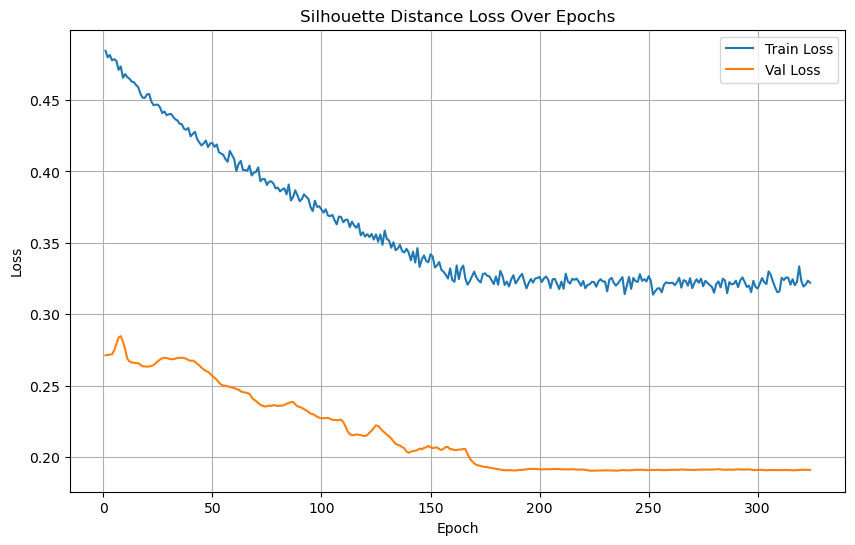

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/41], Loss: 0.2448
Test Batch [20/41], Loss: 0.1762
Test Batch [30/41], Loss: 0.5000
Test Batch [40/41], Loss: 0.1331

Test Loss: 0.2394


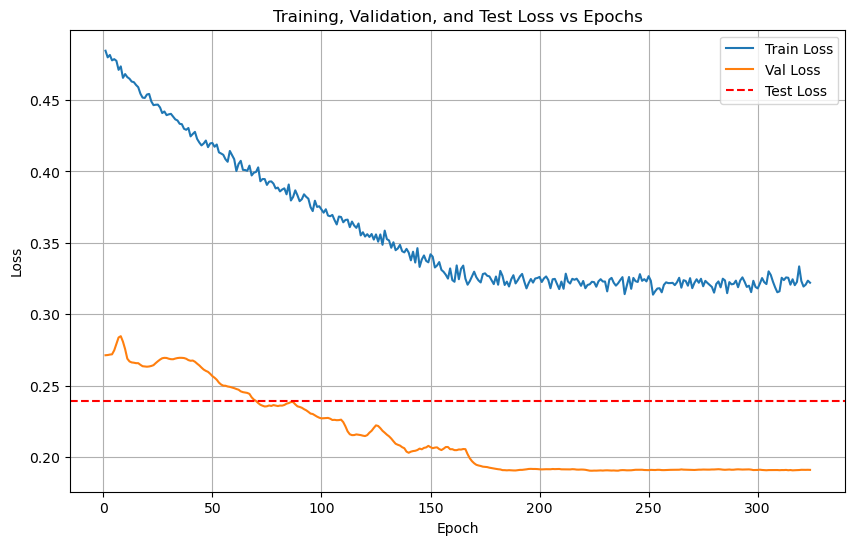

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/41 for test dataset.
  Processed batch 20/41 for test dataset.


  Processed batch 30/41 for test dataset.
  Processed batch 40/41 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (560, 128)
Train labels shape: (560,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2618, 128)
Test labels shape: (2618,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 94.29%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.80      0.89         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5
           5       1.00      0.60      0.75         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       0.71      1.00      0.83         5
           9       0.83      1.00      0.91         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      0.80      0.89         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (560, 128)
Train labels shape: (560,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2618, 128)
Test labels shape: (2618,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6674  |  Val Loss: 2.6069
Validation loss improved from inf to 2.6069.
[Epoch 2/1000] Train Loss: 2.5786  |  Val Loss: 2.5393
Validation loss improved from 2.6069 to 2.5393.
[Epoch 3/1000] Train Loss: 2.5039  |  Val Loss: 2.4804
Validation loss improved from 2.5393 to 2.4804.
[Epoch 4/1000] Train Loss: 2.4433  |  Val Loss: 2.4317
Validation loss improved from 2.4804 to 2.4317.


[Epoch 5/1000] Train Loss: 2.3945  |  Val Loss: 2.3931
Validation loss improved from 2.4317 to 2.3931.
[Epoch 6/1000] Train Loss: 2.3546  |  Val Loss: 2.3588
Validation loss improved from 2.3931 to 2.3588.
[Epoch 7/1000] Train Loss: 2.3190  |  Val Loss: 2.3279
Validation loss improved from 2.3588 to 2.3279.
[Epoch 8/1000] Train Loss: 2.2872  |  Val Loss: 2.2987
Validation loss improved from 2.3279 to 2.2987.


[Epoch 9/1000] Train Loss: 2.2552  |  Val Loss: 2.2701
Validation loss improved from 2.2987 to 2.2701.
[Epoch 10/1000] Train Loss: 2.2234  |  Val Loss: 2.2413
Validation loss improved from 2.2701 to 2.2413.
[Epoch 11/1000] Train Loss: 2.1920  |  Val Loss: 2.2122
Validation loss improved from 2.2413 to 2.2122.


[Epoch 12/1000] Train Loss: 2.1596  |  Val Loss: 2.1828
Validation loss improved from 2.2122 to 2.1828.
[Epoch 13/1000] Train Loss: 2.1268  |  Val Loss: 2.1520
Validation loss improved from 2.1828 to 2.1520.
[Epoch 14/1000] Train Loss: 2.0928  |  Val Loss: 2.1203
Validation loss improved from 2.1520 to 2.1203.
[Epoch 15/1000] Train Loss: 2.0580  |  Val Loss: 2.0872
Validation loss improved from 2.1203 to 2.0872.
[Epoch 16/1000] Train Loss: 2.0223  |  Val Loss: 2.0533
Validation loss improved from 2.0872 to 2.0533.


[Epoch 17/1000] Train Loss: 1.9865  |  Val Loss: 2.0187
Validation loss improved from 2.0533 to 2.0187.
[Epoch 18/1000] Train Loss: 1.9499  |  Val Loss: 1.9830
Validation loss improved from 2.0187 to 1.9830.
[Epoch 19/1000] Train Loss: 1.9127  |  Val Loss: 1.9460
Validation loss improved from 1.9830 to 1.9460.
[Epoch 20/1000] Train Loss: 1.8742  |  Val Loss: 1.9086
Validation loss improved from 1.9460 to 1.9086.


[Epoch 21/1000] Train Loss: 1.8353  |  Val Loss: 1.8716
Validation loss improved from 1.9086 to 1.8716.
[Epoch 22/1000] Train Loss: 1.7960  |  Val Loss: 1.8342
Validation loss improved from 1.8716 to 1.8342.


[Epoch 23/1000] Train Loss: 1.7576  |  Val Loss: 1.7968
Validation loss improved from 1.8342 to 1.7968.
[Epoch 24/1000] Train Loss: 1.7193  |  Val Loss: 1.7599
Validation loss improved from 1.7968 to 1.7599.
[Epoch 25/1000] Train Loss: 1.6817  |  Val Loss: 1.7238
Validation loss improved from 1.7599 to 1.7238.
[Epoch 26/1000] Train Loss: 1.6443  |  Val Loss: 1.6882
Validation loss improved from 1.7238 to 1.6882.
[Epoch 27/1000] Train Loss: 1.6069  |  Val Loss: 1.6526
Validation loss improved from 1.6882 to 1.6526.


[Epoch 28/1000] Train Loss: 1.5697  |  Val Loss: 1.6169
Validation loss improved from 1.6526 to 1.6169.
[Epoch 29/1000] Train Loss: 1.5327  |  Val Loss: 1.5812
Validation loss improved from 1.6169 to 1.5812.
[Epoch 30/1000] Train Loss: 1.4961  |  Val Loss: 1.5453
Validation loss improved from 1.5812 to 1.5453.


[Epoch 31/1000] Train Loss: 1.4593  |  Val Loss: 1.5095
Validation loss improved from 1.5453 to 1.5095.
[Epoch 32/1000] Train Loss: 1.4233  |  Val Loss: 1.4745
Validation loss improved from 1.5095 to 1.4745.


[Epoch 33/1000] Train Loss: 1.3874  |  Val Loss: 1.4401
Validation loss improved from 1.4745 to 1.4401.
[Epoch 34/1000] Train Loss: 1.3526  |  Val Loss: 1.4062
Validation loss improved from 1.4401 to 1.4062.
[Epoch 35/1000] Train Loss: 1.3183  |  Val Loss: 1.3726
Validation loss improved from 1.4062 to 1.3726.
[Epoch 36/1000] Train Loss: 1.2835  |  Val Loss: 1.3397
Validation loss improved from 1.3726 to 1.3397.
[Epoch 37/1000] Train Loss: 1.2492  |  Val Loss: 1.3060
Validation loss improved from 1.3397 to 1.3060.
[Epoch 38/1000] Train Loss: 1.2150  |  Val Loss: 1.2722
Validation loss improved from 1.3060 to 1.2722.


[Epoch 39/1000] Train Loss: 1.1799  |  Val Loss: 1.2388
Validation loss improved from 1.2722 to 1.2388.
[Epoch 40/1000] Train Loss: 1.1456  |  Val Loss: 1.2051
Validation loss improved from 1.2388 to 1.2051.


[Epoch 41/1000] Train Loss: 1.1115  |  Val Loss: 1.1719
Validation loss improved from 1.2051 to 1.1719.


[Epoch 42/1000] Train Loss: 1.0764  |  Val Loss: 1.1394
Validation loss improved from 1.1719 to 1.1394.
[Epoch 43/1000] Train Loss: 1.0423  |  Val Loss: 1.1060
Validation loss improved from 1.1394 to 1.1060.
[Epoch 44/1000] Train Loss: 1.0076  |  Val Loss: 1.0731
Validation loss improved from 1.1060 to 1.0731.
[Epoch 45/1000] Train Loss: 0.9729  |  Val Loss: 1.0400
Validation loss improved from 1.0731 to 1.0400.
[Epoch 46/1000] Train Loss: 0.9380  |  Val Loss: 1.0082
Validation loss improved from 1.0400 to 1.0082.
[Epoch 47/1000] Train Loss: 0.9042  |  Val Loss: 0.9755
Validation loss improved from 1.0082 to 0.9755.
[Epoch 48/1000] Train Loss: 0.8694  |  Val Loss: 0.9440
Validation loss improved from 0.9755 to 0.9440.
[Epoch 49/1000] Train Loss: 0.8358  |  Val Loss: 0.9130
Validation loss improved from 0.9440 to 0.9130.


[Epoch 50/1000] Train Loss: 0.8020  |  Val Loss: 0.8814
Validation loss improved from 0.9130 to 0.8814.
[Epoch 51/1000] Train Loss: 0.7692  |  Val Loss: 0.8517
Validation loss improved from 0.8814 to 0.8517.


[Epoch 52/1000] Train Loss: 0.7367  |  Val Loss: 0.8223
Validation loss improved from 0.8517 to 0.8223.
[Epoch 53/1000] Train Loss: 0.7049  |  Val Loss: 0.7948
Validation loss improved from 0.8223 to 0.7948.
[Epoch 54/1000] Train Loss: 0.6744  |  Val Loss: 0.7677
Validation loss improved from 0.7948 to 0.7677.
[Epoch 55/1000] Train Loss: 0.6450  |  Val Loss: 0.7417
Validation loss improved from 0.7677 to 0.7417.
[Epoch 56/1000] Train Loss: 0.6166  |  Val Loss: 0.7176
Validation loss improved from 0.7417 to 0.7176.
[Epoch 57/1000] Train Loss: 0.5907  |  Val Loss: 0.6939
Validation loss improved from 0.7176 to 0.6939.
[Epoch 58/1000] Train Loss: 0.5650  |  Val Loss: 0.6712
Validation loss improved from 0.6939 to 0.6712.
[Epoch 59/1000] Train Loss: 0.5410  |  Val Loss: 0.6508
Validation loss improved from 0.6712 to 0.6508.
[Epoch 60/1000] Train Loss: 0.5188  |  Val Loss: 0.6312
Validation loss improved from 0.6508 to 0.6312.
[Epoch 61/1000] Train Loss: 0.4973  |  Val Loss: 0.6111
Validati

[Epoch 62/1000] Train Loss: 0.4775  |  Val Loss: 0.5934
Validation loss improved from 0.6111 to 0.5934.
[Epoch 63/1000] Train Loss: 0.4583  |  Val Loss: 0.5771
Validation loss improved from 0.5934 to 0.5771.
[Epoch 64/1000] Train Loss: 0.4408  |  Val Loss: 0.5623
Validation loss improved from 0.5771 to 0.5623.
[Epoch 65/1000] Train Loss: 0.4239  |  Val Loss: 0.5481
Validation loss improved from 0.5623 to 0.5481.
[Epoch 66/1000] Train Loss: 0.4082  |  Val Loss: 0.5338
Validation loss improved from 0.5481 to 0.5338.
[Epoch 67/1000] Train Loss: 0.3936  |  Val Loss: 0.5213
Validation loss improved from 0.5338 to 0.5213.
[Epoch 68/1000] Train Loss: 0.3796  |  Val Loss: 0.5095
Validation loss improved from 0.5213 to 0.5095.
[Epoch 69/1000] Train Loss: 0.3672  |  Val Loss: 0.4978
Validation loss improved from 0.5095 to 0.4978.
[Epoch 70/1000] Train Loss: 0.3547  |  Val Loss: 0.4872
Validation loss improved from 0.4978 to 0.4872.
[Epoch 71/1000] Train Loss: 0.3430  |  Val Loss: 0.4767
Validati

[Epoch 73/1000] Train Loss: 0.3223  |  Val Loss: 0.4576
Validation loss improved from 0.4676 to 0.4576.
[Epoch 74/1000] Train Loss: 0.3124  |  Val Loss: 0.4499
Validation loss improved from 0.4576 to 0.4499.
[Epoch 75/1000] Train Loss: 0.3036  |  Val Loss: 0.4410
Validation loss improved from 0.4499 to 0.4410.
[Epoch 76/1000] Train Loss: 0.2947  |  Val Loss: 0.4339
Validation loss improved from 0.4410 to 0.4339.
[Epoch 77/1000] Train Loss: 0.2868  |  Val Loss: 0.4268
Validation loss improved from 0.4339 to 0.4268.
[Epoch 78/1000] Train Loss: 0.2792  |  Val Loss: 0.4200
Validation loss improved from 0.4268 to 0.4200.
[Epoch 79/1000] Train Loss: 0.2720  |  Val Loss: 0.4122
Validation loss improved from 0.4200 to 0.4122.
[Epoch 80/1000] Train Loss: 0.2649  |  Val Loss: 0.4072
Validation loss improved from 0.4122 to 0.4072.
[Epoch 81/1000] Train Loss: 0.2583  |  Val Loss: 0.4006
Validation loss improved from 0.4072 to 0.4006.
[Epoch 82/1000] Train Loss: 0.2520  |  Val Loss: 0.3947
Validati

[Epoch 83/1000] Train Loss: 0.2464  |  Val Loss: 0.3899
Validation loss improved from 0.3947 to 0.3899.
[Epoch 84/1000] Train Loss: 0.2405  |  Val Loss: 0.3830
Validation loss improved from 0.3899 to 0.3830.
[Epoch 85/1000] Train Loss: 0.2351  |  Val Loss: 0.3778
Validation loss improved from 0.3830 to 0.3778.
[Epoch 86/1000] Train Loss: 0.2302  |  Val Loss: 0.3731
Validation loss improved from 0.3778 to 0.3731.
[Epoch 87/1000] Train Loss: 0.2253  |  Val Loss: 0.3675
Validation loss improved from 0.3731 to 0.3675.
[Epoch 88/1000] Train Loss: 0.2204  |  Val Loss: 0.3637
Validation loss improved from 0.3675 to 0.3637.
[Epoch 89/1000] Train Loss: 0.2158  |  Val Loss: 0.3593
Validation loss improved from 0.3637 to 0.3593.
[Epoch 90/1000] Train Loss: 0.2116  |  Val Loss: 0.3569
Validation loss improved from 0.3593 to 0.3569.
[Epoch 91/1000] Train Loss: 0.2074  |  Val Loss: 0.3532
Validation loss improved from 0.3569 to 0.3532.
[Epoch 92/1000] Train Loss: 0.2034  |  Val Loss: 0.3478
Validati

[Epoch 96/1000] Train Loss: 0.1891  |  Val Loss: 0.3354
Validation loss improved from 0.3370 to 0.3354.
[Epoch 97/1000] Train Loss: 0.1858  |  Val Loss: 0.3311
Validation loss improved from 0.3354 to 0.3311.
[Epoch 98/1000] Train Loss: 0.1828  |  Val Loss: 0.3279
Validation loss improved from 0.3311 to 0.3279.
[Epoch 99/1000] Train Loss: 0.1798  |  Val Loss: 0.3258
Validation loss improved from 0.3279 to 0.3258.
[Epoch 100/1000] Train Loss: 0.1768  |  Val Loss: 0.3220
Validation loss improved from 0.3258 to 0.3220.
[Epoch 101/1000] Train Loss: 0.1737  |  Val Loss: 0.3203
Validation loss improved from 0.3220 to 0.3203.
[Epoch 102/1000] Train Loss: 0.1711  |  Val Loss: 0.3166
Validation loss improved from 0.3203 to 0.3166.
[Epoch 103/1000] Train Loss: 0.1686  |  Val Loss: 0.3139
Validation loss improved from 0.3166 to 0.3139.
[Epoch 104/1000] Train Loss: 0.1659  |  Val Loss: 0.3130
Validation loss improved from 0.3139 to 0.3130.
[Epoch 105/1000] Train Loss: 0.1636  |  Val Loss: 0.3090
Va

[Epoch 107/1000] Train Loss: 0.1586  |  Val Loss: 0.3050
Validation loss improved from 0.3069 to 0.3050.
[Epoch 108/1000] Train Loss: 0.1564  |  Val Loss: 0.3030
Validation loss improved from 0.3050 to 0.3030.
[Epoch 109/1000] Train Loss: 0.1544  |  Val Loss: 0.2993
Validation loss improved from 0.3030 to 0.2993.
[Epoch 110/1000] Train Loss: 0.1523  |  Val Loss: 0.2957
Validation loss improved from 0.2993 to 0.2957.
[Epoch 111/1000] Train Loss: 0.1497  |  Val Loss: 0.2948
Validation loss improved from 0.2957 to 0.2948.
[Epoch 112/1000] Train Loss: 0.1476  |  Val Loss: 0.2935
Validation loss improved from 0.2948 to 0.2935.
[Epoch 113/1000] Train Loss: 0.1456  |  Val Loss: 0.2911
Validation loss improved from 0.2935 to 0.2911.
[Epoch 114/1000] Train Loss: 0.1440  |  Val Loss: 0.2912
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 115/1000] Train Loss: 0.1417  |  Val Loss: 0.2898
Validation loss improved from 0.2911 to 0.2898.
[Epoch 116/1000] Train Loss: 0.1401  |  Val Loss:

[Epoch 118/1000] Train Loss: 0.1363  |  Val Loss: 0.2832
Validation loss improved from 0.2841 to 0.2832.
[Epoch 119/1000] Train Loss: 0.1346  |  Val Loss: 0.2815
Validation loss improved from 0.2832 to 0.2815.
[Epoch 120/1000] Train Loss: 0.1332  |  Val Loss: 0.2794
Validation loss improved from 0.2815 to 0.2794.
[Epoch 121/1000] Train Loss: 0.1315  |  Val Loss: 0.2806
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 122/1000] Train Loss: 0.1298  |  Val Loss: 0.2800
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 123/1000] Train Loss: 0.1280  |  Val Loss: 0.2771
Validation loss improved from 0.2794 to 0.2771.
[Epoch 124/1000] Train Loss: 0.1266  |  Val Loss: 0.2749
Validation loss improved from 0.2771 to 0.2749.
[Epoch 125/1000] Train Loss: 0.1251  |  Val Loss: 0.2744
Validation loss improved from 0.2749 to 0.2744.
[Epoch 126/1000] Train Loss: 0.1237  |  Val Loss: 0.2711
Validation loss improved from 0.2744 to 0.2711.
[Epoch 127/1000] Train Loss: 0.1225  |  Val

[Epoch 130/1000] Train Loss: 0.1181  |  Val Loss: 0.2685
Validation loss improved from 0.2686 to 0.2685.
[Epoch 131/1000] Train Loss: 0.1168  |  Val Loss: 0.2658
Validation loss improved from 0.2685 to 0.2658.
[Epoch 132/1000] Train Loss: 0.1155  |  Val Loss: 0.2633
Validation loss improved from 0.2658 to 0.2633.
[Epoch 133/1000] Train Loss: 0.1145  |  Val Loss: 0.2635
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 134/1000] Train Loss: 0.1132  |  Val Loss: 0.2624
Validation loss improved from 0.2633 to 0.2624.
[Epoch 135/1000] Train Loss: 0.1119  |  Val Loss: 0.2613
Validation loss improved from 0.2624 to 0.2613.
[Epoch 136/1000] Train Loss: 0.1111  |  Val Loss: 0.2591
Validation loss improved from 0.2613 to 0.2591.
[Epoch 137/1000] Train Loss: 0.1098  |  Val Loss: 0.2590
Validation loss improved from 0.2591 to 0.2590.
[Epoch 138/1000] Train Loss: 0.1085  |  Val Loss: 0.2590
Validation loss improved from 0.2590 to 0.2590.
[Epoch 139/1000] Train Loss: 0.1073  |  Val Loss:

[Epoch 141/1000] Train Loss: 0.1051  |  Val Loss: 0.2557
Validation loss improved from 0.2576 to 0.2557.
[Epoch 142/1000] Train Loss: 0.1040  |  Val Loss: 0.2550
Validation loss improved from 0.2557 to 0.2550.
[Epoch 143/1000] Train Loss: 0.1030  |  Val Loss: 0.2544
Validation loss improved from 0.2550 to 0.2544.
[Epoch 144/1000] Train Loss: 0.1020  |  Val Loss: 0.2553
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 145/1000] Train Loss: 0.1010  |  Val Loss: 0.2529
Validation loss improved from 0.2544 to 0.2529.
[Epoch 146/1000] Train Loss: 0.0999  |  Val Loss: 0.2513
Validation loss improved from 0.2529 to 0.2513.
[Epoch 147/1000] Train Loss: 0.0989  |  Val Loss: 0.2501
Validation loss improved from 0.2513 to 0.2501.
[Epoch 148/1000] Train Loss: 0.0981  |  Val Loss: 0.2488
Validation loss improved from 0.2501 to 0.2488.
[Epoch 149/1000] Train Loss: 0.0973  |  Val Loss: 0.2508
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 150/1000] Train Loss: 0.0961  |  Val

[Epoch 153/1000] Train Loss: 0.0934  |  Val Loss: 0.2449
Validation loss improved from 0.2466 to 0.2449.
[Epoch 154/1000] Train Loss: 0.0929  |  Val Loss: 0.2460
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 155/1000] Train Loss: 0.0919  |  Val Loss: 0.2462
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 156/1000] Train Loss: 0.0913  |  Val Loss: 0.2426
Validation loss improved from 0.2449 to 0.2426.
[Epoch 157/1000] Train Loss: 0.0900  |  Val Loss: 0.2427
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 158/1000] Train Loss: 0.0893  |  Val Loss: 0.2449
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 159/1000] Train Loss: 0.0886  |  Val Loss: 0.2437
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 160/1000] Train Loss: 0.0878  |  Val Loss: 0.2415
Validation loss improved from 0.2426 to 0.2415.
[Epoch 161/1000] Train Loss: 0.0873  |  Val Loss: 0.2396
Validation loss improved from 0.2415 to 0.2396.
[Epoch 162/1000] Train Lo

[Epoch 165/1000] Train Loss: 0.0838  |  Val Loss: 0.2389
Validation loss improved from 0.2390 to 0.2389.
[Epoch 166/1000] Train Loss: 0.0833  |  Val Loss: 0.2404
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 167/1000] Train Loss: 0.0824  |  Val Loss: 0.2384
Validation loss improved from 0.2389 to 0.2384.
[Epoch 168/1000] Train Loss: 0.0817  |  Val Loss: 0.2341
Validation loss improved from 0.2384 to 0.2341.
[Epoch 169/1000] Train Loss: 0.0809  |  Val Loss: 0.2344
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 170/1000] Train Loss: 0.0806  |  Val Loss: 0.2352
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 171/1000] Train Loss: 0.0796  |  Val Loss: 0.2338
Validation loss improved from 0.2341 to 0.2338.
[Epoch 172/1000] Train Loss: 0.0790  |  Val Loss: 0.2344
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 173/1000] Train Loss: 0.0783  |  Val Loss: 0.2337
Validation loss improved from 0.2338 to 0.2337.
[Epoch 174/1000] Train Loss: 0.

[Epoch 176/1000] Train Loss: 0.0764  |  Val Loss: 0.2317
Validation loss improved from 0.2320 to 0.2317.
[Epoch 177/1000] Train Loss: 0.0756  |  Val Loss: 0.2314
Validation loss improved from 0.2317 to 0.2314.
[Epoch 178/1000] Train Loss: 0.0754  |  Val Loss: 0.2338
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 179/1000] Train Loss: 0.0746  |  Val Loss: 0.2314
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 180/1000] Train Loss: 0.0739  |  Val Loss: 0.2322
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 181/1000] Train Loss: 0.0734  |  Val Loss: 0.2290
Validation loss improved from 0.2314 to 0.2290.
[Epoch 182/1000] Train Loss: 0.0728  |  Val Loss: 0.2316
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 183/1000] Train Loss: 0.0722  |  Val Loss: 0.2294
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 184/1000] Train Loss: 0.0716  |  Val Loss: 0.2285
Validation loss improved from 0.2290 to 0.2285.
[Epoch 185/1000] Train Lo

[Epoch 188/1000] Train Loss: 0.0693  |  Val Loss: 0.2274
Validation loss improved from 0.2281 to 0.2274.
[Epoch 189/1000] Train Loss: 0.0688  |  Val Loss: 0.2264
Validation loss improved from 0.2274 to 0.2264.
[Epoch 190/1000] Train Loss: 0.0682  |  Val Loss: 0.2279
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 191/1000] Train Loss: 0.0676  |  Val Loss: 0.2262
Validation loss improved from 0.2264 to 0.2262.
[Epoch 192/1000] Train Loss: 0.0672  |  Val Loss: 0.2264
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 193/1000] Train Loss: 0.0670  |  Val Loss: 0.2298
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 194/1000] Train Loss: 0.0659  |  Val Loss: 0.2255
Validation loss improved from 0.2262 to 0.2255.
[Epoch 195/1000] Train Loss: 0.0658  |  Val Loss: 0.2255
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 196/1000] Train Loss: 0.0650  |  Val Loss: 0.2239
Validation loss improved from 0.2255 to 0.2239.
[Epoch 197/1000] Train Loss: 0.

[Epoch 199/1000] Train Loss: 0.0640  |  Val Loss: 0.2247
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 200/1000] Train Loss: 0.0631  |  Val Loss: 0.2196
Validation loss improved from 0.2225 to 0.2196.
[Epoch 201/1000] Train Loss: 0.0628  |  Val Loss: 0.2189
Validation loss improved from 0.2196 to 0.2189.
[Epoch 202/1000] Train Loss: 0.0622  |  Val Loss: 0.2227
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 203/1000] Train Loss: 0.0621  |  Val Loss: 0.2268
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 204/1000] Train Loss: 0.0611  |  Val Loss: 0.2244
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 205/1000] Train Loss: 0.0607  |  Val Loss: 0.2184
Validation loss improved from 0.2189 to 0.2184.
[Epoch 206/1000] Train Loss: 0.0603  |  Val Loss: 0.2178
Validation loss improved from 0.2184 to 0.2178.
[Epoch 207/1000] Train Loss: 0.0602  |  Val Loss: 0.2194
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 208/1000] Train Lo

[Epoch 211/1000] Train Loss: 0.0582  |  Val Loss: 0.2214
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 212/1000] Train Loss: 0.0577  |  Val Loss: 0.2204
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 213/1000] Train Loss: 0.0573  |  Val Loss: 0.2189
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 214/1000] Train Loss: 0.0569  |  Val Loss: 0.2204
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 215/1000] Train Loss: 0.0565  |  Val Loss: 0.2192
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 216/1000] Train Loss: 0.0561  |  Val Loss: 0.2197
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 217/1000] Train Loss: 0.0556  |  Val Loss: 0.2173
Validation loss improved from 0.2178 to 0.2173.
[Epoch 218/1000] Train Loss: 0.0555  |  Val Loss: 0.2151
Validation loss improved from 0.2173 to 0.2151.
[Epoch 219/1000] Train Loss: 0.0549  |  Val Loss: 0.2178
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 220/1

[Epoch 222/1000] Train Loss: 0.0538  |  Val Loss: 0.2177
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 223/1000] Train Loss: 0.0537  |  Val Loss: 0.2129
Validation loss improved from 0.2151 to 0.2129.
[Epoch 224/1000] Train Loss: 0.0533  |  Val Loss: 0.2185
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 225/1000] Train Loss: 0.0531  |  Val Loss: 0.2201
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 226/1000] Train Loss: 0.0522  |  Val Loss: 0.2136
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 227/1000] Train Loss: 0.0522  |  Val Loss: 0.2115
Validation loss improved from 0.2129 to 0.2115.
[Epoch 228/1000] Train Loss: 0.0517  |  Val Loss: 0.2122
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 229/1000] Train Loss: 0.0515  |  Val Loss: 0.2137
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 230/1000] Train Loss: 0.0510  |  Val Loss: 0.2164
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 231/10

[Epoch 233/1000] Train Loss: 0.0499  |  Val Loss: 0.2119
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 234/1000] Train Loss: 0.0495  |  Val Loss: 0.2133
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 235/1000] Train Loss: 0.0491  |  Val Loss: 0.2127
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 236/1000] Train Loss: 0.0487  |  Val Loss: 0.2128
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 237/1000] Train Loss: 0.0487  |  Val Loss: 0.2109
Validation loss improved from 0.2115 to 0.2109.
[Epoch 238/1000] Train Loss: 0.0485  |  Val Loss: 0.2154
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 239/1000] Train Loss: 0.0479  |  Val Loss: 0.2136
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 240/1000] Train Loss: 0.0476  |  Val Loss: 0.2093
Validation loss improved from 0.2109 to 0.2093.
[Epoch 241/1000] Train Loss: 0.0473  |  Val Loss: 0.2096
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 242/10

[Epoch 245/1000] Train Loss: 0.0459  |  Val Loss: 0.2107
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 246/1000] Train Loss: 0.0456  |  Val Loss: 0.2094
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 247/1000] Train Loss: 0.0455  |  Val Loss: 0.2113
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 248/1000] Train Loss: 0.0452  |  Val Loss: 0.2091
Validation loss improved from 0.2093 to 0.2091.
[Epoch 249/1000] Train Loss: 0.0448  |  Val Loss: 0.2109
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 250/1000] Train Loss: 0.0444  |  Val Loss: 0.2074
Validation loss improved from 0.2091 to 0.2074.
[Epoch 251/1000] Train Loss: 0.0441  |  Val Loss: 0.2094
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 252/1000] Train Loss: 0.0438  |  Val Loss: 0.2097
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 253/1000] Train Loss: 0.0438  |  Val Loss: 0.2117
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 254/10

[Epoch 257/1000] Train Loss: 0.0425  |  Val Loss: 0.2065
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 258/1000] Train Loss: 0.0420  |  Val Loss: 0.2078
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 259/1000] Train Loss: 0.0418  |  Val Loss: 0.2076
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 260/1000] Train Loss: 0.0421  |  Val Loss: 0.2128
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 261/1000] Train Loss: 0.0414  |  Val Loss: 0.2051
Validation loss improved from 0.2062 to 0.2051.
[Epoch 262/1000] Train Loss: 0.0412  |  Val Loss: 0.2056
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 263/1000] Train Loss: 0.0407  |  Val Loss: 0.2071
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 264/1000] Train Loss: 0.0405  |  Val Loss: 0.2070
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 265/1000] Train Loss: 0.0402  |  Val Loss: 0.2079
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 

[Epoch 269/1000] Train Loss: 0.0391  |  Val Loss: 0.2045
Validation loss improved from 0.2051 to 0.2045.
[Epoch 270/1000] Train Loss: 0.0390  |  Val Loss: 0.2047
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 271/1000] Train Loss: 0.0387  |  Val Loss: 0.2050
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 272/1000] Train Loss: 0.0386  |  Val Loss: 0.2043
Validation loss improved from 0.2045 to 0.2043.
[Epoch 273/1000] Train Loss: 0.0382  |  Val Loss: 0.2079
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 274/1000] Train Loss: 0.0381  |  Val Loss: 0.2088
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 275/1000] Train Loss: 0.0379  |  Val Loss: 0.2050
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 276/1000] Train Loss: 0.0377  |  Val Loss: 0.2053
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 277/1000] Train Loss: 0.0372  |  Val Loss: 0.2055
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 278/10

[Epoch 281/1000] Train Loss: 0.0363  |  Val Loss: 0.2033
Validation loss improved from 0.2043 to 0.2033.
[Epoch 282/1000] Train Loss: 0.0362  |  Val Loss: 0.2051
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 283/1000] Train Loss: 0.0359  |  Val Loss: 0.2042
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 284/1000] Train Loss: 0.0358  |  Val Loss: 0.2033
Validation loss improved from 0.2033 to 0.2033.
[Epoch 285/1000] Train Loss: 0.0355  |  Val Loss: 0.2046
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 286/1000] Train Loss: 0.0352  |  Val Loss: 0.2025
Validation loss improved from 0.2033 to 0.2025.
[Epoch 287/1000] Train Loss: 0.0353  |  Val Loss: 0.2063
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 288/1000] Train Loss: 0.0347  |  Val Loss: 0.2025
Validation loss improved from 0.2025 to 0.2025.
[Epoch 289/1000] Train Loss: 0.0350  |  Val Loss: 0.2014
Validation loss improved from 0.2025 to 0.2014.
[Epoch 290/1000] Train Loss: 0.

[Epoch 292/1000] Train Loss: 0.0346  |  Val Loss: 0.2089
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 293/1000] Train Loss: 0.0338  |  Val Loss: 0.2021
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 294/1000] Train Loss: 0.0337  |  Val Loss: 0.2006
Validation loss improved from 0.2014 to 0.2006.
[Epoch 295/1000] Train Loss: 0.0333  |  Val Loss: 0.2028
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 296/1000] Train Loss: 0.0332  |  Val Loss: 0.2043
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 297/1000] Train Loss: 0.0331  |  Val Loss: 0.2056
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 298/1000] Train Loss: 0.0327  |  Val Loss: 0.2019
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 299/1000] Train Loss: 0.0327  |  Val Loss: 0.2040
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 300/1000] Train Loss: 0.0327  |  Val Loss: 0.2004
Validation loss improved from 0.2006 to 0.2004.
[Epoch 301/10

[Epoch 302/1000] Train Loss: 0.0319  |  Val Loss: 0.2038
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 303/1000] Train Loss: 0.0318  |  Val Loss: 0.2031
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 304/1000] Train Loss: 0.0316  |  Val Loss: 0.2031
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 305/1000] Train Loss: 0.0312  |  Val Loss: 0.2017
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 306/1000] Train Loss: 0.0312  |  Val Loss: 0.2025
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 307/1000] Train Loss: 0.0312  |  Val Loss: 0.2004
Validation loss improved from 0.2004 to 0.2004.
[Epoch 308/1000] Train Loss: 0.0308  |  Val Loss: 0.2039
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 309/1000] Train Loss: 0.0306  |  Val Loss: 0.2051
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 310/1000] Train Loss: 0.0308  |  Val Loss: 0.1996
Validation loss improved from 0.2004 to 0.1996.
[Epoch 311/10

[Epoch 312/1000] Train Loss: 0.0303  |  Val Loss: 0.2050
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 313/1000] Train Loss: 0.0299  |  Val Loss: 0.2048
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 314/1000] Train Loss: 0.0297  |  Val Loss: 0.2029
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 315/1000] Train Loss: 0.0295  |  Val Loss: 0.2018
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 316/1000] Train Loss: 0.0292  |  Val Loss: 0.2015
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 317/1000] Train Loss: 0.0291  |  Val Loss: 0.2023
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 318/1000] Train Loss: 0.0292  |  Val Loss: 0.2037
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 319/1000] Train Loss: 0.0286  |  Val Loss: 0.2004
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 320/1000] Train Loss: 0.0287  |  Val Loss: 0.1969
Validation loss improved from 0.1996 to 0.1969.
[Epoch 

[Epoch 322/1000] Train Loss: 0.0283  |  Val Loss: 0.2021
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 323/1000] Train Loss: 0.0281  |  Val Loss: 0.2037
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 324/1000] Train Loss: 0.0279  |  Val Loss: 0.2042
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 325/1000] Train Loss: 0.0276  |  Val Loss: 0.2023
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 326/1000] Train Loss: 0.0277  |  Val Loss: 0.1991
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 327/1000] Train Loss: 0.0274  |  Val Loss: 0.2004
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 328/1000] Train Loss: 0.0273  |  Val Loss: 0.2047
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 329/1000] Train Loss: 0.0270  |  Val Loss: 0.2068
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 330/1000] Train Loss: 0.0269  |  Val Loss: 0.2043
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 333/1000] Train Loss: 0.0264  |  Val Loss: 0.2062
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 334/1000] Train Loss: 0.0264  |  Val Loss: 0.2085
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 335/1000] Train Loss: 0.0260  |  Val Loss: 0.2054
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 336/1000] Train Loss: 0.0260  |  Val Loss: 0.2024
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 337/1000] Train Loss: 0.0257  |  Val Loss: 0.2024
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 338/1000] Train Loss: 0.0255  |  Val Loss: 0.2041
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 339/1000] Train Loss: 0.0257  |  Val Loss: 0.2008
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 340/1000] Train Loss: 0.0252  |  Val Loss: 0.2047
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 341/1000] Train Loss: 0.0252  |  Val Loss: 0.2079
!! Validation loss did NOT improve !! Patience:

[Epoch 345/1000] Train Loss: 0.0245  |  Val Loss: 0.2032
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 346/1000] Train Loss: 0.0244  |  Val Loss: 0.2043
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 347/1000] Train Loss: 0.0242  |  Val Loss: 0.2002
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 348/1000] Train Loss: 0.0240  |  Val Loss: 0.2037
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 349/1000] Train Loss: 0.0238  |  Val Loss: 0.2058
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 350/1000] Train Loss: 0.0237  |  Val Loss: 0.2034
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 351/1000] Train Loss: 0.0238  |  Val Loss: 0.1996
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 352/1000] Train Loss: 0.0235  |  Val Loss: 0.2078
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 353/1000] Train Loss: 0.0232  |  Val Loss: 0.2069
!! Validation loss did NOT improve !! Patience:

[Epoch 355/1000] Train Loss: 0.0230  |  Val Loss: 0.2034
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 356/1000] Train Loss: 0.0228  |  Val Loss: 0.2051
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 357/1000] Train Loss: 0.0225  |  Val Loss: 0.2056
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 358/1000] Train Loss: 0.0224  |  Val Loss: 0.2063
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 359/1000] Train Loss: 0.0222  |  Val Loss: 0.2056
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 360/1000] Train Loss: 0.0221  |  Val Loss: 0.2076
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 361/1000] Train Loss: 0.0220  |  Val Loss: 0.2047
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 362/1000] Train Loss: 0.0219  |  Val Loss: 0.2037
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 363/1000] Train Loss: 0.0218  |  Val Loss: 0.2049
!! Validation loss did NOT improve !! Patience:

[Epoch 365/1000] Train Loss: 0.0214  |  Val Loss: 0.2052
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 366/1000] Train Loss: 0.0213  |  Val Loss: 0.2066
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 367/1000] Train Loss: 0.0211  |  Val Loss: 0.2046
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 368/1000] Train Loss: 0.0211  |  Val Loss: 0.2040
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 369/1000] Train Loss: 0.0209  |  Val Loss: 0.2054
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 370/1000] Train Loss: 0.0207  |  Val Loss: 0.2049
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 371/1000] Train Loss: 0.0207  |  Val Loss: 0.2020
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 372/1000] Train Loss: 0.0207  |  Val Loss: 0.2085
!! Validation loss did NOT improve !! Patience: 52/100


[Epoch 373/1000] Train Loss: 0.0204  |  Val Loss: 0.2064
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 374/1000] Train Loss: 0.0205  |  Val Loss: 0.2037
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 375/1000] Train Loss: 0.0202  |  Val Loss: 0.2038
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 376/1000] Train Loss: 0.0202  |  Val Loss: 0.2060
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 377/1000] Train Loss: 0.0199  |  Val Loss: 0.2066
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 378/1000] Train Loss: 0.0197  |  Val Loss: 0.2027
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 379/1000] Train Loss: 0.0196  |  Val Loss: 0.2030
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 380/1000] Train Loss: 0.0196  |  Val Loss: 0.2032
!! Validation loss did NOT improve !! Patience: 60/100


[Epoch 381/1000] Train Loss: 0.0193  |  Val Loss: 0.2061
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 382/1000] Train Loss: 0.0193  |  Val Loss: 0.2091
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 383/1000] Train Loss: 0.0191  |  Val Loss: 0.2048
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 384/1000] Train Loss: 0.0190  |  Val Loss: 0.2032
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 385/1000] Train Loss: 0.0189  |  Val Loss: 0.2032
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 386/1000] Train Loss: 0.0187  |  Val Loss: 0.2036
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 387/1000] Train Loss: 0.0186  |  Val Loss: 0.2033
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 388/1000] Train Loss: 0.0184  |  Val Loss: 0.2045
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 389/1000] Train Loss: 0.0185  |  Val Loss: 0.2058
!! Validation loss did NOT improve !! Patience:

[Epoch 391/1000] Train Loss: 0.0182  |  Val Loss: 0.2044
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 392/1000] Train Loss: 0.0181  |  Val Loss: 0.2032
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 393/1000] Train Loss: 0.0180  |  Val Loss: 0.2030
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 394/1000] Train Loss: 0.0180  |  Val Loss: 0.2077
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 395/1000] Train Loss: 0.0178  |  Val Loss: 0.2034
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 396/1000] Train Loss: 0.0176  |  Val Loss: 0.2036
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 397/1000] Train Loss: 0.0175  |  Val Loss: 0.2031
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 398/1000] Train Loss: 0.0174  |  Val Loss: 0.2045
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 399/1000] Train Loss: 0.0173  |  Val Loss: 0.2043
!! Validation loss did NOT improve !! Patience:

[Epoch 402/1000] Train Loss: 0.0169  |  Val Loss: 0.2057
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 403/1000] Train Loss: 0.0169  |  Val Loss: 0.2029
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 404/1000] Train Loss: 0.0168  |  Val Loss: 0.2049
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 405/1000] Train Loss: 0.0168  |  Val Loss: 0.2033
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 406/1000] Train Loss: 0.0166  |  Val Loss: 0.2056
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 407/1000] Train Loss: 0.0164  |  Val Loss: 0.2043
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 408/1000] Train Loss: 0.0163  |  Val Loss: 0.2041
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 409/1000] Train Loss: 0.0162  |  Val Loss: 0.2065
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 410/1000] Train Loss: 0.0160  |  Val Loss: 0.2073
!! Validation loss did NOT improve !! Patience:

[Epoch 414/1000] Train Loss: 0.0159  |  Val Loss: 0.2012
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 415/1000] Train Loss: 0.0159  |  Val Loss: 0.2100
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 416/1000] Train Loss: 0.0155  |  Val Loss: 0.2049
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 417/1000] Train Loss: 0.0154  |  Val Loss: 0.2042
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 418/1000] Train Loss: 0.0153  |  Val Loss: 0.2023
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 419/1000] Train Loss: 0.0151  |  Val Loss: 0.2034
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 420/1000] Train Loss: 0.0151  |  Val Loss: 0.2048
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 420 !!
No improvement for 100 epochs.


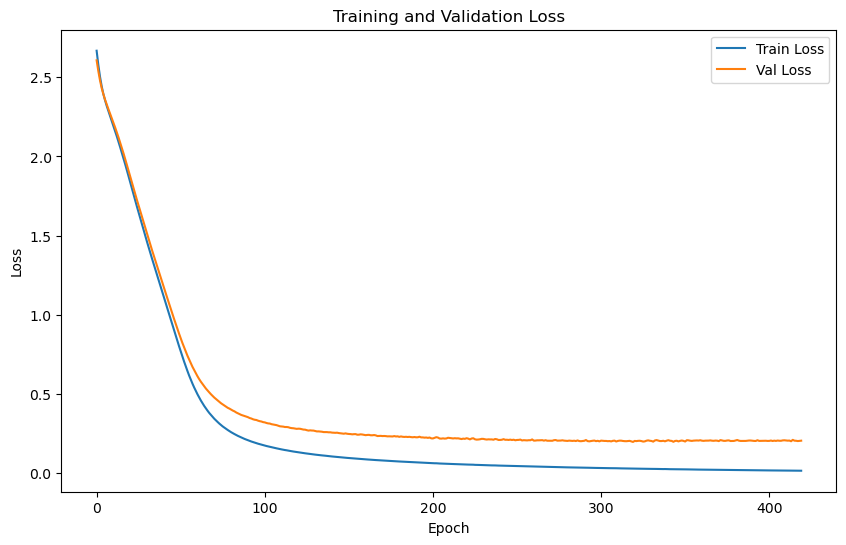

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.4146 | Test Accuracy: 89.42%


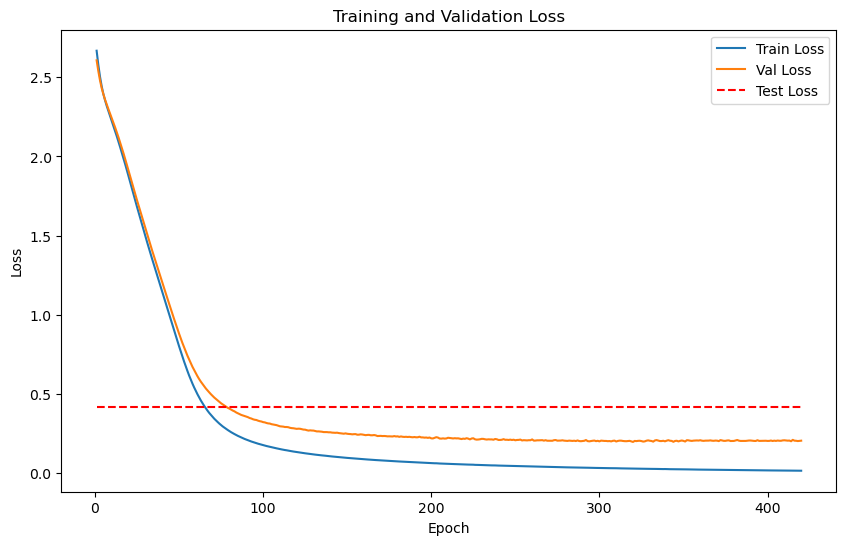

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


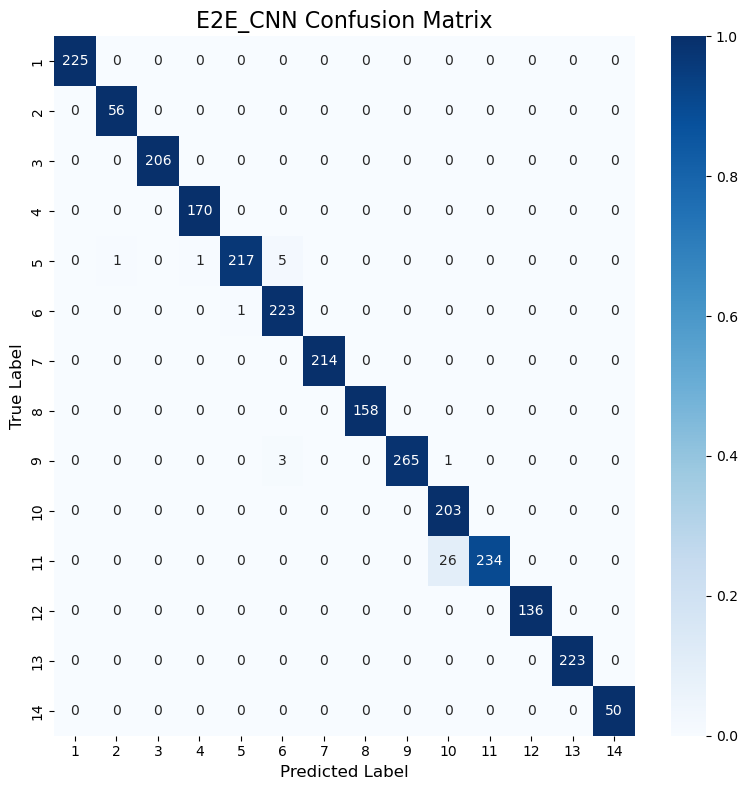

Classification Accuracy: 98.55%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


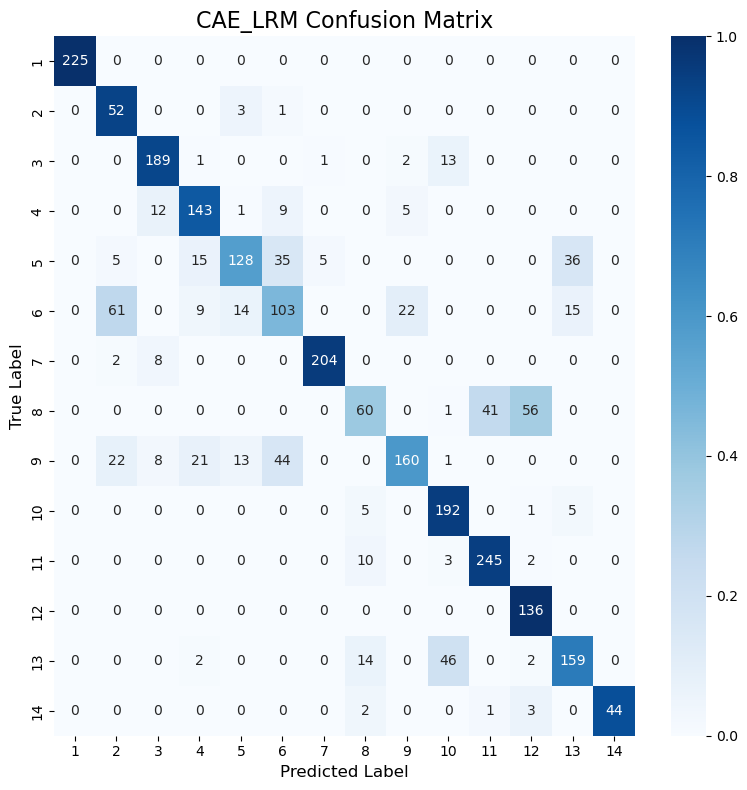

Classification Accuracy: 77.92%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


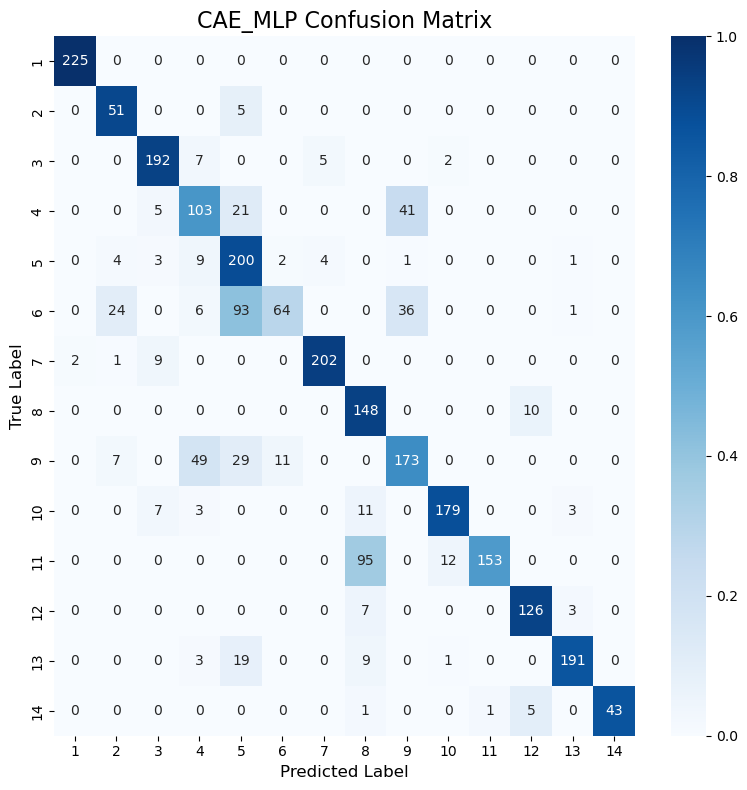

Classification Accuracy: 78.30%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


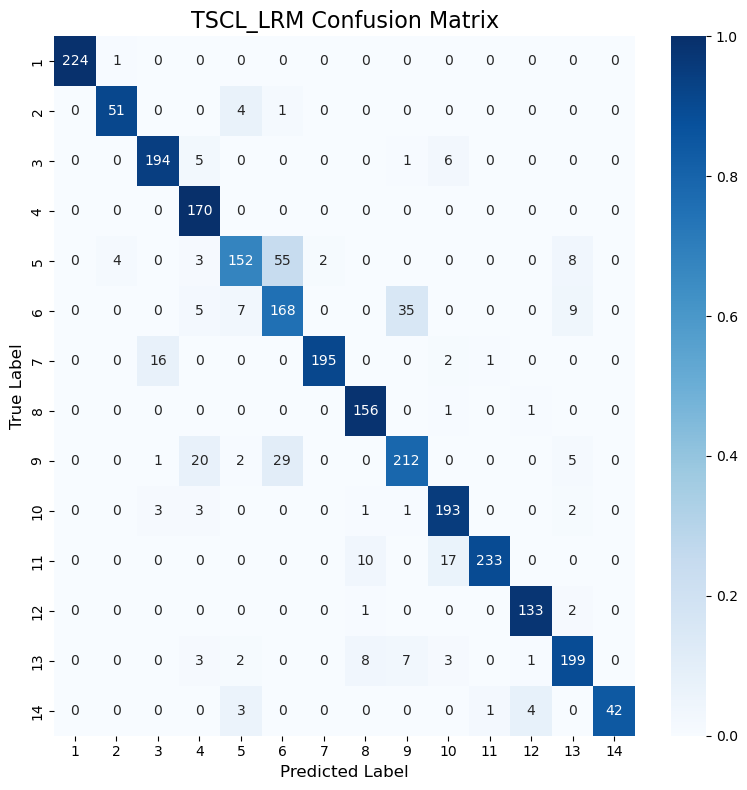

Classification Accuracy: 88.69%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


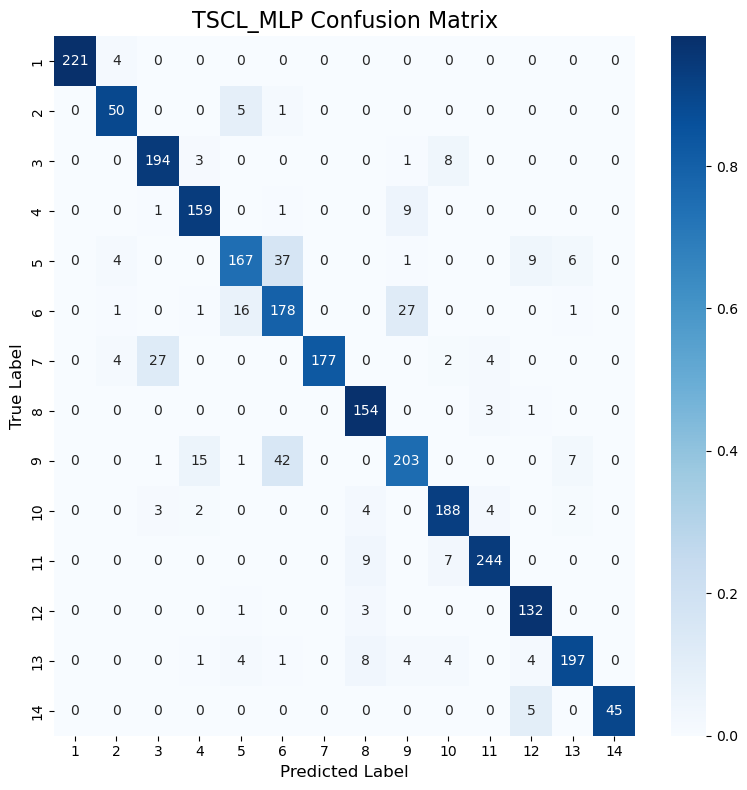

Classification Accuracy: 88.20%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


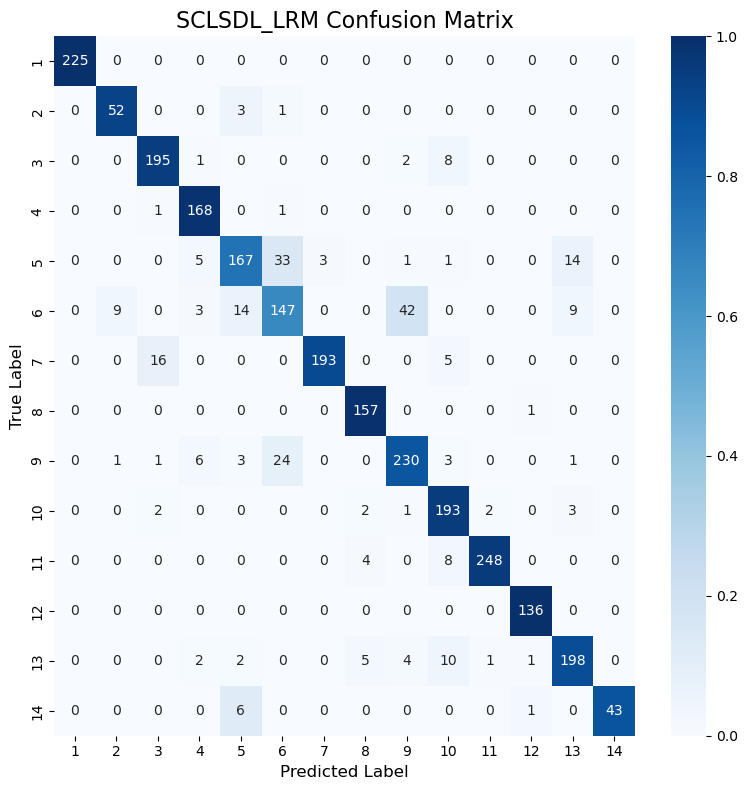

Classification Accuracy: 89.84%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


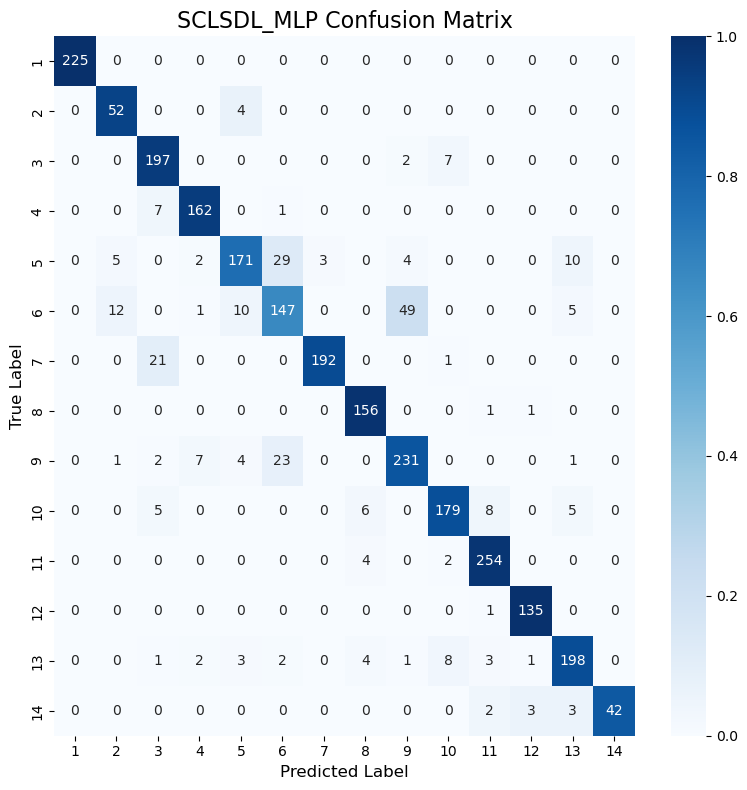

Classification Accuracy: 89.42%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          98.55
1    LRM (CAE)          77.92
2    MLP (CAE)          78.30
3     TSCL LRM          88.69
4     TSCL MLP          88.20
5  SCL_SDL LRM          89.84
6  SCL_SDL MLP          89.42

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          98.55
5  SCL_SDL LRM          89.84
6  SCL_SDL MLP          89.42
3     TSCL LRM          88.69
4     TSCL MLP          88.20
2    MLP (CAE)          78.30
1    LRM (CAE)          77.92
